In [1]:
import pandas as pd
import os
import hdbscan
import folium
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm
import matplotlib.colors as colors
import hdbscan
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import BallTree
from geopy.distance import geodesic
import folium
from folium import plugins
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)


In [2]:
os.chdir('c:/Users/admin/OneDrive/Documents/TrabajoTesis') 


### Preliminar

In [37]:
df = pd.read_csv('Cluster/df_faenas_y_desaladoras_y_puertos.csv')

In [9]:
#df = df.drop(columns = ['categorias_10km'])

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21158 entries, 0 to 21157
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   RutEmpresa               21158 non-null  object 
 1   NombreEmpresa            21158 non-null  object 
 2   CategoriaFaena           21158 non-null  object 
 3   RegionInstalacion        21158 non-null  object 
 4   TipoInstalacion          21158 non-null  object 
 5   Cota                     21158 non-null  int64  
 6   Huso                     21158 non-null  int64  
 7   Estado                   21158 non-null  object 
 8   Latitud                  21158 non-null  float64
 9   Longitud                 21158 non-null  float64
 10  faenas_10km              21158 non-null  int64  
 11  categorias_10km          21158 non-null  object 
 12  categoriaA_10km          21158 non-null  int64  
 13  Closest_City             21158 non-null  object 
 14  Distance_km           

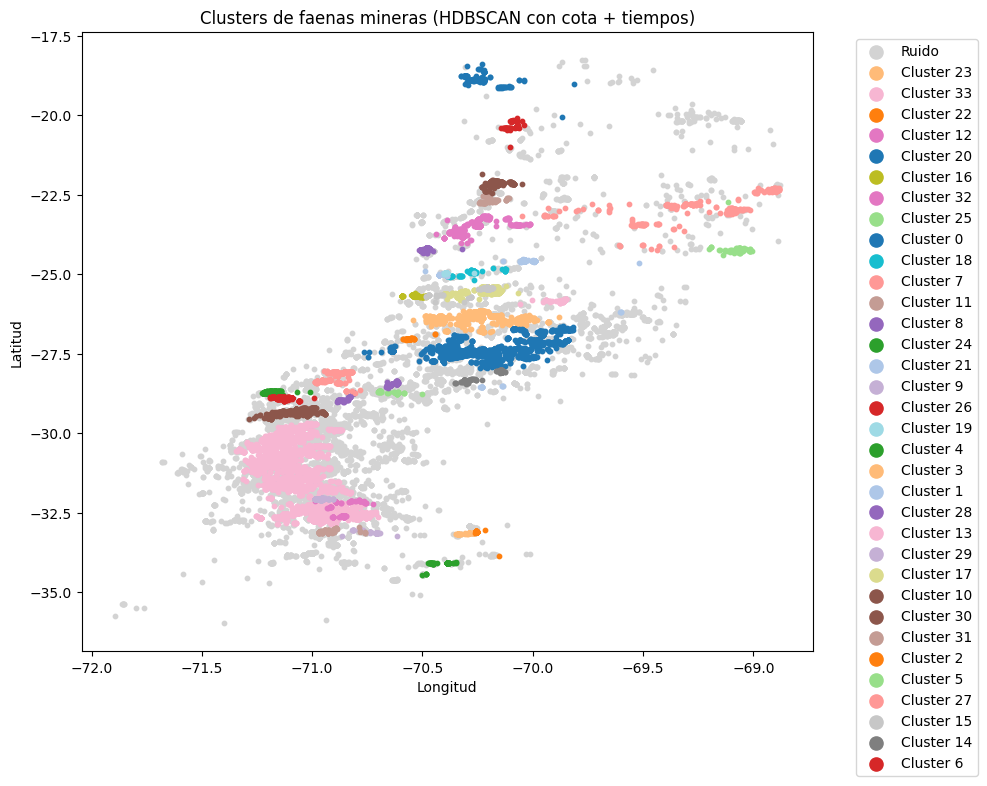

In [39]:
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# === Step 1: Select variables ===
features = ['Longitud', 'Latitud', 'Cota', 
            'Travel_min', 'travel_time_desal', 'travel_time_min']

# Remove rows with missing or infinite values
df_filtered = df[features].replace([np.inf, -np.inf], np.nan).dropna().copy()

# === Step 2: Remove outliers using z-score ===
z_scores = np.abs((df_filtered - df_filtered.mean()) / df_filtered.std())
mask = (z_scores < 3).all(axis=1)
df_clean = df.loc[mask].copy()

# === Step 3: Scale the features (important for HDBSCAN) ===
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(df_clean[features])

# === Step 4: Fit HDBSCAN ===
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=50,
    cluster_selection_epsilon=0.4,
    metric='euclidean'
)
df_clean['cluster'] = clusterer.fit_predict(coords_scaled)

# === Step 5: Keep only top 25 largest clusters ===
cluster_counts = df_clean['cluster'].value_counts()
top_clusters = cluster_counts.nlargest(40).index
df_clean['cluster'] = df_clean['cluster'].apply(lambda x: x if x in top_clusters else -1)

# === Step 6: Plot ===
plt.figure(figsize=(10,8))
cmap = plt.get_cmap('tab20')

for cluster in df_clean['cluster'].unique():
    mask = df_clean['cluster'] == cluster
    if cluster == -1:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color='lightgray', s=10, label='Ruido')
    else:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color=cmap(cluster % 20), s=10, label=f'Cluster {cluster}')

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Clusters de faenas mineras (HDBSCAN con cota + tiempos)')
plt.legend(markerscale=3, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


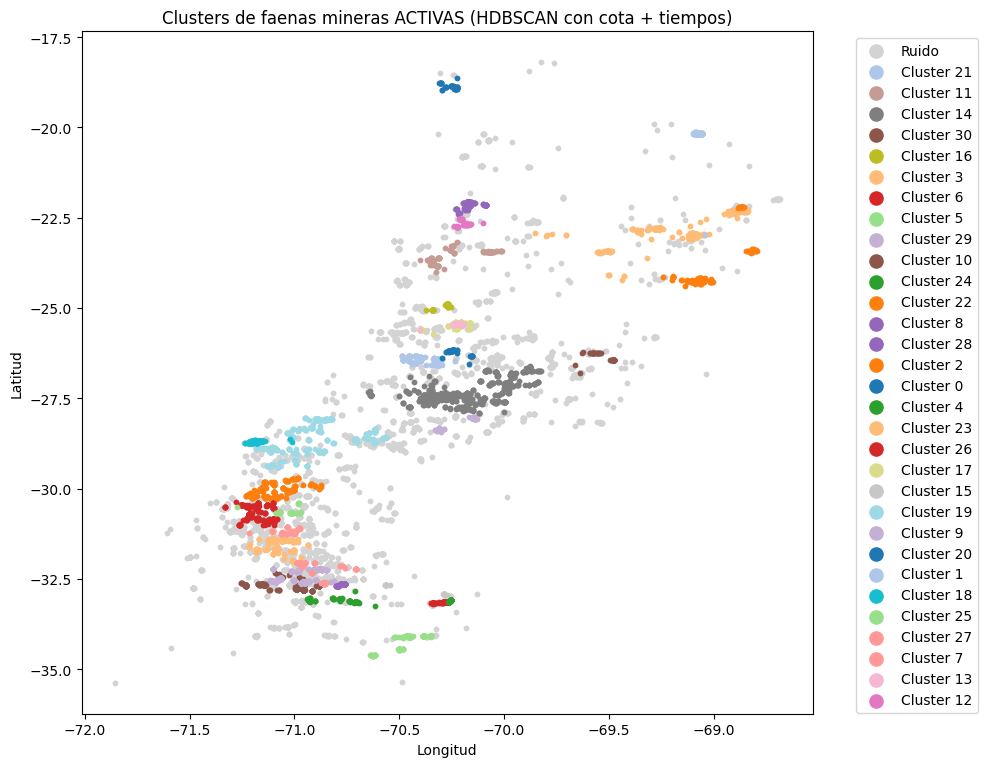

In [40]:
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# === Step 0: Filter only active sites ===
df_active = df[df["Estado"] == "ACTIVA"].copy()

# === Step 1: Select relevant variables ===
features = ['Longitud', 'Latitud', 'Cota', 
            'Travel_min', 'travel_time_desal', 'travel_time_min']

# Remove rows with missing or infinite values
df_active = df_active[features].replace([np.inf, -np.inf], np.nan).dropna().copy()

# === Step 2: Remove outliers using z-score ===
z_scores = np.abs((df_active - df_active.mean()) / df_active.std())
mask = (z_scores < 3).all(axis=1)
df_clean = df_active.loc[mask].copy()

# === Step 3: Scale features ===
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(df_clean[features])

# === Step 4: Fit HDBSCAN ===
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=40,
    cluster_selection_epsilon=0.35,
    metric='euclidean'
)
df_clean['cluster'] = clusterer.fit_predict(coords_scaled)

# === Step 5: Keep only top 40 largest clusters ===
cluster_counts = df_clean['cluster'].value_counts()
top_clusters = cluster_counts.nlargest(40).index
df_clean['cluster'] = df_clean['cluster'].apply(lambda x: x if x in top_clusters else -1)

# === Step 6: Plot ===
plt.figure(figsize=(10,8))
cmap = plt.get_cmap('tab20')

for cluster in df_clean['cluster'].unique():
    mask = df_clean['cluster'] == cluster
    if cluster == -1:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color='lightgray', s=10, label='Ruido')
    else:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color=cmap(cluster % 20), s=10, label=f'Cluster {cluster}')

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Clusters de faenas mineras ACTIVAS (HDBSCAN con cota + tiempos)')
plt.legend(markerscale=3, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [41]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# === Base map ===
m = folium.Map(location=[-25, -70], zoom_start=4.5, tiles='CartoDB positron')

# === Color map for clusters ===
num_clusters = len(df_clean['cluster'].unique())
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {c: colors.to_hex(cmap(i % 20)) for i, c in enumerate(sorted(df_clean['cluster'].unique()))}

# === Add points with popups ===
for _, row in df_clean.iterrows():
    cluster_id = row['cluster']
    color = 'lightgray' if cluster_id == -1 else color_dict[cluster_id]
    
    # Create a popup with relevant info
    popup_text = f"""
    <b>Cluster:</b> {cluster_id}<br>
    <b>Cota:</b> {row['Cota']:.0f}<br>
    <b>Travel_min:</b> {row['Travel_min']:.1f} min<br>
    <b>Desaladora:</b> {row['travel_time_desal']:.1f} min<br>
    <b>Puerto:</b> {row['travel_time_min']:.1f} min
    """
    
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=3,
        color=color,
        fill=True,
        fill_opacity=0.8,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(m)

# === Save HTML map ===
m.save('chile_clusters.html')
print("✅ Mapa interactivo guardado como chile_clusters.html")


C:\Users\admin\AppData\Local\Temp\ipykernel_14240\4020827223.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)


✅ Mapa interactivo guardado como chile_clusters.html


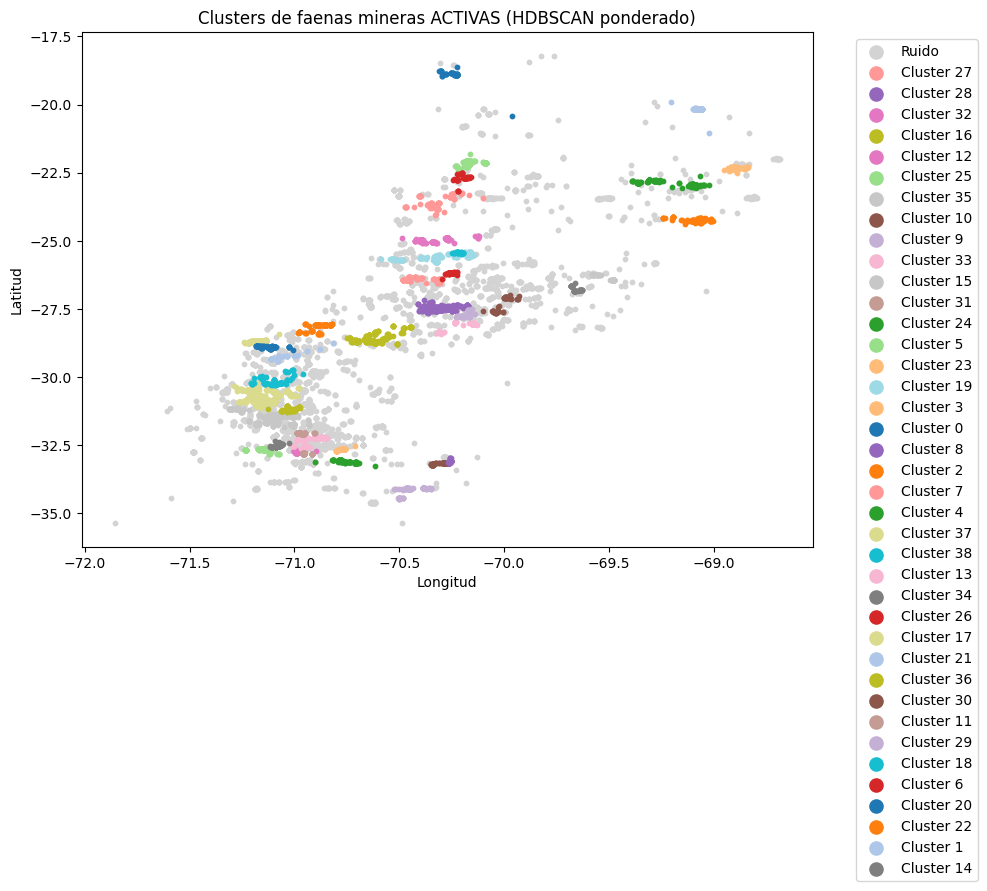

In [42]:
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# === Step 0: Filter only active sites ===
df_active = df[df["Estado"] == "ACTIVA"].copy()

# === Step 1: Select relevant variables ===
features = ['Longitud', 'Latitud', 'Cota', 
            'Travel_min', 'travel_time_desal', 'travel_time_min']

# Remove rows with missing or infinite values
df_active = df_active[features].replace([np.inf, -np.inf], np.nan).dropna().copy()

# === Step 2: Remove outliers using z-score ===
z_scores = np.abs((df_active - df_active.mean()) / df_active.std())
mask = (z_scores < 3).all(axis=1)
df_clean = df_active.loc[mask].copy()

# === Step 3: Scale and weight features ===
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(df_clean[features])

# ⚖️ Define feature weights (tune as needed)
weights = {
    'Longitud': 3.0,          # keep high (spatial importance)
    'Latitud': 3.0,           # keep high (spatial importance)
    'Cota': 0.5,              # less important
    'Travel_min': 1.5,        # more important
    'travel_time_desal': 0.5, # moderate
    'travel_time_min': 1.0    # baseline
}

# Apply weights
for i, f in enumerate(features):
    coords_scaled[:, i] *= weights[f]

# === Step 4: Fit HDBSCAN ===
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=40,
    cluster_selection_epsilon=0.4,
    metric='euclidean'
)
df_clean['cluster'] = clusterer.fit_predict(coords_scaled)

# === Step 5: Keep only top 40 largest clusters ===
cluster_counts = df_clean['cluster'].value_counts()
top_clusters = cluster_counts.nlargest(40).index
df_clean['cluster'] = df_clean['cluster'].apply(lambda x: x if x in top_clusters else -1)

# === Step 6: Plot ===
plt.figure(figsize=(10,8))
cmap = plt.get_cmap('tab20')

for cluster in df_clean['cluster'].unique():
    mask = df_clean['cluster'] == cluster
    if cluster == -1:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color='lightgray', s=10, label='Ruido')
    else:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color=cmap(cluster % 20), s=10, label=f'Cluster {cluster}')

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Clusters de faenas mineras ACTIVAS (HDBSCAN ponderado)')
plt.legend(markerscale=3, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [43]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# === Base map ===
m = folium.Map(location=[-25, -70], zoom_start=4.5, tiles='CartoDB positron')

# === Color map for clusters ===
num_clusters = len(df_clean['cluster'].unique())
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {c: colors.to_hex(cmap(i % 20)) for i, c in enumerate(sorted(df_clean['cluster'].unique()))}

# === Add points with popups ===
for _, row in df_clean.iterrows():
    cluster_id = row['cluster']
    color = 'lightgray' if cluster_id == -1 else color_dict[cluster_id]
    
    # Create a popup with relevant info
    popup_text = f"""
    <b>Cluster:</b> {cluster_id}<br>
    <b>Cota:</b> {row['Cota']:.0f}<br>
    <b>Travel_min:</b> {row['Travel_min']:.1f} min<br>
    <b>Desaladora:</b> {row['travel_time_desal']:.1f} min<br>
    <b>Puerto:</b> {row['travel_time_min']:.1f} min
    """
    
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=3,
        color=color,
        fill=True,
        fill_opacity=0.8,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(m)

# === Save HTML map ===
m.save('chile_clusters.html')
print("✅ Mapa interactivo guardado como chile_clusters.html")

C:\Users\admin\AppData\Local\Temp\ipykernel_14240\4010231854.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)


✅ Mapa interactivo guardado como chile_clusters.html


In [16]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# === Base map ===
m = folium.Map(location=[-25, -70], zoom_start=4.5, tiles='CartoDB positron')

# === Color map for clusters ===
num_clusters = len(df_clean['cluster'].unique())
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {c: colors.to_hex(cmap(i % 20)) for i, c in enumerate(sorted(df_clean['cluster'].unique()))}

# === Add points with popups ===
for _, row in df_clean.iterrows():
    cluster_id = row['cluster']
    color = 'lightgray' if cluster_id == -1 else color_dict[cluster_id]
    
    # Create a popup with relevant info
    popup_text = f"""
    <b>Cluster:</b> {cluster_id}<br>
    <b>Cota:</b> {row['Cota']:.0f}<br>
    <b>Travel_min:</b> {row['Travel_min']:.1f} min<br>
    <b>Desaladora:</b> {row['travel_time_desal']:.1f} min<br>
    <b>Puerto:</b> {row['travel_time_min']:.1f} min
    """
    
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=3,
        color=color,
        fill=True,
        fill_opacity=0.8,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(m)

# === Save HTML map ===
m.save('chile_clusters.html')
print("✅ Mapa interactivo guardado como chile_clusters.html")

C:\Users\artur\AppData\Local\Temp\ipykernel_16656\4010231854.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)


✅ Mapa interactivo guardado como chile_clusters.html


In [44]:
df_faenas2 = pd.read_csv('Cluster/df_faenas_5.csv')

In [45]:
df_faenas2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21158 entries, 0 to 21157
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RutEmpresa          21158 non-null  object 
 1   NombreEmpresa       21158 non-null  object 
 2   CategoriaFaena      21158 non-null  object 
 3   RegionInstalacion   21158 non-null  object 
 4   TipoInstalacion     21158 non-null  object 
 5   Cota                21158 non-null  int64  
 6   Huso                21158 non-null  int64  
 7   Estado              21158 non-null  object 
 8   Latitud             21158 non-null  float64
 9   Longitud            21158 non-null  float64
 10  faenas_10km         21158 non-null  int64  
 11  Cat_A_10km          21158 non-null  int64  
 12  Ciudad_Cercana      21158 non-null  object 
 13  Est_Nombre          21158 non-null  object 
 14  Est_Dist            21158 non-null  float64
 15  Est_Tiempo          21158 non-null  float64
 16  Ciud

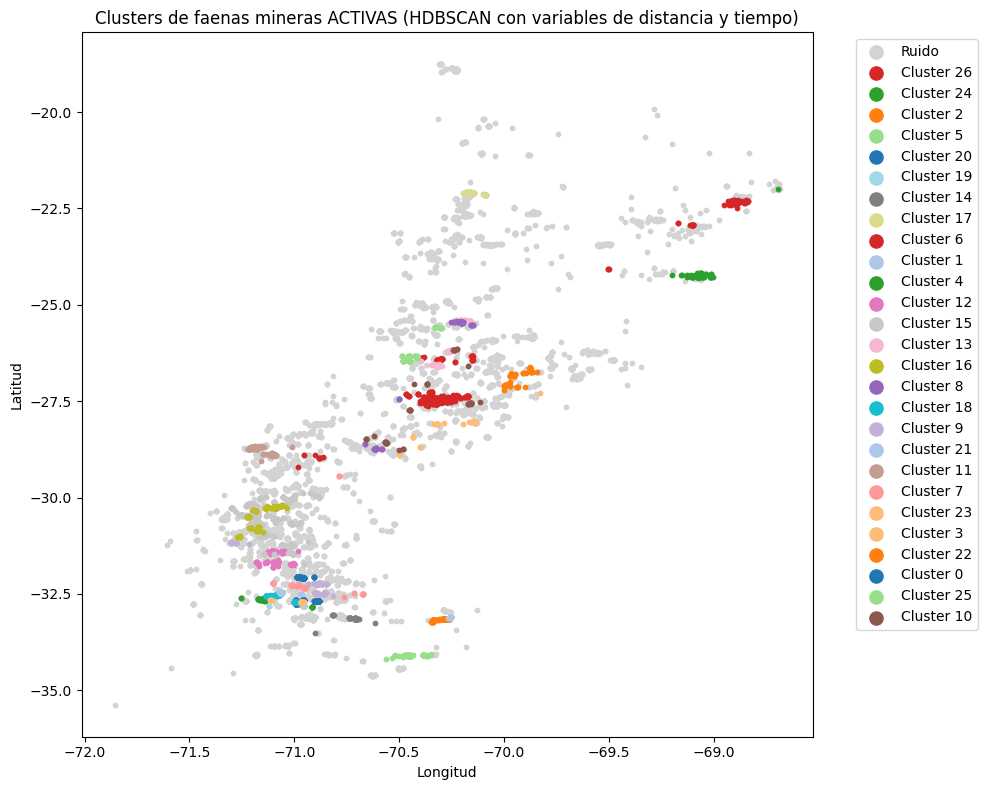

In [22]:
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# === Step 0: Filtrar faenas activas ===
df_active = df_faenas2[df_faenas2["Estado"] == "ACTIVA"].copy()

# === Step 1: Seleccionar variables relevantes ===
features = [
    'Longitud', 'Latitud', 'Cota',
     'Ciudad_Tiempo',
    'Est_Dist', 'Est_Tiempo',
    'Desal_Dist_km', 
    'puerto_Tiempo',
    'lt_dist_km'
]

# Eliminar valores faltantes o infinitos
df_active = df_active[features].replace([np.inf, -np.inf], np.nan).dropna().copy()

# === Step 2: Remover outliers mediante Z-score ===
z_scores = np.abs((df_active - df_active.mean()) / df_active.std())
mask = (z_scores < 3).all(axis=1)
df_clean = df_active.loc[mask].copy()

# === Step 3: Escalar y ponderar variables ===
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(df_clean[features])

# ⚖️ Pesos (ajustables según importancia)
weights = {
    'Longitud': 1.0,          # coordenadas espaciales
    'Latitud': 1.0,
    'Cota': 1.0,              # altura menor peso
    'Ciudad_Tiempo': 1.0,
    'Est_Dist': 1.0,          # accesibilidad ferroviaria
    'Est_Tiempo': 3.0,
    'Desal_Dist_km': 1.0,     # acceso hídrico
    'puerto_Tiempo': 1.0,
    'lt_dist_km': 3.0,        # acceso energético
}

# Aplicar pesos
for i, f in enumerate(features):
    coords_scaled[:, i] *= weights[f]

# === Step 4: Clustering con HDBSCAN ===
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=40,
    cluster_selection_epsilon=0.45,
    metric='euclidean'
)
df_clean['cluster'] = clusterer.fit_predict(coords_scaled)

# === Step 5: Mantener los 40 clusters más grandes ===
cluster_counts = df_clean['cluster'].value_counts()
top_clusters = cluster_counts.nlargest(40).index
df_clean['cluster'] = df_clean['cluster'].apply(lambda x: x if x in top_clusters else -1)

# === Step 6: Visualización ===
plt.figure(figsize=(10, 8))
cmap = plt.colormaps.get_cmap('tab20')  # ✅ nuevo estilo sin warning

for cluster in df_clean['cluster'].unique():
    mask = df_clean['cluster'] == cluster
    if cluster == -1:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color='lightgray', s=10, label='Ruido')
    else:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color=cmap(cluster % 20), s=10, label=f'Cluster {cluster}')

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Clusters de faenas mineras ACTIVAS (HDBSCAN con variables de distancia y tiempo)')
plt.legend(markerscale=3, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [23]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
# Assuming df_clean is already defined and populated

# 1. Set the default map to 'OpenStreetMap' to show cities/regions
m = folium.Map(location=[-25, -70], zoom_start=4.5, tiles='OpenStreetMap')

# 2. Add other tile layers you can switch to
folium.TileLayer(
    'Esri.WorldImagery',
    name='Satellite Imagery'
).add_to(m)

folium.TileLayer(
    'CartoDB positron',
    name='Light Map (Cities/Regions)'
).add_to(m)

# --- Your existing code for clusters ---
num_clusters = len(df_clean['cluster'].unique())
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {c: colors.to_hex(cmap(i % cmap.N)) for i, c in enumerate(sorted(df_clean['cluster'].unique()))}

for _, row in df_clean.iterrows():
    cluster_id = row['cluster']
    color = 'lightgray' if cluster_id == -1 else color_dict[cluster_id]
    popup = f"""
    <b>Cluster:</b> {cluster_id}<br>
    <b>Cota:</b> {row['Cota']:.0f}<br>
    <b>Tiempo Ciudad:</b> {row['Ciudad_Tiempo']:.1f} min<br>
    <b>Tiempo Puerto:</b> {row['puerto_Tiempo']:.1f} min<br>
    <b>Dist. Desaladora:</b> {row['Desal_Dist_km']:.1f} km
    """
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=3, color=color, fill=True, fill_opacity=0.8,
        popup=folium.Popup(popup, max_width=250)
    ).add_to(m)
# --- End of your existing code ---

# 3. Add a LayerControl to the map
folium.LayerControl().add_to(m)

# Save the new map (I've updated the name slightly)
m.save('mining_clusters_with_layers.html')
print("🗺️ Mapa interactivo guardado como 'mining_clusters_with_layers.html'")

C:\Users\artur\AppData\Local\Temp\ipykernel_16656\4092962241.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)


🗺️ Mapa interactivo guardado como 'mining_clusters_with_layers.html'


### Con opti y mas variables

In [47]:
df_faenas2 = pd.read_csv('Cluster/df_faenas_5.csv')

In [48]:
df = df_faenas2
df = df[df['Estado'] == "ACTIVA"]

#### Caso base

In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import DBSCAN
import hdbscan
from hdbscan.validity import validity_index
from tqdm import tqdm

# =====================================
# STEP 1 — CONFIG
# =====================================
clustering_features = [
    'Longitud', 'Latitud', 'Cota',
    'Ciudad_Tiempo', 'Est_Tiempo', 'Desal_Dist_km',
    'puerto_Tiempo', 'lt_tiempo_min'
]

base_weights = {
    'Longitud': 2.0, 'Latitud': 2.0, 'Cota': 0.7,
    'Ciudad_Tiempo': 1.5, 'Est_Tiempo': 0.8,
    'Desal_Dist_km': 1.0, 'puerto_Tiempo': 0.8, 'lt_tiempo_min': 0.8
}

weight_values = [0.2, 0.5, 0.8, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0]

# =====================================
# STEP 2 — CLEAN DATA
# =====================================
df_clean = df.dropna(subset=clustering_features).copy()

# --- Agrupar por empresa ---
KM_RADIUS = 1.0
EARTH_RADIUS_KM = 6371
eps_rad = KM_RADIUS / EARTH_RADIUS_KM

dbscan_grouper = DBSCAN(eps=eps_rad, min_samples=1, metric='haversine')

grouped_points = []
for empresa, group in df_clean.groupby("NombreEmpresa"):
    coords_rad = np.radians(group[['Latitud', 'Longitud']])
    sub_cluster_labels = dbscan_grouper.fit_predict(coords_rad)
    group['sub_cluster'] = sub_cluster_labels

    for label, subset in group.groupby('sub_cluster'):
        row = subset.mean(numeric_only=True).to_dict()
        row["NombreEmpresa"] = empresa
        row["FaenasCount"] = len(subset)
        grouped_points.append(row)

df_grouped = pd.DataFrame(grouped_points)
print(f"✅ Total grouped points: {len(df_grouped)}")

# =====================================
# STEP 3 — SCALING
# =====================================
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_grouped[clustering_features])

# =====================================
# STEP 4 — GRID SEARCH ON WEIGHTS
# =====================================
results = []

for feature in tqdm(clustering_features, desc="Testing feature weights"):
    for w in weight_values:
        weights = base_weights.copy()
        weights[feature] = w  # vary only one feature at a time

        # Apply weights
        X_weighted = X_scaled.copy()
        for i, f in enumerate(clustering_features):
            X_weighted[:, i] *= weights[f]

        # --- HDBSCAN clustering ---
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=15,
            min_samples=2,
            cluster_selection_epsilon=0.15,
            metric='euclidean'
        )
        labels = clusterer.fit_predict(X_weighted)

        # --- Compute DBCV ---
        mask = labels != -1
        if mask.sum() > 1 and len(np.unique(labels[mask])) > 1:
            try:
                dbcv = validity_index(X_weighted[mask], labels[mask], metric='euclidean')
            except:
                dbcv = np.nan
        else:
            dbcv = np.nan

        results.append({
            'feature': feature,
            'tested_weight': w,
            'dbcv': dbcv,
            'weights': weights,
            'n_clusters': len(set(labels)) - (1 if -1 in labels else 0)
        })

# =====================================
# STEP 5 — RESULTS SUMMARY
# =====================================
results_df = pd.DataFrame(results).sort_values('dbcv', ascending=False)
best_result = results_df.iloc[0]

print("\n🏆 === BEST RESULT ===")
print(f"Feature varied: {best_result['feature']}")
print(f"Tested weight: {best_result['tested_weight']}")
print(f"DBCV score: {best_result['dbcv']:.4f}")
print(f"Number of clusters: {best_result['n_clusters']}")
print("\n🔢 Weight configuration:")
for f, w in best_result['weights'].items():
    print(f"  {f}: {w}")

# =====================================
# STEP 6 — OPTIONAL: CLUSTER AGAIN WITH BEST WEIGHTS
# =====================================
X_best = X_scaled.copy()
for i, f in enumerate(clustering_features):
    X_best[:, i] *= best_result['weights'][f]

final_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=15,
    min_samples=2,
    cluster_selection_epsilon=0.15,
    metric='euclidean'
)
df_grouped['cluster'] = final_clusterer.fit_predict(X_best)

print("\n✅ Clustering complete with best weights.")
print(df_grouped['cluster'].value_counts())

# Optional: Save results
#results_df.to_csv("weight_search_results.csv", index=False)

✅ Total grouped points: 2281


Testing feature weights: 100%|██████████| 8/8 [00:20<00:00,  2.62s/it]


🏆 === BEST RESULT ===
Feature varied: Latitud
Tested weight: 5.0
DBCV score: 0.1850
Number of clusters: 34

🔢 Weight configuration:
  Longitud: 2.0
  Latitud: 5.0
  Cota: 0.7
  Ciudad_Tiempo: 1.5
  Est_Tiempo: 0.8
  Desal_Dist_km: 1.0
  puerto_Tiempo: 0.8
  lt_tiempo_min: 0.8

✅ Clustering complete with best weights.
cluster
-1     657
 16    451
 15    261
 33    107
 31     68
 24     53
 29     44
 4      42
 10     41
 25     34
 27     33
 30     30
 23     30
 22     28
 7      27
 13     27
 12     25
 6      24
 28     22
 11     22
 32     20
 5      20
 0      18
 21     18
 19     18
 14     17
 1      17
 20     17
 9      17
 17     17
 8      16
 18     15
 2      15
 26     15
 3      15
Name: count, dtype: int64


#### Optimizacion de pesos

In [50]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import DBSCAN
import hdbscan
from hdbscan.validity import validity_index
import optuna
from tqdm import tqdm

# =====================================
# STEP 1 — CONFIG
# =====================================
clustering_features = [
    'Longitud', 'Latitud', 'Cota',
    'Ciudad_Tiempo', 'Est_Tiempo', 'Desal_Dist_km',
    'puerto_Tiempo', 'lt_tiempo_min'
]

# Target cluster range
TARGET_MIN_CLUSTERS = 30
TARGET_MAX_CLUSTERS = 60

# =====================================
# STEP 2 — CLEAN & GROUP
# =====================================
df_clean = df.dropna(subset=clustering_features).copy()

KM_RADIUS = 1.0
EARTH_RADIUS_KM = 6371
eps_rad = KM_RADIUS / EARTH_RADIUS_KM

dbscan_grouper = DBSCAN(eps=eps_rad, min_samples=1, metric='haversine')

grouped_points = []
for empresa, group in df_clean.groupby("NombreEmpresa"):
    coords_rad = np.radians(group[['Latitud', 'Longitud']])
    sub_cluster_labels = dbscan_grouper.fit_predict(coords_rad)
    group['sub_cluster'] = sub_cluster_labels

    for label, subset in group.groupby('sub_cluster'):
        row = subset.mean(numeric_only=True).to_dict()
        row["NombreEmpresa"] = empresa
        row["FaenasCount"] = len(subset)
        grouped_points.append(row)

df_grouped = pd.DataFrame(grouped_points)
print(f"✅ Total grouped points: {len(df_grouped)}")

# =====================================
# STEP 3 — SCALING
# =====================================
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_grouped[clustering_features])

# =====================================
# STEP 4 — OPTUNA OBJECTIVE
# =====================================
def objective(trial):
    # Suggest weights for each feature
    weights = {
        'Longitud': trial.suggest_float('Longitud', 0.5, 5.0),
        'Latitud': trial.suggest_float('Latitud', 0.5, 5.0),
        'Cota': trial.suggest_float('Cota', 0.5, 2.0),
        'Ciudad_Tiempo': trial.suggest_float('Ciudad_Tiempo', 0.5, 2.0),
        'Est_Tiempo': trial.suggest_float('Est_Tiempo', 0.5, 2.0),
        'Desal_Dist_km': trial.suggest_float('Desal_Dist_km', 0.5, 2.0),
        'puerto_Tiempo': trial.suggest_float('puerto_Tiempo', 0.5, 2.0),
        'lt_tiempo_min': trial.suggest_float('lt_tiempo_min', 0.5, 2.0),
    }

    # Apply weights
    X_weighted = X_scaled.copy()
    for i, f in enumerate(clustering_features):
        X_weighted[:, i] *= weights[f]

    # Cluster
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=15,
        min_samples=2,
        cluster_selection_epsilon=0.15,
        metric='euclidean'
    )
    labels = clusterer.fit_predict(X_weighted)

    # Compute cluster count
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    # Skip if no clusters formed
    mask = labels != -1
    if mask.sum() <= 1 or n_clusters < 2:
        return -1.0

    # Compute DBCV
    try:
        dbcv = validity_index(X_weighted[mask], labels[mask], metric='euclidean')
    except:
        return -1.0

    # Soft penalty for cluster count deviation
    target_mid = (TARGET_MIN_CLUSTERS + TARGET_MAX_CLUSTERS) / 2
    penalty = 1 - abs(n_clusters - target_mid) / target_mid
    penalty = max(penalty, 0)

    return dbcv * penalty

# =====================================
# STEP 5 — RUN OPTIMIZATION
# =====================================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

# =====================================
# STEP 6 — PRINT BEST RESULT
# =====================================
print("\n🏆 === OPTIMIZATION COMPLETE ===")
print(f"Best DBCV (penalized): {study.best_value:.4f}")
print(f"Best weights:")
for k, v in study.best_params.items():
    print(f"  {k}: {v:.2f}")

# =====================================
# STEP 7 — CLUSTER WITH BEST WEIGHTS
# =====================================
X_best = X_scaled.copy()
for i, f in enumerate(clustering_features):
    X_best[:, i] *= study.best_params[f]

final_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=15,
    min_samples=2,
    cluster_selection_epsilon=0.15,
    metric='euclidean'
)
df_grouped['cluster'] = final_clusterer.fit_predict(X_best)

n_clusters_final = len(set(df_grouped['cluster'])) - (1 if -1 in df_grouped['cluster'].values else 0)
print(f"\n✅ Final number of clusters: {n_clusters_final}")
print(df_grouped['cluster'].value_counts())


[I 2025-11-04 14:42:29,379] A new study created in memory with name: no-name-7e9d4b11-de62-4059-9b47-3127d0074ca4


✅ Total grouped points: 2281


Best trial: 0. Best value: 0.0744195:   0%|          | 1/200 [00:00<00:56,  3.55it/s]

[I 2025-11-04 14:42:29,661] Trial 0 finished with value: 0.07441953927125877 and parameters: {'Longitud': 1.7395639584259126, 'Latitud': 4.783741463499069, 'Cota': 0.883803777789129, 'Ciudad_Tiempo': 1.7555963636032441, 'Est_Tiempo': 0.6702302464116408, 'Desal_Dist_km': 1.2566697902791435, 'puerto_Tiempo': 0.8495214505010331, 'lt_tiempo_min': 1.1392162837384767}. Best is trial 0 with value: 0.07441953927125877.


Best trial: 0. Best value: 0.0744195:   1%|          | 2/200 [00:00<00:55,  3.56it/s]

[I 2025-11-04 14:42:29,941] Trial 1 finished with value: 0.025522977251878343 and parameters: {'Longitud': 2.165336282307943, 'Latitud': 1.6837034459605378, 'Cota': 1.8636457030829483, 'Ciudad_Tiempo': 1.0331282911037192, 'Est_Tiempo': 1.8465634220396252, 'Desal_Dist_km': 1.3346746664378721, 'puerto_Tiempo': 1.1358921191036633, 'lt_tiempo_min': 1.8160218351405555}. Best is trial 0 with value: 0.07441953927125877.


Best trial: 0. Best value: 0.0744195:   2%|▏         | 3/200 [00:00<00:54,  3.59it/s]

[I 2025-11-04 14:42:30,217] Trial 2 finished with value: -0.013587910512257129 and parameters: {'Longitud': 1.3988260434611526, 'Latitud': 1.943477249681794, 'Cota': 1.0559897937781155, 'Ciudad_Tiempo': 1.3654574149724759, 'Est_Tiempo': 0.6778679762197212, 'Desal_Dist_km': 0.6540679698291725, 'puerto_Tiempo': 1.8963564431668463, 'lt_tiempo_min': 1.3340314164384717}. Best is trial 0 with value: 0.07441953927125877.


Best trial: 3. Best value: 0.18293:   2%|▏         | 4/200 [00:01<00:53,  3.68it/s]  

[I 2025-11-04 14:42:30,478] Trial 3 finished with value: 0.1829296346051952 and parameters: {'Longitud': 1.7000418766244074, 'Latitud': 4.648240837409844, 'Cota': 0.5020927540149782, 'Ciudad_Tiempo': 0.9679015774397264, 'Est_Tiempo': 1.465986236187233, 'Desal_Dist_km': 0.970090819801501, 'puerto_Tiempo': 1.0126371756051946, 'lt_tiempo_min': 1.1103040337890457}. Best is trial 3 with value: 0.1829296346051952.


Best trial: 4. Best value: 0.212317:   2%|▎         | 5/200 [00:01<00:51,  3.79it/s]

[I 2025-11-04 14:42:30,727] Trial 4 finished with value: 0.21231748884686352 and parameters: {'Longitud': 3.5761178079543545, 'Latitud': 4.681851266326717, 'Cota': 0.5543789690524601, 'Ciudad_Tiempo': 1.0005175242480073, 'Est_Tiempo': 1.8717387371654786, 'Desal_Dist_km': 1.1968137554506177, 'puerto_Tiempo': 0.7685209726652804, 'lt_tiempo_min': 1.0844548400278933}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:   3%|▎         | 6/200 [00:01<00:51,  3.79it/s]

[I 2025-11-04 14:42:30,992] Trial 5 finished with value: 0.06895468843412585 and parameters: {'Longitud': 3.4626270497555733, 'Latitud': 3.758628680087683, 'Cota': 1.6474648884717515, 'Ciudad_Tiempo': 0.5624357186366022, 'Est_Tiempo': 0.9074471810913454, 'Desal_Dist_km': 0.554591986171749, 'puerto_Tiempo': 1.1107469310970934, 'lt_tiempo_min': 1.5623634571471972}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:   4%|▎         | 7/200 [00:01<00:52,  3.66it/s]

[I 2025-11-04 14:42:31,285] Trial 6 finished with value: 0.13584525674505663 and parameters: {'Longitud': 0.8701856052310069, 'Latitud': 1.2795469597755789, 'Cota': 0.5256700217883858, 'Ciudad_Tiempo': 1.0317001443972844, 'Est_Tiempo': 1.5040237796072615, 'Desal_Dist_km': 1.2100849763278887, 'puerto_Tiempo': 1.45790868906284, 'lt_tiempo_min': 1.4804907798888038}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:   4%|▍         | 8/200 [00:02<00:53,  3.60it/s]

[I 2025-11-04 14:42:31,571] Trial 7 finished with value: 0.0360958280066191 and parameters: {'Longitud': 4.304797532589745, 'Latitud': 4.885146169460285, 'Cota': 1.8427972069805014, 'Ciudad_Tiempo': 0.92131469384988, 'Est_Tiempo': 1.8118508421906663, 'Desal_Dist_km': 1.233907327890716, 'puerto_Tiempo': 1.2342391148147946, 'lt_tiempo_min': 0.9108422730459488}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:   4%|▍         | 9/200 [00:02<00:53,  3.57it/s]

[I 2025-11-04 14:42:31,857] Trial 8 finished with value: 0.017012475401793608 and parameters: {'Longitud': 3.171677075806762, 'Latitud': 3.249672894353714, 'Cota': 1.289553166174325, 'Ciudad_Tiempo': 0.6555099195555698, 'Est_Tiempo': 1.2837596341776836, 'Desal_Dist_km': 1.9390925630669207, 'puerto_Tiempo': 0.5752852355275737, 'lt_tiempo_min': 1.6771912142856151}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:   5%|▌         | 10/200 [00:02<00:53,  3.57it/s]

[I 2025-11-04 14:42:32,137] Trial 9 finished with value: -0.047804722970263634 and parameters: {'Longitud': 2.96757893240814, 'Latitud': 1.402512657157863, 'Cota': 1.1309652659122038, 'Ciudad_Tiempo': 0.6392767394008996, 'Est_Tiempo': 0.605273566740425, 'Desal_Dist_km': 0.5147986874073498, 'puerto_Tiempo': 1.1758176599968335, 'lt_tiempo_min': 1.7055604014221906}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:   6%|▌         | 11/200 [00:03<00:52,  3.61it/s]

[I 2025-11-04 14:42:32,406] Trial 10 finished with value: 0.12134969378629346 and parameters: {'Longitud': 4.897234061222473, 'Latitud': 2.608696806011101, 'Cota': 0.807813829420369, 'Ciudad_Tiempo': 1.4338329667809422, 'Est_Tiempo': 1.9849896794613122, 'Desal_Dist_km': 1.7120161797553697, 'puerto_Tiempo': 0.5166502141604435, 'lt_tiempo_min': 0.5369828452284177}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:   6%|▌         | 12/200 [00:03<00:52,  3.58it/s]

[I 2025-11-04 14:42:32,693] Trial 11 finished with value: 0.07052174519825546 and parameters: {'Longitud': 2.2600338590737468, 'Latitud': 4.335134356640877, 'Cota': 0.5236453424531988, 'Ciudad_Tiempo': 1.1719916942387303, 'Est_Tiempo': 1.5066380626479376, 'Desal_Dist_km': 0.9485343235847097, 'puerto_Tiempo': 0.8263934653075533, 'lt_tiempo_min': 0.9081117833842536}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:   6%|▋         | 13/200 [00:03<00:52,  3.55it/s]

[I 2025-11-04 14:42:32,979] Trial 12 finished with value: -0.006203109333942952 and parameters: {'Longitud': 3.8543095526484707, 'Latitud': 3.944327620444188, 'Cota': 0.7034822297176797, 'Ciudad_Tiempo': 0.8053406547218476, 'Est_Tiempo': 1.5946136488572082, 'Desal_Dist_km': 0.9060198570146598, 'puerto_Tiempo': 0.8232317653592178, 'lt_tiempo_min': 1.0878179992573167}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:   7%|▋         | 14/200 [00:03<00:53,  3.50it/s]

[I 2025-11-04 14:42:33,275] Trial 13 finished with value: 0.045454970468273855 and parameters: {'Longitud': 0.6425103404265429, 'Latitud': 3.0901923867033663, 'Cota': 1.5120527408115643, 'Ciudad_Tiempo': 1.586637138819902, 'Est_Tiempo': 1.2053799559087084, 'Desal_Dist_km': 0.961281751705581, 'puerto_Tiempo': 1.5269957714702005, 'lt_tiempo_min': 0.6979086501977279}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:   8%|▊         | 15/200 [00:04<00:51,  3.57it/s]

[I 2025-11-04 14:42:33,541] Trial 14 finished with value: 0.08910859979680938 and parameters: {'Longitud': 2.6296731835380966, 'Latitud': 0.5142407033425682, 'Cota': 0.6982120984971969, 'Ciudad_Tiempo': 1.1771422279121306, 'Est_Tiempo': 1.216569904053714, 'Desal_Dist_km': 1.517217324678562, 'puerto_Tiempo': 0.9412256074620283, 'lt_tiempo_min': 1.2974447311819124}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:   8%|▊         | 16/200 [00:04<00:51,  3.54it/s]

[I 2025-11-04 14:42:33,827] Trial 15 finished with value: 0.05093734805855375 and parameters: {'Longitud': 1.4142771440356652, 'Latitud': 4.214456855591173, 'Cota': 0.943293948686343, 'Ciudad_Tiempo': 0.8687651467398554, 'Est_Tiempo': 1.6972717894925264, 'Desal_Dist_km': 0.7474375234337284, 'puerto_Tiempo': 1.4485623883182601, 'lt_tiempo_min': 0.9375788051143115}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:   8%|▊         | 17/200 [00:04<00:53,  3.41it/s]

[I 2025-11-04 14:42:34,148] Trial 16 finished with value: 0.0644323943771787 and parameters: {'Longitud': 3.841521477122603, 'Latitud': 3.5247764306610416, 'Cota': 0.5086786305813964, 'Ciudad_Tiempo': 1.8490983961931118, 'Est_Tiempo': 1.0082644460428947, 'Desal_Dist_km': 1.0699704314945735, 'puerto_Tiempo': 0.6617467845069845, 'lt_tiempo_min': 1.1050500714438696}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:   9%|▉         | 18/200 [00:05<00:53,  3.37it/s]

[I 2025-11-04 14:42:34,452] Trial 17 finished with value: 0.06315051956304081 and parameters: {'Longitud': 2.35632182012795, 'Latitud': 2.527349617001459, 'Cota': 1.3300225303380697, 'Ciudad_Tiempo': 1.293205018612829, 'Est_Tiempo': 1.382042776700956, 'Desal_Dist_km': 1.4515911799484322, 'puerto_Tiempo': 0.973842073484787, 'lt_tiempo_min': 0.8062875751364126}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:  10%|▉         | 19/200 [00:05<00:52,  3.42it/s]

[I 2025-11-04 14:42:34,733] Trial 18 finished with value: -0.01744145933569253 and parameters: {'Longitud': 4.647629730700773, 'Latitud': 4.510717848367797, 'Cota': 0.6862099159155259, 'Ciudad_Tiempo': 1.0223230654319544, 'Est_Tiempo': 1.976875125062435, 'Desal_Dist_km': 0.7809607910142977, 'puerto_Tiempo': 0.7026651950177308, 'lt_tiempo_min': 1.4093718867078917}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:  10%|█         | 20/200 [00:05<00:52,  3.45it/s]

[I 2025-11-04 14:42:35,018] Trial 19 finished with value: 0.028043024158000477 and parameters: {'Longitud': 3.7024479772596273, 'Latitud': 4.948689024012689, 'Cota': 1.1070128581194545, 'Ciudad_Tiempo': 0.7522597726582477, 'Est_Tiempo': 1.7231109500960753, 'Desal_Dist_km': 1.118126508302925, 'puerto_Tiempo': 1.7001595450141975, 'lt_tiempo_min': 1.2108296721360488}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:  10%|█         | 21/200 [00:05<00:51,  3.45it/s]

[I 2025-11-04 14:42:35,308] Trial 20 finished with value: 0.12344306971030751 and parameters: {'Longitud': 1.8512917207111532, 'Latitud': 4.085885225219726, 'Cota': 0.7799353710641002, 'Ciudad_Tiempo': 1.5246370828180813, 'Est_Tiempo': 1.0648887904214284, 'Desal_Dist_km': 1.5821482049520208, 'puerto_Tiempo': 1.03342687573853, 'lt_tiempo_min': 0.653452768168621}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:  11%|█         | 22/200 [00:06<00:50,  3.54it/s]

[I 2025-11-04 14:42:35,571] Trial 21 finished with value: 0.019062928195007676 and parameters: {'Longitud': 0.6096366196270915, 'Latitud': 0.6709799564685855, 'Cota': 0.5158282415281902, 'Ciudad_Tiempo': 1.0633418189736552, 'Est_Tiempo': 1.45656348191747, 'Desal_Dist_km': 1.0961634339445554, 'puerto_Tiempo': 1.3916451882914114, 'lt_tiempo_min': 1.9931721397681357}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:  12%|█▏        | 23/200 [00:06<00:50,  3.53it/s]

[I 2025-11-04 14:42:35,858] Trial 22 finished with value: 0.11778175335626241 and parameters: {'Longitud': 0.8069500218072198, 'Latitud': 1.335440147946238, 'Cota': 0.6210139573457241, 'Ciudad_Tiempo': 0.9524929825895246, 'Est_Tiempo': 1.5857455059277605, 'Desal_Dist_km': 1.3596776863858675, 'puerto_Tiempo': 1.3332454791474402, 'lt_tiempo_min': 1.4740438054217655}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:  12%|█▏        | 24/200 [00:06<00:50,  3.49it/s]

[I 2025-11-04 14:42:36,152] Trial 23 finished with value: 0.16444847434869111 and parameters: {'Longitud': 1.2882588644712885, 'Latitud': 2.1247691588807536, 'Cota': 0.6323492396305657, 'Ciudad_Tiempo': 1.1614984779275206, 'Est_Tiempo': 1.3608938253596718, 'Desal_Dist_km': 1.1967973501705917, 'puerto_Tiempo': 1.676977933843501, 'lt_tiempo_min': 1.0368935216879849}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:  12%|█▎        | 25/200 [00:07<00:51,  3.41it/s]

[I 2025-11-04 14:42:36,462] Trial 24 finished with value: 0.0021727572967380664 and parameters: {'Longitud': 1.1782048605282334, 'Latitud': 2.212752508813279, 'Cota': 0.9485522539167638, 'Ciudad_Tiempo': 1.2222565390770643, 'Est_Tiempo': 1.3885123749119277, 'Desal_Dist_km': 0.8377389485754575, 'puerto_Tiempo': 1.9985650902884444, 'lt_tiempo_min': 1.0117796428767873}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:  13%|█▎        | 26/200 [00:07<00:51,  3.37it/s]

[I 2025-11-04 14:42:36,767] Trial 25 finished with value: -0.009971854668181082 and parameters: {'Longitud': 2.768035470138649, 'Latitud': 3.0219034022102376, 'Cota': 0.6170252522456777, 'Ciudad_Tiempo': 1.1264302145816756, 'Est_Tiempo': 0.8417309628350207, 'Desal_Dist_km': 1.0414898370639138, 'puerto_Tiempo': 1.6166656171958582, 'lt_tiempo_min': 1.252151161105231}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:  14%|█▎        | 27/200 [00:07<00:50,  3.42it/s]

[I 2025-11-04 14:42:37,048] Trial 26 finished with value: 0.13371817787916096 and parameters: {'Longitud': 1.6051448235766432, 'Latitud': 4.525572497050672, 'Cota': 0.8172898899691474, 'Ciudad_Tiempo': 1.3119666213606211, 'Est_Tiempo': 1.2908512658860793, 'Desal_Dist_km': 1.706211711306057, 'puerto_Tiempo': 1.7651631846252265, 'lt_tiempo_min': 0.7963200311219749}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:  14%|█▍        | 28/200 [00:07<00:50,  3.42it/s]

[I 2025-11-04 14:42:37,339] Trial 27 finished with value: 0.061639945836792484 and parameters: {'Longitud': 4.266617799076583, 'Latitud': 3.4805181990514225, 'Cota': 0.6248218852758385, 'Ciudad_Tiempo': 0.7724699363592795, 'Est_Tiempo': 1.1004670844696118, 'Desal_Dist_km': 1.1710234200544059, 'puerto_Tiempo': 0.7481874788993209, 'lt_tiempo_min': 1.0297057959857654}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:  14%|█▍        | 29/200 [00:08<00:50,  3.40it/s]

[I 2025-11-04 14:42:37,638] Trial 28 finished with value: 0.04543268240843008 and parameters: {'Longitud': 1.2257061371992388, 'Latitud': 2.3435065808835525, 'Cota': 1.4644736546244506, 'Ciudad_Tiempo': 0.8641579439463201, 'Est_Tiempo': 1.7039646555834898, 'Desal_Dist_km': 1.3545234834579936, 'puerto_Tiempo': 1.3039977755653238, 'lt_tiempo_min': 1.1806389573236462}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:  15%|█▌        | 30/200 [00:08<00:48,  3.48it/s]

[I 2025-11-04 14:42:37,909] Trial 29 finished with value: 0.054596583736306534 and parameters: {'Longitud': 1.9277495937232065, 'Latitud': 4.52360455113251, 'Cota': 0.9301804054724567, 'Ciudad_Tiempo': 1.662246809667054, 'Est_Tiempo': 1.880501878798261, 'Desal_Dist_km': 1.0158401299732214, 'puerto_Tiempo': 0.9552818210031851, 'lt_tiempo_min': 0.8064020326825947}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:  16%|█▌        | 31/200 [00:08<00:49,  3.43it/s]

[I 2025-11-04 14:42:38,212] Trial 30 finished with value: 0.03102529993414102 and parameters: {'Longitud': 3.241781175216052, 'Latitud': 2.8718091140500137, 'Cota': 0.8702607716543898, 'Ciudad_Tiempo': 1.9822403321796456, 'Est_Tiempo': 1.589547116433174, 'Desal_Dist_km': 0.8851362004618222, 'puerto_Tiempo': 1.0553561107161271, 'lt_tiempo_min': 1.1542422951314872}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:  16%|█▌        | 32/200 [00:09<00:47,  3.51it/s]

[I 2025-11-04 14:42:38,481] Trial 31 finished with value: 0.1276058673774824 and parameters: {'Longitud': 1.0041165604800528, 'Latitud': 0.9588112118708765, 'Cota': 0.5891446465366158, 'Ciudad_Tiempo': 0.9915562580252005, 'Est_Tiempo': 1.4807263386826526, 'Desal_Dist_km': 1.240168439710089, 'puerto_Tiempo': 1.5547611012336098, 'lt_tiempo_min': 1.3915106956069008}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:  16%|█▋        | 33/200 [00:09<00:47,  3.52it/s]

[I 2025-11-04 14:42:38,763] Trial 32 finished with value: 0.10850164413233444 and parameters: {'Longitud': 0.9908135776461156, 'Latitud': 1.7781948148350384, 'Cota': 0.7467096715967668, 'Ciudad_Tiempo': 1.0971209628077407, 'Est_Tiempo': 1.337433099018968, 'Desal_Dist_km': 1.3141924172791426, 'puerto_Tiempo': 1.765899329513624, 'lt_tiempo_min': 1.510170610416671}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:  17%|█▋        | 34/200 [00:09<00:47,  3.48it/s]

[I 2025-11-04 14:42:39,057] Trial 33 finished with value: 0.09012034552621834 and parameters: {'Longitud': 1.6131049323511701, 'Latitud': 1.3639378507644648, 'Cota': 0.5939692768840312, 'Ciudad_Tiempo': 1.4003550064366757, 'Est_Tiempo': 1.8065945533337968, 'Desal_Dist_km': 1.1814000529678965, 'puerto_Tiempo': 1.6510791946947387, 'lt_tiempo_min': 0.996922721764423}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:  18%|█▊        | 35/200 [00:10<00:49,  3.31it/s]

[I 2025-11-04 14:42:39,393] Trial 34 finished with value: -0.004581813856615424 and parameters: {'Longitud': 2.042189071411783, 'Latitud': 1.9620122933641848, 'Cota': 0.545021477379024, 'Ciudad_Tiempo': 1.2553048794253168, 'Est_Tiempo': 1.1523872447980341, 'Desal_Dist_km': 1.407992719565108, 'puerto_Tiempo': 1.8355392451798056, 'lt_tiempo_min': 1.3137852688862752}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:  18%|█▊        | 36/200 [00:10<00:50,  3.26it/s]

[I 2025-11-04 14:42:39,711] Trial 35 finished with value: 0.07857936466385568 and parameters: {'Longitud': 1.4880144654869478, 'Latitud': 1.1671965748657853, 'Cota': 0.6995943930216909, 'Ciudad_Tiempo': 0.9075337343501679, 'Est_Tiempo': 1.525886611221752, 'Desal_Dist_km': 1.250579828747107, 'puerto_Tiempo': 1.4923906741705235, 'lt_tiempo_min': 1.0901048669857647}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:  18%|█▊        | 37/200 [00:10<00:49,  3.32it/s]

[I 2025-11-04 14:42:40,000] Trial 36 finished with value: 0.0020403005684429044 and parameters: {'Longitud': 2.483711465907883, 'Latitud': 1.619412768338854, 'Cota': 1.9531135600822362, 'Ciudad_Tiempo': 1.058876656067619, 'Est_Tiempo': 1.4372229121589692, 'Desal_Dist_km': 0.6525605393814896, 'puerto_Tiempo': 1.3926983142736222, 'lt_tiempo_min': 1.5586873784002226}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:  19%|█▉        | 38/200 [00:10<00:47,  3.41it/s]

[I 2025-11-04 14:42:40,275] Trial 37 finished with value: 0.004829037983234829 and parameters: {'Longitud': 0.5217349264506836, 'Latitud': 2.1181202945008955, 'Cota': 1.0482715493418722, 'Ciudad_Tiempo': 0.6781308208920529, 'Est_Tiempo': 1.631628456504344, 'Desal_Dist_km': 1.1595896259564524, 'puerto_Tiempo': 1.173541759433296, 'lt_tiempo_min': 1.6606277716022366}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:  20%|█▉        | 39/200 [00:12<01:27,  1.85it/s]

[I 2025-11-04 14:42:41,393] Trial 38 finished with value: -0.011366467401592674 and parameters: {'Longitud': 1.2260090459883677, 'Latitud': 0.9246019233541167, 'Cota': 0.8700204024687805, 'Ciudad_Tiempo': 0.9724002571617113, 'Est_Tiempo': 1.8669307606088819, 'Desal_Dist_km': 0.9995378227383085, 'puerto_Tiempo': 1.2302526194821364, 'lt_tiempo_min': 1.8388233378399788}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:  20%|██        | 40/200 [00:12<01:13,  2.17it/s]

[I 2025-11-04 14:42:41,669] Trial 39 finished with value: 0.07041772957167369 and parameters: {'Longitud': 0.8803497482866414, 'Latitud': 4.791645411992549, 'Cota': 1.6759559332274825, 'Ciudad_Tiempo': 0.5492213758858667, 'Est_Tiempo': 0.78825333232693, 'Desal_Dist_km': 1.3011201950017965, 'puerto_Tiempo': 0.8854280233953495, 'lt_tiempo_min': 1.3886670763261704}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:  20%|██        | 41/200 [00:12<01:07,  2.34it/s]

[I 2025-11-04 14:42:42,015] Trial 40 finished with value: 0.05522586080409873 and parameters: {'Longitud': 3.453720830673206, 'Latitud': 1.9120969588674495, 'Cota': 0.6647961501353672, 'Ciudad_Tiempo': 1.1366321097112633, 'Est_Tiempo': 1.7599850418363725, 'Desal_Dist_km': 1.6196297921518283, 'puerto_Tiempo': 1.0707403052518982, 'lt_tiempo_min': 1.2517892572908247}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:  21%|██        | 42/200 [00:12<01:01,  2.58it/s]

[I 2025-11-04 14:42:42,312] Trial 41 finished with value: 0.15362089019036707 and parameters: {'Longitud': 1.6470114306149346, 'Latitud': 4.529874440819268, 'Cota': 0.7964812185381183, 'Ciudad_Tiempo': 1.329632289441991, 'Est_Tiempo': 1.3396200814856505, 'Desal_Dist_km': 1.8912534383392887, 'puerto_Tiempo': 1.7767615418592912, 'lt_tiempo_min': 0.8285661772515562}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:  22%|██▏       | 43/200 [00:13<00:56,  2.76it/s]

[I 2025-11-04 14:42:42,614] Trial 42 finished with value: 0.08618889708512818 and parameters: {'Longitud': 1.3173946413282094, 'Latitud': 3.8593474837707933, 'Cota': 0.5113864743324866, 'Ciudad_Tiempo': 1.4554822006611756, 'Est_Tiempo': 1.2965939112203602, 'Desal_Dist_km': 1.9263045442343931, 'puerto_Tiempo': 1.9389430743375116, 'lt_tiempo_min': 0.8905480431710456}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:  22%|██▏       | 44/200 [00:13<00:52,  2.95it/s]

[I 2025-11-04 14:42:42,899] Trial 43 finished with value: 0.16864495660476683 and parameters: {'Longitud': 1.73146642997097, 'Latitud': 4.651968800048624, 'Cota': 0.7698256378470445, 'Ciudad_Tiempo': 1.2093306148181588, 'Est_Tiempo': 0.5215416953453502, 'Desal_Dist_km': 1.7819845585045955, 'puerto_Tiempo': 1.8511872353154852, 'lt_tiempo_min': 0.7350001247230133}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 4. Best value: 0.212317:  22%|██▎       | 45/200 [00:13<00:50,  3.08it/s]

[I 2025-11-04 14:42:43,191] Trial 44 finished with value: 0.17079902282932355 and parameters: {'Longitud': 2.147197801940055, 'Latitud': 4.675132572141758, 'Cota': 0.7835227379820655, 'Ciudad_Tiempo': 1.3462243736791326, 'Est_Tiempo': 0.9064612871228837, 'Desal_Dist_km': 1.8543340630081744, 'puerto_Tiempo': 1.8350716472090383, 'lt_tiempo_min': 0.5523896610083051}. Best is trial 4 with value: 0.21231748884686352.


Best trial: 45. Best value: 0.222471:  23%|██▎       | 46/200 [00:14<00:48,  3.18it/s]

[I 2025-11-04 14:42:43,483] Trial 45 finished with value: 0.22247135173408186 and parameters: {'Longitud': 2.096997154643163, 'Latitud': 4.690329649140033, 'Cota': 0.7469003473040097, 'Ciudad_Tiempo': 1.220855951165331, 'Est_Tiempo': 0.5754387446642202, 'Desal_Dist_km': 1.8351415847795947, 'puerto_Tiempo': 1.8777207287744917, 'lt_tiempo_min': 0.6009205466637664}. Best is trial 45 with value: 0.22247135173408186.


Best trial: 45. Best value: 0.222471:  24%|██▎       | 47/200 [00:14<00:46,  3.27it/s]

[I 2025-11-04 14:42:43,767] Trial 46 finished with value: 0.2099566683929608 and parameters: {'Longitud': 2.135726919681091, 'Latitud': 4.715160799691806, 'Cota': 1.2121096253317296, 'Ciudad_Tiempo': 1.4634305664424165, 'Est_Tiempo': 0.5014289779449742, 'Desal_Dist_km': 1.8230590347840607, 'puerto_Tiempo': 1.8731295105689303, 'lt_tiempo_min': 0.5337257026657317}. Best is trial 45 with value: 0.22247135173408186.


Best trial: 45. Best value: 0.222471:  24%|██▍       | 48/200 [00:14<00:44,  3.44it/s]

[I 2025-11-04 14:42:44,022] Trial 47 finished with value: 0.20824008669995947 and parameters: {'Longitud': 2.1548235684258157, 'Latitud': 4.996716767048575, 'Cota': 1.2588481672836345, 'Ciudad_Tiempo': 1.531780665950246, 'Est_Tiempo': 0.6922342989841561, 'Desal_Dist_km': 1.8755447718295313, 'puerto_Tiempo': 1.9702540748521709, 'lt_tiempo_min': 0.5041319257965152}. Best is trial 45 with value: 0.22247135173408186.


Best trial: 45. Best value: 0.222471:  24%|██▍       | 49/200 [00:14<00:42,  3.55it/s]

[I 2025-11-04 14:42:44,282] Trial 48 finished with value: 0.1788588260799232 and parameters: {'Longitud': 2.812575740199313, 'Latitud': 4.991827852188694, 'Cota': 1.2209089115048894, 'Ciudad_Tiempo': 1.5905284899197594, 'Est_Tiempo': 0.6396456025163403, 'Desal_Dist_km': 1.8027033446253005, 'puerto_Tiempo': 1.992992921664049, 'lt_tiempo_min': 0.6013364662827896}. Best is trial 45 with value: 0.22247135173408186.


Best trial: 45. Best value: 0.222471:  25%|██▌       | 50/200 [00:15<00:41,  3.64it/s]

[I 2025-11-04 14:42:44,540] Trial 49 finished with value: 0.19376357074558473 and parameters: {'Longitud': 2.397254467526375, 'Latitud': 4.282215543453427, 'Cota': 1.3907927325650236, 'Ciudad_Tiempo': 1.7002398612485774, 'Est_Tiempo': 0.7222648314621701, 'Desal_Dist_km': 1.9947864611006212, 'puerto_Tiempo': 1.9232353924520607, 'lt_tiempo_min': 0.5123131256323536}. Best is trial 45 with value: 0.22247135173408186.


Best trial: 45. Best value: 0.222471:  26%|██▌       | 51/200 [00:15<00:42,  3.52it/s]

[I 2025-11-04 14:42:44,846] Trial 50 finished with value: 0.17954224094339213 and parameters: {'Longitud': 2.5188648050216065, 'Latitud': 4.249517731027732, 'Cota': 1.372137307635324, 'Ciudad_Tiempo': 1.6943915605956648, 'Est_Tiempo': 0.7015857240438792, 'Desal_Dist_km': 1.9449827232371832, 'puerto_Tiempo': 1.927510855126882, 'lt_tiempo_min': 0.5058009057614019}. Best is trial 45 with value: 0.22247135173408186.


Best trial: 45. Best value: 0.222471:  26%|██▌       | 52/200 [00:15<00:42,  3.51it/s]

[I 2025-11-04 14:42:45,134] Trial 51 finished with value: 0.12783795041135373 and parameters: {'Longitud': 2.2569995956456324, 'Latitud': 4.315180324380361, 'Cota': 1.2058622115469477, 'Ciudad_Tiempo': 1.8508801551982739, 'Est_Tiempo': 0.537861200856347, 'Desal_Dist_km': 1.99134376767266, 'puerto_Tiempo': 1.873632506127281, 'lt_tiempo_min': 0.5965591390994857}. Best is trial 45 with value: 0.22247135173408186.


Best trial: 45. Best value: 0.222471:  26%|██▋       | 53/200 [00:16<00:42,  3.45it/s]

[I 2025-11-04 14:42:45,436] Trial 52 finished with value: 0.14370928292451146 and parameters: {'Longitud': 2.9581551034849465, 'Latitud': 4.033335700167871, 'Cota': 1.4184789360362022, 'Ciudad_Tiempo': 1.4794784555054359, 'Est_Tiempo': 0.7407207526511982, 'Desal_Dist_km': 1.684579921815773, 'puerto_Tiempo': 1.9250277780880896, 'lt_tiempo_min': 0.6524661928884042}. Best is trial 45 with value: 0.22247135173408186.


Best trial: 45. Best value: 0.222471:  27%|██▋       | 54/200 [00:16<00:42,  3.47it/s]

[I 2025-11-04 14:42:45,720] Trial 53 finished with value: 0.10568425388945109 and parameters: {'Longitud': 2.0249878086278947, 'Latitud': 4.773251848426431, 'Cota': 1.6830959097606986, 'Ciudad_Tiempo': 1.5783249178397019, 'Est_Tiempo': 0.5851796345514817, 'Desal_Dist_km': 1.8340881756989282, 'puerto_Tiempo': 0.6124578102381163, 'lt_tiempo_min': 0.5042819182161695}. Best is trial 45 with value: 0.22247135173408186.


Best trial: 45. Best value: 0.222471:  28%|██▊       | 55/200 [00:16<00:41,  3.47it/s]

[I 2025-11-04 14:42:46,008] Trial 54 finished with value: 0.1494785216012276 and parameters: {'Longitud': 2.391533406612197, 'Latitud': 4.843796005282905, 'Cota': 1.277947325719093, 'Ciudad_Tiempo': 1.717077459492275, 'Est_Tiempo': 0.6148539782580238, 'Desal_Dist_km': 1.9948505412600788, 'puerto_Tiempo': 0.7782864050652822, 'lt_tiempo_min': 0.5915688092485876}. Best is trial 45 with value: 0.22247135173408186.


Best trial: 45. Best value: 0.222471:  28%|██▊       | 56/200 [00:16<00:41,  3.49it/s]

[I 2025-11-04 14:42:46,290] Trial 55 finished with value: 0.14319988723091015 and parameters: {'Longitud': 1.8647816716747407, 'Latitud': 4.404064267670067, 'Cota': 1.1440171216845125, 'Ciudad_Tiempo': 1.5455657773329534, 'Est_Tiempo': 0.7085828675015896, 'Desal_Dist_km': 1.7602461574807855, 'puerto_Tiempo': 1.7329737399546508, 'lt_tiempo_min': 0.707884108805297}. Best is trial 45 with value: 0.22247135173408186.


Best trial: 45. Best value: 0.222471:  28%|██▊       | 57/200 [00:17<00:41,  3.44it/s]

[I 2025-11-04 14:42:46,592] Trial 56 finished with value: 0.06442564956955546 and parameters: {'Longitud': 2.6152605104352413, 'Latitud': 3.6534283847130107, 'Cota': 1.5038451378417967, 'Ciudad_Tiempo': 1.4052026963883502, 'Est_Tiempo': 0.5074518676225294, 'Desal_Dist_km': 1.5175988680122252, 'puerto_Tiempo': 0.5282344206434488, 'lt_tiempo_min': 0.6515909891239442}. Best is trial 45 with value: 0.22247135173408186.


Best trial: 45. Best value: 0.222471:  29%|██▉       | 58/200 [00:17<00:41,  3.45it/s]

[I 2025-11-04 14:42:46,879] Trial 57 finished with value: 0.12897548985430787 and parameters: {'Longitud': 2.1678367476809024, 'Latitud': 4.656944299342411, 'Cota': 1.026610030115233, 'Ciudad_Tiempo': 1.824014903157885, 'Est_Tiempo': 0.9755543988490402, 'Desal_Dist_km': 1.885213770538701, 'puerto_Tiempo': 0.8845402508415317, 'lt_tiempo_min': 0.748595476771025}. Best is trial 45 with value: 0.22247135173408186.


Best trial: 45. Best value: 0.222471:  30%|██▉       | 59/200 [00:17<00:40,  3.45it/s]

[I 2025-11-04 14:42:47,169] Trial 58 finished with value: 0.1282569438778189 and parameters: {'Longitud': 2.9823196998612556, 'Latitud': 4.117984724252012, 'Cota': 1.5720466585072423, 'Ciudad_Tiempo': 1.7880385698989532, 'Est_Tiempo': 0.7896312447948153, 'Desal_Dist_km': 1.6625483968511183, 'puerto_Tiempo': 1.7963815340478542, 'lt_tiempo_min': 0.5611872220930055}. Best is trial 45 with value: 0.22247135173408186.


Best trial: 45. Best value: 0.222471:  30%|███       | 60/200 [00:18<00:41,  3.37it/s]

[I 2025-11-04 14:42:47,483] Trial 59 finished with value: 0.14739444864451212 and parameters: {'Longitud': 4.116507057277311, 'Latitud': 4.9864981308808805, 'Cota': 1.3257758066429983, 'Ciudad_Tiempo': 1.664615830771451, 'Est_Tiempo': 0.5722707658302357, 'Desal_Dist_km': 1.7329925484226243, 'puerto_Tiempo': 1.958204230169257, 'lt_tiempo_min': 0.6530360377203159}. Best is trial 45 with value: 0.22247135173408186.


Best trial: 45. Best value: 0.222471:  30%|███       | 61/200 [00:18<00:39,  3.54it/s]

[I 2025-11-04 14:42:47,731] Trial 60 finished with value: 0.1496924750753123 and parameters: {'Longitud': 2.297072413529662, 'Latitud': 4.402780888061283, 'Cota': 1.3927659484335717, 'Ciudad_Tiempo': 1.4953408891220668, 'Est_Tiempo': 0.683031498644956, 'Desal_Dist_km': 1.582250635822545, 'puerto_Tiempo': 1.8935296125888912, 'lt_tiempo_min': 0.5014631607470765}. Best is trial 45 with value: 0.22247135173408186.


Best trial: 61. Best value: 0.223063:  31%|███       | 62/200 [00:18<00:38,  3.63it/s]

[I 2025-11-04 14:42:47,990] Trial 61 finished with value: 0.22306295576370083 and parameters: {'Longitud': 2.510777866926722, 'Latitud': 4.726775486508694, 'Cota': 1.3404063932841859, 'Ciudad_Tiempo': 1.6434109580488545, 'Est_Tiempo': 0.6445038389631748, 'Desal_Dist_km': 1.9338224951205938, 'puerto_Tiempo': 1.924902199683147, 'lt_tiempo_min': 0.5456505837341535}. Best is trial 61 with value: 0.22306295576370083.


Best trial: 61. Best value: 0.223063:  32%|███▏      | 63/200 [00:18<00:36,  3.70it/s]

[I 2025-11-04 14:42:48,248] Trial 62 finished with value: 0.18137841094550908 and parameters: {'Longitud': 2.683350569302528, 'Latitud': 4.761151231246641, 'Cota': 1.7641472283390645, 'Ciudad_Tiempo': 1.6175028727973235, 'Est_Tiempo': 0.6234903438024127, 'Desal_Dist_km': 1.9206621789750045, 'puerto_Tiempo': 1.9688749160805656, 'lt_tiempo_min': 0.6067830406489445}. Best is trial 61 with value: 0.22306295576370083.


Best trial: 61. Best value: 0.223063:  32%|███▏      | 64/200 [00:19<00:37,  3.65it/s]

[I 2025-11-04 14:42:48,530] Trial 63 finished with value: 0.16546593620100863 and parameters: {'Longitud': 2.074379696836353, 'Latitud': 4.612020131232797, 'Cota': 1.592291465861238, 'Ciudad_Tiempo': 1.7546811056463536, 'Est_Tiempo': 0.8654691066850086, 'Desal_Dist_km': 1.8458957609561863, 'puerto_Tiempo': 1.8897297831402857, 'lt_tiempo_min': 0.5536614706542791}. Best is trial 61 with value: 0.22306295576370083.


Best trial: 61. Best value: 0.223063:  32%|███▎      | 65/200 [00:19<00:37,  3.60it/s]

[I 2025-11-04 14:42:48,817] Trial 64 finished with value: 0.16685073294818645 and parameters: {'Longitud': 2.5079148387180474, 'Latitud': 4.837236773734691, 'Cota': 1.2041430385677834, 'Ciudad_Tiempo': 1.9580691714357144, 'Est_Tiempo': 0.7775980585387968, 'Desal_Dist_km': 1.9633855019084496, 'puerto_Tiempo': 1.5924356843111047, 'lt_tiempo_min': 0.9532415007874203}. Best is trial 61 with value: 0.22306295576370083.


Best trial: 61. Best value: 0.223063:  33%|███▎      | 66/200 [00:19<00:38,  3.52it/s]

[I 2025-11-04 14:42:49,116] Trial 65 finished with value: 0.04619033366572194 and parameters: {'Longitud': 1.854000093899008, 'Latitud': 4.151669862408562, 'Cota': 1.3229742662627142, 'Ciudad_Tiempo': 1.9112672325185551, 'Est_Tiempo': 0.5562122009918938, 'Desal_Dist_km': 1.8729481386691815, 'puerto_Tiempo': 1.0091480075651418, 'lt_tiempo_min': 0.8570055277320783}. Best is trial 61 with value: 0.22306295576370083.


Best trial: 61. Best value: 0.223063:  34%|███▎      | 67/200 [00:20<00:38,  3.49it/s]

[I 2025-11-04 14:42:49,408] Trial 66 finished with value: 0.09223116232242688 and parameters: {'Longitud': 3.153653874364047, 'Latitud': 4.372092441245551, 'Cota': 1.4362212441061941, 'Ciudad_Tiempo': 0.8464357969660684, 'Est_Tiempo': 0.664848993369569, 'Desal_Dist_km': 1.7988262144189537, 'puerto_Tiempo': 1.8123664750344994, 'lt_tiempo_min': 0.6851083339173981}. Best is trial 61 with value: 0.22306295576370083.


Best trial: 61. Best value: 0.223063:  34%|███▍      | 68/200 [00:20<00:37,  3.54it/s]

[I 2025-11-04 14:42:49,680] Trial 67 finished with value: 0.13082310826715174 and parameters: {'Longitud': 2.3777488037653765, 'Latitud': 4.48641767696261, 'Cota': 1.1415846868465656, 'Ciudad_Tiempo': 1.632827680781648, 'Est_Tiempo': 1.922100694390101, 'Desal_Dist_km': 1.7318563191988712, 'puerto_Tiempo': 0.6738266958085157, 'lt_tiempo_min': 0.7551381267131765}. Best is trial 61 with value: 0.22306295576370083.


Best trial: 61. Best value: 0.223063:  34%|███▍      | 69/200 [00:20<00:38,  3.43it/s]

[I 2025-11-04 14:42:49,993] Trial 68 finished with value: 0.10502624747712903 and parameters: {'Longitud': 1.9781993129735072, 'Latitud': 3.929526207590158, 'Cota': 0.9914124131743889, 'Ciudad_Tiempo': 1.2724022255568652, 'Est_Tiempo': 0.7408823237999111, 'Desal_Dist_km': 0.9458858400349528, 'puerto_Tiempo': 1.715277185713292, 'lt_tiempo_min': 0.6240153972062524}. Best is trial 61 with value: 0.22306295576370083.


Best trial: 61. Best value: 0.223063:  35%|███▌      | 70/200 [00:20<00:37,  3.47it/s]

[I 2025-11-04 14:42:50,273] Trial 69 finished with value: 0.12572661873616983 and parameters: {'Longitud': 2.2050155971734546, 'Latitud': 4.934381946010978, 'Cota': 1.252127957731151, 'Ciudad_Tiempo': 1.5613216828634164, 'Est_Tiempo': 0.8561939309196132, 'Desal_Dist_km': 1.817058168864989, 'puerto_Tiempo': 1.1382229695769377, 'lt_tiempo_min': 0.5634822203702056}. Best is trial 61 with value: 0.22306295576370083.


Best trial: 61. Best value: 0.223063:  36%|███▌      | 71/200 [00:21<00:37,  3.47it/s]

[I 2025-11-04 14:42:50,561] Trial 70 finished with value: 0.09217768654719272 and parameters: {'Longitud': 2.8775752909806096, 'Latitud': 4.735703773600733, 'Cota': 0.5567566648244776, 'Ciudad_Tiempo': 1.3767119115753703, 'Est_Tiempo': 0.970267463036786, 'Desal_Dist_km': 0.7929971290248841, 'puerto_Tiempo': 1.9049449729816625, 'lt_tiempo_min': 0.68340528706974}. Best is trial 61 with value: 0.22306295576370083.


Best trial: 61. Best value: 0.223063:  36%|███▌      | 72/200 [00:21<00:36,  3.48it/s]

[I 2025-11-04 14:42:50,846] Trial 71 finished with value: 0.15863595595488164 and parameters: {'Longitud': 2.71513773811326, 'Latitud': 4.77157195293099, 'Cota': 1.7737480269900745, 'Ciudad_Tiempo': 1.640719558601097, 'Est_Tiempo': 0.6227294513029497, 'Desal_Dist_km': 1.9024263681600544, 'puerto_Tiempo': 1.996664230584448, 'lt_tiempo_min': 0.6137850796570269}. Best is trial 61 with value: 0.22306295576370083.


Best trial: 61. Best value: 0.223063:  36%|███▋      | 73/200 [00:21<00:37,  3.43it/s]

[I 2025-11-04 14:42:51,149] Trial 72 finished with value: 0.10828118110597817 and parameters: {'Longitud': 3.1320984061568944, 'Latitud': 4.238457637806955, 'Cota': 1.8144895228504785, 'Ciudad_Tiempo': 1.5148015148078409, 'Est_Tiempo': 0.5030067814435781, 'Desal_Dist_km': 1.940138498782075, 'puerto_Tiempo': 1.9638275767433497, 'lt_tiempo_min': 0.5318546561918726}. Best is trial 61 with value: 0.22306295576370083.


Best trial: 61. Best value: 0.223063:  37%|███▋      | 74/200 [00:22<00:36,  3.45it/s]

[I 2025-11-04 14:42:51,434] Trial 73 finished with value: 0.15324924039002488 and parameters: {'Longitud': 2.663543561578031, 'Latitud': 4.593084541453225, 'Cota': 1.9586168333080833, 'Ciudad_Tiempo': 1.6182490161507623, 'Est_Tiempo': 0.6431459149042884, 'Desal_Dist_km': 1.9722955513108686, 'puerto_Tiempo': 1.9587685319325046, 'lt_tiempo_min': 0.5783462954439857}. Best is trial 61 with value: 0.22306295576370083.


Best trial: 61. Best value: 0.223063:  38%|███▊      | 75/200 [00:22<00:36,  3.42it/s]

[I 2025-11-04 14:42:51,734] Trial 74 finished with value: 0.12559395177432806 and parameters: {'Longitud': 3.4006625302087254, 'Latitud': 4.867244479688858, 'Cota': 1.1093356177635583, 'Ciudad_Tiempo': 1.7469564178703116, 'Est_Tiempo': 0.5931755513568826, 'Desal_Dist_km': 1.9212938734442158, 'puerto_Tiempo': 1.8545962402162772, 'lt_tiempo_min': 0.7733013521558519}. Best is trial 61 with value: 0.22306295576370083.


Best trial: 61. Best value: 0.223063:  38%|███▊      | 76/200 [00:22<00:36,  3.42it/s]

[I 2025-11-04 14:42:52,025] Trial 75 finished with value: 0.02607313245418325 and parameters: {'Longitud': 4.6256097866228005, 'Latitud': 4.445838644585275, 'Cota': 1.9101480399823298, 'Ciudad_Tiempo': 1.4408963124637155, 'Est_Tiempo': 0.7236350058831551, 'Desal_Dist_km': 1.127746430133114, 'puerto_Tiempo': 1.7423451142213728, 'lt_tiempo_min': 1.1283733935163864}. Best is trial 61 with value: 0.22306295576370083.


Best trial: 61. Best value: 0.223063:  38%|███▊      | 77/200 [00:22<00:34,  3.53it/s]

[I 2025-11-04 14:42:52,287] Trial 76 finished with value: 0.08133935426586204 and parameters: {'Longitud': 1.7198693506040288, 'Latitud': 4.679910006462933, 'Cota': 1.7493497734380667, 'Ciudad_Tiempo': 0.9209978004369002, 'Est_Tiempo': 0.5542114224642746, 'Desal_Dist_km': 0.7162611618799868, 'puerto_Tiempo': 1.8159254729697138, 'lt_tiempo_min': 0.7151739506940313}. Best is trial 61 with value: 0.22306295576370083.


Best trial: 61. Best value: 0.223063:  39%|███▉      | 78/200 [00:23<00:34,  3.50it/s]

[I 2025-11-04 14:42:52,578] Trial 77 finished with value: 0.11048677494649446 and parameters: {'Longitud': 1.4670374184618025, 'Latitud': 4.90083597352423, 'Cota': 1.4828916490827735, 'Ciudad_Tiempo': 1.006229553542925, 'Est_Tiempo': 0.6747260390410331, 'Desal_Dist_km': 1.7664352099988285, 'puerto_Tiempo': 1.8763849784887123, 'lt_tiempo_min': 1.1965112301878005}. Best is trial 61 with value: 0.22306295576370083.


Best trial: 61. Best value: 0.223063:  40%|███▉      | 79/200 [00:23<00:34,  3.46it/s]

[I 2025-11-04 14:42:52,874] Trial 78 finished with value: 0.05373884525435191 and parameters: {'Longitud': 3.648119804179694, 'Latitud': 4.565705428215335, 'Cota': 1.567892240660446, 'Ciudad_Tiempo': 1.6925781410641514, 'Est_Tiempo': 1.648288332053713, 'Desal_Dist_km': 1.4819849621354433, 'puerto_Tiempo': 1.6599109683663826, 'lt_tiempo_min': 1.0594450173966807}. Best is trial 61 with value: 0.22306295576370083.


Best trial: 61. Best value: 0.223063:  40%|████      | 80/200 [00:23<00:33,  3.59it/s]

[I 2025-11-04 14:42:53,129] Trial 79 finished with value: 0.172388455299781 and parameters: {'Longitud': 2.361905062316692, 'Latitud': 4.338607376941983, 'Cota': 1.1683394963482698, 'Ciudad_Tiempo': 1.0978104638008765, 'Est_Tiempo': 0.7626074524329691, 'Desal_Dist_km': 1.6401844976468267, 'puerto_Tiempo': 1.9424854369902058, 'lt_tiempo_min': 0.5308145467798904}. Best is trial 61 with value: 0.22306295576370083.


Best trial: 61. Best value: 0.223063:  40%|████      | 81/200 [00:24<00:33,  3.54it/s]

[I 2025-11-04 14:42:53,420] Trial 80 finished with value: 0.15940262174532804 and parameters: {'Longitud': 2.581609484016605, 'Latitud': 4.994020709916916, 'Cota': 0.724807277920737, 'Ciudad_Tiempo': 0.8143016818888694, 'Est_Tiempo': 0.8131632729290807, 'Desal_Dist_km': 1.859214333437646, 'puerto_Tiempo': 1.9042775139621393, 'lt_tiempo_min': 0.6272909802819994}. Best is trial 61 with value: 0.22306295576370083.


Best trial: 61. Best value: 0.223063:  41%|████      | 82/200 [00:24<00:32,  3.61it/s]

[I 2025-11-04 14:42:53,684] Trial 81 finished with value: 0.20660514198719138 and parameters: {'Longitud': 2.4993529776662187, 'Latitud': 4.262213025315874, 'Cota': 1.3763857910770185, 'Ciudad_Tiempo': 1.6799929489225571, 'Est_Tiempo': 0.6815808633408499, 'Desal_Dist_km': 1.9407309689088517, 'puerto_Tiempo': 1.991286745496277, 'lt_tiempo_min': 0.5083039673289165}. Best is trial 61 with value: 0.22306295576370083.


Best trial: 61. Best value: 0.223063:  42%|████▏     | 83/200 [00:24<00:31,  3.71it/s]

[I 2025-11-04 14:42:53,936] Trial 82 finished with value: 0.20294340722932674 and parameters: {'Longitud': 2.482327672455185, 'Latitud': 4.012071756423001, 'Cota': 1.364421981981878, 'Ciudad_Tiempo': 1.6011614492072765, 'Est_Tiempo': 0.6083203737959109, 'Desal_Dist_km': 1.902955960197386, 'puerto_Tiempo': 1.9963229882086813, 'lt_tiempo_min': 0.5017363366156558}. Best is trial 61 with value: 0.22306295576370083.


Best trial: 61. Best value: 0.223063:  42%|████▏     | 84/200 [00:24<00:32,  3.60it/s]

[I 2025-11-04 14:42:54,234] Trial 83 finished with value: 0.08956401047890562 and parameters: {'Longitud': 2.4235959222826713, 'Latitud': 3.2875650923985162, 'Cota': 1.2963218798091691, 'Ciudad_Tiempo': 1.529111131902213, 'Est_Tiempo': 1.2347294718700064, 'Desal_Dist_km': 1.9663210472318524, 'puerto_Tiempo': 1.9907445768209846, 'lt_tiempo_min': 0.5309221775450655}. Best is trial 61 with value: 0.22306295576370083.


Best trial: 61. Best value: 0.223063:  42%|████▎     | 85/200 [00:25<00:32,  3.49it/s]

[I 2025-11-04 14:42:54,540] Trial 84 finished with value: 0.13265315330026853 and parameters: {'Longitud': 2.12478709602952, 'Latitud': 3.8354997726300617, 'Cota': 1.3575974717200656, 'Ciudad_Tiempo': 1.684030489945572, 'Est_Tiempo': 0.6511586823512847, 'Desal_Dist_km': 1.8879749857382446, 'puerto_Tiempo': 1.9268079465581724, 'lt_tiempo_min': 0.9702384572849405}. Best is trial 61 with value: 0.22306295576370083.


Best trial: 61. Best value: 0.223063:  43%|████▎     | 86/200 [00:25<00:31,  3.62it/s]

[I 2025-11-04 14:42:54,788] Trial 85 finished with value: 0.21269463090644516 and parameters: {'Longitud': 1.931232019775389, 'Latitud': 4.042714520091968, 'Cota': 1.4392239049420514, 'Ciudad_Tiempo': 1.7969424578834383, 'Est_Tiempo': 0.587524279737202, 'Desal_Dist_km': 1.835685144501554, 'puerto_Tiempo': 1.8436728987246023, 'lt_tiempo_min': 0.5017129790892577}. Best is trial 61 with value: 0.22306295576370083.


Best trial: 86. Best value: 0.226085:  44%|████▎     | 87/200 [00:25<00:30,  3.65it/s]

[I 2025-11-04 14:42:55,061] Trial 86 finished with value: 0.22608478983237534 and parameters: {'Longitud': 1.9279684413751768, 'Latitud': 4.039528566716677, 'Cota': 1.4416441684464218, 'Ciudad_Tiempo': 1.7293778335771455, 'Est_Tiempo': 0.5811377222324599, 'Desal_Dist_km': 1.8262056888730345, 'puerto_Tiempo': 1.8468253186293135, 'lt_tiempo_min': 0.5765871812486454}. Best is trial 86 with value: 0.22608478983237534.


Best trial: 86. Best value: 0.226085:  44%|████▍     | 88/200 [00:25<00:30,  3.69it/s]

[I 2025-11-04 14:42:55,326] Trial 87 finished with value: 0.21318918692597627 and parameters: {'Longitud': 1.9446052693027354, 'Latitud': 3.7075964385887175, 'Cota': 1.447140933776662, 'Ciudad_Tiempo': 1.7985361459311793, 'Est_Tiempo': 0.5917333159968821, 'Desal_Dist_km': 1.8394507341638378, 'puerto_Tiempo': 1.789261017804814, 'lt_tiempo_min': 0.5710629569953346}. Best is trial 86 with value: 0.22608478983237534.


Best trial: 86. Best value: 0.226085:  44%|████▍     | 89/200 [00:26<00:29,  3.73it/s]

[I 2025-11-04 14:42:55,588] Trial 88 finished with value: 0.16096634090903922 and parameters: {'Longitud': 1.9271944855746785, 'Latitud': 3.6868139083431495, 'Cota': 1.4500891498235267, 'Ciudad_Tiempo': 1.8019878272989893, 'Est_Tiempo': 0.5379993260275338, 'Desal_Dist_km': 1.8191376082797073, 'puerto_Tiempo': 1.7835416790524838, 'lt_tiempo_min': 0.5712800676744982}. Best is trial 86 with value: 0.22608478983237534.


Best trial: 86. Best value: 0.226085:  45%|████▌     | 90/200 [00:26<00:30,  3.61it/s]

[I 2025-11-04 14:42:55,884] Trial 89 finished with value: 0.163670609704671 and parameters: {'Longitud': 1.6027491716641098, 'Latitud': 3.508412892771517, 'Cota': 1.4894282085191664, 'Ciudad_Tiempo': 1.866792380065289, 'Est_Tiempo': 0.5699702124880082, 'Desal_Dist_km': 1.7468896942265375, 'puerto_Tiempo': 1.685496344917535, 'lt_tiempo_min': 0.672766505211679}. Best is trial 86 with value: 0.22608478983237534.


Best trial: 86. Best value: 0.226085:  46%|████▌     | 91/200 [00:26<00:30,  3.55it/s]

[I 2025-11-04 14:42:56,177] Trial 90 finished with value: 0.12586463995919714 and parameters: {'Longitud': 2.224327399529757, 'Latitud': 3.320808723029479, 'Cota': 1.5302930542425492, 'Ciudad_Tiempo': 1.8977062862273408, 'Est_Tiempo': 0.6878949819556069, 'Desal_Dist_km': 1.7176536265141402, 'puerto_Tiempo': 1.8442925729986754, 'lt_tiempo_min': 0.6302058505621443}. Best is trial 86 with value: 0.22608478983237534.


Best trial: 86. Best value: 0.226085:  46%|████▌     | 92/200 [00:27<00:29,  3.71it/s]

[I 2025-11-04 14:42:56,419] Trial 91 finished with value: 0.1997592990332643 and parameters: {'Longitud': 1.780039818402503, 'Latitud': 4.010725602474499, 'Cota': 1.3973744028195818, 'Ciudad_Tiempo': 1.5889636252320565, 'Est_Tiempo': 0.6037092907491568, 'Desal_Dist_km': 1.7867101108480983, 'puerto_Tiempo': 1.864140419299009, 'lt_tiempo_min': 0.5423010266867311}. Best is trial 86 with value: 0.22608478983237534.


Best trial: 86. Best value: 0.226085:  46%|████▋     | 93/200 [00:27<00:29,  3.68it/s]

[I 2025-11-04 14:42:56,696] Trial 92 finished with value: 0.1756671645621739 and parameters: {'Longitud': 2.0475597854409218, 'Latitud': 4.144767616321767, 'Cota': 1.3497049487096546, 'Ciudad_Tiempo': 1.7299522539803098, 'Est_Tiempo': 0.5803322162249379, 'Desal_Dist_km': 1.8399521574775934, 'puerto_Tiempo': 1.81681288332028, 'lt_tiempo_min': 0.5735360935930764}. Best is trial 86 with value: 0.22608478983237534.


Best trial: 86. Best value: 0.226085:  47%|████▋     | 94/200 [00:27<00:28,  3.76it/s]

[I 2025-11-04 14:42:56,949] Trial 93 finished with value: 0.19836023084777304 and parameters: {'Longitud': 1.9331338759647374, 'Latitud': 3.7462214293335894, 'Cota': 1.2657449184203549, 'Ciudad_Tiempo': 1.7910115333285634, 'Est_Tiempo': 0.5402478215895454, 'Desal_Dist_km': 1.9120097181206488, 'puerto_Tiempo': 1.7545848353416935, 'lt_tiempo_min': 0.5007799290934432}. Best is trial 86 with value: 0.22608478983237534.


Best trial: 86. Best value: 0.226085:  48%|████▊     | 95/200 [00:27<00:28,  3.69it/s]

[I 2025-11-04 14:42:57,231] Trial 94 finished with value: 0.16948328450478356 and parameters: {'Longitud': 2.2667700464339324, 'Latitud': 3.9879396261713986, 'Cota': 1.4242093802060745, 'Ciudad_Tiempo': 1.6613158532976626, 'Est_Tiempo': 0.506094791133921, 'Desal_Dist_km': 1.691218547613126, 'puerto_Tiempo': 1.8871336970160117, 'lt_tiempo_min': 0.5804451881822147}. Best is trial 86 with value: 0.22608478983237534.


Best trial: 86. Best value: 0.226085:  48%|████▊     | 96/200 [00:28<00:28,  3.61it/s]

[I 2025-11-04 14:42:57,521] Trial 95 finished with value: 0.11657349659614312 and parameters: {'Longitud': 1.8121740952633356, 'Latitud': 3.9068968165311473, 'Cota': 1.5382093968832535, 'Ciudad_Tiempo': 1.7623189697213286, 'Est_Tiempo': 0.6474926622000426, 'Desal_Dist_km': 1.2769887877506505, 'puerto_Tiempo': 1.975237560915659, 'lt_tiempo_min': 0.537957840596506}. Best is trial 86 with value: 0.22608478983237534.


Best trial: 86. Best value: 0.226085:  48%|████▊     | 97/200 [00:28<00:28,  3.62it/s]

[I 2025-11-04 14:42:57,795] Trial 96 finished with value: 0.1713503647431274 and parameters: {'Longitud': 2.503939162289227, 'Latitud': 4.186102661203419, 'Cota': 1.314266029225969, 'Ciudad_Tiempo': 1.4752995118548222, 'Est_Tiempo': 0.6049416381715272, 'Desal_Dist_km': 1.868729870027067, 'puerto_Tiempo': 1.7964129578371806, 'lt_tiempo_min': 0.6273479185248876}. Best is trial 86 with value: 0.22608478983237534.


Best trial: 86. Best value: 0.226085:  49%|████▉     | 98/200 [00:28<00:28,  3.58it/s]

[I 2025-11-04 14:42:58,083] Trial 97 finished with value: 0.1635871036901341 and parameters: {'Longitud': 1.5583652542868922, 'Latitud': 3.6384207712978123, 'Cota': 1.3571878772020718, 'Ciudad_Tiempo': 1.8175176189096127, 'Est_Tiempo': 0.6829187023152814, 'Desal_Dist_km': 1.8013974548339633, 'puerto_Tiempo': 1.9211339292766187, 'lt_tiempo_min': 0.7223873082038247}. Best is trial 86 with value: 0.22608478983237534.


Best trial: 86. Best value: 0.226085:  50%|████▉     | 99/200 [00:28<00:27,  3.64it/s]

[I 2025-11-04 14:42:58,347] Trial 98 finished with value: 0.1492093060654315 and parameters: {'Longitud': 2.074241239647894, 'Latitud': 2.6662331314035774, 'Cota': 1.6413388393208552, 'Ciudad_Tiempo': 1.208488943370058, 'Est_Tiempo': 0.5677063483800235, 'Desal_Dist_km': 1.9449874885620237, 'puerto_Tiempo': 1.8346453433789331, 'lt_tiempo_min': 0.6643452730152174}. Best is trial 86 with value: 0.22608478983237534.


Best trial: 86. Best value: 0.226085:  50%|█████     | 100/200 [00:29<00:27,  3.61it/s]

[I 2025-11-04 14:42:58,630] Trial 99 finished with value: 0.10343715339867629 and parameters: {'Longitud': 2.304702544358014, 'Latitud': 4.060131159262176, 'Cota': 1.4785270456156359, 'Ciudad_Tiempo': 1.8878958690531784, 'Est_Tiempo': 1.176124668664826, 'Desal_Dist_km': 1.82570877172716, 'puerto_Tiempo': 1.9531518113293171, 'lt_tiempo_min': 0.5912119902528166}. Best is trial 86 with value: 0.22608478983237534.


Best trial: 86. Best value: 0.226085:  50%|█████     | 101/200 [00:29<00:26,  3.70it/s]

[I 2025-11-04 14:42:58,883] Trial 100 finished with value: 0.2111225231008815 and parameters: {'Longitud': 2.124352883089152, 'Latitud': 4.475716563545063, 'Cota': 1.2432792267367978, 'Ciudad_Tiempo': 1.7729868944205183, 'Est_Tiempo': 0.6309572578653371, 'Desal_Dist_km': 1.765819419495368, 'puerto_Tiempo': 1.615051328131645, 'lt_tiempo_min': 0.5010348618704079}. Best is trial 86 with value: 0.22608478983237534.


Best trial: 101. Best value: 0.227374:  51%|█████     | 102/200 [00:29<00:26,  3.72it/s]

[I 2025-11-04 14:42:59,150] Trial 101 finished with value: 0.22737350101538703 and parameters: {'Longitud': 2.153834249597581, 'Latitud': 4.476908784915966, 'Cota': 1.1837114034856804, 'Ciudad_Tiempo': 1.7688060187015304, 'Est_Tiempo': 0.6370104071281703, 'Desal_Dist_km': 1.7617245202987826, 'puerto_Tiempo': 1.633409978848121, 'lt_tiempo_min': 0.5251370931570936}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  52%|█████▏    | 103/200 [00:30<00:26,  3.66it/s]

[I 2025-11-04 14:42:59,433] Trial 102 finished with value: 0.1350477646371502 and parameters: {'Longitud': 2.171256076596026, 'Latitud': 4.5052015196090345, 'Cota': 1.1881105592460357, 'Ciudad_Tiempo': 1.9485875741163312, 'Est_Tiempo': 0.6446381548507676, 'Desal_Dist_km': 1.605340580476256, 'puerto_Tiempo': 1.5120655437014845, 'lt_tiempo_min': 0.5380320028925889}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  52%|█████▏    | 104/200 [00:30<00:26,  3.68it/s]

[I 2025-11-04 14:42:59,701] Trial 103 finished with value: 0.07922962826937488 and parameters: {'Longitud': 1.9752503392004561, 'Latitud': 4.303695830298855, 'Cota': 1.278541935459337, 'Ciudad_Tiempo': 1.7670008477969168, 'Est_Tiempo': 0.5301469123865192, 'Desal_Dist_km': 1.7626742979525716, 'puerto_Tiempo': 1.6215408775418678, 'lt_tiempo_min': 0.6009243988642274}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  52%|█████▎    | 105/200 [00:30<00:25,  3.66it/s]

[I 2025-11-04 14:42:59,977] Trial 104 finished with value: 0.1973444041761439 and parameters: {'Longitud': 1.7244848739110492, 'Latitud': 4.7305197654367905, 'Cota': 1.3012810290741683, 'Ciudad_Tiempo': 1.829586066790044, 'Est_Tiempo': 0.7485780514793268, 'Desal_Dist_km': 1.8602079634142012, 'puerto_Tiempo': 1.7479770098896683, 'lt_tiempo_min': 0.5581488137289203}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  53%|█████▎    | 106/200 [00:30<00:26,  3.61it/s]

[I 2025-11-04 14:43:00,263] Trial 105 finished with value: 0.17097188167762378 and parameters: {'Longitud': 1.8424472528324898, 'Latitud': 4.428019747958512, 'Cota': 1.0827587010919966, 'Ciudad_Tiempo': 1.7192119832583022, 'Est_Tiempo': 0.7056522904286607, 'Desal_Dist_km': 1.7797557349320345, 'puerto_Tiempo': 1.4102642054421781, 'lt_tiempo_min': 0.6457432586855586}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  54%|█████▎    | 107/200 [00:31<00:26,  3.50it/s]

[I 2025-11-04 14:43:00,569] Trial 106 finished with value: 0.12848967297009203 and parameters: {'Longitud': 2.1267554946146405, 'Latitud': 4.609139991434898, 'Cota': 0.8403259977541216, 'Ciudad_Tiempo': 1.6640099935047719, 'Est_Tiempo': 0.5974153635860437, 'Desal_Dist_km': 1.6713881657027494, 'puerto_Tiempo': 1.555470021613236, 'lt_tiempo_min': 0.5326347678096441}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  54%|█████▍    | 108/200 [00:31<00:26,  3.46it/s]

[I 2025-11-04 14:43:00,867] Trial 107 finished with value: 0.1267323968174871 and parameters: {'Longitud': 2.3175070389676495, 'Latitud': 4.8590295135057895, 'Cota': 1.213855316776334, 'Ciudad_Tiempo': 1.860837993013842, 'Est_Tiempo': 0.8240060805779453, 'Desal_Dist_km': 1.2163338217454778, 'puerto_Tiempo': 1.3259596666985187, 'lt_tiempo_min': 0.6924148473176672}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  55%|█████▍    | 109/200 [00:31<00:26,  3.49it/s]

[I 2025-11-04 14:43:01,147] Trial 108 finished with value: 0.13081016751110455 and parameters: {'Longitud': 1.9176900392397738, 'Latitud': 4.238904564420697, 'Cota': 1.2446986050107087, 'Ciudad_Tiempo': 1.7333812458929392, 'Est_Tiempo': 0.6300534677495704, 'Desal_Dist_km': 1.7229367477981483, 'puerto_Tiempo': 1.7153498675441958, 'lt_tiempo_min': 0.5783659396634073}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  55%|█████▌    | 110/200 [00:32<00:26,  3.41it/s]

[I 2025-11-04 14:43:01,455] Trial 109 finished with value: 0.14303651516422328 and parameters: {'Longitud': 2.5697082480281677, 'Latitud': 4.477733083826143, 'Cota': 1.2461642266745216, 'Ciudad_Tiempo': 1.643891821977683, 'Est_Tiempo': 0.6661659606437493, 'Desal_Dist_km': 1.8377936621278093, 'puerto_Tiempo': 1.2450658911439705, 'lt_tiempo_min': 0.6033275216062534}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  56%|█████▌    | 111/200 [00:32<00:25,  3.55it/s]

[I 2025-11-04 14:43:01,709] Trial 110 finished with value: 0.1960452654444597 and parameters: {'Longitud': 2.0429646958792302, 'Latitud': 4.669946977432074, 'Cota': 1.4090687831788575, 'Ciudad_Tiempo': 1.7734629426998565, 'Est_Tiempo': 0.5624892956874105, 'Desal_Dist_km': 1.952776427285951, 'puerto_Tiempo': 1.6340943327157578, 'lt_tiempo_min': 0.5275922517640512}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  56%|█████▌    | 112/200 [00:32<00:25,  3.49it/s]

[I 2025-11-04 14:43:02,007] Trial 111 finished with value: 0.15839732653299857 and parameters: {'Longitud': 2.446344731180085, 'Latitud': 4.087387977556427, 'Cota': 1.3788863069631634, 'Ciudad_Tiempo': 1.6083090644372844, 'Est_Tiempo': 0.6220332291926848, 'Desal_Dist_km': 1.8975615653231137, 'puerto_Tiempo': 1.8616102332632294, 'lt_tiempo_min': 0.5022968894980505}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  56%|█████▋    | 113/200 [00:32<00:25,  3.37it/s]

[I 2025-11-04 14:43:02,327] Trial 112 finished with value: 0.10336940779039373 and parameters: {'Longitud': 2.863459193932365, 'Latitud': 4.377330680111925, 'Cota': 1.1747119556080023, 'Ciudad_Tiempo': 1.5667785378100756, 'Est_Tiempo': 0.722635252022802, 'Desal_Dist_km': 1.9097746342048425, 'puerto_Tiempo': 1.999072449717769, 'lt_tiempo_min': 1.995991170060751}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  57%|█████▋    | 114/200 [00:33<00:24,  3.47it/s]

[I 2025-11-04 14:43:02,596] Trial 113 finished with value: 0.21049133074426707 and parameters: {'Longitud': 2.1974422984888022, 'Latitud': 3.8052371153236244, 'Cota': 1.4334534375182426, 'Ciudad_Tiempo': 1.5417794791546109, 'Est_Tiempo': 0.527386416901457, 'Desal_Dist_km': 1.8873462551800009, 'puerto_Tiempo': 1.460856299356008, 'lt_tiempo_min': 0.5016980440303089}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  57%|█████▊    | 115/200 [00:33<00:24,  3.48it/s]

[I 2025-11-04 14:43:02,881] Trial 114 finished with value: 0.18864161078104533 and parameters: {'Longitud': 2.215806764047507, 'Latitud': 4.583355898424516, 'Cota': 1.4494893621220732, 'Ciudad_Tiempo': 1.4182276396464861, 'Est_Tiempo': 0.5197748435750732, 'Desal_Dist_km': 1.8157458973613985, 'puerto_Tiempo': 1.5419537220983868, 'lt_tiempo_min': 0.5603369719881015}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  58%|█████▊    | 116/200 [00:33<00:24,  3.50it/s]

[I 2025-11-04 14:43:03,165] Trial 115 finished with value: 0.17136406857736453 and parameters: {'Longitud': 2.131939595418625, 'Latitud': 3.8329371635392926, 'Cota': 1.3243196110803386, 'Ciudad_Tiempo': 1.7082199391646467, 'Est_Tiempo': 0.5782419765108593, 'Desal_Dist_km': 1.8748194175413637, 'puerto_Tiempo': 1.4769953514582665, 'lt_tiempo_min': 0.6231266412722416}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  58%|█████▊    | 117/200 [00:34<00:22,  3.61it/s]

[I 2025-11-04 14:43:03,419] Trial 116 finished with value: 0.16878461181112722 and parameters: {'Longitud': 2.0120348602184057, 'Latitud': 3.4172441055928138, 'Cota': 1.5259028863625186, 'Ciudad_Tiempo': 1.3714254076658858, 'Est_Tiempo': 0.5383426301137538, 'Desal_Dist_km': 1.7478177464351365, 'puerto_Tiempo': 1.4395374808804866, 'lt_tiempo_min': 0.5538659660205015}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  59%|█████▉    | 118/200 [00:34<00:22,  3.60it/s]

[I 2025-11-04 14:43:03,701] Trial 117 finished with value: 0.10864081337296674 and parameters: {'Longitud': 2.329318692723375, 'Latitud': 4.7818195450190855, 'Cota': 0.9088499650193229, 'Ciudad_Tiempo': 1.5154326978733412, 'Est_Tiempo': 0.5096585519371762, 'Desal_Dist_km': 1.7908241135662615, 'puerto_Tiempo': 1.702623015241029, 'lt_tiempo_min': 1.7794035581706662}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  60%|█████▉    | 119/200 [00:34<00:23,  3.49it/s]

[I 2025-11-04 14:43:04,006] Trial 118 finished with value: 0.1763372498546976 and parameters: {'Longitud': 2.7559670023928984, 'Latitud': 4.9156871423497, 'Cota': 0.6501315723184046, 'Ciudad_Tiempo': 1.3024656991269892, 'Est_Tiempo': 0.6864909517061719, 'Desal_Dist_km': 1.9955113318329356, 'puerto_Tiempo': 1.786594837435733, 'lt_tiempo_min': 0.5239751066551877}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  60%|██████    | 120/200 [00:34<00:23,  3.42it/s]

[I 2025-11-04 14:43:04,312] Trial 119 finished with value: 0.11228001197320027 and parameters: {'Longitud': 1.6709592723134261, 'Latitud': 2.9510889515739422, 'Cota': 1.4278000911535633, 'Ciudad_Tiempo': 0.6137959074018607, 'Est_Tiempo': 1.0915336947426197, 'Desal_Dist_km': 1.8505686808407662, 'puerto_Tiempo': 1.5742414933975772, 'lt_tiempo_min': 0.5915972314090625}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  60%|██████    | 121/200 [00:35<00:22,  3.48it/s]

[I 2025-11-04 14:43:04,587] Trial 120 finished with value: 0.09968748144967773 and parameters: {'Longitud': 1.8797877644492726, 'Latitud': 4.206762274289532, 'Cota': 1.2337237231568596, 'Ciudad_Tiempo': 1.9265166913951566, 'Est_Tiempo': 0.592089408975999, 'Desal_Dist_km': 1.3879172966428492, 'puerto_Tiempo': 1.898679698195866, 'lt_tiempo_min': 0.6536895835095871}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  61%|██████    | 122/200 [00:35<00:22,  3.47it/s]

[I 2025-11-04 14:43:04,877] Trial 121 finished with value: 0.18048687211264974 and parameters: {'Longitud': 2.4230753375372345, 'Latitud': 3.740375817731541, 'Cota': 1.3571982641221367, 'Ciudad_Tiempo': 1.6068855973641833, 'Est_Tiempo': 0.6165539018455739, 'Desal_Dist_km': 1.9384028971856286, 'puerto_Tiempo': 1.9450443003645936, 'lt_tiempo_min': 0.5007620822016191}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  62%|██████▏   | 123/200 [00:35<00:22,  3.49it/s]

[I 2025-11-04 14:43:05,162] Trial 122 finished with value: 0.19313634515529754 and parameters: {'Longitud': 2.622409471403663, 'Latitud': 3.5789536549621093, 'Cota': 1.380740899928965, 'Ciudad_Tiempo': 1.5548474844920155, 'Est_Tiempo': 0.5527964824507778, 'Desal_Dist_km': 1.9006842291349328, 'puerto_Tiempo': 1.9127216787051826, 'lt_tiempo_min': 0.5056773414747491}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  62%|██████▏   | 124/200 [00:36<00:21,  3.48it/s]

[I 2025-11-04 14:43:05,451] Trial 123 finished with value: 0.14851803566006663 and parameters: {'Longitud': 2.220470334573181, 'Latitud': 3.9548872912839412, 'Cota': 1.4579365127890078, 'Ciudad_Tiempo': 1.671451648467283, 'Est_Tiempo': 0.6554136155444749, 'Desal_Dist_km': 1.864288048133292, 'puerto_Tiempo': 1.88341035127393, 'lt_tiempo_min': 0.5563488901242682}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  62%|██████▎   | 125/200 [00:36<00:21,  3.48it/s]

[I 2025-11-04 14:43:05,737] Trial 124 finished with value: 0.10410278658188148 and parameters: {'Longitud': 4.107796299809915, 'Latitud': 3.8198483203214035, 'Cota': 1.2908632132091067, 'Ciudad_Tiempo': 1.8386119927914468, 'Est_Tiempo': 0.6159220191401314, 'Desal_Dist_km': 1.9721430577488932, 'puerto_Tiempo': 1.8299794270561098, 'lt_tiempo_min': 0.5351197075792928}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  63%|██████▎   | 126/200 [00:36<00:21,  3.49it/s]

[I 2025-11-04 14:43:06,022] Trial 125 finished with value: 0.17279919873980942 and parameters: {'Longitud': 2.109769092600874, 'Latitud': 4.690646716731861, 'Cota': 1.5015725166406102, 'Ciudad_Tiempo': 1.7427971183564839, 'Est_Tiempo': 0.5855121766354218, 'Desal_Dist_km': 1.9261432926998956, 'puerto_Tiempo': 1.2847688347692805, 'lt_tiempo_min': 0.5004883505003479}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  64%|██████▎   | 127/200 [00:36<00:21,  3.47it/s]

[I 2025-11-04 14:43:06,313] Trial 126 finished with value: 0.1450901893149958 and parameters: {'Longitud': 2.5232936302134785, 'Latitud': 3.1070262083247817, 'Cota': 1.3356677398899457, 'Ciudad_Tiempo': 1.8073444842604875, 'Est_Tiempo': 0.5041132454002335, 'Desal_Dist_km': 1.8321584154080672, 'puerto_Tiempo': 1.670163960004384, 'lt_tiempo_min': 0.6108971680296005}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  64%|██████▍   | 128/200 [00:37<00:20,  3.52it/s]

[I 2025-11-04 14:43:06,588] Trial 127 finished with value: 0.09767567624161236 and parameters: {'Longitud': 1.980767485586505, 'Latitud': 4.318310864911082, 'Cota': 1.6163868719257986, 'Ciudad_Tiempo': 1.6337864766600956, 'Est_Tiempo': 0.7100464173895528, 'Desal_Dist_km': 1.0729033363487672, 'puerto_Tiempo': 1.96893959834946, 'lt_tiempo_min': 0.5763882654514126}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  64%|██████▍   | 129/200 [00:37<00:19,  3.61it/s]

[I 2025-11-04 14:43:06,847] Trial 128 finished with value: 0.16696785230050154 and parameters: {'Longitud': 2.271740477557487, 'Latitud': 4.525973379528857, 'Cota': 0.979222114724505, 'Ciudad_Tiempo': 1.4672992582501512, 'Est_Tiempo': 1.531625706670976, 'Desal_Dist_km': 1.1433816582764222, 'puerto_Tiempo': 1.8558758755169615, 'lt_tiempo_min': 0.5531005270532439}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  65%|██████▌   | 130/200 [00:37<00:19,  3.57it/s]

[I 2025-11-04 14:43:07,135] Trial 129 finished with value: 0.1337133970023153 and parameters: {'Longitud': 2.3561406887758016, 'Latitud': 4.066224311674496, 'Cota': 1.4074312883212505, 'Ciudad_Tiempo': 1.5232834116962275, 'Est_Tiempo': 0.6568214469400327, 'Desal_Dist_km': 1.7737571869631328, 'puerto_Tiempo': 1.9308768674050663, 'lt_tiempo_min': 0.6351729755545602}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  66%|██████▌   | 131/200 [00:38<00:19,  3.52it/s]

[I 2025-11-04 14:43:07,429] Trial 130 finished with value: 0.20156729452485253 and parameters: {'Longitud': 1.833995248462589, 'Latitud': 4.433779453179276, 'Cota': 0.5799449018758592, 'Ciudad_Tiempo': 0.7199781319480949, 'Est_Tiempo': 0.5507620818235502, 'Desal_Dist_km': 1.8841946092762312, 'puerto_Tiempo': 1.8021836804494213, 'lt_tiempo_min': 0.5259922459559481}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  66%|██████▌   | 132/200 [00:38<00:19,  3.50it/s]

[I 2025-11-04 14:43:07,719] Trial 131 finished with value: 0.1906201260419724 and parameters: {'Longitud': 1.7332055282828187, 'Latitud': 4.422501087586273, 'Cota': 0.5392674799503541, 'Ciudad_Tiempo': 0.5821695548551321, 'Est_Tiempo': 0.5344877742595181, 'Desal_Dist_km': 1.8874790094983458, 'puerto_Tiempo': 1.588920144516296, 'lt_tiempo_min': 0.5304196263879751}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  66%|██████▋   | 133/200 [00:38<00:18,  3.56it/s]

[I 2025-11-04 14:43:07,988] Trial 132 finished with value: 0.13632259812570782 and parameters: {'Longitud': 1.8086037092253584, 'Latitud': 4.805623603929253, 'Cota': 0.5743168539781269, 'Ciudad_Tiempo': 1.695116895280367, 'Est_Tiempo': 0.5634110111460534, 'Desal_Dist_km': 1.7994907942068177, 'puerto_Tiempo': 1.7931405208012856, 'lt_tiempo_min': 0.5664521802224656}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  67%|██████▋   | 134/200 [00:38<00:18,  3.54it/s]

[I 2025-11-04 14:43:08,275] Trial 133 finished with value: 0.10623304669647757 and parameters: {'Longitud': 1.5459372942388354, 'Latitud': 4.160865980081398, 'Cota': 1.2705517869497003, 'Ciudad_Tiempo': 1.7828421452191556, 'Est_Tiempo': 0.6312565996658107, 'Desal_Dist_km': 1.8831440068230143, 'puerto_Tiempo': 1.7676833037450086, 'lt_tiempo_min': 1.3487015285260655}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  68%|██████▊   | 135/200 [00:39<00:18,  3.50it/s]

[I 2025-11-04 14:43:08,567] Trial 134 finished with value: 0.2097084674323723 and parameters: {'Longitud': 2.067548314205141, 'Latitud': 4.571614108995028, 'Cota': 0.6846574127091491, 'Ciudad_Tiempo': 1.046347304599834, 'Est_Tiempo': 0.5560573854800375, 'Desal_Dist_km': 1.922653000601126, 'puerto_Tiempo': 1.8148560699063785, 'lt_tiempo_min': 0.5941847829955744}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  68%|██████▊   | 136/200 [00:39<00:19,  3.34it/s]

[I 2025-11-04 14:43:08,898] Trial 135 finished with value: 0.22073925969809466 and parameters: {'Longitud': 2.1821241456841007, 'Latitud': 4.622912109398652, 'Cota': 0.6967142542785554, 'Ciudad_Tiempo': 0.966778103127577, 'Est_Tiempo': 0.59924809308898, 'Desal_Dist_km': 1.9249623350068432, 'puerto_Tiempo': 1.72810782509975, 'lt_tiempo_min': 0.5964847192597378}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  68%|██████▊   | 137/200 [00:39<00:19,  3.29it/s]

[I 2025-11-04 14:43:09,214] Trial 136 finished with value: 0.2030906651130318 and parameters: {'Longitud': 2.045985202908379, 'Latitud': 4.605696323839916, 'Cota': 0.6858770598002074, 'Ciudad_Tiempo': 1.0352896921119423, 'Est_Tiempo': 0.5891749879983691, 'Desal_Dist_km': 1.9634761488301398, 'puerto_Tiempo': 1.7341070023053577, 'lt_tiempo_min': 0.6738172391662147}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 101. Best value: 0.227374:  69%|██████▉   | 138/200 [00:40<00:18,  3.28it/s]

[I 2025-11-04 14:43:09,522] Trial 137 finished with value: 0.19992290927416845 and parameters: {'Longitud': 2.20791702037728, 'Latitud': 4.694851133269454, 'Cota': 0.7419437976159374, 'Ciudad_Tiempo': 1.1424867599571278, 'Est_Tiempo': 0.6781352597811384, 'Desal_Dist_km': 1.9337751313578766, 'puerto_Tiempo': 1.6919326405768955, 'lt_tiempo_min': 0.5988974108074192}. Best is trial 101 with value: 0.22737350101538703.


Best trial: 138. Best value: 0.22859:  70%|██████▉   | 139/200 [00:40<00:18,  3.29it/s] 

[I 2025-11-04 14:43:09,823] Trial 138 finished with value: 0.2285904611488143 and parameters: {'Longitud': 1.9492207548408296, 'Latitud': 4.899130601664698, 'Cota': 0.6102248947908665, 'Ciudad_Tiempo': 0.9410767130887541, 'Est_Tiempo': 0.6357000801063316, 'Desal_Dist_km': 1.82237735106071, 'puerto_Tiempo': 1.822082330182765, 'lt_tiempo_min': 0.7012004195834564}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  70%|███████   | 140/200 [00:40<00:18,  3.33it/s]

[I 2025-11-04 14:43:10,116] Trial 139 finished with value: 0.21611657606994295 and parameters: {'Longitud': 1.9340087207673684, 'Latitud': 4.92103831820982, 'Cota': 0.601831038618505, 'Ciudad_Tiempo': 0.9929558706619906, 'Est_Tiempo': 0.5314062025121435, 'Desal_Dist_km': 1.8294927840497714, 'puerto_Tiempo': 1.8256071033506867, 'lt_tiempo_min': 0.7193311520277805}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  70%|███████   | 141/200 [00:41<00:17,  3.37it/s]

[I 2025-11-04 14:43:10,404] Trial 140 finished with value: 0.1848700812470742 and parameters: {'Longitud': 1.9743133850700696, 'Latitud': 4.871397749677598, 'Cota': 0.6050984637345671, 'Ciudad_Tiempo': 0.9672889084974157, 'Est_Tiempo': 0.5332124922784227, 'Desal_Dist_km': 1.7074779378128415, 'puerto_Tiempo': 1.6478223050433363, 'lt_tiempo_min': 0.8311834224763099}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  71%|███████   | 142/200 [00:41<00:17,  3.40it/s]

[I 2025-11-04 14:43:10,693] Trial 141 finished with value: 0.22636499086969591 and parameters: {'Longitud': 2.107589869082238, 'Latitud': 4.988414917753948, 'Cota': 0.7019403253815084, 'Ciudad_Tiempo': 0.9055758528431899, 'Est_Tiempo': 0.50100566206656, 'Desal_Dist_km': 1.8304533831701357, 'puerto_Tiempo': 1.8275534026064877, 'lt_tiempo_min': 0.6975745379442307}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  72%|███████▏  | 143/200 [00:41<00:16,  3.41it/s]

[I 2025-11-04 14:43:10,982] Trial 142 finished with value: 0.15837685373827526 and parameters: {'Longitud': 1.8969607565869357, 'Latitud': 4.810459713627402, 'Cota': 0.6465773932185958, 'Ciudad_Tiempo': 0.8912581642656561, 'Est_Tiempo': 0.5111332510767189, 'Desal_Dist_km': 1.8377367386366679, 'puerto_Tiempo': 1.7559352302269642, 'lt_tiempo_min': 0.7473664297599685}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  72%|███████▏  | 144/200 [00:41<00:16,  3.40it/s]

[I 2025-11-04 14:43:11,279] Trial 143 finished with value: 0.14151599698061562 and parameters: {'Longitud': 2.0912265734200397, 'Latitud': 4.949758641600155, 'Cota': 0.671160291736864, 'Ciudad_Tiempo': 0.9483503174625404, 'Est_Tiempo': 0.5026100821935016, 'Desal_Dist_km': 1.7524975387415533, 'puerto_Tiempo': 1.8207095667881137, 'lt_tiempo_min': 0.7891339424546572}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  72%|███████▎  | 145/200 [00:42<00:16,  3.36it/s]

[I 2025-11-04 14:43:11,584] Trial 144 finished with value: 0.18236763814266543 and parameters: {'Longitud': 4.983702796801746, 'Latitud': 4.7414733784929535, 'Cota': 0.7463611145154685, 'Ciudad_Tiempo': 1.0862141644750403, 'Est_Tiempo': 0.5660358378443694, 'Desal_Dist_km': 1.8192374058861196, 'puerto_Tiempo': 1.7277293762560653, 'lt_tiempo_min': 0.7203131786324544}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  73%|███████▎  | 146/200 [00:42<00:16,  3.32it/s]

[I 2025-11-04 14:43:11,894] Trial 145 finished with value: 0.21209719549977388 and parameters: {'Longitud': 1.961464161328885, 'Latitud': 4.8880420317499835, 'Cota': 0.7205078001332066, 'Ciudad_Tiempo': 0.9356124994875918, 'Est_Tiempo': 0.5440081075955403, 'Desal_Dist_km': 1.7878987351541742, 'puerto_Tiempo': 1.8378409947579855, 'lt_tiempo_min': 0.6971522157854793}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  74%|███████▎  | 147/200 [00:42<00:15,  3.32it/s]

[I 2025-11-04 14:43:12,196] Trial 146 finished with value: 0.1585995147947542 and parameters: {'Longitud': 1.9425860244639472, 'Latitud': 4.94112043124741, 'Cota': 0.6178382500884493, 'Ciudad_Tiempo': 0.9944998820758407, 'Est_Tiempo': 1.809589573140704, 'Desal_Dist_km': 1.7973902798725307, 'puerto_Tiempo': 1.849529091314174, 'lt_tiempo_min': 0.697229772823734}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  74%|███████▍  | 148/200 [00:43<00:15,  3.35it/s]

[I 2025-11-04 14:43:12,489] Trial 147 finished with value: 0.1981166849288682 and parameters: {'Longitud': 1.7338227489717657, 'Latitud': 4.872980715000603, 'Cota': 0.6994818467783236, 'Ciudad_Tiempo': 0.8459380296968207, 'Est_Tiempo': 0.6003711427543726, 'Desal_Dist_km': 1.7286451562744318, 'puerto_Tiempo': 1.7692317117543281, 'lt_tiempo_min': 0.6748067624676688}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  74%|███████▍  | 149/200 [00:43<00:15,  3.35it/s]

[I 2025-11-04 14:43:12,786] Trial 148 finished with value: 0.1888912864844278 and parameters: {'Longitud': 2.133626674376883, 'Latitud': 4.998683314026703, 'Cota': 0.8108311092953262, 'Ciudad_Tiempo': 0.9500051328017093, 'Est_Tiempo': 0.6344451553286883, 'Desal_Dist_km': 1.847244092499157, 'puerto_Tiempo': 1.8793687104887473, 'lt_tiempo_min': 0.7584665366738668}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  75%|███████▌  | 150/200 [00:43<00:14,  3.38it/s]

[I 2025-11-04 14:43:13,076] Trial 149 finished with value: 0.13188293720761285 and parameters: {'Longitud': 1.962312566983866, 'Latitud': 4.723600066765213, 'Cota': 0.5005230811013628, 'Ciudad_Tiempo': 0.8790659840149304, 'Est_Tiempo': 0.5355078153845264, 'Desal_Dist_km': 1.7710874044340743, 'puerto_Tiempo': 1.841282550083531, 'lt_tiempo_min': 0.6351112796731745}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  76%|███████▌  | 151/200 [00:43<00:14,  3.39it/s]

[I 2025-11-04 14:43:13,368] Trial 150 finished with value: 0.15725443056927224 and parameters: {'Longitud': 1.6321713886655984, 'Latitud': 4.818406682453576, 'Cota': 0.6334704072543385, 'Ciudad_Tiempo': 0.9032642954646639, 'Est_Tiempo': 0.5816880122420008, 'Desal_Dist_km': 1.8074824470398156, 'puerto_Tiempo': 1.7942693648849861, 'lt_tiempo_min': 0.7110231307330425}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  76%|███████▌  | 152/200 [00:44<00:14,  3.38it/s]

[I 2025-11-04 14:43:13,665] Trial 151 finished with value: 0.2036251017011093 and parameters: {'Longitud': 2.0441722484585245, 'Latitud': 4.577310569981278, 'Cota': 0.7156984446548691, 'Ciudad_Tiempo': 1.0114585369309952, 'Est_Tiempo': 0.5555757436856199, 'Desal_Dist_km': 1.8576096619221643, 'puerto_Tiempo': 1.8237588035336108, 'lt_tiempo_min': 0.6109837055303258}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  76%|███████▋  | 153/200 [00:44<00:13,  3.39it/s]

[I 2025-11-04 14:43:13,959] Trial 152 finished with value: 0.0825107118680361 and parameters: {'Longitud': 2.1880039914394818, 'Latitud': 4.638547801292797, 'Cota': 0.7667806133225772, 'Ciudad_Tiempo': 0.9287543308134625, 'Est_Tiempo': 0.5361748099485789, 'Desal_Dist_km': 1.6496701322859764, 'puerto_Tiempo': 1.8752003154339953, 'lt_tiempo_min': 0.9122553145273039}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  77%|███████▋  | 154/200 [00:44<00:13,  3.42it/s]

[I 2025-11-04 14:43:14,245] Trial 153 finished with value: 0.12324137689265147 and parameters: {'Longitud': 1.828423781209124, 'Latitud': 4.549912919019155, 'Cota': 0.551096783811928, 'Ciudad_Tiempo': 1.0552631070896639, 'Est_Tiempo': 0.5029269210985422, 'Desal_Dist_km': 1.1854894275892802, 'puerto_Tiempo': 1.8189161561952492, 'lt_tiempo_min': 0.6456847610501264}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  78%|███████▊  | 155/200 [00:45<00:13,  3.34it/s]

[I 2025-11-04 14:43:14,561] Trial 154 finished with value: 0.13133847747871533 and parameters: {'Longitud': 2.033608262421292, 'Latitud': 4.878994455620668, 'Cota': 0.5999565804548265, 'Ciudad_Tiempo': 0.9728599701601208, 'Est_Tiempo': 0.6044535425234739, 'Desal_Dist_km': 1.7569449059422484, 'puerto_Tiempo': 1.7769417137734753, 'lt_tiempo_min': 0.8717653705090698}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  78%|███████▊  | 156/200 [00:45<00:13,  3.34it/s]

[I 2025-11-04 14:43:14,860] Trial 155 finished with value: 0.16220367798825552 and parameters: {'Longitud': 2.2683730985340653, 'Latitud': 4.7993291406283705, 'Cota': 0.7290386534682967, 'Ciudad_Tiempo': 1.0389053539213637, 'Est_Tiempo': 0.5651693807816935, 'Desal_Dist_km': 1.825564055106895, 'puerto_Tiempo': 1.7175650770920854, 'lt_tiempo_min': 0.5750064600369575}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  78%|███████▊  | 157/200 [00:45<00:12,  3.34it/s]

[I 2025-11-04 14:43:15,160] Trial 156 finished with value: 0.1628294346763299 and parameters: {'Longitud': 1.9105736318726967, 'Latitud': 4.678074872645249, 'Cota': 0.6616329918122663, 'Ciudad_Tiempo': 0.9287545013292395, 'Est_Tiempo': 1.4222099029360196, 'Desal_Dist_km': 1.693022064489316, 'puerto_Tiempo': 1.8538872820456977, 'lt_tiempo_min': 0.6756914454669144}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  79%|███████▉  | 158/200 [00:46<00:12,  3.45it/s]

[I 2025-11-04 14:43:15,429] Trial 157 finished with value: 0.19069139391697867 and parameters: {'Longitud': 2.1229930246916195, 'Latitud': 4.527590254071125, 'Cota': 0.6704509676321182, 'Ciudad_Tiempo': 0.8596016715085532, 'Est_Tiempo': 1.755137233261318, 'Desal_Dist_km': 1.9120678235631905, 'puerto_Tiempo': 1.1878878609106827, 'lt_tiempo_min': 0.6048869559224397}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  80%|███████▉  | 159/200 [00:46<00:12,  3.40it/s]

[I 2025-11-04 14:43:15,731] Trial 158 finished with value: 0.1742705620020063 and parameters: {'Longitud': 1.7913582457068316, 'Latitud': 4.729393468350735, 'Cota': 0.7795789759250703, 'Ciudad_Tiempo': 1.0790995891775312, 'Est_Tiempo': 0.6399533584531037, 'Desal_Dist_km': 1.8603938062710452, 'puerto_Tiempo': 1.6043681669461316, 'lt_tiempo_min': 0.8294544556031812}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  80%|████████  | 160/200 [00:46<00:11,  3.52it/s]

[I 2025-11-04 14:43:15,992] Trial 159 finished with value: 0.14806593098796675 and parameters: {'Longitud': 2.033441155892649, 'Latitud': 4.888668063841718, 'Cota': 0.7056690548132099, 'Ciudad_Tiempo': 0.8198146443444131, 'Est_Tiempo': 1.9793451652594118, 'Desal_Dist_km': 1.7858326464146532, 'puerto_Tiempo': 1.9030185362741996, 'lt_tiempo_min': 0.7772812643062976}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  80%|████████  | 161/200 [00:46<00:11,  3.46it/s]

[I 2025-11-04 14:43:16,292] Trial 160 finished with value: 0.1482282868370348 and parameters: {'Longitud': 2.1801508735851027, 'Latitud': 4.642936240739026, 'Cota': 0.6380968553819728, 'Ciudad_Tiempo': 0.7865625238556776, 'Est_Tiempo': 0.58534149032103, 'Desal_Dist_km': 1.272266755972952, 'puerto_Tiempo': 1.3747760121762262, 'lt_tiempo_min': 0.5856149590577426}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  81%|████████  | 162/200 [00:47<00:10,  3.48it/s]

[I 2025-11-04 14:43:16,576] Trial 161 finished with value: 0.19147492085804088 and parameters: {'Longitud': 2.319913109419061, 'Latitud': 4.934535837927977, 'Cota': 1.1184307934679276, 'Ciudad_Tiempo': 1.2327698462302115, 'Est_Tiempo': 0.6178706969623792, 'Desal_Dist_km': 1.816188958288636, 'puerto_Tiempo': 1.8655396768185932, 'lt_tiempo_min': 0.5490357159263294}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  82%|████████▏ | 163/200 [00:47<00:10,  3.41it/s]

[I 2025-11-04 14:43:16,884] Trial 162 finished with value: 0.04439025103823581 and parameters: {'Longitud': 2.121211187394584, 'Latitud': 4.802285781369136, 'Cota': 0.5723122170767627, 'Ciudad_Tiempo': 0.9821568857160714, 'Est_Tiempo': 0.5527021483002195, 'Desal_Dist_km': 1.8733807653275365, 'puerto_Tiempo': 1.8096836115783632, 'lt_tiempo_min': 1.4696824101152908}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  82%|████████▏ | 164/200 [00:47<00:10,  3.46it/s]

[I 2025-11-04 14:43:17,161] Trial 163 finished with value: 0.17973284368181533 and parameters: {'Longitud': 1.8942498623247424, 'Latitud': 4.978023419056922, 'Cota': 1.1499627013173706, 'Ciudad_Tiempo': 0.9359696263091578, 'Est_Tiempo': 0.6608852044175345, 'Desal_Dist_km': 1.9165765570173408, 'puerto_Tiempo': 1.9041224862587818, 'lt_tiempo_min': 0.5495307708299638}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  82%|████████▎ | 165/200 [00:48<00:10,  3.44it/s]

[I 2025-11-04 14:43:17,458] Trial 164 finished with value: 0.15801618059684416 and parameters: {'Longitud': 2.2270242049275977, 'Latitud': 4.467562162454152, 'Cota': 0.6176438876166469, 'Ciudad_Tiempo': 1.1198784814168738, 'Est_Tiempo': 1.0277676556774114, 'Desal_Dist_km': 1.8369671914029855, 'puerto_Tiempo': 1.7632656255307744, 'lt_tiempo_min': 0.643875412781477}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  83%|████████▎ | 166/200 [00:48<00:09,  3.42it/s]

[I 2025-11-04 14:43:17,753] Trial 165 finished with value: 0.08918496095813533 and parameters: {'Longitud': 1.9804922527817104, 'Latitud': 4.9928199658596695, 'Cota': 1.214980394712868, 'Ciudad_Tiempo': 0.9915235984844426, 'Est_Tiempo': 0.5294465811498017, 'Desal_Dist_km': 0.5375200066219447, 'puerto_Tiempo': 0.8004207422070213, 'lt_tiempo_min': 0.5822940188011587}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  84%|████████▎ | 167/200 [00:48<00:09,  3.46it/s]

[I 2025-11-04 14:43:18,033] Trial 166 finished with value: 0.17382584926555858 and parameters: {'Longitud': 2.3843092943572954, 'Latitud': 4.70751697777408, 'Cota': 0.5338616077386813, 'Ciudad_Tiempo': 1.0261524567167033, 'Est_Tiempo': 1.9262180683163392, 'Desal_Dist_km': 1.884880012711844, 'puerto_Tiempo': 0.5877543415520453, 'lt_tiempo_min': 0.6192418561153176}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  84%|████████▍ | 168/200 [00:48<00:09,  3.47it/s]

[I 2025-11-04 14:43:18,319] Trial 167 finished with value: 0.10827967000665353 and parameters: {'Longitud': 4.583434979289508, 'Latitud': 4.842514750836571, 'Cota': 1.4735240274832477, 'Ciudad_Tiempo': 0.9115236800789238, 'Est_Tiempo': 0.5914268892115607, 'Desal_Dist_km': 1.7386694311768622, 'puerto_Tiempo': 1.9346578707972741, 'lt_tiempo_min': 1.931189897902554}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  84%|████████▍ | 169/200 [00:49<00:09,  3.42it/s]

[I 2025-11-04 14:43:18,623] Trial 168 finished with value: 0.1286773777883248 and parameters: {'Longitud': 3.598307930449962, 'Latitud': 4.762091099268477, 'Cota': 0.7610279268372815, 'Ciudad_Tiempo': 1.875156151750743, 'Est_Tiempo': 0.6369587388705352, 'Desal_Dist_km': 1.7838194805050882, 'puerto_Tiempo': 1.837599023634441, 'lt_tiempo_min': 0.5306595145645602}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  85%|████████▌ | 170/200 [00:49<00:08,  3.40it/s]

[I 2025-11-04 14:43:18,921] Trial 169 finished with value: 0.15184464974699846 and parameters: {'Longitud': 2.0786390472973584, 'Latitud': 4.624996445795332, 'Cota': 0.8226094266665391, 'Ciudad_Tiempo': 1.1793050555198379, 'Est_Tiempo': 0.5661270349564335, 'Desal_Dist_km': 1.8633347111257543, 'puerto_Tiempo': 1.689139202344143, 'lt_tiempo_min': 1.2864912337709125}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  86%|████████▌ | 171/200 [00:49<00:08,  3.42it/s]

[I 2025-11-04 14:43:19,208] Trial 170 finished with value: 0.1794999652715722 and parameters: {'Longitud': 2.285039824590238, 'Latitud': 4.322900700979488, 'Cota': 1.5586431103004255, 'Ciudad_Tiempo': 1.7615301662140053, 'Est_Tiempo': 0.604214930330613, 'Desal_Dist_km': 1.9688525551527207, 'puerto_Tiempo': 1.738789709504615, 'lt_tiempo_min': 0.5573697427289592}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  86%|████████▌ | 172/200 [00:50<00:08,  3.42it/s]

[I 2025-11-04 14:43:19,501] Trial 171 finished with value: 0.1578610337857107 and parameters: {'Longitud': 2.451992340502114, 'Latitud': 4.257949584458399, 'Cota': 1.4325144771025924, 'Ciudad_Tiempo': 1.718374435770639, 'Est_Tiempo': 0.6796525129395656, 'Desal_Dist_km': 1.93363221674635, 'puerto_Tiempo': 1.9508497765400143, 'lt_tiempo_min': 0.5062652469197846}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  86%|████████▋ | 173/200 [00:50<00:07,  3.52it/s]

[I 2025-11-04 14:43:19,767] Trial 172 finished with value: 0.18717936493946732 and parameters: {'Longitud': 2.1840663434498206, 'Latitud': 4.4336501484413935, 'Cota': 1.412070202466013, 'Ciudad_Tiempo': 1.7996264062899976, 'Est_Tiempo': 0.7364002613238821, 'Desal_Dist_km': 1.9451119332541564, 'puerto_Tiempo': 1.8790535479973, 'lt_tiempo_min': 0.5246674982053424}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  87%|████████▋ | 174/200 [00:50<00:07,  3.49it/s]

[I 2025-11-04 14:43:20,058] Trial 173 finished with value: 0.1874961812702278 and parameters: {'Longitud': 1.9960180086851882, 'Latitud': 4.380757040997896, 'Cota': 0.6939900499580411, 'Ciudad_Tiempo': 0.960210793009766, 'Est_Tiempo': 0.7026236672761392, 'Desal_Dist_km': 1.9005158226510865, 'puerto_Tiempo': 1.9172423307274247, 'lt_tiempo_min': 0.578782814283612}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  88%|████████▊ | 175/200 [00:50<00:06,  3.64it/s]

[I 2025-11-04 14:43:20,305] Trial 174 finished with value: 0.19035529218120142 and parameters: {'Longitud': 1.8689528923342293, 'Latitud': 4.534774241727674, 'Cota': 1.4511320683959827, 'Ciudad_Tiempo': 1.7366848343658996, 'Est_Tiempo': 0.667283620398618, 'Desal_Dist_km': 1.8388655425155276, 'puerto_Tiempo': 1.7997919108788094, 'lt_tiempo_min': 0.5301053427104697}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  88%|████████▊ | 176/200 [00:51<00:06,  3.52it/s]

[I 2025-11-04 14:43:20,612] Trial 175 finished with value: 0.1317955831206718 and parameters: {'Longitud': 3.8082040356334876, 'Latitud': 4.606730696887728, 'Cota': 1.3098778850076087, 'Ciudad_Tiempo': 1.833074385827982, 'Est_Tiempo': 0.5354205293934161, 'Desal_Dist_km': 1.8046939916250437, 'puerto_Tiempo': 1.9692874041922235, 'lt_tiempo_min': 0.7367357936968136}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  88%|████████▊ | 177/200 [00:51<00:06,  3.55it/s]

[I 2025-11-04 14:43:20,888] Trial 176 finished with value: 0.12802871991561432 and parameters: {'Longitud': 2.090875553653916, 'Latitud': 3.926766219769658, 'Cota': 1.3845523401202784, 'Ciudad_Tiempo': 1.682266365304988, 'Est_Tiempo': 0.5023145826570454, 'Desal_Dist_km': 1.9983668358494877, 'puerto_Tiempo': 1.8533268221447603, 'lt_tiempo_min': 0.5013376214336431}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  89%|████████▉ | 178/200 [00:51<00:06,  3.62it/s]

[I 2025-11-04 14:43:21,151] Trial 177 finished with value: 0.20965625692535306 and parameters: {'Longitud': 1.9417247630079009, 'Latitud': 4.864646973722896, 'Cota': 1.510140436352512, 'Ciudad_Tiempo': 1.4955333147693077, 'Est_Tiempo': 0.6187854842003997, 'Desal_Dist_km': 1.9197077259985504, 'puerto_Tiempo': 1.8885949361931584, 'lt_tiempo_min': 0.6020690100880715}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  90%|████████▉ | 179/200 [00:52<00:05,  3.50it/s]

[I 2025-11-04 14:43:21,459] Trial 178 finished with value: 0.13475296062468078 and parameters: {'Longitud': 1.7675246774171183, 'Latitud': 2.49845456777135, 'Cota': 1.5439462705704678, 'Ciudad_Tiempo': 1.4450927277219832, 'Est_Tiempo': 0.6317420934205847, 'Desal_Dist_km': 1.8899785870407602, 'puerto_Tiempo': 1.8805799257208375, 'lt_tiempo_min': 0.6652912062498761}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  90%|█████████ | 180/200 [00:52<00:05,  3.47it/s]

[I 2025-11-04 14:43:21,752] Trial 179 finished with value: 0.1059050942973623 and parameters: {'Longitud': 1.9457992460249236, 'Latitud': 4.8810704876895485, 'Cota': 1.5205784307908907, 'Ciudad_Tiempo': 1.3399697001539845, 'Est_Tiempo': 0.5737602520134338, 'Desal_Dist_km': 1.8447329650382682, 'puerto_Tiempo': 0.7355929041968372, 'lt_tiempo_min': 0.6145441234557647}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  90%|█████████ | 181/200 [00:52<00:05,  3.40it/s]

[I 2025-11-04 14:43:22,060] Trial 180 finished with value: 0.16005331248603583 and parameters: {'Longitud': 3.278773697081577, 'Latitud': 4.993044236397508, 'Cota': 1.1960238353125927, 'Ciudad_Tiempo': 1.5398727149687368, 'Est_Tiempo': 0.6145573863117662, 'Desal_Dist_km': 1.914191476209877, 'puerto_Tiempo': 1.8276427523736818, 'lt_tiempo_min': 0.6964658886116437}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  91%|█████████ | 182/200 [00:52<00:05,  3.42it/s]

[I 2025-11-04 14:43:22,348] Trial 181 finished with value: 0.18696659448995073 and parameters: {'Longitud': 2.1468809126044377, 'Latitud': 4.768136131098567, 'Cota': 1.4849846247309921, 'Ciudad_Tiempo': 1.7855723282190952, 'Est_Tiempo': 0.6519716198256922, 'Desal_Dist_km': 1.9537225594100553, 'puerto_Tiempo': 1.515902357378473, 'lt_tiempo_min': 0.561817115053652}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  92%|█████████▏| 183/200 [00:53<00:04,  3.41it/s]

[I 2025-11-04 14:43:22,644] Trial 182 finished with value: 0.14243792663963584 and parameters: {'Longitud': 2.022153580770165, 'Latitud': 4.854214529148041, 'Cota': 1.4625915680207486, 'Ciudad_Tiempo': 0.8888034451774793, 'Est_Tiempo': 0.5452609006504752, 'Desal_Dist_km': 1.9248583722651371, 'puerto_Tiempo': 1.9200630279718487, 'lt_tiempo_min': 0.5978924731247243}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  92%|█████████▏| 184/200 [00:53<00:04,  3.37it/s]

[I 2025-11-04 14:43:22,948] Trial 183 finished with value: 0.1563934883213884 and parameters: {'Longitud': 2.2481494568355562, 'Latitud': 4.681848540480984, 'Cota': 0.5926071828420045, 'Ciudad_Tiempo': 1.005197748257962, 'Est_Tiempo': 0.5870461304161261, 'Desal_Dist_km': 1.8702243840850732, 'puerto_Tiempo': 1.789740591863671, 'lt_tiempo_min': 0.5488102331367312}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  92%|█████████▎| 185/200 [00:53<00:04,  3.52it/s]

[I 2025-11-04 14:43:23,203] Trial 184 finished with value: 0.17325395639198182 and parameters: {'Longitud': 1.6822491166820588, 'Latitud': 4.486867920875174, 'Cota': 1.350068473975988, 'Ciudad_Tiempo': 0.9599494416015499, 'Est_Tiempo': 0.8947803605971651, 'Desal_Dist_km': 1.8277172271313855, 'puerto_Tiempo': 1.8987333887833342, 'lt_tiempo_min': 0.5327666041457315}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 138. Best value: 0.22859:  93%|█████████▎| 186/200 [00:54<00:03,  3.62it/s]

[I 2025-11-04 14:43:23,461] Trial 185 finished with value: 0.2022486569023636 and parameters: {'Longitud': 1.8996212846498262, 'Latitud': 4.903272389467492, 'Cota': 1.2572305554116123, 'Ciudad_Tiempo': 1.5122770003036115, 'Est_Tiempo': 0.6991381362791773, 'Desal_Dist_km': 1.7656469147845673, 'puerto_Tiempo': 1.9425711195516953, 'lt_tiempo_min': 0.5017474167536179}. Best is trial 138 with value: 0.2285904611488143.


Best trial: 186. Best value: 0.232311:  94%|█████████▎| 187/200 [00:54<00:03,  3.68it/s]

[I 2025-11-04 14:43:23,721] Trial 186 finished with value: 0.2323110253932409 and parameters: {'Longitud': 2.35973679488735, 'Latitud': 4.773546544010334, 'Cota': 1.4240947223042895, 'Ciudad_Tiempo': 1.4988313746920243, 'Est_Tiempo': 0.6076039452717509, 'Desal_Dist_km': 1.971607656702368, 'puerto_Tiempo': 1.8453091922879352, 'lt_tiempo_min': 0.582008211059377}. Best is trial 186 with value: 0.2323110253932409.


Best trial: 186. Best value: 0.232311:  94%|█████████▍| 188/200 [00:54<00:03,  3.70it/s]

[I 2025-11-04 14:43:23,989] Trial 187 finished with value: 0.1840906681283899 and parameters: {'Longitud': 2.357892622773264, 'Latitud': 4.7693153826094, 'Cota': 1.504378198264753, 'Ciudad_Tiempo': 1.4347417229797292, 'Est_Tiempo': 0.5002057770570489, 'Desal_Dist_km': 1.9772549096172334, 'puerto_Tiempo': 1.8376795630243987, 'lt_tiempo_min': 0.6350326128136304}. Best is trial 186 with value: 0.2323110253932409.


Best trial: 186. Best value: 0.232311:  94%|█████████▍| 189/200 [00:54<00:02,  3.68it/s]

[I 2025-11-04 14:43:24,264] Trial 188 finished with value: 0.18832780680831515 and parameters: {'Longitud': 2.10648283403164, 'Latitud': 4.710104314291648, 'Cota': 1.4322457595583322, 'Ciudad_Tiempo': 1.5766152708216337, 'Est_Tiempo': 0.564005366795399, 'Desal_Dist_km': 1.8970891106182535, 'puerto_Tiempo': 1.8639271209214443, 'lt_tiempo_min': 0.584025416851736}. Best is trial 186 with value: 0.2323110253932409.


Best trial: 186. Best value: 0.232311:  95%|█████████▌| 190/200 [00:55<00:02,  3.67it/s]

[I 2025-11-04 14:43:24,538] Trial 189 finished with value: 0.15456146971819135 and parameters: {'Longitud': 2.2077239756360383, 'Latitud': 4.818087207079913, 'Cota': 0.6289188113069853, 'Ciudad_Tiempo': 1.5032012644045314, 'Est_Tiempo': 0.6112510931409951, 'Desal_Dist_km': 1.2098099178997943, 'puerto_Tiempo': 1.8048119516589343, 'lt_tiempo_min': 0.6114106506579774}. Best is trial 186 with value: 0.2323110253932409.


Best trial: 186. Best value: 0.232311:  96%|█████████▌| 191/200 [00:55<00:02,  3.59it/s]

[I 2025-11-04 14:43:24,830] Trial 190 finished with value: 0.16982199165446055 and parameters: {'Longitud': 1.986143624977624, 'Latitud': 4.913772289125254, 'Cota': 1.0785015622816703, 'Ciudad_Tiempo': 1.498085627074556, 'Est_Tiempo': 0.5321311927643885, 'Desal_Dist_km': 1.793309225631406, 'puerto_Tiempo': 1.765041185743488, 'lt_tiempo_min': 0.6627590234688192}. Best is trial 186 with value: 0.2323110253932409.


Best trial: 186. Best value: 0.232311:  96%|█████████▌| 192/200 [00:55<00:02,  3.65it/s]

[I 2025-11-04 14:43:25,095] Trial 191 finished with value: 0.1909548579717397 and parameters: {'Longitud': 2.462656705733746, 'Latitud': 4.610868042918243, 'Cota': 1.402735164756742, 'Ciudad_Tiempo': 1.4100087063597095, 'Est_Tiempo': 0.6324445329523855, 'Desal_Dist_km': 1.945876599801374, 'puerto_Tiempo': 1.878419059285303, 'lt_tiempo_min': 0.5587430611543505}. Best is trial 186 with value: 0.2323110253932409.


Best trial: 186. Best value: 0.232311:  96%|█████████▋| 193/200 [00:55<00:01,  3.70it/s]

[I 2025-11-04 14:43:25,356] Trial 192 finished with value: 0.21281028888413195 and parameters: {'Longitud': 2.2991016793002186, 'Latitud': 4.168346329603432, 'Cota': 1.377244998046517, 'Ciudad_Tiempo': 1.5564641529237317, 'Est_Tiempo': 0.5958918454241345, 'Desal_Dist_km': 1.8737822390091525, 'puerto_Tiempo': 1.8392320178814083, 'lt_tiempo_min': 0.5304277004256999}. Best is trial 186 with value: 0.2323110253932409.


Best trial: 186. Best value: 0.232311:  97%|█████████▋| 194/200 [00:56<00:01,  3.55it/s]

[I 2025-11-04 14:43:25,665] Trial 193 finished with value: 0.2038024503383623 and parameters: {'Longitud': 2.2910529008668497, 'Latitud': 4.10977240079492, 'Cota': 0.667821236267928, 'Ciudad_Tiempo': 1.558872920613091, 'Est_Tiempo': 0.5879066831728018, 'Desal_Dist_km': 1.8500896604410746, 'puerto_Tiempo': 1.8203449360444213, 'lt_tiempo_min': 0.5762322778232428}. Best is trial 186 with value: 0.2323110253932409.


Best trial: 186. Best value: 0.232311:  98%|█████████▊| 195/200 [00:56<00:01,  3.49it/s]

[I 2025-11-04 14:43:25,961] Trial 194 finished with value: 0.13603594244113823 and parameters: {'Longitud': 2.0771162687025457, 'Latitud': 3.8559467643972187, 'Cota': 1.4290176404841815, 'Ciudad_Tiempo': 1.4719894596725083, 'Est_Tiempo': 0.5692402650852112, 'Desal_Dist_km': 1.8171454526778354, 'puerto_Tiempo': 0.9038586989926464, 'lt_tiempo_min': 0.5459042393566228}. Best is trial 186 with value: 0.2323110253932409.


Best trial: 186. Best value: 0.232311:  98%|█████████▊| 196/200 [00:56<00:01,  3.42it/s]

[I 2025-11-04 14:43:26,268] Trial 195 finished with value: 0.18055018484171273 and parameters: {'Longitud': 2.176574336839489, 'Latitud': 4.997376968383653, 'Cota': 1.3402600415826633, 'Ciudad_Tiempo': 1.5327730910767845, 'Est_Tiempo': 0.6075611769626519, 'Desal_Dist_km': 1.8676621836391467, 'puerto_Tiempo': 1.8474641950981716, 'lt_tiempo_min': 0.5950465243708354}. Best is trial 186 with value: 0.2323110253932409.


Best trial: 186. Best value: 0.232311:  98%|█████████▊| 197/200 [00:57<00:00,  3.52it/s]

[I 2025-11-04 14:43:26,533] Trial 196 finished with value: 0.13858181073001996 and parameters: {'Longitud': 1.849256375679438, 'Latitud': 4.774559500284646, 'Cota': 0.7192152860655595, 'Ciudad_Tiempo': 1.4810805790952366, 'Est_Tiempo': 0.5442373205685075, 'Desal_Dist_km': 1.9045915565317484, 'puerto_Tiempo': 1.7801078574094455, 'lt_tiempo_min': 1.62809881677377}. Best is trial 186 with value: 0.2323110253932409.


Best trial: 186. Best value: 0.232311:  99%|█████████▉| 198/200 [00:57<00:00,  3.52it/s]

[I 2025-11-04 14:43:26,816] Trial 197 finished with value: 0.14784515154951572 and parameters: {'Longitud': 2.365019048198643, 'Latitud': 4.657552419191024, 'Cota': 1.4550926605662704, 'Ciudad_Tiempo': 1.5830604044087768, 'Est_Tiempo': 0.651191471746086, 'Desal_Dist_km': 1.527320603576379, 'puerto_Tiempo': 1.897172491384552, 'lt_tiempo_min': 0.6351285268751039}. Best is trial 186 with value: 0.2323110253932409.


Best trial: 186. Best value: 0.232311: 100%|█████████▉| 199/200 [00:57<00:00,  3.51it/s]

[I 2025-11-04 14:43:27,103] Trial 198 finished with value: 0.16428369685172164 and parameters: {'Longitud': 2.0077566903318935, 'Latitud': 4.872770269312965, 'Cota': 1.3968592105715163, 'Ciudad_Tiempo': 1.0641797659394112, 'Est_Tiempo': 0.5843096106095674, 'Desal_Dist_km': 1.8786951779304895, 'puerto_Tiempo': 1.1032145597968066, 'lt_tiempo_min': 0.5258655362699124}. Best is trial 186 with value: 0.2323110253932409.


Best trial: 186. Best value: 0.232311: 100%|██████████| 200/200 [00:58<00:00,  3.45it/s]

[I 2025-11-04 14:43:27,404] Trial 199 finished with value: 0.15046425503444127 and parameters: {'Longitud': 2.224173544813752, 'Latitud': 3.9886544822063024, 'Cota': 0.56239421386628, 'Ciudad_Tiempo': 0.9150823592857218, 'Est_Tiempo': 0.5288307404850738, 'Desal_Dist_km': 1.813668486677914, 'puerto_Tiempo': 1.8133642729087112, 'lt_tiempo_min': 0.5666208224414085}. Best is trial 186 with value: 0.2323110253932409.

🏆 === OPTIMIZATION COMPLETE ===
Best DBCV (penalized): 0.2323
Best weights:
  Longitud: 2.36
  Latitud: 4.77
  Cota: 1.42
  Ciudad_Tiempo: 1.50
  Est_Tiempo: 0.61
  Desal_Dist_km: 1.97
  puerto_Tiempo: 1.85
  lt_tiempo_min: 0.58

✅ Final number of clusters: 37
cluster
-1     840
 14    235
 32    108
 21     90
 9      65
 22     64
 28     53
 31     53
 30     49
 35     46
 24     43
 27     42
 3      42
 36     42
 29     40
 18     35
 25     31
 4      31
 10     24
 11     23
 34     23
 23     22
 0      21
 19     21
 12     20
 8      20
 7      20
 33     18
 6    

In [29]:
# =====================================
# STEP 8 — VISUALIZATION ON CHILE MAP
# =====================================
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# Center of Chile
m = folium.Map(location=[-25, -70], zoom_start=4.5, tiles='CartoDB positron')

# Define colormap
num_clusters = len(df_grouped['cluster'].unique())
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {c: colors.rgb2hex(cmap(i)[:3]) for i, c in enumerate(sorted(df_grouped['cluster'].unique()))}

# Add points to map
for _, row in df_grouped.iterrows():
    cluster_id = row['cluster']
    color = '#999999' if cluster_id == -1 else color_dict[cluster_id]
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=4,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(f"Empresa: {row['NombreEmpresa']}<br>Cluster: {cluster_id}", max_width=300)
    ).add_to(m)

# Add legend
legend_html = '''
<div style="position: fixed; bottom: 30px; left: 30px; width: 250px; height: 180px;
             border:2px solid grey; z-index:9999; font-size:14px; background:white; overflow-y:auto;">
  &nbsp;<b>Cluster Legend</b><br>
  {}
</div>
'''.format("<br>".join([
    f"&nbsp;<i style='background:{color_dict[c]};width:12px;height:12px;display:inline-block;'></i>&nbsp;Cluster {c}"
    for c in sorted(df_grouped['cluster'].unique()) if c != -1
]))
m.get_root().html.add_child(folium.Element(legend_html))

# Save to HTML
m.save("clusters_chile.html")
print("🌎 Map saved as clusters_chile.html — open it in your browser.")


C:\Users\admin\AppData\Local\Temp\ipykernel_14240\1744824247.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)


🌎 Map saved as clusters_chile.html — open it in your browser.


#### Con optimizacion de hdbscan

In [51]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import DBSCAN
import hdbscan
from hdbscan.validity import validity_index
import optuna
from tqdm import tqdm

# =====================================
# STEP 1 — CONFIG
# =====================================
clustering_features = [
    'Longitud', 'Latitud', 'Cota',
    'Ciudad_Tiempo', 'Est_Tiempo', 'Desal_Dist_km',
    'puerto_Tiempo', 'lt_tiempo_min'
]

# Target cluster range
TARGET_MIN_CLUSTERS = 30
TARGET_MAX_CLUSTERS = 60

# =====================================
# STEP 2 — CLEAN & GROUP
# =====================================
df_clean = df.dropna(subset=clustering_features).copy()

KM_RADIUS = 1.0
EARTH_RADIUS_KM = 6371
eps_rad = KM_RADIUS / EARTH_RADIUS_KM

dbscan_grouper = DBSCAN(eps=eps_rad, min_samples=1, metric='haversine')

grouped_points = []
for empresa, group in df_clean.groupby("NombreEmpresa"):
    coords_rad = np.radians(group[['Latitud', 'Longitud']])
    sub_cluster_labels = dbscan_grouper.fit_predict(coords_rad)
    group['sub_cluster'] = sub_cluster_labels

    for label, subset in group.groupby('sub_cluster'):
        row = subset.mean(numeric_only=True).to_dict()
        row["NombreEmpresa"] = empresa
        row["FaenasCount"] = len(subset)
        grouped_points.append(row)

df_grouped = pd.DataFrame(grouped_points)
print(f"✅ Total grouped points: {len(df_grouped)}")

# =====================================
# STEP 3 — SCALING
# =====================================
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_grouped[clustering_features])

# =====================================
# STEP 4 — OPTUNA OBJECTIVE
# =====================================
def objective(trial):
    # --- 1. Feature weights ---
    weights = {
        'Longitud': trial.suggest_float('Longitud', 0.5, 5.0),
        'Latitud': trial.suggest_float('Latitud', 0.5, 5.0),
        'Cota': trial.suggest_float('Cota', 0.5, 2.0),
        'Ciudad_Tiempo': trial.suggest_float('Ciudad_Tiempo', 0.5, 2.0),
        'Est_Tiempo': trial.suggest_float('Est_Tiempo', 0.5, 2.0),
        'Desal_Dist_km': trial.suggest_float('Desal_Dist_km', 0.5, 2.0),
        'puerto_Tiempo': trial.suggest_float('puerto_Tiempo', 0.5, 2.0),
        'lt_tiempo_min': trial.suggest_float('lt_tiempo_min', 0.5, 2.0),
    }

    # --- 2. HDBSCAN hyperparameters ---
    min_cluster_size = trial.suggest_int('min_cluster_size', 5, 50)
    min_samples = trial.suggest_int('min_samples', 1, 15)
    epsilon = trial.suggest_float('cluster_selection_epsilon', 0.0, 0.5)
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan'])

    # --- 3. Apply weights ---
    X_weighted = X_scaled.copy()
    for i, f in enumerate(clustering_features):
        X_weighted[:, i] *= weights[f]

    # --- 4. Run HDBSCAN ---
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        cluster_selection_epsilon=epsilon,
        metric=metric
    )
    labels = clusterer.fit_predict(X_weighted)

    # --- 5. Compute cluster count ---
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    # Skip invalid configurations
    mask = labels != -1
    if mask.sum() <= 1 or n_clusters < 2:
        return -1.0

    # --- 6. Compute DBCV ---
    try:
        dbcv = validity_index(X_weighted[mask], labels[mask], metric=metric)
    except:
        return -1.0

    # --- 7. Soft penalty for cluster count ---
    target_mid = (TARGET_MIN_CLUSTERS + TARGET_MAX_CLUSTERS) / 2
    penalty = 1 - abs(n_clusters - target_mid) / target_mid
    penalty = max(penalty, 0)

    return dbcv * penalty

# =====================================
# STEP 5 — RUN OPTIMIZATION
# =====================================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150, show_progress_bar=True)

# =====================================
# STEP 6 — PRINT BEST RESULT
# =====================================
print("\n🏆 === OPTIMIZATION COMPLETE ===")
print(f"Best penalized DBCV: {study.best_value:.4f}")
print("\n🧩 Best parameters:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

# =====================================
# STEP 7 — CLUSTER WITH BEST CONFIG
# =====================================
X_best = X_scaled.copy()
for i, f in enumerate(clustering_features):
    X_best[:, i] *= study.best_params[f]

final_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=study.best_params['min_cluster_size'],
    min_samples=study.best_params['min_samples'],
    cluster_selection_epsilon=study.best_params['cluster_selection_epsilon'],
    metric=study.best_params['metric']
)
df_grouped['cluster'] = final_clusterer.fit_predict(X_best)

n_clusters_final = len(set(df_grouped['cluster'])) - (1 if -1 in df_grouped['cluster'].values else 0)
print(f"\n✅ Final number of clusters: {n_clusters_final}")
print(df_grouped['cluster'].value_counts())


[I 2025-11-04 14:43:49,617] A new study created in memory with name: no-name-fc8c38f0-5277-43e9-a874-ea7803cb320c


✅ Total grouped points: 2281


Best trial: 0. Best value: -1:   1%|          | 1/150 [00:00<00:55,  2.67it/s]

[I 2025-11-04 14:43:49,992] Trial 0 finished with value: -1.0 and parameters: {'Longitud': 0.7289432248640884, 'Latitud': 1.3871145606841642, 'Cota': 1.1744152024233474, 'Ciudad_Tiempo': 0.5583502334266748, 'Est_Tiempo': 1.8632575418154778, 'Desal_Dist_km': 1.2791133962530976, 'puerto_Tiempo': 1.6092102830554724, 'lt_tiempo_min': 0.7927175823319561, 'min_cluster_size': 45, 'min_samples': 15, 'cluster_selection_epsilon': 0.2969857059650954, 'metric': 'manhattan'}. Best is trial 0 with value: -1.0.


Best trial: 0. Best value: -1:   1%|▏         | 2/150 [00:00<00:42,  3.51it/s]

[I 2025-11-04 14:43:50,213] Trial 1 finished with value: -1.0 and parameters: {'Longitud': 1.4363954868075997, 'Latitud': 0.9971128432636158, 'Cota': 1.020341292736318, 'Ciudad_Tiempo': 1.4311358733196178, 'Est_Tiempo': 1.5111697466558716, 'Desal_Dist_km': 0.5427577485726921, 'puerto_Tiempo': 0.9214277479034828, 'lt_tiempo_min': 0.741666846855474, 'min_cluster_size': 23, 'min_samples': 4, 'cluster_selection_epsilon': 0.3885114850810614, 'metric': 'manhattan'}. Best is trial 0 with value: -1.0.


Best trial: 0. Best value: -1:   2%|▏         | 3/150 [00:01<00:50,  2.92it/s]

[I 2025-11-04 14:43:50,623] Trial 2 finished with value: -1.0 and parameters: {'Longitud': 0.8632379827830956, 'Latitud': 3.3869194574936965, 'Cota': 1.9701828190218746, 'Ciudad_Tiempo': 1.6405052670152385, 'Est_Tiempo': 1.608131087011635, 'Desal_Dist_km': 1.149738327297791, 'puerto_Tiempo': 1.164204460748707, 'lt_tiempo_min': 1.1899998277665365, 'min_cluster_size': 39, 'min_samples': 1, 'cluster_selection_epsilon': 0.24754171469887648, 'metric': 'manhattan'}. Best is trial 0 with value: -1.0.


Best trial: 3. Best value: -0.0122799:   3%|▎         | 4/150 [00:01<00:46,  3.17it/s]

[I 2025-11-04 14:43:50,899] Trial 3 finished with value: -0.012279875353425227 and parameters: {'Longitud': 1.366919863739748, 'Latitud': 1.548259831074859, 'Cota': 1.9995652574627627, 'Ciudad_Tiempo': 1.1538050190646103, 'Est_Tiempo': 0.7546947096828486, 'Desal_Dist_km': 1.3240484392938563, 'puerto_Tiempo': 0.8232876177129167, 'lt_tiempo_min': 1.8446467678992045, 'min_cluster_size': 36, 'min_samples': 9, 'cluster_selection_epsilon': 0.0349939392634786, 'metric': 'euclidean'}. Best is trial 3 with value: -0.012279875353425227.


Best trial: 3. Best value: -0.0122799:   3%|▎         | 5/150 [00:01<00:42,  3.42it/s]

[I 2025-11-04 14:43:51,149] Trial 4 finished with value: -1.0 and parameters: {'Longitud': 1.4719352023014176, 'Latitud': 3.7322173985101235, 'Cota': 0.7348758240617519, 'Ciudad_Tiempo': 0.822752719079658, 'Est_Tiempo': 1.7647603230023219, 'Desal_Dist_km': 1.9985282233762178, 'puerto_Tiempo': 0.9426943454147175, 'lt_tiempo_min': 0.80555898254033, 'min_cluster_size': 48, 'min_samples': 1, 'cluster_selection_epsilon': 0.4188582828558292, 'metric': 'manhattan'}. Best is trial 3 with value: -0.012279875353425227.


Best trial: 5. Best value: 0.00660089:   4%|▍         | 6/150 [00:02<01:19,  1.80it/s]

[I 2025-11-04 14:43:52,215] Trial 5 finished with value: 0.006600893673827591 and parameters: {'Longitud': 0.7028742930130701, 'Latitud': 3.848986628407344, 'Cota': 1.3930457631183872, 'Ciudad_Tiempo': 0.7758528094118005, 'Est_Tiempo': 1.0626377308555326, 'Desal_Dist_km': 1.6439598331991123, 'puerto_Tiempo': 1.6835722227250296, 'lt_tiempo_min': 1.5150784578856067, 'min_cluster_size': 12, 'min_samples': 15, 'cluster_selection_epsilon': 0.15321402545586865, 'metric': 'euclidean'}. Best is trial 5 with value: 0.006600893673827591.


Best trial: 5. Best value: 0.00660089:   5%|▍         | 7/150 [00:02<01:05,  2.19it/s]

[I 2025-11-04 14:43:52,468] Trial 6 finished with value: -1.0 and parameters: {'Longitud': 4.262929879703185, 'Latitud': 2.918234672536027, 'Cota': 0.6467017558930535, 'Ciudad_Tiempo': 1.7838278343228553, 'Est_Tiempo': 0.8118403031743127, 'Desal_Dist_km': 0.5793634067281332, 'puerto_Tiempo': 1.611735283421249, 'lt_tiempo_min': 1.9305463769393163, 'min_cluster_size': 8, 'min_samples': 3, 'cluster_selection_epsilon': 0.2732407163656226, 'metric': 'manhattan'}. Best is trial 5 with value: 0.006600893673827591.


Best trial: 5. Best value: 0.00660089:   5%|▌         | 8/150 [00:03<01:32,  1.54it/s]

[I 2025-11-04 14:43:53,527] Trial 7 finished with value: 0.0004173491874492831 and parameters: {'Longitud': 1.4518981009868068, 'Latitud': 4.57939839339246, 'Cota': 1.2361112716102363, 'Ciudad_Tiempo': 1.126467101098818, 'Est_Tiempo': 0.9354909819104342, 'Desal_Dist_km': 1.6192336888706786, 'puerto_Tiempo': 0.9810147105537061, 'lt_tiempo_min': 1.4813743134401693, 'min_cluster_size': 14, 'min_samples': 13, 'cluster_selection_epsilon': 0.15157071198298722, 'metric': 'euclidean'}. Best is trial 5 with value: 0.006600893673827591.


Best trial: 8. Best value: 0.0704227:   7%|▋         | 10/150 [00:04<00:58,  2.39it/s]

[I 2025-11-04 14:43:53,757] Trial 8 finished with value: 0.07042274192178521 and parameters: {'Longitud': 2.552800404792131, 'Latitud': 2.8137172988980534, 'Cota': 0.7823016970832473, 'Ciudad_Tiempo': 0.5345402437531832, 'Est_Tiempo': 0.8416285300303683, 'Desal_Dist_km': 1.620774777722235, 'puerto_Tiempo': 1.1571064904370902, 'lt_tiempo_min': 0.9466581105354367, 'min_cluster_size': 19, 'min_samples': 8, 'cluster_selection_epsilon': 0.032667781550448194, 'metric': 'euclidean'}. Best is trial 8 with value: 0.07042274192178521.
[I 2025-11-04 14:43:53,952] Trial 9 finished with value: 0.02880471326409332 and parameters: {'Longitud': 3.5242328263992824, 'Latitud': 3.955363518229175, 'Cota': 1.1705156418049443, 'Ciudad_Tiempo': 0.6968450645636479, 'Est_Tiempo': 0.7930412988069616, 'Desal_Dist_km': 0.6187662146223316, 'puerto_Tiempo': 1.0642299346695654, 'lt_tiempo_min': 1.4692470783961824, 'min_cluster_size': 44, 'min_samples': 10, 'cluster_selection_epsilon': 0.12748292043410903, 'metric': 

Best trial: 10. Best value: 0.0883637:   7%|▋         | 11/150 [00:04<00:51,  2.72it/s]

[I 2025-11-04 14:43:54,207] Trial 10 finished with value: 0.08836372252370885 and parameters: {'Longitud': 2.549644529955109, 'Latitud': 2.2455688508065896, 'Cota': 0.5040478163417474, 'Ciudad_Tiempo': 0.9703802678154757, 'Est_Tiempo': 0.5439405544964051, 'Desal_Dist_km': 1.9889530192851348, 'puerto_Tiempo': 1.929626634753038, 'lt_tiempo_min': 1.0952453138566147, 'min_cluster_size': 24, 'min_samples': 6, 'cluster_selection_epsilon': 0.0064535493757595895, 'metric': 'euclidean'}. Best is trial 10 with value: 0.08836372252370885.


Best trial: 10. Best value: 0.0883637:   8%|▊         | 12/150 [00:04<00:46,  2.96it/s]

[I 2025-11-04 14:43:54,477] Trial 11 finished with value: 0.07425288420358689 and parameters: {'Longitud': 2.6198844662890974, 'Latitud': 2.2214034987782623, 'Cota': 0.501172058578086, 'Ciudad_Tiempo': 0.9921566818265426, 'Est_Tiempo': 0.5115690041909102, 'Desal_Dist_km': 1.9873721835158662, 'puerto_Tiempo': 1.3154108912240952, 'lt_tiempo_min': 1.1130420359785045, 'min_cluster_size': 25, 'min_samples': 6, 'cluster_selection_epsilon': 0.00588815112550423, 'metric': 'euclidean'}. Best is trial 10 with value: 0.08836372252370885.


Best trial: 10. Best value: 0.0883637:   9%|▊         | 13/150 [00:05<00:42,  3.25it/s]

[I 2025-11-04 14:43:54,714] Trial 12 finished with value: 0.052679956553508156 and parameters: {'Longitud': 2.6566758911917856, 'Latitud': 2.109865640400406, 'Cota': 0.5387822576287539, 'Ciudad_Tiempo': 1.03932857125174, 'Est_Tiempo': 0.5236983370287737, 'Desal_Dist_km': 1.968742151639124, 'puerto_Tiempo': 1.9653163516083163, 'lt_tiempo_min': 0.517637321530168, 'min_cluster_size': 30, 'min_samples': 6, 'cluster_selection_epsilon': 0.018932803058315295, 'metric': 'euclidean'}. Best is trial 10 with value: 0.08836372252370885.


Best trial: 10. Best value: 0.0883637:  10%|█         | 15/150 [00:05<00:34,  3.93it/s]

[I 2025-11-04 14:43:54,927] Trial 13 finished with value: 0.012977570093139703 and parameters: {'Longitud': 3.5998689637696404, 'Latitud': 2.0617609321809627, 'Cota': 0.8902167274178363, 'Ciudad_Tiempo': 1.406960357103856, 'Est_Tiempo': 0.5721747569549218, 'Desal_Dist_km': 1.7873577052563658, 'puerto_Tiempo': 0.5557341428022997, 'lt_tiempo_min': 1.1918923034730962, 'min_cluster_size': 29, 'min_samples': 6, 'cluster_selection_epsilon': 0.08413601361171852, 'metric': 'euclidean'}. Best is trial 10 with value: 0.08836372252370885.
[I 2025-11-04 14:43:55,125] Trial 14 finished with value: 0.03619234302625753 and parameters: {'Longitud': 2.2849104959204594, 'Latitud': 0.5586805805559105, 'Cota': 1.5172291579768156, 'Ciudad_Tiempo': 0.9473103518005954, 'Est_Tiempo': 0.5216145325748677, 'Desal_Dist_km': 0.9093063000786682, 'puerto_Tiempo': 1.3705990501433996, 'lt_tiempo_min': 1.0344426242008076, 'min_cluster_size': 21, 'min_samples': 6, 'cluster_selection_epsilon': 0.09545353845333346, 'metri

Best trial: 10. Best value: 0.0883637:  11%|█         | 16/150 [00:05<00:37,  3.53it/s]

[I 2025-11-04 14:43:55,476] Trial 15 finished with value: 0.009672400242342678 and parameters: {'Longitud': 3.4852835013671406, 'Latitud': 2.1934782811892406, 'Cota': 0.5267989368452026, 'Ciudad_Tiempo': 1.3527891168773463, 'Est_Tiempo': 1.3376170869208315, 'Desal_Dist_km': 1.8186059710321227, 'puerto_Tiempo': 1.9760521607729884, 'lt_tiempo_min': 1.3211767343586944, 'min_cluster_size': 33, 'min_samples': 11, 'cluster_selection_epsilon': 0.19857592072396446, 'metric': 'euclidean'}. Best is trial 10 with value: 0.08836372252370885.


Best trial: 10. Best value: 0.0883637:  11%|█▏        | 17/150 [00:06<00:36,  3.64it/s]

[I 2025-11-04 14:43:55,730] Trial 16 finished with value: -0.008880180463698352 and parameters: {'Longitud': 2.063270552155193, 'Latitud': 2.498772013954218, 'Cota': 1.705152094213467, 'Ciudad_Tiempo': 1.9720877289210446, 'Est_Tiempo': 1.131876092658335, 'Desal_Dist_km': 1.4893830928992333, 'puerto_Tiempo': 1.3734474561363683, 'lt_tiempo_min': 1.6903869403254559, 'min_cluster_size': 25, 'min_samples': 4, 'cluster_selection_epsilon': 0.000889856593987803, 'metric': 'euclidean'}. Best is trial 10 with value: 0.08836372252370885.


Best trial: 10. Best value: 0.0883637:  12%|█▏        | 18/150 [00:06<00:34,  3.77it/s]

[I 2025-11-04 14:43:55,973] Trial 17 finished with value: 0.07603820978194874 and parameters: {'Longitud': 4.962013048121822, 'Latitud': 1.6650730065110764, 'Cota': 0.9627789649112879, 'Ciudad_Tiempo': 0.9281819001674705, 'Est_Tiempo': 0.6817887973942832, 'Desal_Dist_km': 1.7894885803462108, 'puerto_Tiempo': 1.7471207957049186, 'lt_tiempo_min': 1.0954364082279877, 'min_cluster_size': 17, 'min_samples': 7, 'cluster_selection_epsilon': 0.07907026865065597, 'metric': 'euclidean'}. Best is trial 10 with value: 0.08836372252370885.


Best trial: 18. Best value: 0.254768:  13%|█▎        | 19/150 [00:06<00:36,  3.62it/s] 

[I 2025-11-04 14:43:56,276] Trial 18 finished with value: 0.2547678672939818 and parameters: {'Longitud': 4.889682953058232, 'Latitud': 1.5534040656817791, 'Cota': 0.9831061706696111, 'Ciudad_Tiempo': 1.247047417648726, 'Est_Tiempo': 1.0164041098637344, 'Desal_Dist_km': 1.8118526319976802, 'puerto_Tiempo': 1.7510076776243009, 'lt_tiempo_min': 0.9263091157215908, 'min_cluster_size': 5, 'min_samples': 8, 'cluster_selection_epsilon': 0.47814812099984816, 'metric': 'euclidean'}. Best is trial 18 with value: 0.2547678672939818.


Best trial: 18. Best value: 0.254768:  13%|█▎        | 20/150 [00:06<00:33,  3.89it/s]

[I 2025-11-04 14:43:56,487] Trial 19 finished with value: 0.17564138389256365 and parameters: {'Longitud': 3.101589566272199, 'Latitud': 0.8015095331265734, 'Cota': 1.0639593697136938, 'Ciudad_Tiempo': 1.2312994497489171, 'Est_Tiempo': 1.225209340507171, 'Desal_Dist_km': 1.4656522208653882, 'puerto_Tiempo': 1.8249610309821336, 'lt_tiempo_min': 0.5169136924012208, 'min_cluster_size': 5, 'min_samples': 11, 'cluster_selection_epsilon': 0.49098372348525954, 'metric': 'euclidean'}. Best is trial 18 with value: 0.2547678672939818.


Best trial: 18. Best value: 0.254768:  14%|█▍        | 21/150 [00:07<00:49,  2.61it/s]

[I 2025-11-04 14:43:57,164] Trial 20 finished with value: -0.005682058773020529 and parameters: {'Longitud': 4.954032387747603, 'Latitud': 0.5934991012027909, 'Cota': 1.4136288008957105, 'Ciudad_Tiempo': 1.548796894498225, 'Est_Tiempo': 1.2830113061035693, 'Desal_Dist_km': 1.04383105385052, 'puerto_Tiempo': 1.8054361629637627, 'lt_tiempo_min': 0.523271157227913, 'min_cluster_size': 5, 'min_samples': 12, 'cluster_selection_epsilon': 0.4790334916701704, 'metric': 'euclidean'}. Best is trial 18 with value: 0.2547678672939818.


Best trial: 18. Best value: 0.254768:  15%|█▍        | 22/150 [00:07<00:43,  2.93it/s]

[I 2025-11-04 14:43:57,408] Trial 21 finished with value: 0.11450144415192695 and parameters: {'Longitud': 4.165784293107514, 'Latitud': 1.0916394495954147, 'Cota': 1.0596374441865166, 'Ciudad_Tiempo': 1.2516966989743417, 'Est_Tiempo': 1.0625741449064745, 'Desal_Dist_km': 1.460596591178515, 'puerto_Tiempo': 1.5072815572247036, 'lt_tiempo_min': 0.6317375466840316, 'min_cluster_size': 9, 'min_samples': 9, 'cluster_selection_epsilon': 0.488113180832795, 'metric': 'euclidean'}. Best is trial 18 with value: 0.2547678672939818.


Best trial: 18. Best value: 0.254768:  15%|█▌        | 23/150 [00:08<00:39,  3.18it/s]

[I 2025-11-04 14:43:57,660] Trial 22 finished with value: 0.1897825006629 and parameters: {'Longitud': 4.230134296462515, 'Latitud': 1.1161747973949439, 'Cota': 1.0833307179118696, 'Ciudad_Tiempo': 1.2831179314343586, 'Est_Tiempo': 1.0973248699535114, 'Desal_Dist_km': 1.3890942186136426, 'puerto_Tiempo': 1.5162653508585568, 'lt_tiempo_min': 0.6612441497395912, 'min_cluster_size': 5, 'min_samples': 9, 'cluster_selection_epsilon': 0.4905137479780003, 'metric': 'euclidean'}. Best is trial 18 with value: 0.2547678672939818.


Best trial: 18. Best value: 0.254768:  16%|█▌        | 24/150 [00:09<01:07,  1.88it/s]

[I 2025-11-04 14:43:58,702] Trial 23 finished with value: 0.0028071618677379204 and parameters: {'Longitud': 4.433281370657736, 'Latitud': 0.9620052148758473, 'Cota': 0.877437987582717, 'Ciudad_Tiempo': 1.2591763190517824, 'Est_Tiempo': 1.1815448407565552, 'Desal_Dist_km': 1.4702971568623482, 'puerto_Tiempo': 1.8172925476039428, 'lt_tiempo_min': 0.9059053914236441, 'min_cluster_size': 5, 'min_samples': 13, 'cluster_selection_epsilon': 0.42529962557595774, 'metric': 'euclidean'}. Best is trial 18 with value: 0.2547678672939818.


Best trial: 18. Best value: 0.254768:  17%|█▋        | 25/150 [00:10<01:26,  1.44it/s]

[I 2025-11-04 14:43:59,778] Trial 24 finished with value: 0.005420159877939556 and parameters: {'Longitud': 3.147385939808816, 'Latitud': 1.7015215243030224, 'Cota': 1.1053415163718314, 'Ciudad_Tiempo': 1.4929066885095508, 'Est_Tiempo': 1.4527601995712682, 'Desal_Dist_km': 1.411202437145722, 'puerto_Tiempo': 1.5122917625247705, 'lt_tiempo_min': 0.6589233903210185, 'min_cluster_size': 12, 'min_samples': 10, 'cluster_selection_epsilon': 0.34325207285768866, 'metric': 'euclidean'}. Best is trial 18 with value: 0.2547678672939818.


Best trial: 18. Best value: 0.254768:  18%|█▊        | 27/150 [00:10<00:55,  2.22it/s]

[I 2025-11-04 14:44:00,025] Trial 25 finished with value: 0.21172421271347427 and parameters: {'Longitud': 4.5638859749597, 'Latitud': 1.2403567290516821, 'Cota': 1.3277218323320312, 'Ciudad_Tiempo': 1.1326121334907502, 'Est_Tiempo': 0.9930523242246989, 'Desal_Dist_km': 1.114705656362531, 'puerto_Tiempo': 1.4896888209479386, 'lt_tiempo_min': 0.6260681753670566, 'min_cluster_size': 9, 'min_samples': 8, 'cluster_selection_epsilon': 0.4411086317255225, 'metric': 'euclidean'}. Best is trial 18 with value: 0.2547678672939818.
[I 2025-11-04 14:44:00,220] Trial 26 finished with value: -1.0 and parameters: {'Longitud': 4.585117502373094, 'Latitud': 1.2965049808679603, 'Cota': 1.3267623221624911, 'Ciudad_Tiempo': 1.1164233880827754, 'Est_Tiempo': 0.9745866652219168, 'Desal_Dist_km': 0.8502444991818455, 'puerto_Tiempo': 1.4731932625902782, 'lt_tiempo_min': 0.9046439470096315, 'min_cluster_size': 15, 'min_samples': 8, 'cluster_selection_epsilon': 0.44296915510922524, 'metric': 'manhattan'}. Best 

Best trial: 18. Best value: 0.254768:  19%|█▊        | 28/150 [00:10<00:47,  2.58it/s]

[I 2025-11-04 14:44:00,459] Trial 27 finished with value: 0.23149025851896665 and parameters: {'Longitud': 3.9034360243713646, 'Latitud': 1.717671689337256, 'Cota': 1.5556975986532644, 'Ciudad_Tiempo': 1.6060010552929112, 'Est_Tiempo': 0.9393292230953441, 'Desal_Dist_km': 1.1500182137226798, 'puerto_Tiempo': 1.6344317018663181, 'lt_tiempo_min': 0.6551244259501193, 'min_cluster_size': 9, 'min_samples': 8, 'cluster_selection_epsilon': 0.3542369479816958, 'metric': 'euclidean'}. Best is trial 18 with value: 0.2547678672939818.


Best trial: 18. Best value: 0.254768:  19%|█▉        | 29/150 [00:11<00:42,  2.85it/s]

[I 2025-11-04 14:44:00,724] Trial 28 finished with value: 0.1807379152342545 and parameters: {'Longitud': 3.854409028492878, 'Latitud': 1.8466976641024766, 'Cota': 1.6101966472664855, 'Ciudad_Tiempo': 1.7366082166545782, 'Est_Tiempo': 0.9683711869677889, 'Desal_Dist_km': 1.1349565269636661, 'puerto_Tiempo': 1.6583634057531873, 'lt_tiempo_min': 0.7474304145098767, 'min_cluster_size': 10, 'min_samples': 7, 'cluster_selection_epsilon': 0.36873551319827824, 'metric': 'euclidean'}. Best is trial 18 with value: 0.2547678672939818.


Best trial: 18. Best value: 0.254768:  20%|██        | 30/150 [00:11<00:37,  3.18it/s]

[I 2025-11-04 14:44:00,954] Trial 29 finished with value: -1.0 and parameters: {'Longitud': 4.753656137569778, 'Latitud': 1.368620817055609, 'Cota': 1.819935847910522, 'Ciudad_Tiempo': 1.8689870002629876, 'Est_Tiempo': 0.8911215430031719, 'Desal_Dist_km': 0.9431309528103865, 'puerto_Tiempo': 1.6021220749646918, 'lt_tiempo_min': 0.8333394159301476, 'min_cluster_size': 17, 'min_samples': 4, 'cluster_selection_epsilon': 0.31159719943085945, 'metric': 'manhattan'}. Best is trial 18 with value: 0.2547678672939818.


Best trial: 30. Best value: 0.364481:  21%|██        | 31/150 [00:11<00:35,  3.40it/s]

[I 2025-11-04 14:44:01,201] Trial 30 finished with value: 0.36448100419859597 and parameters: {'Longitud': 3.964090645918443, 'Latitud': 2.6476757856726647, 'Cota': 1.5456808696549271, 'Ciudad_Tiempo': 1.5426249540032162, 'Est_Tiempo': 1.9399219162552845, 'Desal_Dist_km': 0.731886115518247, 'puerto_Tiempo': 1.408732087318035, 'lt_tiempo_min': 0.6569818421380864, 'min_cluster_size': 8, 'min_samples': 7, 'cluster_selection_epsilon': 0.4486265472120753, 'metric': 'euclidean'}. Best is trial 30 with value: 0.36448100419859597.


Best trial: 31. Best value: 0.38579:  21%|██▏       | 32/150 [00:11<00:32,  3.58it/s] 

[I 2025-11-04 14:44:01,445] Trial 31 finished with value: 0.3857899342322107 and parameters: {'Longitud': 3.946903089473299, 'Latitud': 2.5741757653337993, 'Cota': 1.5351148918218964, 'Ciudad_Tiempo': 1.6076733914093324, 'Est_Tiempo': 1.8333712266541, 'Desal_Dist_km': 0.722639808825052, 'puerto_Tiempo': 1.2482877666273526, 'lt_tiempo_min': 0.6389586138108349, 'min_cluster_size': 8, 'min_samples': 7, 'cluster_selection_epsilon': 0.44572525577523553, 'metric': 'euclidean'}. Best is trial 31 with value: 0.3857899342322107.


Best trial: 31. Best value: 0.38579:  22%|██▏       | 33/150 [00:12<00:30,  3.81it/s]

[I 2025-11-04 14:44:01,668] Trial 32 finished with value: 0.203120501561143 and parameters: {'Longitud': 3.9343308888768793, 'Latitud': 3.1851515827310477, 'Cota': 1.5405465610306976, 'Ciudad_Tiempo': 1.62818527628459, 'Est_Tiempo': 1.9912261027419478, 'Desal_Dist_km': 0.6878399581711628, 'puerto_Tiempo': 1.2403466882034047, 'lt_tiempo_min': 0.7193902004703832, 'min_cluster_size': 12, 'min_samples': 7, 'cluster_selection_epsilon': 0.38902358262861764, 'metric': 'euclidean'}. Best is trial 31 with value: 0.3857899342322107.


Best trial: 31. Best value: 0.38579:  23%|██▎       | 34/150 [00:12<00:30,  3.76it/s]

[I 2025-11-04 14:44:01,942] Trial 33 finished with value: 0.13591518351631415 and parameters: {'Longitud': 3.0521392283609607, 'Latitud': 2.593469684159907, 'Cota': 1.7595885360501438, 'Ciudad_Tiempo': 1.5817121987799527, 'Est_Tiempo': 1.7397757688037805, 'Desal_Dist_km': 0.7427623418686443, 'puerto_Tiempo': 1.297782210220612, 'lt_tiempo_min': 0.9654699313906536, 'min_cluster_size': 10, 'min_samples': 5, 'cluster_selection_epsilon': 0.4574295540093218, 'metric': 'euclidean'}. Best is trial 31 with value: 0.3857899342322107.


Best trial: 31. Best value: 0.38579:  23%|██▎       | 35/150 [00:12<00:28,  4.04it/s]

[I 2025-11-04 14:44:02,146] Trial 34 finished with value: -1.0 and parameters: {'Longitud': 3.7608584562647263, 'Latitud': 3.21819318182635, 'Cota': 1.8594037714770837, 'Ciudad_Tiempo': 1.7003713313278745, 'Est_Tiempo': 1.9811262932025593, 'Desal_Dist_km': 0.5099920372163828, 'puerto_Tiempo': 1.3855973392275232, 'lt_tiempo_min': 0.8253998491893833, 'min_cluster_size': 8, 'min_samples': 8, 'cluster_selection_epsilon': 0.4034961452167536, 'metric': 'manhattan'}. Best is trial 31 with value: 0.3857899342322107.


Best trial: 31. Best value: 0.38579:  25%|██▍       | 37/150 [00:12<00:26,  4.26it/s]

[I 2025-11-04 14:44:02,409] Trial 35 finished with value: 0.035803286417709725 and parameters: {'Longitud': 4.130009201318614, 'Latitud': 2.4889640683022685, 'Cota': 1.572840572268173, 'Ciudad_Tiempo': 1.4596663511771781, 'Est_Tiempo': 1.877296616163966, 'Desal_Dist_km': 1.269002400858452, 'puerto_Tiempo': 1.2101983862487031, 'lt_tiempo_min': 0.609639474271167, 'min_cluster_size': 14, 'min_samples': 5, 'cluster_selection_epsilon': 0.35593145432165807, 'metric': 'euclidean'}. Best is trial 31 with value: 0.3857899342322107.
[I 2025-11-04 14:44:02,604] Trial 36 finished with value: -1.0 and parameters: {'Longitud': 3.419905639256727, 'Latitud': 1.8289312566714762, 'Cota': 1.4582152343373487, 'Ciudad_Tiempo': 1.3634824614747978, 'Est_Tiempo': 1.6245962474241649, 'Desal_Dist_km': 0.8736917627319842, 'puerto_Tiempo': 1.098240053734072, 'lt_tiempo_min': 0.7626212090247338, 'min_cluster_size': 8, 'min_samples': 10, 'cluster_selection_epsilon': 0.3385191753116161, 'metric': 'manhattan'}. Best 

Best trial: 31. Best value: 0.38579:  26%|██▌       | 39/150 [00:13<00:24,  4.45it/s]

[I 2025-11-04 14:44:02,843] Trial 37 finished with value: -0.00043069288215430614 and parameters: {'Longitud': 3.9836151236746966, 'Latitud': 3.030933531052761, 'Cota': 1.6790309059113038, 'Ciudad_Tiempo': 1.8572922963562757, 'Est_Tiempo': 1.8630949820545535, 'Desal_Dist_km': 0.7729220138400826, 'puerto_Tiempo': 0.7987250035421146, 'lt_tiempo_min': 0.8430216233249094, 'min_cluster_size': 41, 'min_samples': 3, 'cluster_selection_epsilon': 0.4619049266159705, 'metric': 'euclidean'}. Best is trial 31 with value: 0.3857899342322107.
[I 2025-11-04 14:44:03,040] Trial 38 finished with value: 0.09929989564605665 and parameters: {'Longitud': 4.44720255541734, 'Latitud': 3.56623053905294, 'Cota': 1.3111095640023367, 'Ciudad_Tiempo': 1.5262998175807712, 'Est_Tiempo': 1.4636626699244322, 'Desal_Dist_km': 1.0114979812607237, 'puerto_Tiempo': 1.7143218209915678, 'lt_tiempo_min': 0.6957322010872127, 'min_cluster_size': 17, 'min_samples': 9, 'cluster_selection_epsilon': 0.2351837182125649, 'metric': 

Best trial: 31. Best value: 0.38579:  27%|██▋       | 40/150 [00:13<00:24,  4.49it/s]

[I 2025-11-04 14:44:03,259] Trial 39 finished with value: -1.0 and parameters: {'Longitud': 3.288025034022379, 'Latitud': 1.5343521277060497, 'Cota': 1.6396073644430251, 'Ciudad_Tiempo': 1.6807688407784165, 'Est_Tiempo': 1.6597195568492502, 'Desal_Dist_km': 1.2053343193164479, 'puerto_Tiempo': 1.6236556506722153, 'lt_tiempo_min': 0.5897905012602347, 'min_cluster_size': 12, 'min_samples': 7, 'cluster_selection_epsilon': 0.41374913737662833, 'metric': 'manhattan'}. Best is trial 31 with value: 0.3857899342322107.


Best trial: 31. Best value: 0.38579:  27%|██▋       | 41/150 [00:13<00:24,  4.51it/s]

[I 2025-11-04 14:44:03,478] Trial 40 finished with value: 0.028634194788390858 and parameters: {'Longitud': 3.6809145894921578, 'Latitud': 4.198852216999968, 'Cota': 1.4819904602739065, 'Ciudad_Tiempo': 1.6126344313762933, 'Est_Tiempo': 0.7154925635368845, 'Desal_Dist_km': 0.6299394909956987, 'puerto_Tiempo': 1.8827136814500527, 'lt_tiempo_min': 1.3272726283605385, 'min_cluster_size': 20, 'min_samples': 5, 'cluster_selection_epsilon': 0.30782710456127893, 'metric': 'euclidean'}. Best is trial 31 with value: 0.3857899342322107.


Best trial: 31. Best value: 0.38579:  28%|██▊       | 42/150 [00:14<00:25,  4.26it/s]

[I 2025-11-04 14:44:03,744] Trial 41 finished with value: 0.21563343936030585 and parameters: {'Longitud': 4.639493133091103, 'Latitud': 1.948421408792954, 'Cota': 1.3564802876353244, 'Ciudad_Tiempo': 1.163796806287827, 'Est_Tiempo': 1.023590471069197, 'Desal_Dist_km': 1.080284068442154, 'puerto_Tiempo': 1.4391206243152463, 'lt_tiempo_min': 0.5843115010462983, 'min_cluster_size': 7, 'min_samples': 8, 'cluster_selection_epsilon': 0.4365444054370178, 'metric': 'euclidean'}. Best is trial 31 with value: 0.3857899342322107.


Best trial: 31. Best value: 0.38579:  29%|██▊       | 43/150 [00:14<00:25,  4.18it/s]

[I 2025-11-04 14:44:03,993] Trial 42 finished with value: 0.2851518380411565 and parameters: {'Longitud': 4.748314629057528, 'Latitud': 2.6793560021263056, 'Cota': 1.4017810853686865, 'Ciudad_Tiempo': 1.354025150316829, 'Est_Tiempo': 1.8845347280828255, 'Desal_Dist_km': 1.0479317422906278, 'puerto_Tiempo': 1.4392516792896872, 'lt_tiempo_min': 0.5622282585647084, 'min_cluster_size': 7, 'min_samples': 8, 'cluster_selection_epsilon': 0.3816002324647201, 'metric': 'euclidean'}. Best is trial 31 with value: 0.3857899342322107.


Best trial: 31. Best value: 0.38579:  29%|██▉       | 44/150 [00:14<00:26,  4.05it/s]

[I 2025-11-04 14:44:04,257] Trial 43 finished with value: 0.20445926665510678 and parameters: {'Longitud': 4.779157054168551, 'Latitud': 2.7049625251630074, 'Cota': 1.2346274772615686, 'Ciudad_Tiempo': 1.4279911646554384, 'Est_Tiempo': 1.8737489107276482, 'Desal_Dist_km': 0.9837361134145134, 'puerto_Tiempo': 1.5726191302350887, 'lt_tiempo_min': 0.740937866284437, 'min_cluster_size': 7, 'min_samples': 9, 'cluster_selection_epsilon': 0.3942937440522988, 'metric': 'euclidean'}. Best is trial 31 with value: 0.3857899342322107.


Best trial: 31. Best value: 0.38579:  30%|███       | 45/150 [00:14<00:25,  4.12it/s]

[I 2025-11-04 14:44:04,491] Trial 44 finished with value: 0.19288494973231013 and parameters: {'Longitud': 4.301203636552178, 'Latitud': 3.021183464048917, 'Cota': 1.4194955407297418, 'Ciudad_Tiempo': 1.32303435264328, 'Est_Tiempo': 1.7875576354451297, 'Desal_Dist_km': 0.7678150806564323, 'puerto_Tiempo': 1.3063146257590852, 'lt_tiempo_min': 0.5589459295133539, 'min_cluster_size': 11, 'min_samples': 7, 'cluster_selection_epsilon': 0.4644039364368057, 'metric': 'euclidean'}. Best is trial 31 with value: 0.3857899342322107.


Best trial: 31. Best value: 0.38579:  31%|███       | 46/150 [00:15<00:50,  2.06it/s]

[I 2025-11-04 14:44:05,547] Trial 45 finished with value: -0.015520615000280407 and parameters: {'Longitud': 4.809657373191337, 'Latitud': 2.349203603690707, 'Cota': 1.2079981003882279, 'Ciudad_Tiempo': 1.7687649808928028, 'Est_Tiempo': 1.918302831150544, 'Desal_Dist_km': 1.3327028998241655, 'puerto_Tiempo': 1.1474277500319043, 'lt_tiempo_min': 0.8730987395812606, 'min_cluster_size': 14, 'min_samples': 8, 'cluster_selection_epsilon': 0.27704871426861066, 'metric': 'euclidean'}. Best is trial 31 with value: 0.3857899342322107.


Best trial: 31. Best value: 0.38579:  31%|███▏      | 47/150 [00:16<01:06,  1.54it/s]

[I 2025-11-04 14:44:06,580] Trial 46 finished with value: -0.00979897546800431 and parameters: {'Longitud': 2.907453806295527, 'Latitud': 2.812028870891094, 'Cota': 1.5840141469501055, 'Ciudad_Tiempo': 1.4841502352651323, 'Est_Tiempo': 1.710727058929594, 'Desal_Dist_km': 1.2102608273344047, 'puerto_Tiempo': 1.0023925974965038, 'lt_tiempo_min': 0.9962076677136246, 'min_cluster_size': 7, 'min_samples': 10, 'cluster_selection_epsilon': 0.37060892465688483, 'metric': 'euclidean'}. Best is trial 31 with value: 0.3857899342322107.


Best trial: 31. Best value: 0.38579:  32%|███▏      | 48/150 [00:17<00:54,  1.88it/s]

[I 2025-11-04 14:44:06,833] Trial 47 finished with value: 0.011054365525478014 and parameters: {'Longitud': 0.9980688952881458, 'Latitud': 3.4856315069852037, 'Cota': 1.9169532434050172, 'Ciudad_Tiempo': 1.8290580191063865, 'Est_Tiempo': 1.7912310730410548, 'Desal_Dist_km': 0.8047609712411427, 'puerto_Tiempo': 1.5578984313997124, 'lt_tiempo_min': 0.6980774425144763, 'min_cluster_size': 49, 'min_samples': 7, 'cluster_selection_epsilon': 0.42556316094013125, 'metric': 'euclidean'}. Best is trial 31 with value: 0.3857899342322107.


Best trial: 31. Best value: 0.38579:  33%|███▎      | 49/150 [00:17<00:44,  2.29it/s]

[I 2025-11-04 14:44:07,048] Trial 48 finished with value: 0.08356728764190209 and parameters: {'Longitud': 4.433426013898875, 'Latitud': 4.9356475919206115, 'Cota': 1.7466479035944065, 'Ciudad_Tiempo': 1.398479863133015, 'Est_Tiempo': 1.3557786109285803, 'Desal_Dist_km': 0.703228880113979, 'puerto_Tiempo': 1.4231464686396853, 'lt_tiempo_min': 0.7630848608126249, 'min_cluster_size': 15, 'min_samples': 11, 'cluster_selection_epsilon': 0.3789384813951338, 'metric': 'euclidean'}. Best is trial 31 with value: 0.3857899342322107.


Best trial: 31. Best value: 0.38579:  33%|███▎      | 50/150 [00:17<00:37,  2.69it/s]

[I 2025-11-04 14:44:07,268] Trial 49 finished with value: 0.042693961474216585 and parameters: {'Longitud': 4.12158205583567, 'Latitud': 2.3859043702562843, 'Cota': 1.4910548713340648, 'Ciudad_Tiempo': 0.6238671839401645, 'Est_Tiempo': 1.5382303054949054, 'Desal_Dist_km': 0.5835498091123728, 'puerto_Tiempo': 1.700603117746553, 'lt_tiempo_min': 0.5030302308797439, 'min_cluster_size': 22, 'min_samples': 6, 'cluster_selection_epsilon': 0.33049297627372093, 'metric': 'euclidean'}. Best is trial 31 with value: 0.3857899342322107.


Best trial: 31. Best value: 0.38579:  34%|███▍      | 51/150 [00:18<00:43,  2.25it/s]

[I 2025-11-04 14:44:07,881] Trial 50 finished with value: -1.0 and parameters: {'Longitud': 3.9835417696931934, 'Latitud': 1.5102416871756237, 'Cota': 0.7064720007447578, 'Ciudad_Tiempo': 1.5616693732449494, 'Est_Tiempo': 0.8851827034294273, 'Desal_Dist_km': 0.963801855050983, 'puerto_Tiempo': 1.7614977086800208, 'lt_tiempo_min': 0.8030695986894381, 'min_cluster_size': 7, 'min_samples': 15, 'cluster_selection_epsilon': 0.4047305665177053, 'metric': 'manhattan'}. Best is trial 31 with value: 0.3857899342322107.


Best trial: 31. Best value: 0.38579:  35%|███▍      | 52/150 [00:18<00:37,  2.58it/s]

[I 2025-11-04 14:44:08,138] Trial 51 finished with value: 0.2168924710315834 and parameters: {'Longitud': 4.62764170853312, 'Latitud': 2.0069163286654605, 'Cota': 1.3541810749893062, 'Ciudad_Tiempo': 1.190137728673838, 'Est_Tiempo': 1.0276511272520832, 'Desal_Dist_km': 1.0515061948066275, 'puerto_Tiempo': 1.4060154013730566, 'lt_tiempo_min': 0.5710909791389802, 'min_cluster_size': 7, 'min_samples': 8, 'cluster_selection_epsilon': 0.44120287908273126, 'metric': 'euclidean'}. Best is trial 31 with value: 0.3857899342322107.


Best trial: 31. Best value: 0.38579:  35%|███▌      | 53/150 [00:19<00:57,  1.69it/s]

[I 2025-11-04 14:44:09,209] Trial 52 finished with value: -0.008347229694051866 and parameters: {'Longitud': 4.91528129904726, 'Latitud': 2.018150130974468, 'Cota': 1.2823529879374043, 'Ciudad_Tiempo': 1.0487662008576037, 'Est_Tiempo': 0.7716406081422034, 'Desal_Dist_km': 1.1786450002031792, 'puerto_Tiempo': 1.3490621454336447, 'lt_tiempo_min': 0.6864829182223637, 'min_cluster_size': 10, 'min_samples': 9, 'cluster_selection_epsilon': 0.4648200951519931, 'metric': 'euclidean'}. Best is trial 31 with value: 0.3857899342322107.


Best trial: 31. Best value: 0.38579:  36%|███▌      | 54/150 [00:19<00:48,  2.00it/s]

[I 2025-11-04 14:44:09,494] Trial 53 finished with value: 0.20756741631825346 and parameters: {'Longitud': 4.356621047119024, 'Latitud': 2.2334957734749463, 'Cota': 1.1538757386392229, 'Ciudad_Tiempo': 0.8617375624047025, 'Est_Tiempo': 1.942579906995736, 'Desal_Dist_km': 1.5540767013316648, 'puerto_Tiempo': 1.2675449270706616, 'lt_tiempo_min': 0.5833271027146815, 'min_cluster_size': 6, 'min_samples': 8, 'cluster_selection_epsilon': 0.44412018507381473, 'metric': 'euclidean'}. Best is trial 31 with value: 0.3857899342322107.


Best trial: 31. Best value: 0.38579:  37%|███▋      | 55/150 [00:20<01:02,  1.52it/s]

[I 2025-11-04 14:44:10,525] Trial 54 finished with value: -0.009824217709444987 and parameters: {'Longitud': 4.622784606367269, 'Latitud': 2.629017229136304, 'Cota': 1.443858634583752, 'Ciudad_Tiempo': 1.1854890386032226, 'Est_Tiempo': 1.836244650545454, 'Desal_Dist_km': 1.060327927069426, 'puerto_Tiempo': 1.4318026007943738, 'lt_tiempo_min': 0.5641412373053498, 'min_cluster_size': 13, 'min_samples': 7, 'cluster_selection_epsilon': 0.41743972195744095, 'metric': 'euclidean'}. Best is trial 31 with value: 0.3857899342322107.


Best trial: 31. Best value: 0.38579:  37%|███▋      | 56/150 [00:21<00:49,  1.91it/s]

[I 2025-11-04 14:44:10,727] Trial 55 finished with value: 0.024182760542111555 and parameters: {'Longitud': 4.757140857731421, 'Latitud': 1.7332736976149645, 'Cota': 1.3724652012895677, 'Ciudad_Tiempo': 1.3267680669601658, 'Est_Tiempo': 0.8496355467887502, 'Desal_Dist_km': 1.8913716306723958, 'puerto_Tiempo': 1.560974398395623, 'lt_tiempo_min': 1.7041692227759275, 'min_cluster_size': 34, 'min_samples': 9, 'cluster_selection_epsilon': 0.4983469529036357, 'metric': 'euclidean'}. Best is trial 31 with value: 0.3857899342322107.


Best trial: 31. Best value: 0.38579:  38%|███▊      | 57/150 [00:21<00:42,  2.19it/s]

[I 2025-11-04 14:44:11,030] Trial 56 finished with value: 0.18220323528682206 and parameters: {'Longitud': 1.9006168702687356, 'Latitud': 2.8181929104795747, 'Cota': 1.0019998102184169, 'Ciudad_Tiempo': 1.6422708291388477, 'Est_Tiempo': 1.126378173081376, 'Desal_Dist_km': 1.7163835163929544, 'puerto_Tiempo': 1.6430097190128359, 'lt_tiempo_min': 0.6589329161262372, 'min_cluster_size': 9, 'min_samples': 6, 'cluster_selection_epsilon': 0.4774138230267401, 'metric': 'euclidean'}. Best is trial 31 with value: 0.3857899342322107.


Best trial: 31. Best value: 0.38579:  39%|███▊      | 58/150 [00:21<00:37,  2.46it/s]

[I 2025-11-04 14:44:11,318] Trial 57 finished with value: 0.1833331601006008 and parameters: {'Longitud': 3.6542775115484223, 'Latitud': 2.059522679905034, 'Cota': 1.5200894059772305, 'Ciudad_Tiempo': 1.199763092315179, 'Est_Tiempo': 0.6063325485598277, 'Desal_Dist_km': 1.3339674461002577, 'puerto_Tiempo': 1.1993762136175694, 'lt_tiempo_min': 1.1773234606768352, 'min_cluster_size': 5, 'min_samples': 8, 'cluster_selection_epsilon': 0.4481096423406269, 'metric': 'euclidean'}. Best is trial 31 with value: 0.3857899342322107.


Best trial: 31. Best value: 0.38579:  39%|███▉      | 59/150 [00:22<00:34,  2.67it/s]

[I 2025-11-04 14:44:11,617] Trial 58 finished with value: 0.13198498269529269 and parameters: {'Longitud': 4.982668915308277, 'Latitud': 2.4013107422036613, 'Cota': 1.6283594105391475, 'Ciudad_Tiempo': 1.0825479309308272, 'Est_Tiempo': 1.1858804401458554, 'Desal_Dist_km': 0.9115967408495821, 'puerto_Tiempo': 1.8956236235790074, 'lt_tiempo_min': 1.0494448342258746, 'min_cluster_size': 10, 'min_samples': 5, 'cluster_selection_epsilon': 0.35702506618876967, 'metric': 'euclidean'}. Best is trial 31 with value: 0.3857899342322107.


Best trial: 31. Best value: 0.38579:  40%|████      | 60/150 [00:22<00:31,  2.86it/s]

[I 2025-11-04 14:44:11,911] Trial 59 finished with value: 0.2695419483844316 and parameters: {'Longitud': 4.086120567390805, 'Latitud': 1.9026227935934337, 'Cota': 1.2647568470665944, 'Ciudad_Tiempo': 1.5102983737599869, 'Est_Tiempo': 1.0449340354338872, 'Desal_Dist_km': 0.8329054455885623, 'puerto_Tiempo': 1.38921152990036, 'lt_tiempo_min': 0.6344408879079306, 'min_cluster_size': 8, 'min_samples': 6, 'cluster_selection_epsilon': 0.47399315522885827, 'metric': 'euclidean'}. Best is trial 31 with value: 0.3857899342322107.


Best trial: 31. Best value: 0.38579:  41%|████      | 61/150 [00:22<00:29,  3.06it/s]

[I 2025-11-04 14:44:12,183] Trial 60 finished with value: 0.12240918618065211 and parameters: {'Longitud': 3.831735498372797, 'Latitud': 1.549557833981102, 'Cota': 0.8731393126100785, 'Ciudad_Tiempo': 1.5204057635483026, 'Est_Tiempo': 1.6949734547278217, 'Desal_Dist_km': 0.8308489231437025, 'puerto_Tiempo': 1.3561071817776325, 'lt_tiempo_min': 0.9114856246707309, 'min_cluster_size': 11, 'min_samples': 6, 'cluster_selection_epsilon': 0.4787332901421932, 'metric': 'euclidean'}. Best is trial 31 with value: 0.3857899342322107.


Best trial: 31. Best value: 0.38579:  41%|████▏     | 62/150 [00:22<00:26,  3.27it/s]

[I 2025-11-04 14:44:12,441] Trial 61 finished with value: 0.24074725362458493 and parameters: {'Longitud': 4.509587090004437, 'Latitud': 1.9577839592089314, 'Cota': 1.1622380580954865, 'Ciudad_Tiempo': 1.443646744072644, 'Est_Tiempo': 0.9238385749505171, 'Desal_Dist_km': 0.7111416039995877, 'puerto_Tiempo': 1.3995176109408958, 'lt_tiempo_min': 0.5424045219581641, 'min_cluster_size': 8, 'min_samples': 7, 'cluster_selection_epsilon': 0.42753262193483244, 'metric': 'euclidean'}. Best is trial 31 with value: 0.3857899342322107.


Best trial: 31. Best value: 0.38579:  42%|████▏     | 63/150 [00:23<00:25,  3.42it/s]

[I 2025-11-04 14:44:12,702] Trial 62 finished with value: 0.25318743515932934 and parameters: {'Longitud': 4.09323938572851, 'Latitud': 1.8386417167987532, 'Cota': 1.1378747030893597, 'Ciudad_Tiempo': 1.4405489973901213, 'Est_Tiempo': 0.9102503647189932, 'Desal_Dist_km': 0.6578826276009346, 'puerto_Tiempo': 1.4771450060346667, 'lt_tiempo_min': 0.6397713490948367, 'min_cluster_size': 8, 'min_samples': 7, 'cluster_selection_epsilon': 0.39479801913373036, 'metric': 'euclidean'}. Best is trial 31 with value: 0.3857899342322107.


Best trial: 31. Best value: 0.38579:  43%|████▎     | 64/150 [00:23<00:25,  3.41it/s]

[I 2025-11-04 14:44:12,998] Trial 63 finished with value: 0.25689567825980303 and parameters: {'Longitud': 4.144783628117123, 'Latitud': 2.1898044626212503, 'Cota': 1.1413881080724138, 'Ciudad_Tiempo': 1.380982130963442, 'Est_Tiempo': 1.0746801886540822, 'Desal_Dist_km': 0.6550445041353571, 'puerto_Tiempo': 1.4577825392403563, 'lt_tiempo_min': 0.5043129406987285, 'min_cluster_size': 5, 'min_samples': 7, 'cluster_selection_epsilon': 0.4302216885058929, 'metric': 'euclidean'}. Best is trial 31 with value: 0.3857899342322107.


Best trial: 31. Best value: 0.38579:  43%|████▎     | 65/150 [00:23<00:26,  3.20it/s]

[I 2025-11-04 14:44:13,356] Trial 64 finished with value: 0.11066080089759964 and parameters: {'Longitud': 4.112826087062698, 'Latitud': 2.156267834054708, 'Cota': 0.9339193661482297, 'Ciudad_Tiempo': 1.3828031140865773, 'Est_Tiempo': 1.26203252067732, 'Desal_Dist_km': 0.6437411095806322, 'puerto_Tiempo': 1.3019540139487895, 'lt_tiempo_min': 0.6251032181872507, 'min_cluster_size': 5, 'min_samples': 6, 'cluster_selection_epsilon': 0.4713639148360823, 'metric': 'euclidean'}. Best is trial 31 with value: 0.3857899342322107.


Best trial: 31. Best value: 0.38579:  44%|████▍     | 66/150 [00:24<00:37,  2.24it/s]

[I 2025-11-04 14:44:14,111] Trial 65 finished with value: 0.008209344184283096 and parameters: {'Longitud': 4.305784045789037, 'Latitud': 2.513216356035381, 'Cota': 1.1393298055738523, 'Ciudad_Tiempo': 1.3097594900626532, 'Est_Tiempo': 1.1787551335071424, 'Desal_Dist_km': 0.5665338961329505, 'puerto_Tiempo': 1.4893622540359153, 'lt_tiempo_min': 0.5187005923059407, 'min_cluster_size': 27, 'min_samples': 5, 'cluster_selection_epsilon': 0.40870639317122426, 'metric': 'euclidean'}. Best is trial 31 with value: 0.3857899342322107.


Best trial: 66. Best value: 0.39366:  45%|████▍     | 67/150 [00:24<00:32,  2.56it/s]

[I 2025-11-04 14:44:14,375] Trial 66 finished with value: 0.39365989940002594 and parameters: {'Longitud': 0.537237690781498, 'Latitud': 2.981980765393524, 'Cota': 1.2832189897160249, 'Ciudad_Tiempo': 1.4911569371496525, 'Est_Tiempo': 1.086049386118002, 'Desal_Dist_km': 0.6810511219961036, 'puerto_Tiempo': 1.132394906762764, 'lt_tiempo_min': 0.7800953964320522, 'min_cluster_size': 6, 'min_samples': 7, 'cluster_selection_epsilon': 0.3823898475937002, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  45%|████▌     | 68/150 [00:25<00:33,  2.46it/s]

[I 2025-11-04 14:44:14,816] Trial 67 finished with value: 0.029390978384961453 and parameters: {'Longitud': 1.9214586862190908, 'Latitud': 3.246137882536818, 'Cota': 1.2710707292057422, 'Ciudad_Tiempo': 1.519339877528916, 'Est_Tiempo': 1.0562987482328507, 'Desal_Dist_km': 0.518622143762245, 'puerto_Tiempo': 1.0982238861536033, 'lt_tiempo_min': 0.7269792247433606, 'min_cluster_size': 5, 'min_samples': 4, 'cluster_selection_epsilon': 0.45626444520487913, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  46%|████▌     | 69/150 [00:25<00:31,  2.60it/s]

[I 2025-11-04 14:44:15,152] Trial 68 finished with value: -0.0019666703473889993 and parameters: {'Longitud': 0.5009994685981614, 'Latitud': 2.973599082656484, 'Cota': 1.2066640766220913, 'Ciudad_Tiempo': 1.2560875124169508, 'Est_Tiempo': 1.1102802267974214, 'Desal_Dist_km': 0.8795334389892151, 'puerto_Tiempo': 0.8787664046846728, 'lt_tiempo_min': 0.7851436124311342, 'min_cluster_size': 46, 'min_samples': 6, 'cluster_selection_epsilon': 0.49583379691371776, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  47%|████▋     | 70/150 [00:25<00:27,  2.88it/s]

[I 2025-11-04 14:44:15,412] Trial 69 finished with value: -1.0 and parameters: {'Longitud': 1.2608475871219067, 'Latitud': 2.7450042904705305, 'Cota': 1.0516282692513839, 'Ciudad_Tiempo': 1.6649834429618937, 'Est_Tiempo': 1.3306862116807094, 'Desal_Dist_km': 0.74294785105277, 'puerto_Tiempo': 1.0314868867319646, 'lt_tiempo_min': 0.6935992985591086, 'min_cluster_size': 6, 'min_samples': 7, 'cluster_selection_epsilon': 0.20882914134758596, 'metric': 'manhattan'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  47%|████▋     | 71/150 [00:26<00:25,  3.14it/s]

[I 2025-11-04 14:44:15,663] Trial 70 finished with value: 0.12473587910654818 and parameters: {'Longitud': 2.370270496768156, 'Latitud': 2.293180451763265, 'Cota': 1.0161679317578303, 'Ciudad_Tiempo': 1.577610460028666, 'Est_Tiempo': 1.919405244771989, 'Desal_Dist_km': 0.8088204034848747, 'puerto_Tiempo': 1.2470367834216953, 'lt_tiempo_min': 1.982106578039939, 'min_cluster_size': 11, 'min_samples': 6, 'cluster_selection_epsilon': 0.4816641939856857, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  48%|████▊     | 72/150 [00:26<00:23,  3.32it/s]

[I 2025-11-04 14:44:15,925] Trial 71 finished with value: 0.13806505339588943 and parameters: {'Longitud': 3.9976135265350563, 'Latitud': 2.894095409214331, 'Cota': 1.101736293908821, 'Ciudad_Tiempo': 1.4674380641661804, 'Est_Tiempo': 1.0789779914581796, 'Desal_Dist_km': 0.6614982300215281, 'puerto_Tiempo': 1.1561477498723594, 'lt_tiempo_min': 0.6182329502150834, 'min_cluster_size': 9, 'min_samples': 7, 'cluster_selection_epsilon': 0.3847725186411469, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  49%|████▊     | 73/150 [00:26<00:31,  2.42it/s]

[I 2025-11-04 14:44:16,599] Trial 72 finished with value: 0.0 and parameters: {'Longitud': 3.4917720442633957, 'Latitud': 3.1299200421173943, 'Cota': 1.4007944322623689, 'Ciudad_Tiempo': 1.4102084524681113, 'Est_Tiempo': 0.8343551723437593, 'Desal_Dist_km': 0.5896772840053244, 'puerto_Tiempo': 1.340585739678666, 'lt_tiempo_min': 0.6548468667950053, 'min_cluster_size': 6, 'min_samples': 1, 'cluster_selection_epsilon': 0.3948310671979903, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  49%|████▉     | 74/150 [00:27<00:28,  2.71it/s]

[I 2025-11-04 14:44:16,865] Trial 73 finished with value: 0.2983372867378088 and parameters: {'Longitud': 4.192399548664682, 'Latitud': 2.6368243060943786, 'Cota': 1.2337163422275252, 'Ciudad_Tiempo': 1.3413596882098782, 'Est_Tiempo': 1.0066871480355029, 'Desal_Dist_km': 0.6641154114270228, 'puerto_Tiempo': 1.4679396644104286, 'lt_tiempo_min': 0.7899450947660352, 'min_cluster_size': 8, 'min_samples': 7, 'cluster_selection_epsilon': 0.43076708821150567, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  50%|█████     | 75/150 [00:27<00:25,  2.95it/s]

[I 2025-11-04 14:44:17,135] Trial 74 finished with value: 0.2587410542846722 and parameters: {'Longitud': 3.2315377119530444, 'Latitud': 2.6200741271189276, 'Cota': 1.279177340120235, 'Ciudad_Tiempo': 1.3623829143850723, 'Est_Tiempo': 1.0013976392553459, 'Desal_Dist_km': 0.7119450154787336, 'puerto_Tiempo': 1.5345071524449316, 'lt_tiempo_min': 0.8544943080418098, 'min_cluster_size': 6, 'min_samples': 8, 'cluster_selection_epsilon': 0.4325215914755787, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  51%|█████     | 76/150 [00:27<00:23,  3.17it/s]

[I 2025-11-04 14:44:17,395] Trial 75 finished with value: 0.18181330282515934 and parameters: {'Longitud': 3.226713625654627, 'Latitud': 2.602824828124451, 'Cota': 1.2889634998666295, 'Ciudad_Tiempo': 1.365958963100461, 'Est_Tiempo': 1.1578684076936363, 'Desal_Dist_km': 0.7120991301219349, 'puerto_Tiempo': 1.4524632631091436, 'lt_tiempo_min': 0.850171417599525, 'min_cluster_size': 10, 'min_samples': 8, 'cluster_selection_epsilon': 0.4256524372384351, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  51%|█████▏    | 77/150 [00:27<00:20,  3.52it/s]

[I 2025-11-04 14:44:17,607] Trial 76 finished with value: 0.15447209724822195 and parameters: {'Longitud': 3.8187104400779135, 'Latitud': 3.3344372413709578, 'Cota': 1.218570258361136, 'Ciudad_Tiempo': 1.3002605950597463, 'Est_Tiempo': 0.9867404170168229, 'Desal_Dist_km': 0.6204609801487846, 'puerto_Tiempo': 1.5279945723611723, 'lt_tiempo_min': 0.773299013644551, 'min_cluster_size': 13, 'min_samples': 9, 'cluster_selection_epsilon': 0.45161038070650233, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  52%|█████▏    | 78/150 [00:28<00:19,  3.72it/s]

[I 2025-11-04 14:44:17,840] Trial 77 finished with value: 0.018270462177798583 and parameters: {'Longitud': 3.326595358724233, 'Latitud': 2.451302611118565, 'Cota': 1.257444545445689, 'Ciudad_Tiempo': 1.4886017084296164, 'Est_Tiempo': 1.2417864074982539, 'Desal_Dist_km': 0.7527457912723795, 'puerto_Tiempo': 1.2646192284984084, 'lt_tiempo_min': 0.8036107732826544, 'min_cluster_size': 38, 'min_samples': 5, 'cluster_selection_epsilon': 0.37329830837750166, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  53%|█████▎    | 79/150 [00:28<00:20,  3.51it/s]

[I 2025-11-04 14:44:18,163] Trial 78 finished with value: 0.18827468595886954 and parameters: {'Longitud': 2.8807064621682246, 'Latitud': 2.884024734936353, 'Cota': 1.4387983676111016, 'Ciudad_Tiempo': 1.3519895850718393, 'Est_Tiempo': 1.0692547405245119, 'Desal_Dist_km': 0.8079958338502367, 'puerto_Tiempo': 1.5282079410409197, 'lt_tiempo_min': 0.8783242605996688, 'min_cluster_size': 6, 'min_samples': 7, 'cluster_selection_epsilon': 0.4077560430340913, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  53%|█████▎    | 80/150 [00:28<00:18,  3.75it/s]

[I 2025-11-04 14:44:18,385] Trial 79 finished with value: 0.040154621795476735 and parameters: {'Longitud': 3.4040142467707053, 'Latitud': 3.0788152530855695, 'Cota': 1.3339309531672812, 'Ciudad_Tiempo': 1.7068970940809776, 'Est_Tiempo': 1.2134766080293231, 'Desal_Dist_km': 0.5432931053408316, 'puerto_Tiempo': 1.1990776248513177, 'lt_tiempo_min': 0.7219047438113814, 'min_cluster_size': 16, 'min_samples': 6, 'cluster_selection_epsilon': 0.4300675930989088, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  54%|█████▍    | 81/150 [00:29<00:18,  3.82it/s]

[I 2025-11-04 14:44:18,628] Trial 80 finished with value: 0.1165980212230269 and parameters: {'Longitud': 3.562448492820279, 'Latitud': 2.597568700794981, 'Cota': 1.386836052560278, 'Ciudad_Tiempo': 1.5895134187897186, 'Est_Tiempo': 0.9526194726501428, 'Desal_Dist_km': 0.6815388484038594, 'puerto_Tiempo': 0.6073268077297358, 'lt_tiempo_min': 1.3284310824388923, 'min_cluster_size': 8, 'min_samples': 10, 'cluster_selection_epsilon': 0.32482175049274564, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  55%|█████▍    | 82/150 [00:29<00:18,  3.78it/s]

[I 2025-11-04 14:44:18,908] Trial 81 finished with value: 0.19404045487622584 and parameters: {'Longitud': 4.229134725406549, 'Latitud': 2.7078944033318324, 'Cota': 0.8145784812662956, 'Ciudad_Tiempo': 1.2775411717225467, 'Est_Tiempo': 1.0476895123780183, 'Desal_Dist_km': 0.6030772015621358, 'puerto_Tiempo': 1.60343866676007, 'lt_tiempo_min': 0.9834714572630503, 'min_cluster_size': 6, 'min_samples': 9, 'cluster_selection_epsilon': 0.46604567336297753, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  55%|█████▌    | 83/150 [00:29<00:17,  3.75it/s]

[I 2025-11-04 14:44:19,180] Trial 82 finished with value: 0.20519214161891203 and parameters: {'Longitud': 3.743129871183227, 'Latitud': 2.1773742516117656, 'Cota': 1.1990922544774945, 'Ciudad_Tiempo': 1.545129494240235, 'Est_Tiempo': 1.0099007362143415, 'Desal_Dist_km': 0.7262283154746705, 'puerto_Tiempo': 1.3880139395170612, 'lt_tiempo_min': 0.9282798796414827, 'min_cluster_size': 9, 'min_samples': 7, 'cluster_selection_epsilon': 0.433973255158816, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  56%|█████▌    | 84/150 [00:29<00:16,  3.89it/s]

[I 2025-11-04 14:44:19,413] Trial 83 finished with value: 0.3385534131582724 and parameters: {'Longitud': 4.8722467267392275, 'Latitud': 2.275624281487711, 'Cota': 1.4846909982274437, 'Ciudad_Tiempo': 1.2280898776918119, 'Est_Tiempo': 1.8200214089457127, 'Desal_Dist_km': 0.7782121928602952, 'puerto_Tiempo': 1.325782326416709, 'lt_tiempo_min': 0.6017672939146657, 'min_cluster_size': 7, 'min_samples': 8, 'cluster_selection_epsilon': 0.45033945549055937, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  57%|█████▋    | 85/150 [00:30<00:16,  4.04it/s]

[I 2025-11-04 14:44:19,640] Trial 84 finished with value: 0.1691285647821044 and parameters: {'Longitud': 1.5839816519708516, 'Latitud': 2.3170730859955477, 'Cota': 1.46577888731812, 'Ciudad_Tiempo': 1.4142658342625594, 'Est_Tiempo': 1.7866727318549067, 'Desal_Dist_km': 0.7701392101106905, 'puerto_Tiempo': 1.3343565050131527, 'lt_tiempo_min': 0.6000944998885471, 'min_cluster_size': 11, 'min_samples': 8, 'cluster_selection_epsilon': 0.4172220527532256, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  57%|█████▋    | 86/150 [00:30<00:15,  4.24it/s]

[I 2025-11-04 14:44:19,849] Trial 85 finished with value: -1.0 and parameters: {'Longitud': 4.379699810356366, 'Latitud': 2.536870193135099, 'Cota': 1.5090038388322329, 'Ciudad_Tiempo': 1.3793035094756985, 'Est_Tiempo': 1.9552930932490582, 'Desal_Dist_km': 0.829372868347621, 'puerto_Tiempo': 1.4576842056825132, 'lt_tiempo_min': 0.5020399070734258, 'min_cluster_size': 7, 'min_samples': 7, 'cluster_selection_epsilon': 0.4517782980767856, 'metric': 'manhattan'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  58%|█████▊    | 87/150 [00:31<00:29,  2.13it/s]

[I 2025-11-04 14:44:20,863] Trial 86 finished with value: -0.0069654556143033475 and parameters: {'Longitud': 4.49642947391612, 'Latitud': 2.7594351976197515, 'Cota': 1.6676852720667272, 'Ciudad_Tiempo': 1.2145876395166648, 'Est_Tiempo': 1.8305602487276746, 'Desal_Dist_km': 0.9265725093448814, 'puerto_Tiempo': 1.1082587233559917, 'lt_tiempo_min': 0.6762453725380587, 'min_cluster_size': 8, 'min_samples': 14, 'cluster_selection_epsilon': 0.43541484956317833, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  59%|█████▊    | 88/150 [00:31<00:25,  2.44it/s]

[I 2025-11-04 14:44:21,134] Trial 87 finished with value: 0.32910867632483587 and parameters: {'Longitud': 4.222628768996239, 'Latitud': 2.6520897196543283, 'Cota': 1.2980638614199687, 'Ciudad_Tiempo': 1.497429823497325, 'Est_Tiempo': 1.8334953042618138, 'Desal_Dist_km': 0.8593305912367633, 'puerto_Tiempo': 1.2913170668851464, 'lt_tiempo_min': 0.5506960339304825, 'min_cluster_size': 5, 'min_samples': 8, 'cluster_selection_epsilon': 0.2885330262584067, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  59%|█████▉    | 89/150 [00:32<00:35,  1.70it/s]

[I 2025-11-04 14:44:22,141] Trial 88 finished with value: -0.01432291098719774 and parameters: {'Longitud': 4.673020354713655, 'Latitud': 2.6830086453055753, 'Cota': 1.2981303134587243, 'Ciudad_Tiempo': 1.5063229314953082, 'Est_Tiempo': 1.9031241824698109, 'Desal_Dist_km': 0.8906378882420495, 'puerto_Tiempo': 1.2808226638674027, 'lt_tiempo_min': 0.5451653625230494, 'min_cluster_size': 13, 'min_samples': 9, 'cluster_selection_epsilon': 0.1720132224969058, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  60%|██████    | 90/150 [00:32<00:29,  2.06it/s]

[I 2025-11-04 14:44:22,386] Trial 89 finished with value: 0.26038172198998527 and parameters: {'Longitud': 4.866695261198366, 'Latitud': 2.9304765754977407, 'Cota': 1.5899117748262146, 'Ciudad_Tiempo': 1.6325214275310425, 'Est_Tiempo': 1.8281831305027958, 'Desal_Dist_km': 1.012067450246334, 'puerto_Tiempo': 1.2249919801611053, 'lt_tiempo_min': 0.7484965107319332, 'min_cluster_size': 9, 'min_samples': 8, 'cluster_selection_epsilon': 0.293211104057694, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  61%|██████    | 91/150 [00:32<00:23,  2.48it/s]

[I 2025-11-04 14:44:22,595] Trial 90 finished with value: 0.1955981018457375 and parameters: {'Longitud': 4.853181237636991, 'Latitud': 3.74536849019804, 'Cota': 1.5762474752835542, 'Ciudad_Tiempo': 1.7638257117474918, 'Est_Tiempo': 1.7437940031520511, 'Desal_Dist_km': 0.8576131040444994, 'puerto_Tiempo': 1.1897028456156884, 'lt_tiempo_min': 0.7383033924084071, 'min_cluster_size': 10, 'min_samples': 10, 'cluster_selection_epsilon': 0.2455325729639971, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  61%|██████▏   | 92/150 [00:33<00:20,  2.83it/s]

[I 2025-11-04 14:44:22,831] Trial 91 finished with value: 0.2753385097296852 and parameters: {'Longitud': 4.696985445590497, 'Latitud': 2.93142593367973, 'Cota': 1.5286886146098992, 'Ciudad_Tiempo': 1.6368330316628446, 'Est_Tiempo': 1.8481847505601963, 'Desal_Dist_km': 0.8022815517236543, 'puerto_Tiempo': 1.2202353725222146, 'lt_tiempo_min': 0.6001175371863396, 'min_cluster_size': 7, 'min_samples': 8, 'cluster_selection_epsilon': 0.2858098926447078, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  62%|██████▏   | 93/150 [00:33<00:17,  3.18it/s]

[I 2025-11-04 14:44:23,054] Trial 92 finished with value: 0.2706414521199334 and parameters: {'Longitud': 4.701033318935444, 'Latitud': 2.9094708991317115, 'Cota': 1.527383797779975, 'Ciudad_Tiempo': 1.6416158769508806, 'Est_Tiempo': 1.8412285703788798, 'Desal_Dist_km': 1.0032726038396222, 'puerto_Tiempo': 1.2362114015501997, 'lt_tiempo_min': 0.6031373395521925, 'min_cluster_size': 9, 'min_samples': 8, 'cluster_selection_epsilon': 0.2619860429021602, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  63%|██████▎   | 94/150 [00:33<00:15,  3.55it/s]

[I 2025-11-04 14:44:23,260] Trial 93 finished with value: 0.15969050965183165 and parameters: {'Longitud': 4.735024806731098, 'Latitud': 3.3087403722448836, 'Cota': 1.5341711905178819, 'Ciudad_Tiempo': 1.7264419350708582, 'Est_Tiempo': 1.857372711831711, 'Desal_Dist_km': 0.7828769445020792, 'puerto_Tiempo': 1.1360670223352565, 'lt_tiempo_min': 0.6067951548273888, 'min_cluster_size': 12, 'min_samples': 9, 'cluster_selection_epsilon': 0.2492009102950711, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  63%|██████▎   | 95/150 [00:33<00:14,  3.74it/s]

[I 2025-11-04 14:44:23,495] Trial 94 finished with value: 0.29687936599118464 and parameters: {'Longitud': 4.506842274489209, 'Latitud': 3.07285444453242, 'Cota': 1.4747004024105779, 'Ciudad_Tiempo': 1.5518352345583382, 'Est_Tiempo': 1.8910876902800249, 'Desal_Dist_km': 0.9604276188913918, 'puerto_Tiempo': 1.3198312572649824, 'lt_tiempo_min': 0.5579109205282641, 'min_cluster_size': 7, 'min_samples': 8, 'cluster_selection_epsilon': 0.2676332329377199, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  64%|██████▍   | 96/150 [00:34<00:14,  3.71it/s]

[I 2025-11-04 14:44:23,770] Trial 95 finished with value: 0.3568639061807603 and parameters: {'Longitud': 4.505393398802514, 'Latitud': 3.4498317487068606, 'Cota': 1.4825214649531138, 'Ciudad_Tiempo': 1.6678367488822223, 'Est_Tiempo': 1.9800208050734054, 'Desal_Dist_km': 0.9472085008103915, 'puerto_Tiempo': 1.32432277697554, 'lt_tiempo_min': 0.5420177257946057, 'min_cluster_size': 6, 'min_samples': 8, 'cluster_selection_epsilon': 0.2767511627845629, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  65%|██████▍   | 97/150 [00:34<00:13,  3.84it/s]

[I 2025-11-04 14:44:24,008] Trial 96 finished with value: 0.34028207372486435 and parameters: {'Longitud': 4.537220008885055, 'Latitud': 3.535740944742016, 'Cota': 1.4245635928204476, 'Ciudad_Tiempo': 1.602105964590215, 'Est_Tiempo': 1.9901012193549823, 'Desal_Dist_km': 0.9524915667294702, 'puerto_Tiempo': 1.3046313577801287, 'lt_tiempo_min': 0.5636905632500593, 'min_cluster_size': 7, 'min_samples': 8, 'cluster_selection_epsilon': 0.22120541318353187, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  65%|██████▌   | 98/150 [00:34<00:13,  3.90it/s]

[I 2025-11-04 14:44:24,256] Trial 97 finished with value: 0.22952977951964665 and parameters: {'Longitud': 4.412260319180379, 'Latitud': 4.0267171798494825, 'Cota': 1.4130750111944443, 'Ciudad_Tiempo': 1.5648185621660664, 'Est_Tiempo': 1.9690377948838826, 'Desal_Dist_km': 1.1001470409636287, 'puerto_Tiempo': 1.3228307443362555, 'lt_tiempo_min': 0.5434377377423942, 'min_cluster_size': 7, 'min_samples': 9, 'cluster_selection_epsilon': 0.22412857861431051, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  66%|██████▌   | 99/150 [00:34<00:12,  4.14it/s]

[I 2025-11-04 14:44:24,463] Trial 98 finished with value: -1.0 and parameters: {'Longitud': 4.560245542602471, 'Latitud': 3.430765538950955, 'Cota': 1.4836312804445555, 'Ciudad_Tiempo': 1.6784325138334781, 'Est_Tiempo': 1.9086565065495034, 'Desal_Dist_km': 0.9676435477402607, 'puerto_Tiempo': 1.2878587656313445, 'lt_tiempo_min': 0.5561500351537362, 'min_cluster_size': 5, 'min_samples': 7, 'cluster_selection_epsilon': 0.1896456218026495, 'metric': 'manhattan'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  67%|██████▋   | 100/150 [00:35<00:12,  4.11it/s]

[I 2025-11-04 14:44:24,709] Trial 99 finished with value: 0.13954295790951737 and parameters: {'Longitud': 4.254996661874637, 'Latitud': 3.5689911278810174, 'Cota': 1.3597916850942662, 'Ciudad_Tiempo': 1.4622730609816332, 'Est_Tiempo': 1.981468161557592, 'Desal_Dist_km': 0.9345609352554587, 'puerto_Tiempo': 1.3536358928682772, 'lt_tiempo_min': 0.5726659200219556, 'min_cluster_size': 11, 'min_samples': 8, 'cluster_selection_epsilon': 0.22682520090710906, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  67%|██████▋   | 101/150 [00:35<00:11,  4.18it/s]

[I 2025-11-04 14:44:24,939] Trial 100 finished with value: 0.2930200909806112 and parameters: {'Longitud': 4.993176335529473, 'Latitud': 3.7193420992095736, 'Cota': 1.4329981149733624, 'Ciudad_Tiempo': 1.5995149802033108, 'Est_Tiempo': 1.946093203542773, 'Desal_Dist_km': 0.8632101707875893, 'puerto_Tiempo': 1.4215755666698657, 'lt_tiempo_min': 0.6844969063926601, 'min_cluster_size': 7, 'min_samples': 8, 'cluster_selection_epsilon': 0.2577627609844534, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  68%|██████▊   | 102/150 [00:35<00:11,  4.20it/s]

[I 2025-11-04 14:44:25,175] Trial 101 finished with value: 0.32069708986504 and parameters: {'Longitud': 4.974992645084254, 'Latitud': 3.8750714499985763, 'Cota': 1.4437057994015168, 'Ciudad_Tiempo': 1.6069805930240308, 'Est_Tiempo': 1.8879416517062109, 'Desal_Dist_km': 0.8927046501936107, 'puerto_Tiempo': 1.4250462246510605, 'lt_tiempo_min': 0.6958747181770621, 'min_cluster_size': 7, 'min_samples': 8, 'cluster_selection_epsilon': 0.2608831609382456, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  69%|██████▊   | 103/150 [00:35<00:11,  3.93it/s]

[I 2025-11-04 14:44:25,468] Trial 102 finished with value: 0.17351028237702587 and parameters: {'Longitud': 4.98459678489196, 'Latitud': 4.082185998619579, 'Cota': 1.4476069659059443, 'Ciudad_Tiempo': 1.6076877668983105, 'Est_Tiempo': 1.9390291456575308, 'Desal_Dist_km': 0.8949076314105622, 'puerto_Tiempo': 1.3696931638307375, 'lt_tiempo_min': 0.7008401116693841, 'min_cluster_size': 6, 'min_samples': 7, 'cluster_selection_epsilon': 0.2643327647676435, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  69%|██████▉   | 104/150 [00:36<00:11,  3.95it/s]

[I 2025-11-04 14:44:25,718] Trial 103 finished with value: 0.3090805274536201 and parameters: {'Longitud': 4.560885070857697, 'Latitud': 3.7353852904967173, 'Cota': 1.4947295234683682, 'Ciudad_Tiempo': 1.5394872584242545, 'Est_Tiempo': 1.8009734648400786, 'Desal_Dist_km': 0.8655161838007519, 'puerto_Tiempo': 1.3227871381776073, 'lt_tiempo_min': 0.6669366911676091, 'min_cluster_size': 8, 'min_samples': 8, 'cluster_selection_epsilon': 0.263003642959071, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  70%|███████   | 105/150 [00:36<00:11,  3.95it/s]

[I 2025-11-04 14:44:25,972] Trial 104 finished with value: 0.318010713606901 and parameters: {'Longitud': 4.544703515873435, 'Latitud': 3.8572494083779896, 'Cota': 1.5566130546915042, 'Ciudad_Tiempo': 1.6668867405758787, 'Est_Tiempo': 1.9938192691076941, 'Desal_Dist_km': 0.950073316944223, 'puerto_Tiempo': 1.3121949837632203, 'lt_tiempo_min': 0.6588747966765398, 'min_cluster_size': 8, 'min_samples': 7, 'cluster_selection_epsilon': 0.3056440432258904, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  71%|███████   | 106/150 [00:36<00:11,  3.99it/s]

[I 2025-11-04 14:44:26,216] Trial 105 finished with value: 0.30041394622738476 and parameters: {'Longitud': 4.31465919414776, 'Latitud': 4.330727937322392, 'Cota': 1.6178118560094488, 'Ciudad_Tiempo': 1.8050131302028523, 'Est_Tiempo': 1.8009844213760438, 'Desal_Dist_km': 0.9136929324868105, 'puerto_Tiempo': 1.2620939787120484, 'lt_tiempo_min': 0.6597423060869021, 'min_cluster_size': 9, 'min_samples': 7, 'cluster_selection_epsilon': 0.30297618926205266, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  71%|███████▏  | 107/150 [00:36<00:10,  4.04it/s]

[I 2025-11-04 14:44:26,456] Trial 106 finished with value: 0.27332416214426275 and parameters: {'Longitud': 4.329451022885776, 'Latitud': 4.462329082737941, 'Cota': 1.634806633641425, 'Ciudad_Tiempo': 1.9297199714903048, 'Est_Tiempo': 1.8080203279088465, 'Desal_Dist_km': 0.9190042471086588, 'puerto_Tiempo': 1.2634962698689272, 'lt_tiempo_min': 0.6545369566300633, 'min_cluster_size': 9, 'min_samples': 7, 'cluster_selection_epsilon': 0.309448278718995, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  72%|███████▏  | 108/150 [00:37<00:10,  4.06it/s]

[I 2025-11-04 14:44:26,698] Trial 107 finished with value: 0.17583060094796396 and parameters: {'Longitud': 4.599903596634876, 'Latitud': 4.278660916050302, 'Cota': 1.7289884330478644, 'Ciudad_Tiempo': 1.8019384389593556, 'Est_Tiempo': 1.9919688665737783, 'Desal_Dist_km': 1.0195337682511068, 'puerto_Tiempo': 1.0497885782155771, 'lt_tiempo_min': 0.6481317101312719, 'min_cluster_size': 10, 'min_samples': 9, 'cluster_selection_epsilon': 0.28736073532364237, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  73%|███████▎  | 109/150 [00:37<00:11,  3.55it/s]

[I 2025-11-04 14:44:27,065] Trial 108 finished with value: 0.1944329955925539 and parameters: {'Longitud': 4.513984547995196, 'Latitud': 3.8828300483565563, 'Cota': 1.6663241602694123, 'Ciudad_Tiempo': 1.6659609946304335, 'Est_Tiempo': 1.7074461685519582, 'Desal_Dist_km': 0.9853351534016576, 'puerto_Tiempo': 1.1866673226703799, 'lt_tiempo_min': 1.54812670490313, 'min_cluster_size': 5, 'min_samples': 6, 'cluster_selection_epsilon': 0.30026170934231894, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  73%|███████▎  | 110/150 [00:37<00:10,  3.65it/s]

[I 2025-11-04 14:44:27,316] Trial 109 finished with value: 0.31471137999697946 and parameters: {'Longitud': 4.827112527633903, 'Latitud': 3.6652485022694994, 'Cota': 1.5536855931876383, 'Ciudad_Tiempo': 1.7484389503864368, 'Est_Tiempo': 1.7565947287848873, 'Desal_Dist_km': 0.831669378391573, 'puerto_Tiempo': 1.1752577217725988, 'lt_tiempo_min': 0.533098498094363, 'min_cluster_size': 8, 'min_samples': 7, 'cluster_selection_epsilon': 0.32230120289025554, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  74%|███████▍  | 111/150 [00:37<00:10,  3.88it/s]

[I 2025-11-04 14:44:27,541] Trial 110 finished with value: 0.03957744991653151 and parameters: {'Longitud': 4.848276229154706, 'Latitud': 3.649794570480232, 'Cota': 1.5627753170959553, 'Ciudad_Tiempo': 1.749336844846343, 'Est_Tiempo': 1.7543066469251274, 'Desal_Dist_km': 0.8642743381330183, 'puerto_Tiempo': 1.131234617212404, 'lt_tiempo_min': 0.5274082364146617, 'min_cluster_size': 31, 'min_samples': 8, 'cluster_selection_epsilon': 0.3276636178124376, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  75%|███████▍  | 112/150 [00:38<00:09,  3.97it/s]

[I 2025-11-04 14:44:27,778] Trial 111 finished with value: 0.34887363380955805 and parameters: {'Longitud': 4.788639336872063, 'Latitud': 3.831226730689884, 'Cota': 1.6018347351033901, 'Ciudad_Tiempo': 1.8040355702140312, 'Est_Tiempo': 1.6806212371502205, 'Desal_Dist_km': 0.7865717265920598, 'puerto_Tiempo': 1.1656697839057264, 'lt_tiempo_min': 0.6249299357433363, 'min_cluster_size': 8, 'min_samples': 7, 'cluster_selection_epsilon': 0.24132182045971795, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  75%|███████▌  | 113/150 [00:38<00:09,  3.90it/s]

[I 2025-11-04 14:44:28,046] Trial 112 finished with value: 0.21740237189239386 and parameters: {'Longitud': 4.894191007509648, 'Latitud': 3.8389113922659956, 'Cota': 1.4973491525382394, 'Ciudad_Tiempo': 1.8641704581273242, 'Est_Tiempo': 1.6643297935499226, 'Desal_Dist_km': 0.829494287381771, 'puerto_Tiempo': 1.1750613578209614, 'lt_tiempo_min': 0.6210032482729289, 'min_cluster_size': 8, 'min_samples': 7, 'cluster_selection_epsilon': 0.2777893234407158, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  76%|███████▌  | 114/150 [00:38<00:09,  3.95it/s]

[I 2025-11-04 14:44:28,292] Trial 113 finished with value: 0.35007317951686784 and parameters: {'Longitud': 4.796482870521631, 'Latitud': 3.518385647981583, 'Cota': 1.5546311902371304, 'Ciudad_Tiempo': 1.71942669173724, 'Est_Tiempo': 1.5882871897782667, 'Desal_Dist_km': 0.7890329577253642, 'puerto_Tiempo': 1.30451000289042, 'lt_tiempo_min': 0.71492111933289, 'min_cluster_size': 6, 'min_samples': 8, 'cluster_selection_epsilon': 0.3214709864461894, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  77%|███████▋  | 115/150 [00:38<00:09,  3.81it/s]

[I 2025-11-04 14:44:28,576] Trial 114 finished with value: 0.2923586687911375 and parameters: {'Longitud': 4.797681082035396, 'Latitud': 3.4954071077403293, 'Cota': 1.5967515673240806, 'Ciudad_Tiempo': 1.705037072390944, 'Est_Tiempo': 1.5835188331833092, 'Desal_Dist_km': 0.7317698922457003, 'puerto_Tiempo': 1.081162531179005, 'lt_tiempo_min': 0.7125284721097205, 'min_cluster_size': 6, 'min_samples': 7, 'cluster_selection_epsilon': 0.31996422464338187, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  77%|███████▋  | 116/150 [00:39<00:08,  3.94it/s]

[I 2025-11-04 14:44:28,809] Trial 115 finished with value: 0.23766252607879182 and parameters: {'Longitud': 4.777585038929776, 'Latitud': 3.883377154072705, 'Cota': 1.5519773140019597, 'Ciudad_Tiempo': 1.7335179462911783, 'Est_Tiempo': 1.625247649124802, 'Desal_Dist_km': 0.7835005796023945, 'puerto_Tiempo': 1.2862519187315224, 'lt_tiempo_min': 0.5853705664303663, 'min_cluster_size': 5, 'min_samples': 9, 'cluster_selection_epsilon': 0.3487548702125074, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  78%|███████▊  | 117/150 [00:39<00:08,  4.06it/s]

[I 2025-11-04 14:44:29,038] Trial 116 finished with value: 0.1997725999139575 and parameters: {'Longitud': 4.647873871757269, 'Latitud': 3.6068081033463453, 'Cota': 1.6607698393833905, 'Ciudad_Tiempo': 1.8873001432567267, 'Est_Tiempo': 1.9270689719314111, 'Desal_Dist_km': 0.763501974243803, 'puerto_Tiempo': 1.16557752507716, 'lt_tiempo_min': 0.5323510931443565, 'min_cluster_size': 11, 'min_samples': 6, 'cluster_selection_epsilon': 0.2412200422839116, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  79%|███████▊  | 118/150 [00:39<00:07,  4.07it/s]

[I 2025-11-04 14:44:29,282] Trial 117 finished with value: 0.3517707431399062 and parameters: {'Longitud': 4.428630458252016, 'Latitud': 4.009146440782436, 'Cota': 1.5537478458391345, 'Ciudad_Tiempo': 1.7990052105231082, 'Est_Tiempo': 1.9989300633469114, 'Desal_Dist_km': 0.6834481798844129, 'puerto_Tiempo': 1.2176708609530715, 'lt_tiempo_min': 0.6373991945095768, 'min_cluster_size': 6, 'min_samples': 8, 'cluster_selection_epsilon': 0.33742834953515544, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  80%|████████  | 120/150 [00:40<00:06,  4.37it/s]

[I 2025-11-04 14:44:29,520] Trial 118 finished with value: -1.0 and parameters: {'Longitud': 4.439377849385376, 'Latitud': 4.076391689601989, 'Cota': 1.7132007280414863, 'Ciudad_Tiempo': 1.8183719806176406, 'Est_Tiempo': 1.876985444404119, 'Desal_Dist_km': 0.7445249494401873, 'puerto_Tiempo': 1.2362921344484572, 'lt_tiempo_min': 0.7145905224137983, 'min_cluster_size': 6, 'min_samples': 8, 'cluster_selection_epsilon': 0.21590231941828558, 'metric': 'manhattan'}. Best is trial 66 with value: 0.39365989940002594.
[I 2025-11-04 14:44:29,714] Trial 119 finished with value: 0.09428983690414618 and parameters: {'Longitud': 3.9909746561220647, 'Latitud': 3.9803211378443693, 'Cota': 1.6093138978593975, 'Ciudad_Tiempo': 1.964566725790804, 'Est_Tiempo': 1.9791051939406061, 'Desal_Dist_km': 0.6783434608376065, 'puerto_Tiempo': 1.368563881687419, 'lt_tiempo_min': 0.6314398556549501, 'min_cluster_size': 19, 'min_samples': 9, 'cluster_selection_epsilon': 0.28279434159565303, 'metric': 'euclidean'}. B

Best trial: 66. Best value: 0.39366:  81%|████████  | 121/150 [00:40<00:06,  4.15it/s]

[I 2025-11-04 14:44:29,984] Trial 120 finished with value: 0.31546289296133617 and parameters: {'Longitud': 1.0392097300371228, 'Latitud': 3.818591209813671, 'Cota': 1.3251509106001227, 'Ciudad_Tiempo': 1.7830588644204424, 'Est_Tiempo': 1.952531120425532, 'Desal_Dist_km': 0.6963692793651339, 'puerto_Tiempo': 0.9510106310463025, 'lt_tiempo_min': 0.584741496088019, 'min_cluster_size': 5, 'min_samples': 8, 'cluster_selection_epsilon': 0.33629358451954167, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  81%|████████▏ | 122/150 [00:40<00:06,  4.05it/s]

[I 2025-11-04 14:44:30,245] Trial 121 finished with value: 0.34486926341226587 and parameters: {'Longitud': 0.8544886091718662, 'Latitud': 3.8261534496517013, 'Cota': 1.3400146608297578, 'Ciudad_Tiempo': 1.7761563717819604, 'Est_Tiempo': 1.9989181824732976, 'Desal_Dist_km': 0.6966224427612261, 'puerto_Tiempo': 1.407696452566691, 'lt_tiempo_min': 0.5856099959446756, 'min_cluster_size': 6, 'min_samples': 8, 'cluster_selection_epsilon': 0.2330341907255637, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  82%|████████▏ | 123/150 [00:40<00:06,  4.08it/s]

[I 2025-11-04 14:44:30,485] Trial 122 finished with value: 0.329461636627856 and parameters: {'Longitud': 0.6573451719144474, 'Latitud': 3.4162684975173425, 'Cota': 1.3782860385609657, 'Ciudad_Tiempo': 1.678300061912319, 'Est_Tiempo': 1.9979484137664043, 'Desal_Dist_km': 0.6249999581965473, 'puerto_Tiempo': 1.4037486686919074, 'lt_tiempo_min': 0.6869737245153748, 'min_cluster_size': 7, 'min_samples': 8, 'cluster_selection_epsilon': 0.1906868265254456, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 66. Best value: 0.39366:  83%|████████▎ | 124/150 [00:41<00:06,  4.11it/s]

[I 2025-11-04 14:44:30,724] Trial 123 finished with value: 0.3523178939119599 and parameters: {'Longitud': 0.8020540682407502, 'Latitud': 3.4032271279583375, 'Cota': 1.3941451221078789, 'Ciudad_Tiempo': 1.6915657893643716, 'Est_Tiempo': 1.9141805169753239, 'Desal_Dist_km': 0.5489856425789893, 'puerto_Tiempo': 1.405583004351071, 'lt_tiempo_min': 0.761918063300758, 'min_cluster_size': 6, 'min_samples': 8, 'cluster_selection_epsilon': 0.1855624327922225, 'metric': 'euclidean'}. Best is trial 66 with value: 0.39365989940002594.


Best trial: 124. Best value: 0.404318:  83%|████████▎ | 125/150 [00:41<00:06,  4.12it/s]

[I 2025-11-04 14:44:30,966] Trial 124 finished with value: 0.4043184892380999 and parameters: {'Longitud': 0.6828906547754945, 'Latitud': 3.4018212453788785, 'Cota': 1.3849836418416896, 'Ciudad_Tiempo': 1.703236389292748, 'Est_Tiempo': 1.9196842124001243, 'Desal_Dist_km': 0.5460525780299432, 'puerto_Tiempo': 1.3933134228673678, 'lt_tiempo_min': 0.7516909879498944, 'min_cluster_size': 6, 'min_samples': 8, 'cluster_selection_epsilon': 0.1435734967281493, 'metric': 'euclidean'}. Best is trial 124 with value: 0.4043184892380999.


Best trial: 124. Best value: 0.404318:  84%|████████▍ | 126/150 [00:41<00:05,  4.25it/s]

[I 2025-11-04 14:44:31,185] Trial 125 finished with value: 0.3181857508481852 and parameters: {'Longitud': 0.6803799238862418, 'Latitud': 3.572603457846542, 'Cota': 1.3796452856030221, 'Ciudad_Tiempo': 1.8340723565863195, 'Est_Tiempo': 1.9207966427159249, 'Desal_Dist_km': 0.5658566528671529, 'puerto_Tiempo': 1.4033463011261293, 'lt_tiempo_min': 0.7647519765550073, 'min_cluster_size': 6, 'min_samples': 9, 'cluster_selection_epsilon': 0.1496008013934912, 'metric': 'euclidean'}. Best is trial 124 with value: 0.4043184892380999.


Best trial: 124. Best value: 0.404318:  85%|████████▍ | 127/150 [00:41<00:05,  4.25it/s]

[I 2025-11-04 14:44:31,420] Trial 126 finished with value: 0.2320150466292394 and parameters: {'Longitud': 0.7978680011965351, 'Latitud': 3.333521933931041, 'Cota': 1.4116093733059778, 'Ciudad_Tiempo': 1.6951389973968416, 'Est_Tiempo': 1.9984006892073702, 'Desal_Dist_km': 0.6214818224541505, 'puerto_Tiempo': 1.3981049437238513, 'lt_tiempo_min': 0.8054633427356198, 'min_cluster_size': 7, 'min_samples': 8, 'cluster_selection_epsilon': 0.1124399374690324, 'metric': 'euclidean'}. Best is trial 124 with value: 0.4043184892380999.


Best trial: 124. Best value: 0.404318:  85%|████████▌ | 128/150 [00:42<00:05,  4.16it/s]

[I 2025-11-04 14:44:31,671] Trial 127 finished with value: 0.3217547970175739 and parameters: {'Longitud': 0.5616838422766961, 'Latitud': 3.486056182628329, 'Cota': 1.3389448609261618, 'Ciudad_Tiempo': 1.8998061460020652, 'Est_Tiempo': 1.9551317024255699, 'Desal_Dist_km': 0.5417775112421825, 'puerto_Tiempo': 1.3564067519334246, 'lt_tiempo_min': 0.8199346920921928, 'min_cluster_size': 6, 'min_samples': 9, 'cluster_selection_epsilon': 0.19131630068990385, 'metric': 'euclidean'}. Best is trial 124 with value: 0.4043184892380999.


Best trial: 124. Best value: 0.404318:  86%|████████▌ | 129/150 [00:42<00:04,  4.21it/s]

[I 2025-11-04 14:44:31,902] Trial 128 finished with value: 0.24638627442660344 and parameters: {'Longitud': 1.0290618323301852, 'Latitud': 3.421564512620798, 'Cota': 1.3866197749718574, 'Ciudad_Tiempo': 1.7116826861867331, 'Est_Tiempo': 1.902437449412996, 'Desal_Dist_km': 0.6132106228805623, 'puerto_Tiempo': 1.4999477073088148, 'lt_tiempo_min': 0.7418796565317355, 'min_cluster_size': 9, 'min_samples': 8, 'cluster_selection_epsilon': 0.1673817393609487, 'metric': 'euclidean'}. Best is trial 124 with value: 0.4043184892380999.


Best trial: 124. Best value: 0.404318:  87%|████████▋ | 130/150 [00:42<00:04,  4.24it/s]

[I 2025-11-04 14:44:32,135] Trial 129 finished with value: 0.24100264764326715 and parameters: {'Longitud': 0.8802320311619126, 'Latitud': 3.2923535785376683, 'Cota': 1.5065315865147102, 'Ciudad_Tiempo': 1.771310432149422, 'Est_Tiempo': 1.4786688618896222, 'Desal_Dist_km': 0.5007634945228914, 'puerto_Tiempo': 1.3419492447593624, 'lt_tiempo_min': 0.7632594218788316, 'min_cluster_size': 10, 'min_samples': 7, 'cluster_selection_epsilon': 0.19687639228728404, 'metric': 'euclidean'}. Best is trial 124 with value: 0.4043184892380999.


Best trial: 124. Best value: 0.404318:  87%|████████▋ | 131/150 [00:42<00:04,  4.16it/s]

[I 2025-11-04 14:44:32,385] Trial 130 finished with value: 0.28270104154021414 and parameters: {'Longitud': 0.6014325572335717, 'Latitud': 3.190760660538407, 'Cota': 1.4761332775051965, 'Ciudad_Tiempo': 1.83843542973325, 'Est_Tiempo': 1.4074396386709531, 'Desal_Dist_km': 0.5556544007819029, 'puerto_Tiempo': 1.3800830478520816, 'lt_tiempo_min': 0.620118582513523, 'min_cluster_size': 7, 'min_samples': 8, 'cluster_selection_epsilon': 0.06097437467053915, 'metric': 'euclidean'}. Best is trial 124 with value: 0.4043184892380999.


Best trial: 124. Best value: 0.404318:  88%|████████▊ | 132/150 [00:43<00:04,  4.03it/s]

[I 2025-11-04 14:44:32,651] Trial 131 finished with value: 0.33275437747181136 and parameters: {'Longitud': 0.6081433355209371, 'Latitud': 3.1659213664649597, 'Cota': 1.3165805995819362, 'Ciudad_Tiempo': 1.7329688374163617, 'Est_Tiempo': 1.9345324133619828, 'Desal_Dist_km': 0.6582180039270351, 'puerto_Tiempo': 1.2077782690486485, 'lt_tiempo_min': 0.5775038254391961, 'min_cluster_size': 5, 'min_samples': 8, 'cluster_selection_epsilon': 0.17115665107457514, 'metric': 'euclidean'}. Best is trial 124 with value: 0.4043184892380999.


Best trial: 124. Best value: 0.404318:  89%|████████▊ | 133/150 [00:43<00:04,  4.00it/s]

[I 2025-11-04 14:44:32,906] Trial 132 finished with value: 0.3514915822007845 and parameters: {'Longitud': 0.8819015863090587, 'Latitud': 3.1297997297422215, 'Cota': 1.3628691742314583, 'Ciudad_Tiempo': 1.794347519535784, 'Est_Tiempo': 1.9582742117448972, 'Desal_Dist_km': 0.6489987641691006, 'puerto_Tiempo': 1.1270907985498224, 'lt_tiempo_min': 0.6756984972537785, 'min_cluster_size': 5, 'min_samples': 8, 'cluster_selection_epsilon': 0.1298398405463303, 'metric': 'euclidean'}. Best is trial 124 with value: 0.4043184892380999.


Best trial: 124. Best value: 0.404318:  89%|████████▉ | 134/150 [00:43<00:03,  4.07it/s]

[I 2025-11-04 14:44:33,142] Trial 133 finished with value: 0.33801345220652546 and parameters: {'Longitud': 0.8931351111159835, 'Latitud': 3.2238033970654496, 'Cota': 1.318431619158936, 'Ciudad_Tiempo': 1.7829446381647498, 'Est_Tiempo': 1.9258965992475887, 'Desal_Dist_km': 0.6537646709975742, 'puerto_Tiempo': 1.1244036695992832, 'lt_tiempo_min': 0.6360024586534253, 'min_cluster_size': 5, 'min_samples': 9, 'cluster_selection_epsilon': 0.1434710406022376, 'metric': 'euclidean'}. Best is trial 124 with value: 0.4043184892380999.


Best trial: 124. Best value: 0.404318:  90%|█████████ | 135/150 [00:43<00:03,  4.12it/s]

[I 2025-11-04 14:44:33,376] Trial 134 finished with value: 0.30717043509071956 and parameters: {'Longitud': 0.845087478103387, 'Latitud': 3.513097189170152, 'Cota': 1.3502992369000841, 'Ciudad_Tiempo': 1.7894919944914416, 'Est_Tiempo': 1.8758270246974151, 'Desal_Dist_km': 0.595713039001031, 'puerto_Tiempo': 1.1259388848128893, 'lt_tiempo_min': 0.6332555332849459, 'min_cluster_size': 6, 'min_samples': 9, 'cluster_selection_epsilon': 0.14568809296062557, 'metric': 'euclidean'}. Best is trial 124 with value: 0.4043184892380999.


Best trial: 124. Best value: 0.404318:  91%|█████████ | 136/150 [00:44<00:03,  4.11it/s]

[I 2025-11-04 14:44:33,622] Trial 135 finished with value: 0.22791805429959913 and parameters: {'Longitud': 0.7628611466652596, 'Latitud': 3.2397037027262487, 'Cota': 1.4172165178160963, 'Ciudad_Tiempo': 1.7626092215720581, 'Est_Tiempo': 1.964174972714863, 'Desal_Dist_km': 0.6939364692906484, 'puerto_Tiempo': 1.056531276718934, 'lt_tiempo_min': 0.729238671409887, 'min_cluster_size': 5, 'min_samples': 10, 'cluster_selection_epsilon': 0.11851119118166087, 'metric': 'euclidean'}. Best is trial 124 with value: 0.4043184892380999.


Best trial: 124. Best value: 0.404318:  91%|█████████▏| 137/150 [00:44<00:03,  4.25it/s]

[I 2025-11-04 14:44:33,839] Trial 136 finished with value: 0.2270328771746056 and parameters: {'Longitud': 1.1468568664729988, 'Latitud': 3.3787010851634514, 'Cota': 1.4610595757112663, 'Ciudad_Tiempo': 1.916450342521575, 'Est_Tiempo': 1.9239195877609336, 'Desal_Dist_km': 0.6400238967386972, 'puerto_Tiempo': 1.0941538052571371, 'lt_tiempo_min': 0.6823033456085766, 'min_cluster_size': 6, 'min_samples': 10, 'cluster_selection_epsilon': 0.1335284215343788, 'metric': 'euclidean'}. Best is trial 124 with value: 0.4043184892380999.


Best trial: 124. Best value: 0.404318:  93%|█████████▎| 139/150 [00:44<00:02,  4.39it/s]

[I 2025-11-04 14:44:34,103] Trial 137 finished with value: 0.33171718652036103 and parameters: {'Longitud': 0.9491405323650334, 'Latitud': 3.0240871166161587, 'Cota': 1.251457048883489, 'Ciudad_Tiempo': 1.6530048486184785, 'Est_Tiempo': 1.9617935033484324, 'Desal_Dist_km': 0.7224179280194853, 'puerto_Tiempo': 1.0155557213720607, 'lt_tiempo_min': 0.6166953451638831, 'min_cluster_size': 8, 'min_samples': 7, 'cluster_selection_epsilon': 0.10359275003644591, 'metric': 'euclidean'}. Best is trial 124 with value: 0.4043184892380999.
[I 2025-11-04 14:44:34,294] Trial 138 finished with value: 0.05024256737154016 and parameters: {'Longitud': 1.1320408496887704, 'Latitud': 3.109775563964684, 'Cota': 1.363128103560788, 'Ciudad_Tiempo': 1.8555986390376922, 'Est_Tiempo': 1.8650034366166646, 'Desal_Dist_km': 0.5217892587926447, 'puerto_Tiempo': 1.26067105294468, 'lt_tiempo_min': 0.7157684178145202, 'min_cluster_size': 43, 'min_samples': 9, 'cluster_selection_epsilon': 0.2337119335795395, 'metric': '

Best trial: 124. Best value: 0.404318:  93%|█████████▎| 140/150 [00:44<00:02,  4.48it/s]

[I 2025-11-04 14:44:34,506] Trial 139 finished with value: -1.0 and parameters: {'Longitud': 0.729580770247329, 'Latitud': 3.661591969701707, 'Cota': 1.5160874602664984, 'Ciudad_Tiempo': 1.7977400369351189, 'Est_Tiempo': 1.9051491697930631, 'Desal_Dist_km': 0.5926373722430307, 'puerto_Tiempo': 1.1421524544052375, 'lt_tiempo_min': 0.5928233840509145, 'min_cluster_size': 5, 'min_samples': 8, 'cluster_selection_epsilon': 0.14171851933172142, 'metric': 'manhattan'}. Best is trial 124 with value: 0.4043184892380999.


Best trial: 124. Best value: 0.404318:  94%|█████████▍| 141/150 [00:45<00:02,  4.31it/s]

[I 2025-11-04 14:44:34,759] Trial 140 finished with value: 0.236788757275594 and parameters: {'Longitud': 1.3249274232541897, 'Latitud': 2.8190628246588396, 'Cota': 1.5835778673546548, 'Ciudad_Tiempo': 1.6972460239768319, 'Est_Tiempo': 1.561302257176226, 'Desal_Dist_km': 0.6694045316240781, 'puerto_Tiempo': 1.2189774167968477, 'lt_tiempo_min': 0.5003899070388654, 'min_cluster_size': 9, 'min_samples': 7, 'cluster_selection_epsilon': 0.21264552269435072, 'metric': 'euclidean'}. Best is trial 124 with value: 0.4043184892380999.


Best trial: 124. Best value: 0.404318:  95%|█████████▍| 142/150 [00:45<00:01,  4.12it/s]

[I 2025-11-04 14:44:35,026] Trial 141 finished with value: 0.3481510790777524 and parameters: {'Longitud': 0.6512878003355678, 'Latitud': 3.1548611731901723, 'Cota': 1.3220523784209273, 'Ciudad_Tiempo': 1.7334194600300499, 'Est_Tiempo': 1.942560177943289, 'Desal_Dist_km': 0.6486839818513068, 'puerto_Tiempo': 1.201644679482461, 'lt_tiempo_min': 0.5684599598300071, 'min_cluster_size': 5, 'min_samples': 8, 'cluster_selection_epsilon': 0.16326981801490995, 'metric': 'euclidean'}. Best is trial 124 with value: 0.4043184892380999.


Best trial: 124. Best value: 0.404318:  95%|█████████▌| 143/150 [00:46<00:03,  1.99it/s]

[I 2025-11-04 14:44:36,133] Trial 142 finished with value: 0.005292100429848212 and parameters: {'Longitud': 0.898646567773348, 'Latitud': 3.3634729308467146, 'Cota': 1.3144246866461529, 'Ciudad_Tiempo': 1.7233251755474541, 'Est_Tiempo': 1.9446015677732094, 'Desal_Dist_km': 0.6931478328337616, 'puerto_Tiempo': 1.0727842076040712, 'lt_tiempo_min': 1.8482617226479694, 'min_cluster_size': 6, 'min_samples': 8, 'cluster_selection_epsilon': 0.1651606320164518, 'metric': 'euclidean'}. Best is trial 124 with value: 0.4043184892380999.


Best trial: 124. Best value: 0.404318:  96%|█████████▌| 144/150 [00:46<00:02,  2.37it/s]

[I 2025-11-04 14:44:36,359] Trial 143 finished with value: 0.3036673036543605 and parameters: {'Longitud': 0.7873638138083705, 'Latitud': 3.2914058511202224, 'Cota': 1.4545690703020053, 'Ciudad_Tiempo': 1.818685328595519, 'Est_Tiempo': 1.898379498075663, 'Desal_Dist_km': 0.7477309733176798, 'puerto_Tiempo': 1.1157675020846367, 'lt_tiempo_min': 0.648286324218077, 'min_cluster_size': 7, 'min_samples': 9, 'cluster_selection_epsilon': 0.15708710890284047, 'metric': 'euclidean'}. Best is trial 124 with value: 0.4043184892380999.


Best trial: 124. Best value: 0.404318:  97%|█████████▋| 145/150 [00:46<00:01,  2.74it/s]

[I 2025-11-04 14:44:36,600] Trial 144 finished with value: 0.017098533260362203 and parameters: {'Longitud': 0.5229372353562147, 'Latitud': 3.173389020904575, 'Cota': 1.405255926440023, 'Ciudad_Tiempo': 1.7587153548034353, 'Est_Tiempo': 1.9717247149048924, 'Desal_Dist_km': 0.6480590697937881, 'puerto_Tiempo': 1.1603719319150791, 'lt_tiempo_min': 1.2486232246965185, 'min_cluster_size': 24, 'min_samples': 7, 'cluster_selection_epsilon': 0.11865780593907146, 'metric': 'euclidean'}. Best is trial 124 with value: 0.4043184892380999.


Best trial: 124. Best value: 0.404318:  97%|█████████▋| 146/150 [00:47<00:01,  2.95it/s]

[I 2025-11-04 14:44:36,877] Trial 145 finished with value: 0.3327727371369723 and parameters: {'Longitud': 0.6821290616121525, 'Latitud': 3.012232782600677, 'Cota': 1.4286851106132967, 'Ciudad_Tiempo': 1.6301199499417887, 'Est_Tiempo': 1.8697532704676998, 'Desal_Dist_km': 0.7930266380111379, 'puerto_Tiempo': 1.3037357235250082, 'lt_tiempo_min': 0.5697409249234494, 'min_cluster_size': 5, 'min_samples': 8, 'cluster_selection_epsilon': 0.18245293452949962, 'metric': 'euclidean'}. Best is trial 124 with value: 0.4043184892380999.


Best trial: 124. Best value: 0.404318:  98%|█████████▊| 147/150 [00:47<00:00,  3.23it/s]

[I 2025-11-04 14:44:37,118] Trial 146 finished with value: 0.3197857521690779 and parameters: {'Longitud': 1.5962839109313598, 'Latitud': 3.75748663385734, 'Cota': 1.3446716799812748, 'Ciudad_Tiempo': 1.580349780855307, 'Est_Tiempo': 1.8178950228605197, 'Desal_Dist_km': 0.7323318531827654, 'puerto_Tiempo': 1.2443577154982632, 'lt_tiempo_min': 0.6694214398155106, 'min_cluster_size': 7, 'min_samples': 8, 'cluster_selection_epsilon': 0.3622864930093156, 'metric': 'euclidean'}. Best is trial 124 with value: 0.4043184892380999.


Best trial: 124. Best value: 0.404318:  99%|█████████▊| 148/150 [00:47<00:00,  3.47it/s]

[I 2025-11-04 14:44:37,357] Trial 147 finished with value: 0.23505985942564128 and parameters: {'Longitud': 1.090019237922791, 'Latitud': 3.5054401060171907, 'Cota': 1.3027545466637647, 'Ciudad_Tiempo': 1.6918163289738264, 'Est_Tiempo': 1.932448400471367, 'Desal_Dist_km': 0.5844006295047588, 'puerto_Tiempo': 0.9848034634212222, 'lt_tiempo_min': 0.6096638780449647, 'min_cluster_size': 6, 'min_samples': 9, 'cluster_selection_epsilon': 0.2045114826513304, 'metric': 'euclidean'}. Best is trial 124 with value: 0.4043184892380999.


Best trial: 124. Best value: 0.404318:  99%|█████████▉| 149/150 [00:47<00:00,  3.61it/s]

[I 2025-11-04 14:44:37,606] Trial 148 finished with value: 0.3587595834945472 and parameters: {'Longitud': 0.9096836513472447, 'Latitud': 4.110834453213734, 'Cota': 1.7771538908990732, 'Ciudad_Tiempo': 1.7884455972702609, 'Est_Tiempo': 1.8564778682134861, 'Desal_Dist_km': 0.7021671985899935, 'puerto_Tiempo': 1.1874931371188213, 'lt_tiempo_min': 0.6368281342886484, 'min_cluster_size': 7, 'min_samples': 7, 'cluster_selection_epsilon': 0.12415591970488217, 'metric': 'euclidean'}. Best is trial 124 with value: 0.4043184892380999.


Best trial: 124. Best value: 0.404318: 100%|██████████| 150/150 [00:48<00:00,  3.11it/s]

[I 2025-11-04 14:44:37,856] Trial 149 finished with value: 0.2850292813383802 and parameters: {'Longitud': 1.2061853790554071, 'Latitud': 4.152904247246019, 'Cota': 0.6289493960137245, 'Ciudad_Tiempo': 1.739117775971222, 'Est_Tiempo': 1.8471498896102156, 'Desal_Dist_km': 0.7018115504406646, 'puerto_Tiempo': 1.1934651729156824, 'lt_tiempo_min': 1.4104468015508553, 'min_cluster_size': 8, 'min_samples': 7, 'cluster_selection_epsilon': 0.12592723813405932, 'metric': 'euclidean'}. Best is trial 124 with value: 0.4043184892380999.

🏆 === OPTIMIZATION COMPLETE ===
Best penalized DBCV: 0.4043

🧩 Best parameters:
  Longitud: 0.6828906547754945
  Latitud: 3.4018212453788785
  Cota: 1.3849836418416896
  Ciudad_Tiempo: 1.703236389292748
  Est_Tiempo: 1.9196842124001243
  Desal_Dist_km: 0.5460525780299432
  puerto_Tiempo: 1.3933134228673678
  lt_tiempo_min: 0.7516909879498944
  min_cluster_size: 6
  min_samples: 8
  cluster_selection_epsilon: 0.1435734967281493
  metric: euclidean

✅ Final number o

In [36]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# =====================================
# 1 — Setup base map (Chile)
# =====================================
m = folium.Map(
    location=[-27, -70],
    zoom_start=4.5,
    tiles=None
)

# Satellite and light map layers
folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri World Imagery",
    name="🌍 Satellite"
).add_to(m)

folium.TileLayer(
    "CartoDB positron",
    name="🗺️ Light Map"
).add_to(m)

# =====================================
# 2 — Color setup
# =====================================
num_clusters = len(df_grouped['cluster'].unique())
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {
    c: colors.rgb2hex(cmap(i % cmap.N)) for i, c in enumerate(sorted(df_grouped['cluster'].unique()))
}

# =====================================
# 3 — Add points
# =====================================
for _, row in df_grouped.iterrows():
    cluster = row['cluster']
    color = "#808080" if cluster == -1 else color_dict[cluster]

    popup_text = f"""
    <b>Empresa:</b> {row.get('NombreEmpresa', 'N/A')}<br>
    <b>Cluster:</b> {cluster}<br>
    <b>Faenas:</b> {row.get('FaenasCount', 'N/A')}
    """
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=4,
        color=color,
        fill=True,
        fill_opacity=0.8,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(m)

# =====================================
# 4 — Layer control + Save
# =====================================
folium.LayerControl().add_to(m)

# Save to HTML file
output_path = "chile_clusters_map.html"
m.save(output_path)

print(f"✅ Map saved as {output_path}. Open it in your browser!")


C:\Users\admin\AppData\Local\Temp\ipykernel_14240\1890525936.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)


✅ Map saved as chile_clusters_map.html. Open it in your browser!


In [13]:
# =====================================
# MULTIVARIATE WEIGHT OPTIMIZATION WITH OPTUNA + HDBSCAN + MAP
# =====================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
import hdbscan
from hdbscan.validity import validity_index
import optuna
from tqdm import tqdm

# =====================================
# STEP 1 — CONFIG
# =====================================
clustering_features = [
    'Longitud', 'Latitud', 'Cota',
    'Ciudad_Tiempo', 'Est_Tiempo', 'Desal_Dist_km',
    'puerto_Tiempo', 'lt_tiempo_min'
]

WEIGHT_RANGE = (0.2, 5.0)
TARGET_MIN_CLUSTERS = 30
TARGET_MAX_CLUSTERS = 60
RANDOM_STATE = 42  # reproducible

# =====================================
# STEP 2 — DATA PREP
# =====================================
df_clean = df.dropna(subset=clustering_features).copy()
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_clean[clustering_features])

# =====================================
# STEP 3 — OBJECTIVE FUNCTION
# =====================================
def objective(trial):
    np.random.seed(RANDOM_STATE)
    
    # --- Weights ---
    weights = {}
    for f in clustering_features:
        if f in ["Latitud", "Longitud"]:
            weights[f] = trial.suggest_float(f"w_{f}", 2.0, 5.0)
        else:
            weights[f] = trial.suggest_float(f"w_{f}", WEIGHT_RANGE[0], WEIGHT_RANGE[1])
    
    # --- HDBSCAN parameters (wider ranges) ---
    min_cluster_size = trial.suggest_int("min_cluster_size", 2, 15)  # smaller min size to allow more clusters
    min_samples = trial.suggest_int("min_samples", 1, 10)
    epsilon = trial.suggest_float("cluster_selection_epsilon", 0.0, 1.0)  # wider range
    
    # --- Apply weights ---
    X_weighted = X_scaled.copy()
    for i, f in enumerate(clustering_features):
        X_weighted[:, i] *= weights[f]
    
    # --- HDBSCAN clustering ---
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        cluster_selection_epsilon=epsilon,
        metric='euclidean'
    )
    labels = clusterer.fit_predict(X_weighted)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    # --- Calculate DBCV ---
    try:
        dbcv = validity_index(X_weighted, labels, metric='euclidean')
    except Exception:
        dbcv = -1.0
    
    # --- Soft penalty for cluster count ---
    target_mid = (TARGET_MIN_CLUSTERS + TARGET_MAX_CLUSTERS) / 2
    penalty = 1 - abs(n_clusters - target_mid) / target_mid
    penalty = max(penalty, 0)  # ensure non-negative
    
    score = dbcv * penalty
    
    # --- Store extra info ---
    trial.set_user_attr("n_clusters", n_clusters)
    trial.set_user_attr("weights", weights)
    
    return score

# =====================================
# STEP 4 — OPTUNA OPTIMIZATION
# =====================================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150, show_progress_bar=False)

# =====================================
# STEP 5 — SHOW TOP 5 TRIALS
# =====================================
print("\n🏆 === TOP 5 TRIALS BY SCORE ===")
sorted_trials = sorted(study.trials, key=lambda t: t.value if t.value is not None else -1, reverse=True)[:5]

results = []
for i, trial in enumerate(sorted_trials, start=1):
    val = trial.value
    n_clusters = trial.user_attrs.get("n_clusters", None)
    weights = trial.user_attrs.get("weights", {})
    print(f"\n🔹 Rank {i}")
    print(f"   Trial #{trial.number}")
    print(f"   Score: {val:.4f}")
    print(f"   Clusters: {n_clusters}")
    for k, v in weights.items():
        print(f"     {k}: {v:.3f}")
    results.append({
        "Rank": i,
        "Trial": trial.number,
        "Score": val,
        "Clusters": n_clusters,
        **weights
    })

df_results = pd.DataFrame(results)
print("\n=== SUMMARY TABLE ===")
print(df_results)

# =====================================
# STEP 6 — FINAL BEST MODEL
# =====================================
best_trial = study.best_trial
best_weights = {f: best_trial.params[f"w_{f}"] for f in clustering_features}

X_best = X_scaled.copy()
for i, f in enumerate(clustering_features):
    X_best[:, i] *= best_weights[f]

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=best_trial.params["min_cluster_size"],
    min_samples=best_trial.params["min_samples"],
    cluster_selection_epsilon=best_trial.params["cluster_selection_epsilon"],
    metric='euclidean'
)
final_labels = clusterer.fit_predict(X_best)
df_clean["cluster"] = final_labels

print(f"\n✅ Final model: {len(set(final_labels)) - (1 if -1 in final_labels else 0)} clusters.")



[I 2025-11-04 12:45:26,765] A new study created in memory with name: no-name-ee17e448-9ab3-4c67-b627-12ce1372b9cd
[I 2025-11-04 12:45:31,369] Trial 0 finished with value: 0.0 and parameters: {'w_Longitud': 3.8954001588873766, 'w_Latitud': 2.4612494310100006, 'w_Cota': 4.49515713354095, 'w_Ciudad_Tiempo': 3.590844689141186, 'w_Est_Tiempo': 0.8139194566583554, 'w_Desal_Dist_km': 0.5474508363965194, 'w_puerto_Tiempo': 3.8735425479321055, 'w_lt_tiempo_min': 2.7337425656334715, 'min_cluster_size': 10, 'min_samples': 3, 'cluster_selection_epsilon': 0.27238351017359874}. Best is trial 0 with value: 0.0.
[I 2025-11-04 12:45:35,820] Trial 1 finished with value: 0.0 and parameters: {'w_Longitud': 4.397946439488706, 'w_Latitud': 4.230086139162815, 'w_Cota': 3.0394310790853574, 'w_Ciudad_Tiempo': 0.4349784707201382, 'w_Est_Tiempo': 1.9002445977693783, 'w_Desal_Dist_km': 2.6820417322249592, 'w_puerto_Tiempo': 1.3227221660781754, 'w_lt_tiempo_min': 1.70531573610177, 'min_cluster_size': 4, 'min_sampl


🏆 === TOP 5 TRIALS BY SCORE ===

🔹 Rank 1
   Trial #0
   Score: 0.0000
   Clusters: 281
     Longitud: 3.895
     Latitud: 2.461
     Cota: 4.495
     Ciudad_Tiempo: 3.591
     Est_Tiempo: 0.814
     Desal_Dist_km: 0.547
     puerto_Tiempo: 3.874
     lt_tiempo_min: 2.734

🔹 Rank 2
   Trial #1
   Score: 0.0000
   Clusters: 282
     Longitud: 4.398
     Latitud: 4.230
     Cota: 3.039
     Ciudad_Tiempo: 0.435
     Est_Tiempo: 1.900
     Desal_Dist_km: 2.682
     puerto_Tiempo: 1.323
     lt_tiempo_min: 1.705

🔹 Rank 3
   Trial #2
   Score: 0.0000
   Clusters: 348
     Longitud: 4.518
     Latitud: 3.682
     Cota: 1.678
     Ciudad_Tiempo: 2.342
     Est_Tiempo: 4.752
     Desal_Dist_km: 3.478
     puerto_Tiempo: 3.070
     lt_tiempo_min: 2.804

🔹 Rank 4
   Trial #3
   Score: 0.0000
   Clusters: 204
     Longitud: 3.435
     Latitud: 3.185
     Cota: 1.744
     Ciudad_Tiempo: 3.029
     Est_Tiempo: 2.544
     Desal_Dist_km: 2.943
     puerto_Tiempo: 3.767
     lt_tiempo_min: 1.014

🔹 

In [61]:
# =====================================
# STEP 7 — MAP VISUALIZATION
# =====================================
num_clusters = df_grouped['cluster'].nunique()
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {c: colors.rgb2hex(cmap(i % 20)[:3]) for i, c in enumerate(sorted(df_grouped['cluster'].unique()))}

m = folium.Map(location=[-25, -70], zoom_start=4.5, tiles='CartoDB positron')

for _, row in df_grouped.iterrows():
    if row['cluster'] == -1:
        continue
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=4,
        color=color_dict[row['cluster']],
        fill=True,
        fill_opacity=0.8,
        popup=f"Empresa: {row['NombreEmpresa']}<br>Cluster: {row['cluster']}"
    ).add_to(m)

output_file = "clusters_chile.html"
m.save(output_file)
print(f"\n🌎 Map saved as {output_file}")


C:\Users\admin\AppData\Local\Temp\ipykernel_16804\1340619203.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)



🌎 Map saved as clusters_chile.html


#### Separacion del pais

In [101]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import DBSCAN
import hdbscan
from hdbscan.validity import validity_index
import optuna
from tqdm import tqdm
import joblib

# =====================================
# STEP 0 — REGIONES NORTE / CENTRO-SUR
# =====================================
norte_regiones = ['ARICA Y PARINACOTA', 'TARAPACA', 'ANTOFAGASTA', 'ATACAMA']
centro_sur_regiones = [
    'COQUIMBO', 'VALPARAISO', 'METROPOLITANA DE SANTIAGO',
    'LIBERTADOR GENERAL BERNARDO OHIGGINS', 'MAULE', 'MAGALLANES Y DE LA ANTARTICA CHILENA'
]

north_df = df[df['RegionInstalacion'].isin(norte_regiones)].copy()
south_df = df[df['RegionInstalacion'].isin(centro_sur_regiones)].copy()

print(f"Puntos norte: {len(north_df)}, puntos centro-sur: {len(south_df)}")

# =====================================
# STEP 1 — FEATURES
# =====================================
clustering_features = [
    'Longitud', 'Latitud', 'Cota',
    'Ciudad_Tiempo', 'Est_Tiempo', 'Desal_Dist_km',
    'puerto_Tiempo', 'lt_tiempo_min'
]

# =====================================
# STEP 2 — AGRUPAR POR EMPRESA
# =====================================
def group_by_empresa(df_region):
    KM_RADIUS = 1.0
    EARTH_RADIUS_KM = 6371
    eps_rad = KM_RADIUS / EARTH_RADIUS_KM

    dbscan_grouper = DBSCAN(eps=eps_rad, min_samples=1, metric='haversine')
    grouped_points = []

    for empresa, group in df_region.groupby("NombreEmpresa"):
        coords_rad = np.radians(group[['Latitud', 'Longitud']])
        sub_cluster_labels = dbscan_grouper.fit_predict(coords_rad)
        group['sub_cluster'] = sub_cluster_labels

        for label, subset in group.groupby('sub_cluster'):
            row = subset.mean(numeric_only=True).to_dict()
            row["NombreEmpresa"] = empresa
            row["FaenasCount"] = len(subset)
            grouped_points.append(row)
    return pd.DataFrame(grouped_points)

north_grouped = group_by_empresa(north_df)
south_grouped = group_by_empresa(south_df)

print(f"Grouped North points: {len(north_grouped)}, Grouped Central-South points: {len(south_grouped)}")

# =====================================
# STEP 3 — SCALING
# =====================================
scaler_north = RobustScaler()
X_north_scaled = scaler_north.fit_transform(north_grouped[clustering_features])

scaler_south = RobustScaler()
X_south_scaled = scaler_south.fit_transform(south_grouped[clustering_features])

# =====================================
# STEP 4 — OBJETIVO OPTUNA
# =====================================
TARGET_MIN_CLUSTERS = 30
TARGET_MAX_CLUSTERS = 60

def make_objective(X_scaled, min_cluster_size_range, min_samples_range, target_min=TARGET_MIN_CLUSTERS, target_max=TARGET_MAX_CLUSTERS):
    def objective(trial):
        weights = {
            'Longitud': trial.suggest_float('Longitud', 2.0, 5.0),
            'Latitud': trial.suggest_float('Latitud', 2.0, 5.0),
            'Cota': trial.suggest_float('Cota', 0.5, 2.0),
            'Ciudad_Tiempo': trial.suggest_float('Ciudad_Tiempo', 0.5, 2.0),
            'Est_Tiempo': trial.suggest_float('Est_Tiempo', 0.5, 2.0),
            'Desal_Dist_km': trial.suggest_float('Desal_Dist_km', 0.5, 2.0),
            'puerto_Tiempo': trial.suggest_float('puerto_Tiempo', 0.5, 2.0),
            'lt_tiempo_min': trial.suggest_float('lt_tiempo_min', 0.5, 2.0),
        }

        X_weighted = X_scaled.copy()
        for i, f in enumerate(clustering_features):
            X_weighted[:, i] *= weights[f]

        min_cluster_size = trial.suggest_int("min_cluster_size", min_cluster_size_range[0], min_cluster_size_range[1])
        min_samples = trial.suggest_int("min_samples", min_samples_range[0], min_samples_range[1])
        epsilon = trial.suggest_float("cluster_selection_epsilon", 0.05, 0.25)

        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            cluster_selection_epsilon=epsilon,
            metric='euclidean'
        )
        labels = clusterer.fit_predict(X_weighted)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        mask = labels != -1
        if mask.sum() <= 1 or n_clusters < 2:
            return -1.0

        try:
            dbcv = validity_index(X_weighted[mask], labels[mask], metric='euclidean')
        except:
            return -1.0

        target_mid = (target_min + target_max) / 2
        penalty = 1 - abs(n_clusters - target_mid) / target_mid
        penalty = max(penalty, 0)
        return dbcv * penalty
    return objective

# =====================================
# STEP 5 — OPTIMIZACIÓN POR REGIÓN
# =====================================
def optimize_region(X_scaled, min_cluster_size_range, min_samples_range, n_trials=150):
    study = optuna.create_study(direction="maximize")
    study.optimize(make_objective(X_scaled, min_cluster_size_range, min_samples_range), n_trials=n_trials, show_progress_bar=True)
    return study

# Norte: min_cluster_size más bajo, min_samples más bajo
north_study = optimize_region(X_north_scaled, min_cluster_size_range=(20,35), min_samples_range=(1,3), n_trials=150)
# Centro-Sur: parámetros estándar
south_study = optimize_region(X_south_scaled, min_cluster_size_range=(13,18), min_samples_range=(3,4), n_trials=150)



# =====================================
# STEP 6 — CLUSTER CON MEJORES PESOS + DBCV
# =====================================
def cluster_best(X_scaled, study, name="region"):
    X_best = X_scaled.copy()
    for i, f in enumerate(clustering_features):
        X_best[:, i] *= study.best_params[f]

    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=study.best_params["min_cluster_size"],
        min_samples=study.best_params["min_samples"],
        cluster_selection_epsilon=study.best_params["cluster_selection_epsilon"],
        metric='euclidean'
    )
    labels = clusterer.fit_predict(X_best)

    # Compute DBCV only for valid points
    mask = labels != -1
    if mask.sum() > 1 and len(set(labels[mask])) > 1:
        dbcv_score = validity_index(X_best[mask], labels[mask], metric='euclidean')
    else:
        dbcv_score = -1.0

    # Save the model
    model_path = f"hdbscan_{name}_best_model.pkl"
    joblib.dump(clusterer, model_path)

    print(f"✅ {name.upper()} best model saved to {model_path}")
    print(f"🏅 {name.upper()} DBCV score: {dbcv_score:.4f}")
    print(f"📦 {name.upper()} clusters: {len(set(labels)) - (1 if -1 in labels else 0)}")

    return labels, dbcv_score

north_grouped['cluster'], dbcv_north = cluster_best(X_north_scaled, north_study, name="north")
south_grouped['cluster'], dbcv_south = cluster_best(X_south_scaled, south_study, name="south")

print("\n📊 Summary of models:")
print(f"   • Northern DBCV: {dbcv_north:.4f}")
print(f"   • Central–South DBCV: {dbcv_south:.4f}")

# =====================================
# STEP 7 — COMBINAR AMBOS REGISTROS
# =====================================
df_final = pd.concat([north_grouped, south_grouped], ignore_index=True)
print(f"✅ Total clusters combinados: {df_final['cluster'].nunique()}")

# =====================================
# STEP 8 — MAPA INTERACTIVO (unchanged)
# =====================================
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

m = folium.Map(location=[-25, -70], zoom_start=4.5, tiles='CartoDB positron')

num_clusters = len(df_final['cluster'].unique())
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {c: colors.rgb2hex(cmap(i)[:3]) for i, c in enumerate(sorted(df_final['cluster'].unique()))}

for _, row in df_final.iterrows():
    cluster_id = row['cluster']
    color = '#999999' if cluster_id == -1 else color_dict[cluster_id]
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=4,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(f"Empresa: {row['NombreEmpresa']}<br>Cluster: {cluster_id}", max_width=300)
    ).add_to(m)

# Leyenda
legend_html = '''
<div style="position: fixed; bottom: 30px; left: 30px; width: 250px; height: 180px;
             border:2px solid grey; z-index:9999; font-size:14px; background:white; overflow-y:auto;">
  &nbsp;<b>Cluster Legend</b><br>
  {}
</div>
'''.format("<br>".join([
    f"&nbsp;<i style='background:{color_dict[c]};width:12px;height:12px;display:inline-block;'></i>&nbsp;Cluster {c}"
    for c in sorted(df_final['cluster'].unique()) if c != -1
]))
m.get_root().html.add_child(folium.Element(legend_html))

m.save("clusters_chile_dual_models.html")
print("🌎 Mapa guardado como clusters_chile_dual_models.html")



Puntos norte: 4012, puntos centro-sur: 3905


[I 2025-11-04 18:24:22,053] A new study created in memory with name: no-name-f6a139a6-0c5d-44d7-8fee-92fc1789f396


Grouped North points: 1385, Grouped Central-South points: 896


Best trial: 0. Best value: -0.000745652:   1%|          | 1/150 [00:00<00:17,  8.62it/s]

[I 2025-11-04 18:24:22,169] Trial 0 finished with value: -0.0007456524211738439 and parameters: {'Longitud': 4.376428683748621, 'Latitud': 2.0118472718193234, 'Cota': 1.3231475117048697, 'Ciudad_Tiempo': 1.0395260004977689, 'Est_Tiempo': 1.4541135464597308, 'Desal_Dist_km': 0.9172679064933982, 'puerto_Tiempo': 1.4460962220199933, 'lt_tiempo_min': 1.9181510227361507, 'min_cluster_size': 30, 'min_samples': 1, 'cluster_selection_epsilon': 0.13679018261902653}. Best is trial 0 with value: -0.0007456524211738439.


Best trial: 1. Best value: 0.0755412:   1%|▏         | 2/150 [00:00<00:17,  8.53it/s]   

[I 2025-11-04 18:24:22,286] Trial 1 finished with value: 0.07554118605304966 and parameters: {'Longitud': 3.8680398956598205, 'Latitud': 3.7658113072212513, 'Cota': 0.9643728378824465, 'Ciudad_Tiempo': 0.76038562362891, 'Est_Tiempo': 0.9657238229736511, 'Desal_Dist_km': 1.234824421655254, 'puerto_Tiempo': 0.9516067866822329, 'lt_tiempo_min': 1.2331370034055966, 'min_cluster_size': 22, 'min_samples': 2, 'cluster_selection_epsilon': 0.21666558499996724}. Best is trial 1 with value: 0.07554118605304966.


Best trial: 1. Best value: 0.0755412:   3%|▎         | 4/150 [00:00<00:21,  6.64it/s]

[I 2025-11-04 18:24:22,523] Trial 2 finished with value: -0.022187139192475794 and parameters: {'Longitud': 2.7709941250319785, 'Latitud': 3.6403565465621965, 'Cota': 0.6587840164251388, 'Ciudad_Tiempo': 0.764017912317007, 'Est_Tiempo': 0.6041586963468097, 'Desal_Dist_km': 0.9291799255432798, 'puerto_Tiempo': 0.6675836021873721, 'lt_tiempo_min': 1.1996816860062012, 'min_cluster_size': 33, 'min_samples': 2, 'cluster_selection_epsilon': 0.07672864224082149}. Best is trial 1 with value: 0.07554118605304966.
[I 2025-11-04 18:24:22,642] Trial 3 finished with value: 0.015935916190237043 and parameters: {'Longitud': 3.5175281406899432, 'Latitud': 2.6075700331587957, 'Cota': 1.1275789205606637, 'Ciudad_Tiempo': 0.5019041119779681, 'Est_Tiempo': 1.1730914841612101, 'Desal_Dist_km': 1.1397195300604688, 'puerto_Tiempo': 1.0111001196010856, 'lt_tiempo_min': 1.9795089307807385, 'min_cluster_size': 26, 'min_samples': 1, 'cluster_selection_epsilon': 0.11589248079431953}. Best is trial 1 with value: 0

Best trial: 1. Best value: 0.0755412:   4%|▍         | 6/150 [00:00<00:18,  7.82it/s]

[I 2025-11-04 18:24:22,757] Trial 4 finished with value: 0.03666233045003212 and parameters: {'Longitud': 4.848965730985394, 'Latitud': 4.547219575280792, 'Cota': 0.6377282683981401, 'Ciudad_Tiempo': 1.1685264554465409, 'Est_Tiempo': 1.2152903528082442, 'Desal_Dist_km': 1.2076379180342276, 'puerto_Tiempo': 1.3627018934838901, 'lt_tiempo_min': 1.8668501554198025, 'min_cluster_size': 30, 'min_samples': 2, 'cluster_selection_epsilon': 0.06884998616007626}. Best is trial 1 with value: 0.07554118605304966.
[I 2025-11-04 18:24:22,865] Trial 5 finished with value: 0.0352706837328148 and parameters: {'Longitud': 3.3297306356920875, 'Latitud': 3.114095582490222, 'Cota': 0.8141429267569895, 'Ciudad_Tiempo': 1.1905553634316575, 'Est_Tiempo': 1.9933673151189228, 'Desal_Dist_km': 0.9078126548631102, 'puerto_Tiempo': 1.0883757015805318, 'lt_tiempo_min': 1.7855249507724993, 'min_cluster_size': 22, 'min_samples': 3, 'cluster_selection_epsilon': 0.06156751794852203}. Best is trial 1 with value: 0.07554

Best trial: 1. Best value: 0.0755412:   5%|▌         | 8/150 [00:01<00:18,  7.59it/s]

[I 2025-11-04 18:24:23,018] Trial 6 finished with value: -0.020950255531922615 and parameters: {'Longitud': 3.42241731526062, 'Latitud': 3.1961555750015274, 'Cota': 0.6440259923306276, 'Ciudad_Tiempo': 1.913933153294673, 'Est_Tiempo': 1.016834767211015, 'Desal_Dist_km': 1.670154850969395, 'puerto_Tiempo': 0.5346754396994098, 'lt_tiempo_min': 1.6354755197998898, 'min_cluster_size': 32, 'min_samples': 2, 'cluster_selection_epsilon': 0.15855575399992367}. Best is trial 1 with value: 0.07554118605304966.
[I 2025-11-04 18:24:23,141] Trial 7 finished with value: 0.02960835851812208 and parameters: {'Longitud': 2.691577879570719, 'Latitud': 3.646307641417711, 'Cota': 1.1963860724603883, 'Ciudad_Tiempo': 0.8364199889685888, 'Est_Tiempo': 1.622238738621937, 'Desal_Dist_km': 1.8507568116946762, 'puerto_Tiempo': 0.7223841731056574, 'lt_tiempo_min': 1.0661950684280528, 'min_cluster_size': 23, 'min_samples': 1, 'cluster_selection_epsilon': 0.05993779112556024}. Best is trial 1 with value: 0.0755411

Best trial: 1. Best value: 0.0755412:   7%|▋         | 10/150 [00:01<00:17,  8.15it/s]

[I 2025-11-04 18:24:23,246] Trial 8 finished with value: 0.034853414593224115 and parameters: {'Longitud': 4.543401025423963, 'Latitud': 3.190589714715259, 'Cota': 0.5536914419978083, 'Ciudad_Tiempo': 0.7420940473254485, 'Est_Tiempo': 0.8528217646986782, 'Desal_Dist_km': 0.5260095807279646, 'puerto_Tiempo': 1.209335073054497, 'lt_tiempo_min': 1.333889154864496, 'min_cluster_size': 31, 'min_samples': 2, 'cluster_selection_epsilon': 0.17913702207873494}. Best is trial 1 with value: 0.07554118605304966.
[I 2025-11-04 18:24:23,367] Trial 9 finished with value: 0.01687310276178486 and parameters: {'Longitud': 4.071944959458358, 'Latitud': 4.977847247895594, 'Cota': 1.853377642816218, 'Ciudad_Tiempo': 0.5220843380509248, 'Est_Tiempo': 0.7063131267412974, 'Desal_Dist_km': 1.371641732710236, 'puerto_Tiempo': 1.0184033268452364, 'lt_tiempo_min': 1.0304731180087372, 'min_cluster_size': 26, 'min_samples': 1, 'cluster_selection_epsilon': 0.16357560236771523}. Best is trial 1 with value: 0.07554118

Best trial: 1. Best value: 0.0755412:   7%|▋         | 11/150 [00:01<00:22,  6.13it/s]

[I 2025-11-04 18:24:23,622] Trial 10 finished with value: 0.01504330752771393 and parameters: {'Longitud': 2.0504227138014404, 'Latitud': 4.163620486817506, 'Cota': 1.5821307946349914, 'Ciudad_Tiempo': 1.5744342613682751, 'Est_Tiempo': 1.499672310915463, 'Desal_Dist_km': 1.4835041804541078, 'puerto_Tiempo': 1.8758785281900145, 'lt_tiempo_min': 0.5840152127207976, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.2453861767133556}. Best is trial 1 with value: 0.07554118605304966.


Best trial: 1. Best value: 0.0755412:   8%|▊         | 12/150 [00:01<00:26,  5.29it/s]

[I 2025-11-04 18:24:23,870] Trial 11 finished with value: -0.01260610796402117 and parameters: {'Longitud': 4.022363120099646, 'Latitud': 4.492925273534902, 'Cota': 0.963564588107577, 'Ciudad_Tiempo': 1.4871929466375777, 'Est_Tiempo': 1.113159730685935, 'Desal_Dist_km': 1.1823955844514398, 'puerto_Tiempo': 1.5164905765674268, 'lt_tiempo_min': 1.5144459838586277, 'min_cluster_size': 35, 'min_samples': 2, 'cluster_selection_epsilon': 0.21940645998965264}. Best is trial 1 with value: 0.07554118605304966.


Best trial: 1. Best value: 0.0755412:   9%|▉         | 14/150 [00:02<00:25,  5.39it/s]

[I 2025-11-04 18:24:24,134] Trial 12 finished with value: -0.03014863851552332 and parameters: {'Longitud': 4.963100060620445, 'Latitud': 4.198431086841808, 'Cota': 0.9139399487765223, 'Ciudad_Tiempo': 1.0181001388263562, 'Est_Tiempo': 0.9104353146058013, 'Desal_Dist_km': 1.4916826075500285, 'puerto_Tiempo': 1.5286018036779059, 'lt_tiempo_min': 0.8889118595861629, 'min_cluster_size': 28, 'min_samples': 3, 'cluster_selection_epsilon': 0.19692850988498434}. Best is trial 1 with value: 0.07554118605304966.
[I 2025-11-04 18:24:24,259] Trial 13 finished with value: 0.05985977923806211 and parameters: {'Longitud': 4.757972744664956, 'Latitud': 4.963101239991281, 'Cota': 0.8178391804418115, 'Ciudad_Tiempo': 1.3504280327655827, 'Est_Tiempo': 1.3379249845250862, 'Desal_Dist_km': 1.1262344839503973, 'puerto_Tiempo': 1.828440936249545, 'lt_tiempo_min': 1.4406704523679896, 'min_cluster_size': 28, 'min_samples': 2, 'cluster_selection_epsilon': 0.12145896786858314}. Best is trial 1 with value: 0.075

Best trial: 15. Best value: 0.0765907:  11%|█         | 16/150 [00:02<00:20,  6.56it/s]

[I 2025-11-04 18:24:24,377] Trial 14 finished with value: 0.03939804524985341 and parameters: {'Longitud': 3.8846873311735313, 'Latitud': 4.954863340931486, 'Cota': 1.3978217361561034, 'Ciudad_Tiempo': 1.4450908057061698, 'Est_Tiempo': 1.7819345903618493, 'Desal_Dist_km': 0.6450713842727309, 'puerto_Tiempo': 1.962562525758841, 'lt_tiempo_min': 1.4319303206185512, 'min_cluster_size': 24, 'min_samples': 2, 'cluster_selection_epsilon': 0.10822433682304848}. Best is trial 1 with value: 0.07554118605304966.
[I 2025-11-04 18:24:24,500] Trial 15 finished with value: 0.07659068464711255 and parameters: {'Longitud': 4.608293733682338, 'Latitud': 3.960449722011684, 'Cota': 1.022734461110716, 'Ciudad_Tiempo': 1.755758395424196, 'Est_Tiempo': 1.337871170162278, 'Desal_Dist_km': 1.0585830348681577, 'puerto_Tiempo': 1.717279586210507, 'lt_tiempo_min': 0.771251772470978, 'min_cluster_size': 20, 'min_samples': 2, 'cluster_selection_epsilon': 0.24638167093581265}. Best is trial 15 with value: 0.0765906

Best trial: 16. Best value: 0.101625:  12%|█▏        | 18/150 [00:02<00:18,  7.25it/s] 

[I 2025-11-04 18:24:24,630] Trial 16 finished with value: 0.10162476107623235 and parameters: {'Longitud': 4.281273041925634, 'Latitud': 3.890078586940997, 'Cota': 1.0458539734191359, 'Ciudad_Tiempo': 1.8346949092222646, 'Est_Tiempo': 0.8084960743969806, 'Desal_Dist_km': 0.7321261191381776, 'puerto_Tiempo': 1.7151383864096972, 'lt_tiempo_min': 0.6770130961955164, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.24766387342842522}. Best is trial 16 with value: 0.10162476107623235.
[I 2025-11-04 18:24:24,750] Trial 17 finished with value: 0.10151450422426674 and parameters: {'Longitud': 4.36835321723552, 'Latitud': 4.013516993496985, 'Cota': 1.4300336137020095, 'Ciudad_Tiempo': 1.925041465818988, 'Est_Tiempo': 0.7615988709557002, 'Desal_Dist_km': 0.7106826054168435, 'puerto_Tiempo': 1.6875266719825828, 'lt_tiempo_min': 0.5363619003651624, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.24894507144194167}. Best is trial 16 with value: 0.101

Best trial: 16. Best value: 0.101625:  13%|█▎        | 20/150 [00:02<00:16,  7.81it/s]

[I 2025-11-04 18:24:24,865] Trial 18 finished with value: 0.05508125540360856 and parameters: {'Longitud': 4.418128093858155, 'Latitud': 2.6359927707359043, 'Cota': 1.5560650065249924, 'Ciudad_Tiempo': 1.9968383417063842, 'Est_Tiempo': 0.7602435894534549, 'Desal_Dist_km': 0.700905442674866, 'puerto_Tiempo': 1.6941302078450404, 'lt_tiempo_min': 0.5456960217271933, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.21966380307718864}. Best is trial 16 with value: 0.10162476107623235.
[I 2025-11-04 18:24:24,985] Trial 19 finished with value: 0.052394860459991074 and parameters: {'Longitud': 4.283603872596016, 'Latitud': 4.495311782491045, 'Cota': 1.8168123315163616, 'Ciudad_Tiempo': 1.6640502151936114, 'Est_Tiempo': 0.5718783358986359, 'Desal_Dist_km': 0.7809292659663608, 'puerto_Tiempo': 1.6496388182469797, 'lt_tiempo_min': 0.7388056316317357, 'min_cluster_size': 25, 'min_samples': 3, 'cluster_selection_epsilon': 0.19544988271020883}. Best is trial 16 with value: 0.

Best trial: 16. Best value: 0.101625:  15%|█▍        | 22/150 [00:03<00:15,  8.19it/s]

[I 2025-11-04 18:24:25,102] Trial 20 finished with value: 0.08585936322460375 and parameters: {'Longitud': 3.6911522002307975, 'Latitud': 4.097322384706918, 'Cota': 1.5210900890359336, 'Ciudad_Tiempo': 1.8393394216185341, 'Est_Tiempo': 0.7703005586278044, 'Desal_Dist_km': 0.601707134529653, 'puerto_Tiempo': 1.299695171605489, 'lt_tiempo_min': 0.6916078298771886, 'min_cluster_size': 22, 'min_samples': 3, 'cluster_selection_epsilon': 0.2476395600363306}. Best is trial 16 with value: 0.10162476107623235.
[I 2025-11-04 18:24:25,218] Trial 21 finished with value: 0.10026257664661113 and parameters: {'Longitud': 3.695521638099018, 'Latitud': 4.0461150729723645, 'Cota': 1.4188104613497763, 'Ciudad_Tiempo': 1.898858883824791, 'Est_Tiempo': 0.769426927313298, 'Desal_Dist_km': 0.5428869753008712, 'puerto_Tiempo': 1.3242109455135616, 'lt_tiempo_min': 0.6524821292563902, 'min_cluster_size': 22, 'min_samples': 3, 'cluster_selection_epsilon': 0.2338045193159394}. Best is trial 16 with value: 0.10162

Best trial: 16. Best value: 0.101625:  16%|█▌        | 24/150 [00:03<00:14,  8.49it/s]

[I 2025-11-04 18:24:25,339] Trial 22 finished with value: 0.06142458267478717 and parameters: {'Longitud': 3.233847957805484, 'Latitud': 3.4138799276604628, 'Cota': 1.6916803142336432, 'Ciudad_Tiempo': 1.7360467868761438, 'Est_Tiempo': 0.5531231795456724, 'Desal_Dist_km': 0.5023784172859852, 'puerto_Tiempo': 1.6023133764537767, 'lt_tiempo_min': 0.8878210833546034, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.2313798718142734}. Best is trial 16 with value: 0.10162476107623235.
[I 2025-11-04 18:24:25,448] Trial 23 finished with value: 0.08582729273707981 and parameters: {'Longitud': 4.151396519592383, 'Latitud': 3.8797561624637953, 'Cota': 1.3894998932612581, 'Ciudad_Tiempo': 1.994358780128183, 'Est_Tiempo': 1.0238463414014833, 'Desal_Dist_km': 0.7455714728933813, 'puerto_Tiempo': 1.782818025925974, 'lt_tiempo_min': 0.5248105554364173, 'min_cluster_size': 24, 'min_samples': 3, 'cluster_selection_epsilon': 0.19794065979921618}. Best is trial 16 with value: 0.10

Best trial: 16. Best value: 0.101625:  17%|█▋        | 26/150 [00:03<00:14,  8.50it/s]

[I 2025-11-04 18:24:25,562] Trial 24 finished with value: 0.08934709533237338 and parameters: {'Longitud': 2.994389172692562, 'Latitud': 4.298250341490867, 'Cota': 1.2178940597600698, 'Ciudad_Tiempo': 1.8238254238079004, 'Est_Tiempo': 0.678312424862671, 'Desal_Dist_km': 0.8202179762976187, 'puerto_Tiempo': 1.9978491141556778, 'lt_tiempo_min': 0.6556437080849152, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.2298260295001962}. Best is trial 16 with value: 0.10162476107623235.
[I 2025-11-04 18:24:25,682] Trial 25 finished with value: 0.07294760342345341 and parameters: {'Longitud': 3.681085916611528, 'Latitud': 3.398099005151014, 'Cota': 1.4345745425914573, 'Ciudad_Tiempo': 1.7066974035827842, 'Est_Tiempo': 0.8410460575478849, 'Desal_Dist_km': 0.6234350048333794, 'puerto_Tiempo': 1.393963687328082, 'lt_tiempo_min': 0.8573402456888786, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.20642875048941914}. Best is trial 16 with value: 0.1016

Best trial: 16. Best value: 0.101625:  19%|█▊        | 28/150 [00:03<00:15,  7.63it/s]

[I 2025-11-04 18:24:25,803] Trial 26 finished with value: 0.04964441369313791 and parameters: {'Longitud': 4.203247298491471, 'Latitud': 4.617501264736678, 'Cota': 1.982404251230987, 'Ciudad_Tiempo': 1.601256943241802, 'Est_Tiempo': 0.5221259098622952, 'Desal_Dist_km': 1.0031231380980863, 'puerto_Tiempo': 1.1712631603801453, 'lt_tiempo_min': 1.0407706356584527, 'min_cluster_size': 23, 'min_samples': 3, 'cluster_selection_epsilon': 0.17922620607502435}. Best is trial 16 with value: 0.10162476107623235.
[I 2025-11-04 18:24:25,963] Trial 27 finished with value: 0.09238701061307276 and parameters: {'Longitud': 4.595683609752202, 'Latitud': 3.879537352119226, 'Cota': 1.111332834196825, 'Ciudad_Tiempo': 1.8494612839938633, 'Est_Tiempo': 1.1045131605721228, 'Desal_Dist_km': 0.8416246690002531, 'puerto_Tiempo': 1.5722792443719387, 'lt_tiempo_min': 0.632388091811169, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.23354672502464116}. Best is trial 16 with value: 0.10162

Best trial: 16. Best value: 0.101625:  20%|██        | 30/150 [00:04<00:14,  8.14it/s]

[I 2025-11-04 18:24:26,076] Trial 28 finished with value: 0.0672738517933349 and parameters: {'Longitud': 3.7673671859042024, 'Latitud': 2.8943989389282763, 'Cota': 1.2752998277708154, 'Ciudad_Tiempo': 1.9121785626689516, 'Est_Tiempo': 0.8578829339753203, 'Desal_Dist_km': 0.7112155026819532, 'puerto_Tiempo': 1.4682153142909684, 'lt_tiempo_min': 0.8099245201786072, 'min_cluster_size': 23, 'min_samples': 3, 'cluster_selection_epsilon': 0.23372110100153787}. Best is trial 16 with value: 0.10162476107623235.
[I 2025-11-04 18:24:26,193] Trial 29 finished with value: 0.016042694938366166 and parameters: {'Longitud': 4.32438113792716, 'Latitud': 2.093012116617855, 'Cota': 1.3127333998038746, 'Ciudad_Tiempo': 1.5246632813339442, 'Est_Tiempo': 0.6762871818433331, 'Desal_Dist_km': 0.9452656876243436, 'puerto_Tiempo': 0.8654382752591347, 'lt_tiempo_min': 0.5141177950564366, 'min_cluster_size': 26, 'min_samples': 3, 'cluster_selection_epsilon': 0.1822569199482898}. Best is trial 16 with value: 0.1

Best trial: 16. Best value: 0.101625:  21%|██▏       | 32/150 [00:04<00:14,  8.22it/s]

[I 2025-11-04 18:24:26,313] Trial 30 finished with value: 0.0809200516626659 and parameters: {'Longitud': 3.1541384098913348, 'Latitud': 4.034606155858308, 'Cota': 1.661067890751362, 'Ciudad_Tiempo': 1.3520647630459162, 'Est_Tiempo': 0.7697992127511322, 'Desal_Dist_km': 0.5615746388835766, 'puerto_Tiempo': 1.29997678564065, 'lt_tiempo_min': 0.9394900106734456, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.14257986616864707}. Best is trial 16 with value: 0.10162476107623235.
[I 2025-11-04 18:24:26,433] Trial 31 finished with value: 0.08610616046782994 and parameters: {'Longitud': 4.599868441609822, 'Latitud': 3.7982249518086433, 'Cota': 1.1079986373666624, 'Ciudad_Tiempo': 1.9086107252484765, 'Est_Tiempo': 1.0846389970459458, 'Desal_Dist_km': 0.8254954893491261, 'puerto_Tiempo': 1.5513779840451354, 'lt_tiempo_min': 0.6597486306399006, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.23354909410924746}. Best is trial 16 with value: 0.101

Best trial: 32. Best value: 0.103494:  23%|██▎       | 34/150 [00:04<00:13,  8.59it/s]

[I 2025-11-04 18:24:26,549] Trial 32 finished with value: 0.10349372992185016 and parameters: {'Longitud': 4.4539386097498515, 'Latitud': 4.345539412376797, 'Cota': 1.066092337632218, 'Ciudad_Tiempo': 1.812505440595951, 'Est_Tiempo': 0.9605611886299896, 'Desal_Dist_km': 0.8632445610482309, 'puerto_Tiempo': 1.7414510118088988, 'lt_tiempo_min': 0.6347691099453224, 'min_cluster_size': 22, 'min_samples': 3, 'cluster_selection_epsilon': 0.21343482303635328}. Best is trial 32 with value: 0.10349372992185016.
[I 2025-11-04 18:24:26,657] Trial 33 finished with value: 0.07594142785520742 and parameters: {'Longitud': 3.9708763296326794, 'Latitud': 3.5919917166699804, 'Cota': 1.4662927629888276, 'Ciudad_Tiempo': 1.7776874561857978, 'Est_Tiempo': 0.9470182530791429, 'Desal_Dist_km': 0.6667991695595005, 'puerto_Tiempo': 1.7570024716180057, 'lt_tiempo_min': 0.6116024253420208, 'min_cluster_size': 22, 'min_samples': 3, 'cluster_selection_epsilon': 0.21530390323026954}. Best is trial 32 with value: 0.

Best trial: 32. Best value: 0.103494:  24%|██▍       | 36/150 [00:04<00:13,  8.75it/s]

[I 2025-11-04 18:24:26,768] Trial 34 finished with value: 0.09814224868685811 and parameters: {'Longitud': 4.407120477292424, 'Latitud': 4.346809725594793, 'Cota': 0.8437884775342118, 'Ciudad_Tiempo': 1.6500950065070399, 'Est_Tiempo': 0.6227003217497795, 'Desal_Dist_km': 0.9362585231544167, 'puerto_Tiempo': 1.9028517034137937, 'lt_tiempo_min': 0.7287514576328525, 'min_cluster_size': 24, 'min_samples': 3, 'cluster_selection_epsilon': 0.2485390827067915}. Best is trial 32 with value: 0.10349372992185016.
[I 2025-11-04 18:24:26,881] Trial 35 finished with value: 0.08762911033288373 and parameters: {'Longitud': 3.5087150176647164, 'Latitud': 4.650444768524341, 'Cota': 1.0376474229677386, 'Ciudad_Tiempo': 1.8374945039891377, 'Est_Tiempo': 0.9450348675501473, 'Desal_Dist_km': 0.7486065353307007, 'puerto_Tiempo': 1.688528879561819, 'lt_tiempo_min': 1.1487517349736658, 'min_cluster_size': 22, 'min_samples': 3, 'cluster_selection_epsilon': 0.21441295529611368}. Best is trial 32 with value: 0.10

Best trial: 32. Best value: 0.103494:  25%|██▌       | 38/150 [00:05<00:12,  8.70it/s]

[I 2025-11-04 18:24:27,002] Trial 36 finished with value: 0.08798410612514253 and parameters: {'Longitud': 4.784114189291559, 'Latitud': 4.3188470081392545, 'Cota': 1.3412360391872469, 'Ciudad_Tiempo': 1.9511486119704153, 'Est_Tiempo': 0.8188810035875735, 'Desal_Dist_km': 1.0575909404428459, 'puerto_Tiempo': 1.3731749182970172, 'lt_tiempo_min': 0.9750865972535199, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.22453053489829047}. Best is trial 32 with value: 0.10349372992185016.
[I 2025-11-04 18:24:27,114] Trial 37 finished with value: 0.07534959501706093 and parameters: {'Longitud': 4.447482901640955, 'Latitud': 4.727367740615415, 'Cota': 1.1347707729631504, 'Ciudad_Tiempo': 1.6346730474467757, 'Est_Tiempo': 0.6617154828830806, 'Desal_Dist_km': 0.8803061189582345, 'puerto_Tiempo': 1.8225219286517023, 'lt_tiempo_min': 0.784238660936051, 'min_cluster_size': 23, 'min_samples': 3, 'cluster_selection_epsilon': 0.20779894331743748}. Best is trial 32 with value: 0.1

Best trial: 32. Best value: 0.103494:  27%|██▋       | 40/150 [00:05<00:12,  8.47it/s]

[I 2025-11-04 18:24:27,234] Trial 38 finished with value: 0.0341979619610259 and parameters: {'Longitud': 3.8955388019031747, 'Latitud': 3.722707171420432, 'Cota': 0.7177616274050682, 'Ciudad_Tiempo': 1.753865679696113, 'Est_Tiempo': 1.0005125357399396, 'Desal_Dist_km': 0.5910998717256589, 'puerto_Tiempo': 1.4420714870527633, 'lt_tiempo_min': 0.5078263908184543, 'min_cluster_size': 25, 'min_samples': 1, 'cluster_selection_epsilon': 0.0932786260090351}. Best is trial 32 with value: 0.10349372992185016.
[I 2025-11-04 18:24:27,356] Trial 39 finished with value: 0.04994355361655391 and parameters: {'Longitud': 2.585090060148464, 'Latitud': 3.493145124920368, 'Cota': 1.2317387224544556, 'Ciudad_Tiempo': 1.8917430258337262, 'Est_Tiempo': 0.8906432626241202, 'Desal_Dist_km': 0.5130060953252535, 'puerto_Tiempo': 1.9083367337648705, 'lt_tiempo_min': 0.5937196832452356, 'min_cluster_size': 21, 'min_samples': 2, 'cluster_selection_epsilon': 0.23765812964439098}. Best is trial 32 with value: 0.103

Best trial: 32. Best value: 0.103494:  28%|██▊       | 42/150 [00:05<00:13,  7.84it/s]

[I 2025-11-04 18:24:27,520] Trial 40 finished with value: -0.02380045337654481 and parameters: {'Longitud': 4.184373025810697, 'Latitud': 4.001068435265058, 'Cota': 1.0406876629947284, 'Ciudad_Tiempo': 1.3659404293853121, 'Est_Tiempo': 0.751173109283205, 'Desal_Dist_km': 0.6753844551209968, 'puerto_Tiempo': 1.1234596765443081, 'lt_tiempo_min': 1.1310595813186137, 'min_cluster_size': 29, 'min_samples': 3, 'cluster_selection_epsilon': 0.24045737313436194}. Best is trial 32 with value: 0.10349372992185016.
[I 2025-11-04 18:24:27,636] Trial 41 finished with value: 0.07324494508794828 and parameters: {'Longitud': 4.4303989066483584, 'Latitud': 4.368897698504993, 'Cota': 0.8265848005501402, 'Ciudad_Tiempo': 1.679686517439972, 'Est_Tiempo': 0.6226133463407658, 'Desal_Dist_km': 0.962913102159956, 'puerto_Tiempo': 1.627504925872119, 'lt_tiempo_min': 0.7141054545942631, 'min_cluster_size': 24, 'min_samples': 3, 'cluster_selection_epsilon': 0.24529671834124994}. Best is trial 32 with value: 0.103

Best trial: 32. Best value: 0.103494:  29%|██▉       | 44/150 [00:05<00:12,  8.19it/s]

[I 2025-11-04 18:24:27,757] Trial 42 finished with value: 0.08976867136191917 and parameters: {'Longitud': 4.693085622538572, 'Latitud': 4.763310938997462, 'Cota': 0.9178809479331842, 'Ciudad_Tiempo': 1.7971078703995196, 'Est_Tiempo': 0.6043596102537638, 'Desal_Dist_km': 1.3116481052695161, 'puerto_Tiempo': 1.8562689415168832, 'lt_tiempo_min': 0.7231093885385058, 'min_cluster_size': 23, 'min_samples': 3, 'cluster_selection_epsilon': 0.22507945997294554}. Best is trial 32 with value: 0.10349372992185016.
[I 2025-11-04 18:24:27,871] Trial 43 finished with value: 0.07397745590467962 and parameters: {'Longitud': 4.912642292676539, 'Latitud': 4.1760184908658315, 'Cota': 1.1678103619984586, 'Ciudad_Tiempo': 1.998833167702418, 'Est_Tiempo': 0.513301289278647, 'Desal_Dist_km': 0.7758376285428826, 'puerto_Tiempo': 1.9255344248463597, 'lt_tiempo_min': 0.8266990016957274, 'min_cluster_size': 25, 'min_samples': 3, 'cluster_selection_epsilon': 0.2499682261036053}. Best is trial 32 with value: 0.103

Best trial: 32. Best value: 0.103494:  31%|███       | 46/150 [00:06<00:12,  8.30it/s]

[I 2025-11-04 18:24:27,986] Trial 44 finished with value: 0.09529968808120139 and parameters: {'Longitud': 4.09092393390546, 'Latitud': 4.370102450602711, 'Cota': 0.7082978005462468, 'Ciudad_Tiempo': 1.5827405332189401, 'Est_Tiempo': 1.2223989231704042, 'Desal_Dist_km': 0.8786910862925988, 'puerto_Tiempo': 1.768770036485507, 'lt_tiempo_min': 0.5868939986429287, 'min_cluster_size': 22, 'min_samples': 3, 'cluster_selection_epsilon': 0.20776764522675625}. Best is trial 32 with value: 0.10349372992185016.
[I 2025-11-04 18:24:28,108] Trial 45 finished with value: 0.08686340185618169 and parameters: {'Longitud': 4.294766447004055, 'Latitud': 3.7861288530205712, 'Cota': 0.8810669707753132, 'Ciudad_Tiempo': 1.0597200954777972, 'Est_Tiempo': 0.7154934233370687, 'Desal_Dist_km': 1.0626114398167337, 'puerto_Tiempo': 1.8911763412291613, 'lt_tiempo_min': 1.7414018424277933, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.23969073801088409}. Best is trial 32 with value: 0.10

Best trial: 32. Best value: 0.103494:  32%|███▏      | 48/150 [00:06<00:12,  8.10it/s]

[I 2025-11-04 18:24:28,236] Trial 46 finished with value: 0.049135740661927045 and parameters: {'Longitud': 4.452245450714589, 'Latitud': 4.174740000467043, 'Cota': 0.9730786248475202, 'Ciudad_Tiempo': 1.8963380250305275, 'Est_Tiempo': 0.6231647931095934, 'Desal_Dist_km': 0.9134733440683468, 'puerto_Tiempo': 0.826501841618605, 'lt_tiempo_min': 1.293313680042808, 'min_cluster_size': 22, 'min_samples': 2, 'cluster_selection_epsilon': 0.24941785551626902}. Best is trial 32 with value: 0.10349372992185016.
[I 2025-11-04 18:24:28,362] Trial 47 finished with value: 0.05905276364076691 and parameters: {'Longitud': 3.7652023990483574, 'Latitud': 4.2971586426910156, 'Cota': 0.5607310530501257, 'Ciudad_Tiempo': 1.6820064218052515, 'Est_Tiempo': 0.8235490914360357, 'Desal_Dist_km': 0.5820176141649478, 'puerto_Tiempo': 1.7282086342561607, 'lt_tiempo_min': 0.9446121232754445, 'min_cluster_size': 24, 'min_samples': 2, 'cluster_selection_epsilon': 0.1667083824135431}. Best is trial 32 with value: 0.1

Best trial: 32. Best value: 0.103494:  33%|███▎      | 49/150 [00:06<00:17,  5.77it/s]

[I 2025-11-04 18:24:28,651] Trial 48 finished with value: -0.02542738715598821 and parameters: {'Longitud': 4.039738204001056, 'Latitud': 4.498222674645888, 'Cota': 0.7430560423050933, 'Ciudad_Tiempo': 1.5143023946835659, 'Est_Tiempo': 1.3083773059156794, 'Desal_Dist_km': 1.7586489357929214, 'puerto_Tiempo': 1.4634600224491061, 'lt_tiempo_min': 0.6800097526579874, 'min_cluster_size': 33, 'min_samples': 1, 'cluster_selection_epsilon': 0.2238826735797677}. Best is trial 32 with value: 0.10349372992185016.


Best trial: 32. Best value: 0.103494:  34%|███▍      | 51/150 [00:06<00:17,  5.78it/s]

[I 2025-11-04 18:24:28,887] Trial 49 finished with value: 0.00517236270977709 and parameters: {'Longitud': 2.321823487480045, 'Latitud': 3.9327991555634454, 'Cota': 1.633731519632287, 'Ciudad_Tiempo': 1.94117441041427, 'Est_Tiempo': 1.4851451083229423, 'Desal_Dist_km': 1.1420612279275733, 'puerto_Tiempo': 1.0016404775156378, 'lt_tiempo_min': 0.7824712073931687, 'min_cluster_size': 27, 'min_samples': 3, 'cluster_selection_epsilon': 0.1888776016426608}. Best is trial 32 with value: 0.10349372992185016.
[I 2025-11-04 18:24:29,016] Trial 50 finished with value: 0.07280285781676281 and parameters: {'Longitud': 4.704331185694511, 'Latitud': 3.6317766219712433, 'Cota': 1.5009151649427765, 'Ciudad_Tiempo': 1.2704737641218233, 'Est_Tiempo': 1.1517994436784211, 'Desal_Dist_km': 0.9924667009873652, 'puerto_Tiempo': 0.5065185686158588, 'lt_tiempo_min': 0.5666723483230662, 'min_cluster_size': 22, 'min_samples': 3, 'cluster_selection_epsilon': 0.23925252261997945}. Best is trial 32 with value: 0.103

Best trial: 32. Best value: 0.103494:  35%|███▌      | 53/150 [00:07<00:14,  6.76it/s]

[I 2025-11-04 18:24:29,134] Trial 51 finished with value: 0.08921186199340232 and parameters: {'Longitud': 4.128611369079852, 'Latitud': 4.389829617787683, 'Cota': 0.739188954128664, 'Ciudad_Tiempo': 1.6217095806288069, 'Est_Tiempo': 1.2150812450700748, 'Desal_Dist_km': 0.8650069930260276, 'puerto_Tiempo': 1.773539492333563, 'lt_tiempo_min': 0.6096200743242746, 'min_cluster_size': 22, 'min_samples': 3, 'cluster_selection_epsilon': 0.21022929618527667}. Best is trial 32 with value: 0.10349372992185016.
[I 2025-11-04 18:24:29,261] Trial 52 finished with value: 0.09560350672877875 and parameters: {'Longitud': 4.526339043521197, 'Latitud': 4.09524938860881, 'Cota': 0.6050704868368395, 'Ciudad_Tiempo': 1.5656273908254108, 'Est_Tiempo': 1.6136762673892489, 'Desal_Dist_km': 1.9639845767786062, 'puerto_Tiempo': 1.6653884922157876, 'lt_tiempo_min': 0.5863648745783094, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.20158822903090162}. Best is trial 32 with value: 0.1034

Best trial: 53. Best value: 0.114935:  37%|███▋      | 55/150 [00:07<00:12,  7.63it/s]

[I 2025-11-04 18:24:29,379] Trial 53 finished with value: 0.1149346562303254 and parameters: {'Longitud': 4.98062281944129, 'Latitud': 4.101777185150786, 'Cota': 0.6081404993986971, 'Ciudad_Tiempo': 1.4385149709459024, 'Est_Tiempo': 1.8341822426375707, 'Desal_Dist_km': 1.582316463039486, 'puerto_Tiempo': 1.6565869335831047, 'lt_tiempo_min': 0.7300065475856186, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.2257685711254801}. Best is trial 53 with value: 0.1149346562303254.
[I 2025-11-04 18:24:29,492] Trial 54 finished with value: 0.07521699805022246 and parameters: {'Longitud': 4.859315159514006, 'Latitud': 4.0762898205386655, 'Cota': 0.7943263731551298, 'Ciudad_Tiempo': 1.4306102217617787, 'Est_Tiempo': 1.9583134041960453, 'Desal_Dist_km': 1.5848746341358293, 'puerto_Tiempo': 1.8246589926951267, 'lt_tiempo_min': 0.716042829917134, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.22539721032429244}. Best is trial 53 with value: 0.114934

Best trial: 53. Best value: 0.114935:  38%|███▊      | 57/150 [00:07<00:11,  7.99it/s]

[I 2025-11-04 18:24:29,612] Trial 55 finished with value: 0.07919526463341484 and parameters: {'Longitud': 4.995831628249815, 'Latitud': 4.238878662935667, 'Cota': 0.5186724120041277, 'Ciudad_Tiempo': 1.7479505910921436, 'Est_Tiempo': 1.896527826137697, 'Desal_Dist_km': 1.4128950287339432, 'puerto_Tiempo': 1.605356248910476, 'lt_tiempo_min': 0.7562365036228907, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.24073798247162234}. Best is trial 53 with value: 0.1149346562303254.
[I 2025-11-04 18:24:29,732] Trial 56 finished with value: 0.08001033065908844 and parameters: {'Longitud': 4.263715206356035, 'Latitud': 4.437379574971686, 'Cota': 0.8745482247128614, 'Ciudad_Tiempo': 1.8501907225264145, 'Est_Tiempo': 1.7040225109625877, 'Desal_Dist_km': 1.2444264858594978, 'puerto_Tiempo': 1.949855508490695, 'lt_tiempo_min': 0.8695439703455714, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.2176050040945828}. Best is trial 53 with value: 0.114934

Best trial: 53. Best value: 0.114935:  39%|███▉      | 59/150 [00:07<00:11,  7.97it/s]

[I 2025-11-04 18:24:29,851] Trial 57 finished with value: 0.07629715698875057 and parameters: {'Longitud': 4.797818853730044, 'Latitud': 3.8344298294625156, 'Cota': 1.3639263273095341, 'Ciudad_Tiempo': 1.7170087281749635, 'Est_Tiempo': 1.0388864728757008, 'Desal_Dist_km': 1.6442249015951258, 'puerto_Tiempo': 1.992354086300965, 'lt_tiempo_min': 0.67922021619894, 'min_cluster_size': 23, 'min_samples': 3, 'cluster_selection_epsilon': 0.22915407972267032}. Best is trial 53 with value: 0.1149346562303254.
[I 2025-11-04 18:24:29,981] Trial 58 finished with value: 0.0953894761351375 and parameters: {'Longitud': 3.6045705518643394, 'Latitud': 4.8602307210984215, 'Cota': 1.2789497721035141, 'Ciudad_Tiempo': 1.7983063819873724, 'Est_Tiempo': 0.9153364984380201, 'Desal_Dist_km': 0.7143804805976521, 'puerto_Tiempo': 1.6762832518870678, 'lt_tiempo_min': 0.64928107699695, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.24316527738834942}. Best is trial 53 with value: 0.11493

Best trial: 53. Best value: 0.114935:  41%|████      | 61/150 [00:08<00:10,  8.09it/s]

[I 2025-11-04 18:24:30,106] Trial 59 finished with value: 0.07730703138722766 and parameters: {'Longitud': 3.3277787836584394, 'Latitud': 4.58634546265337, 'Cota': 1.0132854660740602, 'Ciudad_Tiempo': 1.4243950994126087, 'Est_Tiempo': 0.7898470074591045, 'Desal_Dist_km': 0.6527370025614763, 'puerto_Tiempo': 1.8669688463067198, 'lt_tiempo_min': 0.5035949833017809, 'min_cluster_size': 21, 'min_samples': 2, 'cluster_selection_epsilon': 0.12401843709948063}. Best is trial 53 with value: 0.1149346562303254.
[I 2025-11-04 18:24:30,226] Trial 60 finished with value: 0.07773795516241463 and parameters: {'Longitud': 3.933883592737542, 'Latitud': 3.9742645748889616, 'Cota': 1.0744381935343594, 'Ciudad_Tiempo': 1.2800767449787045, 'Est_Tiempo': 0.8801681626166349, 'Desal_Dist_km': 0.7827345441166546, 'puerto_Tiempo': 1.4967809026152175, 'lt_tiempo_min': 0.8223951302913155, 'min_cluster_size': 23, 'min_samples': 3, 'cluster_selection_epsilon': 0.21950738873271552}. Best is trial 53 with value: 0.1

Best trial: 62. Best value: 0.132516:  42%|████▏     | 63/150 [00:08<00:10,  8.03it/s]

[I 2025-11-04 18:24:30,355] Trial 61 finished with value: 0.10504201221630163 and parameters: {'Longitud': 4.546305452664908, 'Latitud': 4.123831759381341, 'Cota': 0.6270760107383847, 'Ciudad_Tiempo': 1.5326145570288086, 'Est_Tiempo': 1.5578930905943236, 'Desal_Dist_km': 1.9370982572989994, 'puerto_Tiempo': 1.6383639242695986, 'lt_tiempo_min': 0.5621772212165548, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.20015935139618285}. Best is trial 53 with value: 0.1149346562303254.
[I 2025-11-04 18:24:30,478] Trial 62 finished with value: 0.13251644460642925 and parameters: {'Longitud': 4.663845137133855, 'Latitud': 4.2323650210980635, 'Cota': 0.6672732041597911, 'Ciudad_Tiempo': 1.4871310669992828, 'Est_Tiempo': 1.788470559443503, 'Desal_Dist_km': 1.9255288598074527, 'puerto_Tiempo': 1.7164616486749842, 'lt_tiempo_min': 0.5515940177161289, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.19082973914539847}. Best is trial 62 with value: 0.13

Best trial: 62. Best value: 0.132516:  43%|████▎     | 65/150 [00:08<00:11,  7.65it/s]

[I 2025-11-04 18:24:30,627] Trial 63 finished with value: 0.12952690298236996 and parameters: {'Longitud': 4.670797526753306, 'Latitud': 4.1300001718087, 'Cota': 0.6453741264894388, 'Ciudad_Tiempo': 1.1592679889268114, 'Est_Tiempo': 1.8216584346445144, 'Desal_Dist_km': 1.9406672163254024, 'puerto_Tiempo': 1.5708064343220136, 'lt_tiempo_min': 0.5356559210842208, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.16860955469986938}. Best is trial 62 with value: 0.13251644460642925.
[I 2025-11-04 18:24:30,755] Trial 64 finished with value: 0.13144213029135585 and parameters: {'Longitud': 4.683865486076743, 'Latitud': 4.232836698532143, 'Cota': 0.6539389424373294, 'Ciudad_Tiempo': 1.0637907901215913, 'Est_Tiempo': 1.8148777858482572, 'Desal_Dist_km': 1.9946650881211803, 'puerto_Tiempo': 1.5936123756703842, 'lt_tiempo_min': 0.5520804142077926, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.1713760169845769}. Best is trial 62 with value: 0.1325

Best trial: 62. Best value: 0.132516:  45%|████▍     | 67/150 [00:08<00:10,  7.65it/s]

[I 2025-11-04 18:24:30,887] Trial 65 finished with value: 0.12733921260535638 and parameters: {'Longitud': 4.704040117911493, 'Latitud': 4.220299309940554, 'Cota': 0.6444002547487484, 'Ciudad_Tiempo': 1.130795580374807, 'Est_Tiempo': 1.8323652475574363, 'Desal_Dist_km': 1.9547058691179866, 'puerto_Tiempo': 1.6003918573177394, 'lt_tiempo_min': 0.5728687514281309, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.16853734957123723}. Best is trial 62 with value: 0.13251644460642925.
[I 2025-11-04 18:24:31,018] Trial 66 finished with value: 0.12862855721675978 and parameters: {'Longitud': 4.684962477853878, 'Latitud': 4.226946975552321, 'Cota': 0.6205914679296823, 'Ciudad_Tiempo': 1.1317824325001047, 'Est_Tiempo': 1.8179358687882443, 'Desal_Dist_km': 1.9865668840703028, 'puerto_Tiempo': 1.5766244093668809, 'lt_tiempo_min': 0.554045706638142, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.17197013471556377}. Best is trial 62 with value: 0.132

Best trial: 62. Best value: 0.132516:  45%|████▌     | 68/150 [00:09<00:10,  7.60it/s]

[I 2025-11-04 18:24:31,151] Trial 67 finished with value: 0.13139648256743486 and parameters: {'Longitud': 4.6989383310635615, 'Latitud': 4.133184665081773, 'Cota': 0.6243789835172385, 'Ciudad_Tiempo': 1.1039190968997235, 'Est_Tiempo': 1.8261316436657837, 'Desal_Dist_km': 1.997815039021845, 'puerto_Tiempo': 1.566172437342917, 'lt_tiempo_min': 0.552209350696097, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.17083691658420924}. Best is trial 62 with value: 0.13251644460642925.


Best trial: 62. Best value: 0.132516:  46%|████▌     | 69/150 [00:09<00:12,  6.53it/s]

[I 2025-11-04 18:24:31,352] Trial 68 finished with value: 0.12571273732347096 and parameters: {'Longitud': 4.680743919578712, 'Latitud': 4.232933249678618, 'Cota': 0.6779429908376058, 'Ciudad_Tiempo': 1.0931083192275461, 'Est_Tiempo': 1.809251984325671, 'Desal_Dist_km': 1.883926597372882, 'puerto_Tiempo': 1.5465802436423153, 'lt_tiempo_min': 0.5476253589482658, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.1683642441415778}. Best is trial 62 with value: 0.13251644460642925.


Best trial: 62. Best value: 0.132516:  47%|████▋     | 70/150 [00:09<00:17,  4.51it/s]

[I 2025-11-04 18:24:31,735] Trial 69 finished with value: -0.0223610036730442 and parameters: {'Longitud': 4.6731558124298065, 'Latitud': 4.267988419048584, 'Cota': 0.6885061279015836, 'Ciudad_Tiempo': 1.113814053248857, 'Est_Tiempo': 1.737126913391987, 'Desal_Dist_km': 1.8783907777169007, 'puerto_Tiempo': 1.4226881345501263, 'lt_tiempo_min': 0.5452603195642971, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.16940043130856142}. Best is trial 62 with value: 0.13251644460642925.


Best trial: 62. Best value: 0.132516:  48%|████▊     | 72/150 [00:10<00:16,  4.83it/s]

[I 2025-11-04 18:24:32,004] Trial 70 finished with value: -0.02001365738693466 and parameters: {'Longitud': 4.814425198190157, 'Latitud': 4.500047221646164, 'Cota': 0.6541159231748274, 'Ciudad_Tiempo': 0.9045852979824307, 'Est_Tiempo': 1.8268482918141056, 'Desal_Dist_km': 1.794276177999542, 'puerto_Tiempo': 1.5632571655234933, 'lt_tiempo_min': 1.9868208187081828, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.1556893778438651}. Best is trial 62 with value: 0.13251644460642925.
[I 2025-11-04 18:24:32,145] Trial 71 finished with value: 0.12315267638980183 and parameters: {'Longitud': 4.854721126787047, 'Latitud': 4.254581995114451, 'Cota': 0.512903103974885, 'Ciudad_Tiempo': 1.1880905799773989, 'Est_Tiempo': 1.8591554829113135, 'Desal_Dist_km': 1.98896142730029, 'puerto_Tiempo': 1.508860898350761, 'lt_tiempo_min': 0.5472577377248081, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.1733887840527427}. Best is trial 62 with value: 0.1325164

Best trial: 62. Best value: 0.132516:  49%|████▉     | 74/150 [00:10<00:13,  5.77it/s]

[I 2025-11-04 18:24:32,287] Trial 72 finished with value: 0.11610425303545317 and parameters: {'Longitud': 4.879238851521339, 'Latitud': 4.235182899692368, 'Cota': 0.5097257120142431, 'Ciudad_Tiempo': 1.1979316547748504, 'Est_Tiempo': 1.8854341838027293, 'Desal_Dist_km': 1.8800253773300961, 'puerto_Tiempo': 1.5191438192571405, 'lt_tiempo_min': 0.5463334584142933, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.17294789280046224}. Best is trial 62 with value: 0.13251644460642925.
[I 2025-11-04 18:24:32,428] Trial 73 finished with value: 0.12826341685236753 and parameters: {'Longitud': 4.725455456330392, 'Latitud': 4.44144849102026, 'Cota': 0.5535043952219856, 'Ciudad_Tiempo': 0.9869249680900989, 'Est_Tiempo': 1.70720510647675, 'Desal_Dist_km': 1.9786505169589241, 'puerto_Tiempo': 1.5843752337812373, 'lt_tiempo_min': 0.62048689537925, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.1579905858600843}. Best is trial 62 with value: 0.1325164

Best trial: 74. Best value: 0.138569:  50%|█████     | 75/150 [00:10<00:11,  6.26it/s]

[I 2025-11-04 18:24:32,554] Trial 74 finished with value: 0.1385689993805492 and parameters: {'Longitud': 4.645100874381943, 'Latitud': 4.44769881863983, 'Cota': 0.5680911642828579, 'Ciudad_Tiempo': 0.9510403922344259, 'Est_Tiempo': 1.6960989079114743, 'Desal_Dist_km': 1.9261143767350273, 'puerto_Tiempo': 1.5776955809411097, 'lt_tiempo_min': 0.5013716228751067, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.15886861792844292}. Best is trial 74 with value: 0.1385689993805492.


Best trial: 74. Best value: 0.138569:  51%|█████     | 76/150 [00:10<00:14,  5.18it/s]

[I 2025-11-04 18:24:32,827] Trial 75 finished with value: -0.018872987568013016 and parameters: {'Longitud': 4.6354563462027105, 'Latitud': 4.6970122600694, 'Cota': 0.7756046227101084, 'Ciudad_Tiempo': 0.9622518427269805, 'Est_Tiempo': 1.6996900367635257, 'Desal_Dist_km': 1.7965070411902304, 'puerto_Tiempo': 1.5713104880404374, 'lt_tiempo_min': 0.5006593218907969, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.1465281370705311}. Best is trial 74 with value: 0.1385689993805492.


Best trial: 74. Best value: 0.138569:  51%|█████▏    | 77/150 [00:11<00:16,  4.56it/s]

[I 2025-11-04 18:24:33,107] Trial 76 finished with value: -0.025388871464549566 and parameters: {'Longitud': 4.557407542294565, 'Latitud': 4.443290416096119, 'Cota': 0.5752613293993448, 'Ciudad_Tiempo': 0.9868706412254378, 'Est_Tiempo': 1.7667112767220459, 'Desal_Dist_km': 1.935079980480861, 'puerto_Tiempo': 1.581135055041622, 'lt_tiempo_min': 0.6132828304201656, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.15445627605085124}. Best is trial 74 with value: 0.1385689993805492.


Best trial: 74. Best value: 0.138569:  52%|█████▏    | 78/150 [00:11<00:16,  4.32it/s]

[I 2025-11-04 18:24:33,367] Trial 77 finished with value: -0.03713031202506412 and parameters: {'Longitud': 4.522470115536071, 'Latitud': 4.5434888907793445, 'Cota': 0.5808387650193138, 'Ciudad_Tiempo': 0.7675266451644681, 'Est_Tiempo': 1.94437049433345, 'Desal_Dist_km': 1.841564966221111, 'puerto_Tiempo': 1.3332909962166943, 'lt_tiempo_min': 1.543120198168988, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.1623200740511105}. Best is trial 74 with value: 0.1385689993805492.


Best trial: 74. Best value: 0.138569:  53%|█████▎    | 79/150 [00:11<00:17,  4.09it/s]

[I 2025-11-04 18:24:33,641] Trial 78 finished with value: -0.017548308030989265 and parameters: {'Longitud': 4.760425923645278, 'Latitud': 4.590320042849863, 'Cota': 0.6463353894664768, 'Ciudad_Tiempo': 0.8841567728718094, 'Est_Tiempo': 1.6405657200301338, 'Desal_Dist_km': 1.988183748830305, 'puerto_Tiempo': 1.2534292587193534, 'lt_tiempo_min': 0.6286579164336723, 'min_cluster_size': 35, 'min_samples': 3, 'cluster_selection_epsilon': 0.18790182267173036}. Best is trial 74 with value: 0.1385689993805492.


Best trial: 74. Best value: 0.138569:  53%|█████▎    | 80/150 [00:11<00:20,  3.48it/s]

[I 2025-11-04 18:24:34,029] Trial 79 finished with value: -0.026156356360518884 and parameters: {'Longitud': 4.73218130425008, 'Latitud': 4.796147270782627, 'Cota': 0.5456954413986653, 'Ciudad_Tiempo': 1.133645094163548, 'Est_Tiempo': 1.6825448444189017, 'Desal_Dist_km': 1.9310188060336353, 'puerto_Tiempo': 1.6146522206183342, 'lt_tiempo_min': 0.6829282030434629, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.13243841670209183}. Best is trial 74 with value: 0.1385689993805492.


Best trial: 74. Best value: 0.138569:  55%|█████▍    | 82/150 [00:12<00:17,  3.95it/s]

[I 2025-11-04 18:24:34,353] Trial 80 finished with value: -0.007403074255029302 and parameters: {'Longitud': 4.932212714675655, 'Latitud': 4.4245428734465335, 'Cota': 0.7668745374711096, 'Ciudad_Tiempo': 1.2168639842251048, 'Est_Tiempo': 1.994023350799553, 'Desal_Dist_km': 1.7321110652533547, 'puerto_Tiempo': 1.484072432245208, 'lt_tiempo_min': 0.5920878709719674, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.16099963602531717}. Best is trial 74 with value: 0.1385689993805492.
[I 2025-11-04 18:24:34,501] Trial 81 finished with value: 0.12437376893983638 and parameters: {'Longitud': 4.662118805104782, 'Latitud': 4.210856291494537, 'Cota': 0.686353984207418, 'Ciudad_Tiempo': 1.0700487897061075, 'Est_Tiempo': 1.8023416746931344, 'Desal_Dist_km': 1.8931708390288426, 'puerto_Tiempo': 1.5429383389094464, 'lt_tiempo_min': 0.5384268113678531, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.14949957309526793}. Best is trial 74 with value: 0.13

Best trial: 74. Best value: 0.138569:  56%|█████▌    | 84/150 [00:12<00:15,  4.37it/s]

[I 2025-11-04 18:24:34,795] Trial 82 finished with value: -0.025813655461772566 and parameters: {'Longitud': 4.356491142146805, 'Latitud': 4.168857437853466, 'Cota': 0.6697243752766783, 'Ciudad_Tiempo': 1.1333784667147244, 'Est_Tiempo': 1.744850112333305, 'Desal_Dist_km': 1.8364952406858042, 'puerto_Tiempo': 1.6994176107504466, 'lt_tiempo_min': 0.5713145844163597, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.18503349222408208}. Best is trial 74 with value: 0.1385689993805492.
[I 2025-11-04 18:24:34,938] Trial 83 finished with value: 0.1260096786045541 and parameters: {'Longitud': 4.605707720818814, 'Latitud': 4.023256712459557, 'Cota': 0.6131097335817198, 'Ciudad_Tiempo': 0.9979683624490872, 'Est_Tiempo': 1.9028413618519564, 'Desal_Dist_km': 1.9990749025928163, 'puerto_Tiempo': 1.3907744826057913, 'lt_tiempo_min': 0.5008901796698552, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.17680441714859643}. Best is trial 74 with value: 0.13

Best trial: 74. Best value: 0.138569:  57%|█████▋    | 85/150 [00:13<00:13,  4.87it/s]

[I 2025-11-04 18:24:35,088] Trial 84 finished with value: 0.0700112935003898 and parameters: {'Longitud': 4.5108890532816766, 'Latitud': 4.021936156540523, 'Cota': 0.6258817444114525, 'Ciudad_Tiempo': 1.0029718682871005, 'Est_Tiempo': 1.9126201700999181, 'Desal_Dist_km': 1.999157290597117, 'puerto_Tiempo': 1.4326440140587051, 'lt_tiempo_min': 0.5000798959715117, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.1770060595417011}. Best is trial 74 with value: 0.1385689993805492.


Best trial: 74. Best value: 0.138569:  58%|█████▊    | 87/150 [00:13<00:14,  4.48it/s]

[I 2025-11-04 18:24:35,390] Trial 85 finished with value: -0.03325509594462935 and parameters: {'Longitud': 4.597872380513771, 'Latitud': 3.9371595068841563, 'Cota': 0.6035015936140371, 'Ciudad_Tiempo': 0.9369791913107266, 'Est_Tiempo': 1.8584261832939477, 'Desal_Dist_km': 1.9186522337235712, 'puerto_Tiempo': 1.4021998385290906, 'lt_tiempo_min': 0.6450661190037477, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.15644857442789512}. Best is trial 74 with value: 0.1385689993805492.
[I 2025-11-04 18:24:35,587] Trial 86 finished with value: 0.13675743823083333 and parameters: {'Longitud': 4.779042399827874, 'Latitud': 2.290511004346862, 'Cota': 0.5473853263263776, 'Ciudad_Tiempo': 1.0422087604020733, 'Est_Tiempo': 1.7807523933722271, 'Desal_Dist_km': 1.960641037446841, 'puerto_Tiempo': 1.5906400902631939, 'lt_tiempo_min': 0.6068234066633502, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.1389886906729112}. Best is trial 74 with value: 0.13

Best trial: 74. Best value: 0.138569:  59%|█████▉    | 89/150 [00:13<00:11,  5.29it/s]

[I 2025-11-04 18:24:35,761] Trial 87 finished with value: 0.02133717973888839 and parameters: {'Longitud': 4.7901132117464735, 'Latitud': 2.121650872484732, 'Cota': 0.5562506756620033, 'Ciudad_Tiempo': 1.0382411566848448, 'Est_Tiempo': 1.5725827911640382, 'Desal_Dist_km': 1.9526295363103174, 'puerto_Tiempo': 1.60178648765939, 'lt_tiempo_min': 0.6082412126077905, 'min_cluster_size': 21, 'min_samples': 1, 'cluster_selection_epsilon': 0.14329900540070598}. Best is trial 74 with value: 0.1385689993805492.
[I 2025-11-04 18:24:35,905] Trial 88 finished with value: 0.06583839870720294 and parameters: {'Longitud': 4.892542988450049, 'Latitud': 3.183582401371938, 'Cota': 0.5003874445868428, 'Ciudad_Tiempo': 0.8192542664250941, 'Est_Tiempo': 1.7581581483928805, 'Desal_Dist_km': 1.8282044945885356, 'puerto_Tiempo': 1.7950761847874592, 'lt_tiempo_min': 0.6943655021564936, 'min_cluster_size': 22, 'min_samples': 3, 'cluster_selection_epsilon': 0.13339948927343578}. Best is trial 74 with value: 0.138

Best trial: 74. Best value: 0.138569:  61%|██████    | 91/150 [00:14<00:09,  6.06it/s]

[I 2025-11-04 18:24:36,045] Trial 89 finished with value: 0.12144047215165363 and parameters: {'Longitud': 4.734275451335024, 'Latitud': 2.4657608171715752, 'Cota': 0.7318485102447715, 'Ciudad_Tiempo': 1.15489535990905, 'Est_Tiempo': 1.6777491984819226, 'Desal_Dist_km': 1.9124108152942034, 'puerto_Tiempo': 1.7055467645725182, 'lt_tiempo_min': 0.6432034022445924, 'min_cluster_size': 22, 'min_samples': 3, 'cluster_selection_epsilon': 0.1387243372960977}. Best is trial 74 with value: 0.1385689993805492.
[I 2025-11-04 18:24:36,188] Trial 90 finished with value: 0.0663156005942581 and parameters: {'Longitud': 4.491298128979655, 'Latitud': 2.847286624554947, 'Cota': 0.543342098039857, 'Ciudad_Tiempo': 0.6491485688479901, 'Est_Tiempo': 1.9469587808731483, 'Desal_Dist_km': 1.7432522371131867, 'puerto_Tiempo': 1.643509963830282, 'lt_tiempo_min': 0.5829676949806076, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.16575255310639556}. Best is trial 74 with value: 0.1385689

Best trial: 74. Best value: 0.138569:  62%|██████▏   | 93/150 [00:14<00:08,  6.55it/s]

[I 2025-11-04 18:24:36,317] Trial 91 finished with value: 0.12832650539987975 and parameters: {'Longitud': 4.612456609705999, 'Latitud': 3.3168508044378786, 'Cota': 0.5904093814736793, 'Ciudad_Tiempo': 1.034025331498418, 'Est_Tiempo': 1.8480253678781404, 'Desal_Dist_km': 1.9649746002909028, 'puerto_Tiempo': 1.490265772157845, 'lt_tiempo_min': 0.5293492412667011, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.17758532809113464}. Best is trial 74 with value: 0.1385689993805492.
[I 2025-11-04 18:24:36,466] Trial 92 finished with value: 0.11048495801083068 and parameters: {'Longitud': 4.379370611815745, 'Latitud': 2.610867011002936, 'Cota': 0.6570795087506996, 'Ciudad_Tiempo': 1.0351459117704394, 'Est_Tiempo': 1.7272328329375206, 'Desal_Dist_km': 1.9587543819193263, 'puerto_Tiempo': 1.4654407681034312, 'lt_tiempo_min': 0.5328029292927587, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.18288760545264834}. Best is trial 74 with value: 0.138

Best trial: 74. Best value: 0.138569:  63%|██████▎   | 95/150 [00:14<00:07,  6.98it/s]

[I 2025-11-04 18:24:36,593] Trial 93 finished with value: 0.11592516751791693 and parameters: {'Longitud': 4.821048920100729, 'Latitud': 3.7067370229935803, 'Cota': 0.5939668199425936, 'Ciudad_Tiempo': 1.2254700703588248, 'Est_Tiempo': 1.80143323234614, 'Desal_Dist_km': 1.8065538747199104, 'puerto_Tiempo': 1.5102712666832752, 'lt_tiempo_min': 0.6138900843566457, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.19138928104711028}. Best is trial 74 with value: 0.1385689993805492.
[I 2025-11-04 18:24:36,732] Trial 94 finished with value: 0.12718256036287626 and parameters: {'Longitud': 4.732558440248306, 'Latitud': 2.5039641610913903, 'Cota': 0.7121939132975833, 'Ciudad_Tiempo': 1.082023474310523, 'Est_Tiempo': 1.8520033406018652, 'Desal_Dist_km': 1.8688390786700995, 'puerto_Tiempo': 1.6064085519832805, 'lt_tiempo_min': 0.570503506767343, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.05115705989517935}. Best is trial 74 with value: 0.1385

Best trial: 74. Best value: 0.138569:  65%|██████▍   | 97/150 [00:15<00:08,  6.30it/s]

[I 2025-11-04 18:24:36,914] Trial 95 finished with value: 0.137877564530886 and parameters: {'Longitud': 4.626351867186472, 'Latitud': 2.263276346045591, 'Cota': 0.5450610838279554, 'Ciudad_Tiempo': 1.312401532496897, 'Est_Tiempo': 1.7766740440705937, 'Desal_Dist_km': 1.9621965715781307, 'puerto_Tiempo': 1.5762119992760562, 'lt_tiempo_min': 0.5338011985110055, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.17170228364959017}. Best is trial 74 with value: 0.1385689993805492.
[I 2025-11-04 18:24:37,082] Trial 96 finished with value: 0.11620344104465118 and parameters: {'Longitud': 4.614547238263251, 'Latitud': 2.2947327115828022, 'Cota': 0.546338702453685, 'Ciudad_Tiempo': 1.2919525054212844, 'Est_Tiempo': 1.7839222141419044, 'Desal_Dist_km': 1.9133936218401628, 'puerto_Tiempo': 1.7269163759600457, 'lt_tiempo_min': 0.6484352160054997, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.19385710799801623}. Best is trial 74 with value: 0.13856

Best trial: 74. Best value: 0.138569:  66%|██████▌   | 99/150 [00:15<00:07,  6.91it/s]

[I 2025-11-04 18:24:37,223] Trial 97 finished with value: 0.0063861872775968715 and parameters: {'Longitud': 4.4676968076741534, 'Latitud': 2.2705711068636134, 'Cota': 0.5829830979369286, 'Ciudad_Tiempo': 0.9603091595797586, 'Est_Tiempo': 1.7777296059148178, 'Desal_Dist_km': 1.9682184709844146, 'puerto_Tiempo': 1.662711051013274, 'lt_tiempo_min': 1.4012066133319012, 'min_cluster_size': 34, 'min_samples': 3, 'cluster_selection_epsilon': 0.1595264865914514}. Best is trial 74 with value: 0.1385689993805492.
[I 2025-11-04 18:24:37,348] Trial 98 finished with value: 0.10700327201802143 and parameters: {'Longitud': 2.872772349317189, 'Latitud': 2.286855001744761, 'Cota': 0.5379577198859129, 'Ciudad_Tiempo': 1.3328333235258853, 'Est_Tiempo': 1.659516279341878, 'Desal_Dist_km': 1.9011395087495042, 'puerto_Tiempo': 1.5240365033597543, 'lt_tiempo_min': 0.6949527885073978, 'min_cluster_size': 22, 'min_samples': 3, 'cluster_selection_epsilon': 0.15070152278122054}. Best is trial 74 with value: 0.1

Best trial: 74. Best value: 0.138569:  67%|██████▋   | 101/150 [00:15<00:08,  6.11it/s]

[I 2025-11-04 18:24:37,619] Trial 99 finished with value: -0.03243260170803404 and parameters: {'Longitud': 4.930574148006723, 'Latitud': 3.362223240121042, 'Cota': 0.7608942341807741, 'Ciudad_Tiempo': 0.8490971929576865, 'Est_Tiempo': 1.4144660686695325, 'Desal_Dist_km': 1.8448126070322814, 'puerto_Tiempo': 1.5642655012243079, 'lt_tiempo_min': 0.5321584749006423, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.17314474924273482}. Best is trial 74 with value: 0.1385689993805492.
[I 2025-11-04 18:24:37,738] Trial 100 finished with value: 0.04268959135711385 and parameters: {'Longitud': 4.652666210260168, 'Latitud': 2.965371105381449, 'Cota': 0.7049467904939394, 'Ciudad_Tiempo': 1.165986526526673, 'Est_Tiempo': 1.7185428704796422, 'Desal_Dist_km': 1.6994829530915974, 'puerto_Tiempo': 1.480956970497172, 'lt_tiempo_min': 1.8751634494391876, 'min_cluster_size': 29, 'min_samples': 3, 'cluster_selection_epsilon': 0.18179051218514602}. Best is trial 74 with value: 0.13

Best trial: 74. Best value: 0.138569:  69%|██████▊   | 103/150 [00:15<00:06,  6.96it/s]

[I 2025-11-04 18:24:37,868] Trial 101 finished with value: 0.11423980830964969 and parameters: {'Longitud': 4.766607768713021, 'Latitud': 2.766481079525904, 'Cota': 0.6325510307707374, 'Ciudad_Tiempo': 1.1051025624701856, 'Est_Tiempo': 1.8712712113413836, 'Desal_Dist_km': 1.9581764521055087, 'puerto_Tiempo': 1.5912770296306022, 'lt_tiempo_min': 0.5720461710884033, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.17016183937617912}. Best is trial 74 with value: 0.1385689993805492.
[I 2025-11-04 18:24:37,989] Trial 102 finished with value: 0.12361792211052108 and parameters: {'Longitud': 4.719440520757686, 'Latitud': 4.128776116240123, 'Cota': 0.568464316856462, 'Ciudad_Tiempo': 1.0527825740774406, 'Est_Tiempo': 1.6064531200299401, 'Desal_Dist_km': 1.9726478522932078, 'puerto_Tiempo': 1.6311887858696124, 'lt_tiempo_min': 0.6010338848775534, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.16397930736383917}. Best is trial 74 with value: 0.1

Best trial: 74. Best value: 0.138569:  70%|███████   | 105/150 [00:16<00:06,  7.32it/s]

[I 2025-11-04 18:24:38,118] Trial 103 finished with value: 0.12649373692817567 and parameters: {'Longitud': 4.568047915236904, 'Latitud': 2.0620507576930556, 'Cota': 0.6509176073320904, 'Ciudad_Tiempo': 1.2363507396819469, 'Est_Tiempo': 1.8278433363478572, 'Desal_Dist_km': 1.9382503368407362, 'puerto_Tiempo': 1.5380372980935841, 'lt_tiempo_min': 0.5259164237528972, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.17858877142429969}. Best is trial 74 with value: 0.1385689993805492.
[I 2025-11-04 18:24:38,248] Trial 104 finished with value: 0.12551199456849269 and parameters: {'Longitud': 4.834287778436525, 'Latitud': 2.2032643435218513, 'Cota': 0.8082261109298685, 'Ciudad_Tiempo': 0.9344707658660334, 'Est_Tiempo': 1.922378174029125, 'Desal_Dist_km': 1.8654658903178163, 'puerto_Tiempo': 1.5791892627572044, 'lt_tiempo_min': 0.6691165491334842, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.1519219428963612}. Best is trial 74 with value: 0.

Best trial: 74. Best value: 0.138569:  71%|███████▏  | 107/150 [00:16<00:07,  6.11it/s]

[I 2025-11-04 18:24:38,521] Trial 105 finished with value: -0.030874505965542233 and parameters: {'Longitud': 4.250580862543197, 'Latitud': 4.3397396125557055, 'Cota': 0.5884277650693835, 'Ciudad_Tiempo': 1.02556581633702, 'Est_Tiempo': 1.832100543278029, 'Desal_Dist_km': 1.9077694053799377, 'puerto_Tiempo': 1.7496514209121377, 'lt_tiempo_min': 0.7603171035501699, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.15919805129823372}. Best is trial 74 with value: 0.1385689993805492.
[I 2025-11-04 18:24:38,653] Trial 106 finished with value: 0.11706761967322639 and parameters: {'Longitud': 4.6607755057055815, 'Latitud': 2.451230816218831, 'Cota': 0.6859014343718567, 'Ciudad_Tiempo': 1.1538114305295564, 'Est_Tiempo': 1.9698955172619357, 'Desal_Dist_km': 1.7716700767171114, 'puerto_Tiempo': 1.670312351911242, 'lt_tiempo_min': 0.5681112288647476, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.18653208088285134}. Best is trial 74 with value: 0.

Best trial: 74. Best value: 0.138569:  72%|███████▏  | 108/150 [00:16<00:06,  6.58it/s]

[I 2025-11-04 18:24:38,778] Trial 107 finished with value: 0.11980193837711539 and parameters: {'Longitud': 4.40801282624592, 'Latitud': 4.304902161093163, 'Cota': 0.527415852955348, 'Ciudad_Tiempo': 1.311459889591191, 'Est_Tiempo': 1.761369480930664, 'Desal_Dist_km': 1.9978614628925568, 'puerto_Tiempo': 1.6281843376686713, 'lt_tiempo_min': 0.6241013627478331, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.1745705655420893}. Best is trial 74 with value: 0.1385689993805492.


Best trial: 74. Best value: 0.138569:  73%|███████▎  | 110/150 [00:17<00:06,  5.74it/s]

[I 2025-11-04 18:24:39,051] Trial 108 finished with value: -0.023236993833218013 and parameters: {'Longitud': 4.981889137306087, 'Latitud': 4.468530295154187, 'Cota': 0.625115748188769, 'Ciudad_Tiempo': 1.126200868050994, 'Est_Tiempo': 1.8023777953395148, 'Desal_Dist_km': 1.8159854766733798, 'puerto_Tiempo': 1.4471619057332838, 'lt_tiempo_min': 0.521050789373278, 'min_cluster_size': 22, 'min_samples': 3, 'cluster_selection_epsilon': 0.16989736745870865}. Best is trial 74 with value: 0.1385689993805492.
[I 2025-11-04 18:24:39,190] Trial 109 finished with value: 0.11966500843064926 and parameters: {'Longitud': 4.888220246231909, 'Latitud': 4.400284207061919, 'Cota': 0.5644137670142587, 'Ciudad_Tiempo': 1.1889534673430895, 'Est_Tiempo': 1.882521920722687, 'Desal_Dist_km': 1.950827789305532, 'puerto_Tiempo': 1.3522696447439577, 'lt_tiempo_min': 0.5540296816864742, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.16518121739265268}. Best is trial 74 with value: 0.138

Best trial: 74. Best value: 0.138569:  75%|███████▍  | 112/150 [00:17<00:07,  5.33it/s]

[I 2025-11-04 18:24:39,495] Trial 110 finished with value: -0.0193279363969897 and parameters: {'Longitud': 4.547778697763699, 'Latitud': 4.533371814738546, 'Cota': 0.6621370339888142, 'Ciudad_Tiempo': 1.0810299857289607, 'Est_Tiempo': 1.6427136670460378, 'Desal_Dist_km': 1.8601339648431932, 'puerto_Tiempo': 0.6947280633723434, 'lt_tiempo_min': 0.5910637210710676, 'min_cluster_size': 22, 'min_samples': 3, 'cluster_selection_epsilon': 0.18048137920736104}. Best is trial 74 with value: 0.1385689993805492.
[I 2025-11-04 18:24:39,624] Trial 111 finished with value: 0.09431956747700034 and parameters: {'Longitud': 4.7489698581107085, 'Latitud': 2.4392866905549897, 'Cota': 0.712896006326157, 'Ciudad_Tiempo': 1.389877627857116, 'Est_Tiempo': 1.8510798196983438, 'Desal_Dist_km': 1.8740536009133129, 'puerto_Tiempo': 1.608648169859248, 'lt_tiempo_min': 0.571468195773748, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.054394064445238734}. Best is trial 74 with value: 0.1

Best trial: 74. Best value: 0.138569:  76%|███████▌  | 114/150 [00:17<00:05,  6.23it/s]

[I 2025-11-04 18:24:39,753] Trial 112 finished with value: 0.13242806234728205 and parameters: {'Longitud': 4.676535251368681, 'Latitud': 2.3904482443013544, 'Cota': 0.7287697679314058, 'Ciudad_Tiempo': 1.0815651745985146, 'Est_Tiempo': 1.9288990266586108, 'Desal_Dist_km': 1.925311420494673, 'puerto_Tiempo': 1.549726514664276, 'lt_tiempo_min': 0.525134974251478, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.09035233852195293}. Best is trial 74 with value: 0.1385689993805492.
[I 2025-11-04 18:24:39,891] Trial 113 finished with value: 0.08548561277668286 and parameters: {'Longitud': 4.631850447664867, 'Latitud': 2.3758336820804464, 'Cota': 0.6059700954393488, 'Ciudad_Tiempo': 0.9866883181687444, 'Est_Tiempo': 1.9289058750613266, 'Desal_Dist_km': 1.9339566655871516, 'puerto_Tiempo': 1.50027037611685, 'lt_tiempo_min': 0.5209035164464699, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.0820721398359038}. Best is trial 74 with value: 0.1385

Best trial: 74. Best value: 0.138569:  77%|███████▋  | 116/150 [00:18<00:05,  6.37it/s]

[I 2025-11-04 18:24:40,023] Trial 114 finished with value: 0.12804577219537105 and parameters: {'Longitud': 4.6908892122754615, 'Latitud': 2.1548328394606235, 'Cota': 0.6349003445302687, 'Ciudad_Tiempo': 1.0489685344908897, 'Est_Tiempo': 1.7316016192893424, 'Desal_Dist_km': 1.979343094655436, 'puerto_Tiempo': 1.5530846112874324, 'lt_tiempo_min': 0.6285262494293793, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.1068568791841224}. Best is trial 74 with value: 0.1385689993805492.
[I 2025-11-04 18:24:40,192] Trial 115 finished with value: 0.11371587871867786 and parameters: {'Longitud': 2.0330543215235655, 'Latitud': 2.142384124675823, 'Cota': 0.5269914994995217, 'Ciudad_Tiempo': 0.9563786150358577, 'Est_Tiempo': 1.7232682397247874, 'Desal_Dist_km': 1.978040007308197, 'puerto_Tiempo': 1.5382760343012816, 'lt_tiempo_min': 0.6249521642913607, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.09885805497081118}. Best is trial 74 with value: 0.

Best trial: 117. Best value: 0.142958:  79%|███████▊  | 118/150 [00:18<00:04,  6.72it/s]

[I 2025-11-04 18:24:40,336] Trial 116 finished with value: 0.14064356191661678 and parameters: {'Longitud': 4.828500297954268, 'Latitud': 2.0006221558472967, 'Cota': 0.5054024912245194, 'Ciudad_Tiempo': 0.8991904661606337, 'Est_Tiempo': 1.6949848217281565, 'Desal_Dist_km': 1.9092332831854593, 'puerto_Tiempo': 1.5601669514068097, 'lt_tiempo_min': 0.5390409404464367, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.10419631296244096}. Best is trial 116 with value: 0.14064356191661678.
[I 2025-11-04 18:24:40,475] Trial 117 finished with value: 0.1429578190534901 and parameters: {'Longitud': 4.824741354982081, 'Latitud': 2.2173376691395354, 'Cota': 0.5010543693537838, 'Ciudad_Tiempo': 0.9040650193535569, 'Est_Tiempo': 1.6791553153894467, 'Desal_Dist_km': 1.9067162289059414, 'puerto_Tiempo': 1.6848202066118017, 'lt_tiempo_min': 0.5340124512020795, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.08433413838190926}. Best is trial 117 with value

Best trial: 117. Best value: 0.142958:  80%|████████  | 120/150 [00:18<00:04,  6.92it/s]

[I 2025-11-04 18:24:40,617] Trial 118 finished with value: 0.09371546560124233 and parameters: {'Longitud': 4.852520137553505, 'Latitud': 2.363766218086482, 'Cota': 0.510700633765897, 'Ciudad_Tiempo': 0.8946778047766125, 'Est_Tiempo': 1.7855455470414, 'Desal_Dist_km': 1.9014351231280031, 'puerto_Tiempo': 1.6912517086305445, 'lt_tiempo_min': 0.5040828168173235, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.09161164575108181}. Best is trial 117 with value: 0.1429578190534901.
[I 2025-11-04 18:24:40,756] Trial 119 finished with value: 0.007623941033631946 and parameters: {'Longitud': 4.79899528451937, 'Latitud': 2.2430130998926945, 'Cota': 0.593499831713117, 'Ciudad_Tiempo': 0.7787334182697019, 'Est_Tiempo': 1.5972040549302586, 'Desal_Dist_km': 1.9262203019224688, 'puerto_Tiempo': 1.650388860888116, 'lt_tiempo_min': 0.5471769835118044, 'min_cluster_size': 27, 'min_samples': 2, 'cluster_selection_epsilon': 0.07519383158252775}. Best is trial 117 with value: 0.142

Best trial: 117. Best value: 0.142958:  81%|████████▏ | 122/150 [00:18<00:03,  7.16it/s]

[I 2025-11-04 18:24:40,890] Trial 120 finished with value: 0.13653005354104283 and parameters: {'Longitud': 4.942287738023777, 'Latitud': 2.2001005343889273, 'Cota': 0.500414195785431, 'Ciudad_Tiempo': 0.8593567801026899, 'Est_Tiempo': 1.6779938235159597, 'Desal_Dist_km': 1.7787639749164295, 'puerto_Tiempo': 1.7104029047717444, 'lt_tiempo_min': 0.5302419329353407, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.08300074383418399}. Best is trial 117 with value: 0.1429578190534901.
[I 2025-11-04 18:24:41,025] Trial 121 finished with value: 0.1266182632836342 and parameters: {'Longitud': 4.968637590977968, 'Latitud': 2.0101048163728725, 'Cota': 0.5022777112380975, 'Ciudad_Tiempo': 0.8644914125685984, 'Est_Tiempo': 1.6802370834874092, 'Desal_Dist_km': 1.7792585536744854, 'puerto_Tiempo': 1.7010890228925692, 'lt_tiempo_min': 0.5255172083726657, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.08493859510793497}. Best is trial 117 with value: 

Best trial: 117. Best value: 0.142958:  83%|████████▎ | 124/150 [00:19<00:03,  7.36it/s]

[I 2025-11-04 18:24:41,158] Trial 122 finished with value: 0.1409673471374768 and parameters: {'Longitud': 4.924492966780961, 'Latitud': 2.047684329338205, 'Cota': 0.5719627045745491, 'Ciudad_Tiempo': 0.9183568323906528, 'Est_Tiempo': 1.7589073323348103, 'Desal_Dist_km': 1.8469577625655897, 'puerto_Tiempo': 1.8001758028544486, 'lt_tiempo_min': 1.2166802840145172, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.0758832799806594}. Best is trial 117 with value: 0.1429578190534901.
[I 2025-11-04 18:24:41,290] Trial 123 finished with value: 0.13286859373171545 and parameters: {'Longitud': 4.919707909422769, 'Latitud': 2.200444008853613, 'Cota': 0.558161142310542, 'Ciudad_Tiempo': 0.8141783566260132, 'Est_Tiempo': 1.5319049307476897, 'Desal_Dist_km': 1.8436775491709092, 'puerto_Tiempo': 1.8109909907426702, 'lt_tiempo_min': 1.2799166841784229, 'min_cluster_size': 22, 'min_samples': 3, 'cluster_selection_epsilon': 0.0718106802795338}. Best is trial 117 with value: 0.14

Best trial: 117. Best value: 0.142958:  84%|████████▍ | 126/150 [00:19<00:03,  7.62it/s]

[I 2025-11-04 18:24:41,416] Trial 124 finished with value: 0.1250848366424637 and parameters: {'Longitud': 4.898408925881336, 'Latitud': 2.0503652209067256, 'Cota': 0.5001639248352542, 'Ciudad_Tiempo': 0.8176613368389051, 'Est_Tiempo': 1.6461476243143052, 'Desal_Dist_km': 1.8341377460403607, 'puerto_Tiempo': 1.8046054155693363, 'lt_tiempo_min': 1.1864207494175096, 'min_cluster_size': 22, 'min_samples': 3, 'cluster_selection_epsilon': 0.07109531008208084}. Best is trial 117 with value: 0.1429578190534901.
[I 2025-11-04 18:24:41,544] Trial 125 finished with value: 0.11772534461512016 and parameters: {'Longitud': 4.932255760968166, 'Latitud': 2.1805830023295645, 'Cota': 0.5606180558415366, 'Ciudad_Tiempo': 0.635927523172385, 'Est_Tiempo': 1.5254781422836023, 'Desal_Dist_km': 1.8929336368393321, 'puerto_Tiempo': 1.8558551706657611, 'lt_tiempo_min': 1.6932178524462804, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.06420460914295414}. Best is trial 117 with value: 

Best trial: 117. Best value: 0.142958:  85%|████████▌ | 128/150 [00:19<00:02,  7.66it/s]

[I 2025-11-04 18:24:41,675] Trial 126 finished with value: 0.12914622855687313 and parameters: {'Longitud': 4.8396249942715786, 'Latitud': 2.338141660444724, 'Cota': 0.5286439492378332, 'Ciudad_Tiempo': 0.7320834084991934, 'Est_Tiempo': 1.569264252897621, 'Desal_Dist_km': 1.8462842361191614, 'puerto_Tiempo': 1.7758806946924848, 'lt_tiempo_min': 1.2337784161931213, 'min_cluster_size': 22, 'min_samples': 3, 'cluster_selection_epsilon': 0.08464419658124413}. Best is trial 117 with value: 0.1429578190534901.
[I 2025-11-04 18:24:41,803] Trial 127 finished with value: 0.11952151537876417 and parameters: {'Longitud': 4.79550096530343, 'Latitud': 2.081796230540335, 'Cota': 0.5702048097062721, 'Ciudad_Tiempo': 0.9257008055703877, 'Est_Tiempo': 1.7553139985822568, 'Desal_Dist_km': 1.7154718939144287, 'puerto_Tiempo': 1.7487780080161024, 'lt_tiempo_min': 1.3806198004094803, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.09201933590506645}. Best is trial 117 with value: 0

Best trial: 117. Best value: 0.142958:  87%|████████▋ | 130/150 [00:20<00:02,  7.64it/s]

[I 2025-11-04 18:24:41,943] Trial 128 finished with value: 0.06561619421671264 and parameters: {'Longitud': 4.995725331966729, 'Latitud': 2.078120673184912, 'Cota': 0.546611893161124, 'Ciudad_Tiempo': 0.8171938753045334, 'Est_Tiempo': 1.6906523283297743, 'Desal_Dist_km': 1.801114976198036, 'puerto_Tiempo': 1.806522890071518, 'lt_tiempo_min': 1.5200763966347952, 'min_cluster_size': 23, 'min_samples': 1, 'cluster_selection_epsilon': 0.07702236607392329}. Best is trial 117 with value: 0.1429578190534901.
[I 2025-11-04 18:24:42,069] Trial 129 finished with value: 0.11371165481502642 and parameters: {'Longitud': 4.928772598112866, 'Latitud': 2.544039778282013, 'Cota': 0.6769849106162052, 'Ciudad_Tiempo': 0.8729233363330587, 'Est_Tiempo': 1.7728632801700042, 'Desal_Dist_km': 1.6421924179565877, 'puerto_Tiempo': 1.7242360000296613, 'lt_tiempo_min': 1.323455491674691, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.07992255022375651}. Best is trial 117 with value: 0.14

Best trial: 117. Best value: 0.142958:  88%|████████▊ | 132/150 [00:20<00:02,  7.66it/s]

[I 2025-11-04 18:24:42,202] Trial 130 finished with value: 0.06574222863914854 and parameters: {'Longitud': 4.875954874007661, 'Latitud': 2.2040698344566017, 'Cota': 1.7686402287384482, 'Ciudad_Tiempo': 0.9071855618703903, 'Est_Tiempo': 1.6615675273692951, 'Desal_Dist_km': 1.888039862491636, 'puerto_Tiempo': 1.8233429728271986, 'lt_tiempo_min': 1.2043964688243172, 'min_cluster_size': 22, 'min_samples': 3, 'cluster_selection_epsilon': 0.09909641449418644}. Best is trial 117 with value: 0.1429578190534901.
[I 2025-11-04 18:24:42,330] Trial 131 finished with value: 0.12827402218231124 and parameters: {'Longitud': 4.849770245146633, 'Latitud': 2.3879469321561433, 'Cota': 0.5343874929518075, 'Ciudad_Tiempo': 0.7445549951014518, 'Est_Tiempo': 1.4186868959175247, 'Desal_Dist_km': 1.8531416064740607, 'puerto_Tiempo': 1.772372588557327, 'lt_tiempo_min': 1.135461331200474, 'min_cluster_size': 22, 'min_samples': 3, 'cluster_selection_epsilon': 0.08860376067639089}. Best is trial 117 with value: 0

Best trial: 117. Best value: 0.142958:  89%|████████▉ | 134/150 [00:20<00:02,  7.66it/s]

[I 2025-11-04 18:24:42,457] Trial 132 finished with value: 0.1300936884875532 and parameters: {'Longitud': 4.789721358020772, 'Latitud': 2.3396356749950304, 'Cota': 0.5317367203273891, 'Ciudad_Tiempo': 0.7882184263939332, 'Est_Tiempo': 1.532967854624751, 'Desal_Dist_km': 1.9271574129696099, 'puerto_Tiempo': 1.8414780416981456, 'lt_tiempo_min': 1.2164331618031212, 'min_cluster_size': 23, 'min_samples': 3, 'cluster_selection_epsilon': 0.0718883496404965}. Best is trial 117 with value: 0.1429578190534901.
[I 2025-11-04 18:24:42,589] Trial 133 finished with value: 0.09905622384740428 and parameters: {'Longitud': 4.766935079230173, 'Latitud': 2.0122827495278495, 'Cota': 0.5774197025194812, 'Ciudad_Tiempo': 0.7893618660834909, 'Est_Tiempo': 1.5140408436196056, 'Desal_Dist_km': 1.9354934876778807, 'puerto_Tiempo': 1.8723880289584711, 'lt_tiempo_min': 1.0702913255114346, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.06607360954755195}. Best is trial 117 with value: 0

Best trial: 117. Best value: 0.142958:  91%|█████████ | 136/150 [00:20<00:01,  7.60it/s]

[I 2025-11-04 18:24:42,718] Trial 134 finished with value: 0.09495922599916928 and parameters: {'Longitud': 4.795229411260852, 'Latitud': 2.2309867271958264, 'Cota': 1.988082088742897, 'Ciudad_Tiempo': 0.8534397297664054, 'Est_Tiempo': 1.6224526581983902, 'Desal_Dist_km': 1.9182420678215897, 'puerto_Tiempo': 1.7280964190870005, 'lt_tiempo_min': 1.5869428255064957, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.07153124705148903}. Best is trial 117 with value: 0.1429578190534901.
[I 2025-11-04 18:24:42,854] Trial 135 finished with value: 0.13679638407623462 and parameters: {'Longitud': 4.898513240888407, 'Latitud': 2.285282772636035, 'Cota': 0.6119850338194399, 'Ciudad_Tiempo': 0.9650123147596589, 'Est_Tiempo': 1.2827544465185785, 'Desal_Dist_km': 1.8174601579778855, 'puerto_Tiempo': 1.6787243965612062, 'lt_tiempo_min': 1.1681884133718041, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.05807672003736779}. Best is trial 117 with value: 

Best trial: 117. Best value: 0.142958:  92%|█████████▏| 138/150 [00:21<00:01,  7.71it/s]

[I 2025-11-04 18:24:42,981] Trial 136 finished with value: 0.12470690349051561 and parameters: {'Longitud': 4.90866095788837, 'Latitud': 2.313696697485938, 'Cota': 0.6106053833202196, 'Ciudad_Tiempo': 0.6812442444618607, 'Est_Tiempo': 1.3249881452272982, 'Desal_Dist_km': 1.764971785165447, 'puerto_Tiempo': 1.9410926096419256, 'lt_tiempo_min': 1.3391199253963788, 'min_cluster_size': 23, 'min_samples': 3, 'cluster_selection_epsilon': 0.060162884657154}. Best is trial 117 with value: 0.1429578190534901.
[I 2025-11-04 18:24:43,110] Trial 137 finished with value: 0.13340778117266333 and parameters: {'Longitud': 4.951168045400623, 'Latitud': 2.1613342123699937, 'Cota': 0.5362500207449769, 'Ciudad_Tiempo': 0.9079102994526214, 'Est_Tiempo': 1.4035814121888903, 'Desal_Dist_km': 1.8247341448837424, 'puerto_Tiempo': 1.6631902678955701, 'lt_tiempo_min': 1.2527354422038546, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.07438856543223238}. Best is trial 117 with value: 0.1

Best trial: 117. Best value: 0.142958:  93%|█████████▎| 140/150 [00:21<00:01,  7.68it/s]

[I 2025-11-04 18:24:43,245] Trial 138 finished with value: 0.13379014287670613 and parameters: {'Longitud': 4.999128142843883, 'Latitud': 2.1441933788247485, 'Cota': 0.5688505560996879, 'Ciudad_Tiempo': 0.9122357464827391, 'Est_Tiempo': 1.3717847888365788, 'Desal_Dist_km': 1.8210019598815, 'puerto_Tiempo': 1.6642710115079518, 'lt_tiempo_min': 1.2701918789636584, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.07710899070451809}. Best is trial 117 with value: 0.1429578190534901.
[I 2025-11-04 18:24:43,373] Trial 139 finished with value: 0.12781320252243428 and parameters: {'Longitud': 4.9490552531562235, 'Latitud': 2.1350189691088404, 'Cota': 0.5653653209295932, 'Ciudad_Tiempo': 0.9147033931282771, 'Est_Tiempo': 1.3698780974942433, 'Desal_Dist_km': 1.8161442573124902, 'puerto_Tiempo': 1.6650795909609002, 'lt_tiempo_min': 1.450294179192906, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.055832725895942986}. Best is trial 117 with value: 

Best trial: 117. Best value: 0.142958:  95%|█████████▍| 142/150 [00:21<00:01,  7.65it/s]

[I 2025-11-04 18:24:43,502] Trial 140 finished with value: 0.12325019511107156 and parameters: {'Longitud': 4.994886770261397, 'Latitud': 2.2501361233185717, 'Cota': 0.501678750765736, 'Ciudad_Tiempo': 0.9589439517814166, 'Est_Tiempo': 1.4645127148745372, 'Desal_Dist_km': 1.6913081243526644, 'puerto_Tiempo': 1.6825738374191346, 'lt_tiempo_min': 1.278930140999302, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.06746492887454246}. Best is trial 117 with value: 0.1429578190534901.
[I 2025-11-04 18:24:43,634] Trial 141 finished with value: 0.12676562385170606 and parameters: {'Longitud': 4.873357778187863, 'Latitud': 2.1706893491614814, 'Cota': 0.6066095655855255, 'Ciudad_Tiempo': 0.8868841295413349, 'Est_Tiempo': 1.2764575854313271, 'Desal_Dist_km': 1.8198103364451224, 'puerto_Tiempo': 1.6240070618830895, 'lt_tiempo_min': 1.29095831957276, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.07688479237806618}. Best is trial 117 with value: 0.

Best trial: 143. Best value: 0.14722:  96%|█████████▌| 144/150 [00:21<00:00,  7.45it/s] 

[I 2025-11-04 18:24:43,767] Trial 142 finished with value: 0.14276838166942016 and parameters: {'Longitud': 4.999902047754254, 'Latitud': 2.001179422168636, 'Cota': 0.5814941758004256, 'Ciudad_Tiempo': 1.006744506596357, 'Est_Tiempo': 1.2844597169489935, 'Desal_Dist_km': 1.8659505712613502, 'puerto_Tiempo': 1.746398241951149, 'lt_tiempo_min': 1.1704865767787662, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.11850962964658936}. Best is trial 117 with value: 0.1429578190534901.
[I 2025-11-04 18:24:43,908] Trial 143 finished with value: 0.1472196138408958 and parameters: {'Longitud': 4.991784477713932, 'Latitud': 2.006975836693813, 'Cota': 0.5485359838252688, 'Ciudad_Tiempo': 0.8382867446280915, 'Est_Tiempo': 1.3776815451406876, 'Desal_Dist_km': 1.7453300466969384, 'puerto_Tiempo': 1.6975213095935802, 'lt_tiempo_min': 1.1750694955823366, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.12149497294416062}. Best is trial 143 with value: 0.1

Best trial: 143. Best value: 0.14722:  97%|█████████▋| 146/150 [00:22<00:00,  7.59it/s]

[I 2025-11-04 18:24:44,034] Trial 144 finished with value: 0.1373913300352281 and parameters: {'Longitud': 4.936407901602565, 'Latitud': 2.0041912459604174, 'Cota': 0.5468125639060323, 'Ciudad_Tiempo': 0.8492879236697854, 'Est_Tiempo': 1.3847823341594687, 'Desal_Dist_km': 1.7659937412223359, 'puerto_Tiempo': 1.737190644409251, 'lt_tiempo_min': 1.1763763762387367, 'min_cluster_size': 22, 'min_samples': 3, 'cluster_selection_epsilon': 0.11637348615754428}. Best is trial 143 with value: 0.1472196138408958.
[I 2025-11-04 18:24:44,166] Trial 145 finished with value: 0.13102104196204728 and parameters: {'Longitud': 4.994996986968978, 'Latitud': 2.0165121299759154, 'Cota': 0.5448800728635206, 'Ciudad_Tiempo': 0.8322937026331747, 'Est_Tiempo': 1.2732139935441549, 'Desal_Dist_km': 1.6244167517446753, 'puerto_Tiempo': 1.7478414722048106, 'lt_tiempo_min': 1.166148256593875, 'min_cluster_size': 22, 'min_samples': 3, 'cluster_selection_epsilon': 0.11736622970172807}. Best is trial 143 with value: 0

Best trial: 143. Best value: 0.14722:  99%|█████████▊| 148/150 [00:22<00:00,  7.71it/s]

[I 2025-11-04 18:24:44,294] Trial 146 finished with value: 0.14102154562487842 and parameters: {'Longitud': 4.93229884260849, 'Latitud': 2.0993343466996484, 'Cota': 0.5773422588599768, 'Ciudad_Tiempo': 0.7167192176523928, 'Est_Tiempo': 1.3628478864389615, 'Desal_Dist_km': 1.739892596500095, 'puerto_Tiempo': 1.7114430855544474, 'lt_tiempo_min': 1.0979257416922488, 'min_cluster_size': 22, 'min_samples': 3, 'cluster_selection_epsilon': 0.11141289695730353}. Best is trial 143 with value: 0.1472196138408958.
[I 2025-11-04 18:24:44,422] Trial 147 finished with value: 0.13320471010257603 and parameters: {'Longitud': 4.930741137406156, 'Latitud': 2.097694421381716, 'Cota': 0.5723773717184999, 'Ciudad_Tiempo': 0.7180323938837905, 'Est_Tiempo': 1.3693929947239005, 'Desal_Dist_km': 1.7449088326181807, 'puerto_Tiempo': 1.7799583346323409, 'lt_tiempo_min': 1.2511872281961671, 'min_cluster_size': 22, 'min_samples': 3, 'cluster_selection_epsilon': 0.11060145039331337}. Best is trial 143 with value: 0

Best trial: 143. Best value: 0.14722: 100%|██████████| 150/150 [00:22<00:00,  6.63it/s]
[I 2025-11-04 18:24:44,680] A new study created in memory with name: no-name-6cf9d3c4-bcaa-40dd-9228-270ebcd039c8


[I 2025-11-04 18:24:44,550] Trial 148 finished with value: 0.14072195219736455 and parameters: {'Longitud': 4.9390926938028805, 'Latitud': 2.1123881885130356, 'Cota': 0.5829567672370627, 'Ciudad_Tiempo': 0.6749857281496734, 'Est_Tiempo': 1.412762599691327, 'Desal_Dist_km': 1.735142032965088, 'puerto_Tiempo': 1.7730860130183053, 'lt_tiempo_min': 1.1045153848237468, 'min_cluster_size': 22, 'min_samples': 3, 'cluster_selection_epsilon': 0.10988782503441846}. Best is trial 143 with value: 0.1472196138408958.
[I 2025-11-04 18:24:44,676] Trial 149 finished with value: 0.12158264752471622 and parameters: {'Longitud': 4.998369021474288, 'Latitud': 2.00805997356953, 'Cota': 0.5309363191633077, 'Ciudad_Tiempo': 0.560207261077998, 'Est_Tiempo': 1.373757695453179, 'Desal_Dist_km': 1.671629869597198, 'puerto_Tiempo': 1.714038068120529, 'lt_tiempo_min': 1.1127328653342796, 'min_cluster_size': 22, 'min_samples': 3, 'cluster_selection_epsilon': 0.12112000229489257}. Best is trial 143 with value: 0.147

Best trial: 1. Best value: -0.00182222:   1%|▏         | 2/150 [00:00<00:21,  6.88it/s]

[I 2025-11-04 18:24:44,782] Trial 0 finished with value: -0.004928684608918389 and parameters: {'Longitud': 3.8069106868723934, 'Latitud': 4.044066787773687, 'Cota': 0.7069164674547812, 'Ciudad_Tiempo': 1.7732993315983736, 'Est_Tiempo': 1.470479155555717, 'Desal_Dist_km': 1.7293819610838272, 'puerto_Tiempo': 0.9608512072987696, 'lt_tiempo_min': 1.6019573129473081, 'min_cluster_size': 17, 'min_samples': 4, 'cluster_selection_epsilon': 0.23348465910807809}. Best is trial 0 with value: -0.004928684608918389.
[I 2025-11-04 18:24:44,957] Trial 1 finished with value: -0.00182222495868006 and parameters: {'Longitud': 3.9319349351193873, 'Latitud': 4.353306936409578, 'Cota': 0.6700791321785328, 'Ciudad_Tiempo': 0.7444720801260198, 'Est_Tiempo': 1.6587289441549813, 'Desal_Dist_km': 0.8021525469711563, 'puerto_Tiempo': 1.5906107183279452, 'lt_tiempo_min': 1.5534361949450026, 'min_cluster_size': 13, 'min_samples': 4, 'cluster_selection_epsilon': 0.10344585244870963}. Best is trial 1 with value: -

Best trial: 1. Best value: -0.00182222:   3%|▎         | 4/150 [00:00<00:23,  6.24it/s]

[I 2025-11-04 18:24:45,135] Trial 2 finished with value: -0.019246469738804492 and parameters: {'Longitud': 4.870823775465391, 'Latitud': 4.852855151543881, 'Cota': 1.606132968823431, 'Ciudad_Tiempo': 0.8631316441293679, 'Est_Tiempo': 1.7920664427863966, 'Desal_Dist_km': 1.8043278496070978, 'puerto_Tiempo': 1.4224893689897216, 'lt_tiempo_min': 1.3557542137779632, 'min_cluster_size': 17, 'min_samples': 3, 'cluster_selection_epsilon': 0.05903923521400063}. Best is trial 1 with value: -0.00182222495868006.
[I 2025-11-04 18:24:45,203] Trial 3 finished with value: -0.010993320630982656 and parameters: {'Longitud': 2.9037431477944313, 'Latitud': 2.5005128726419277, 'Cota': 1.8530323634536598, 'Ciudad_Tiempo': 1.1558284827903291, 'Est_Tiempo': 1.970605688704101, 'Desal_Dist_km': 1.9163734964500518, 'puerto_Tiempo': 0.5098432456357578, 'lt_tiempo_min': 1.0465762374518337, 'min_cluster_size': 16, 'min_samples': 3, 'cluster_selection_epsilon': 0.14678296563995602}. Best is trial 1 with value: -0

Best trial: 5. Best value: -0.000434322:   5%|▍         | 7/150 [00:00<00:16,  8.76it/s]

[I 2025-11-04 18:24:45,427] Trial 5 finished with value: -0.0004343218246471924 and parameters: {'Longitud': 3.9220172023890343, 'Latitud': 2.970078739127122, 'Cota': 1.111593094004916, 'Ciudad_Tiempo': 1.145363266959344, 'Est_Tiempo': 1.964431520752346, 'Desal_Dist_km': 1.8000914915150332, 'puerto_Tiempo': 0.5711483145000406, 'lt_tiempo_min': 0.9840614582815289, 'min_cluster_size': 13, 'min_samples': 4, 'cluster_selection_epsilon': 0.17275548252758538}. Best is trial 5 with value: -0.0004343218246471924.
[I 2025-11-04 18:24:45,534] Trial 6 finished with value: -0.011970850080571182 and parameters: {'Longitud': 4.425228878401498, 'Latitud': 3.9191842725433137, 'Cota': 1.127890361863025, 'Ciudad_Tiempo': 0.6377561673659834, 'Est_Tiempo': 1.8544452284800395, 'Desal_Dist_km': 1.469770983345802, 'puerto_Tiempo': 1.5845463255217325, 'lt_tiempo_min': 0.663574641236552, 'min_cluster_size': 14, 'min_samples': 3, 'cluster_selection_epsilon': 0.23077649816458884}. Best is trial 5 with value: -0.

Best trial: 7. Best value: 0.000659817:   6%|▌         | 9/150 [00:01<00:15,  8.99it/s] 

[I 2025-11-04 18:24:45,646] Trial 7 finished with value: 0.0006598168981407675 and parameters: {'Longitud': 2.577215246976764, 'Latitud': 4.489235143837506, 'Cota': 1.6019401153501098, 'Ciudad_Tiempo': 0.7854355637809007, 'Est_Tiempo': 0.6769689815278985, 'Desal_Dist_km': 1.9556280169541562, 'puerto_Tiempo': 1.838743783597968, 'lt_tiempo_min': 1.5544427369756912, 'min_cluster_size': 15, 'min_samples': 3, 'cluster_selection_epsilon': 0.0561789004649365}. Best is trial 7 with value: 0.0006598168981407675.
[I 2025-11-04 18:24:45,750] Trial 8 finished with value: -0.0006029769733470135 and parameters: {'Longitud': 2.2761570468363432, 'Latitud': 2.2139730225200847, 'Cota': 1.9221289770995702, 'Ciudad_Tiempo': 0.902705143797536, 'Est_Tiempo': 0.8128075477583461, 'Desal_Dist_km': 1.1426690885313526, 'puerto_Tiempo': 0.9695479586328826, 'lt_tiempo_min': 1.9665225622770832, 'min_cluster_size': 13, 'min_samples': 3, 'cluster_selection_epsilon': 0.2421850457852679}. Best is trial 7 with value: 0.

Best trial: 10. Best value: 0.00834036:   7%|▋         | 11/150 [00:01<00:16,  8.62it/s]

[I 2025-11-04 18:24:45,857] Trial 9 finished with value: 0.0074057500470474475 and parameters: {'Longitud': 3.0120097352643675, 'Latitud': 4.1470686318216465, 'Cota': 1.2691414525515599, 'Ciudad_Tiempo': 1.813625596467602, 'Est_Tiempo': 1.1327051873759908, 'Desal_Dist_km': 1.6457808334107462, 'puerto_Tiempo': 1.5861021727452678, 'lt_tiempo_min': 1.3309002651349906, 'min_cluster_size': 13, 'min_samples': 4, 'cluster_selection_epsilon': 0.21560530075319678}. Best is trial 9 with value: 0.0074057500470474475.
[I 2025-11-04 18:24:45,988] Trial 10 finished with value: 0.008340364343536653 and parameters: {'Longitud': 3.2297586050892866, 'Latitud': 3.2851868969464766, 'Cota': 1.46417019414928, 'Ciudad_Tiempo': 1.9954488857899084, 'Est_Tiempo': 1.0583649886749267, 'Desal_Dist_km': 0.569186224771282, 'puerto_Tiempo': 1.9950951833229502, 'lt_tiempo_min': 0.5288054572398425, 'min_cluster_size': 15, 'min_samples': 4, 'cluster_selection_epsilon': 0.18980548260838356}. Best is trial 10 with value: 

Best trial: 12. Best value: 0.0104933:   9%|▊         | 13/150 [00:01<00:16,  8.18it/s] 

[I 2025-11-04 18:24:46,112] Trial 11 finished with value: 0.008183662530116381 and parameters: {'Longitud': 3.242162702743576, 'Latitud': 3.320262275890361, 'Cota': 1.410413746441876, 'Ciudad_Tiempo': 1.9467338036317723, 'Est_Tiempo': 1.0736772309039402, 'Desal_Dist_km': 0.664704688833555, 'puerto_Tiempo': 1.9938413339260852, 'lt_tiempo_min': 0.5238798531312441, 'min_cluster_size': 15, 'min_samples': 4, 'cluster_selection_epsilon': 0.18344939235331154}. Best is trial 10 with value: 0.008340364343536653.
[I 2025-11-04 18:24:46,244] Trial 12 finished with value: 0.010493300091417485 and parameters: {'Longitud': 3.4830240160704724, 'Latitud': 3.2066026004421437, 'Cota': 1.4484731711796672, 'Ciudad_Tiempo': 1.9412419988821434, 'Est_Tiempo': 1.0536771302062549, 'Desal_Dist_km': 0.6224015592743961, 'puerto_Tiempo': 1.998536341101501, 'lt_tiempo_min': 0.5452804517203669, 'min_cluster_size': 15, 'min_samples': 4, 'cluster_selection_epsilon': 0.17935565046264068}. Best is trial 12 with value: 0

Best trial: 12. Best value: 0.0104933:  10%|█         | 15/150 [00:01<00:16,  8.12it/s]

[I 2025-11-04 18:24:46,362] Trial 13 finished with value: 0.0013125919031666835 and parameters: {'Longitud': 3.546210979248565, 'Latitud': 3.4472918142270847, 'Cota': 1.5227207905778113, 'Ciudad_Tiempo': 1.5327783464498195, 'Est_Tiempo': 0.9547892611128534, 'Desal_Dist_km': 0.9639467307043654, 'puerto_Tiempo': 1.9920841253012243, 'lt_tiempo_min': 0.8088539337053714, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.19473663764292315}. Best is trial 12 with value: 0.010493300091417485.
[I 2025-11-04 18:24:46,490] Trial 14 finished with value: 0.010490770780459319 and parameters: {'Longitud': 2.056652314566413, 'Latitud': 2.8657000537131463, 'Cota': 0.8881034694871782, 'Ciudad_Tiempo': 1.6087760956263737, 'Est_Tiempo': 1.3512592989672105, 'Desal_Dist_km': 0.5008031102446124, 'puerto_Tiempo': 1.7528514057059348, 'lt_tiempo_min': 0.5050825911518406, 'min_cluster_size': 15, 'min_samples': 4, 'cluster_selection_epsilon': 0.147570419509033}. Best is trial 12 with value:

Best trial: 12. Best value: 0.0104933:  11%|█▏        | 17/150 [00:02<00:16,  8.04it/s]

[I 2025-11-04 18:24:46,616] Trial 15 finished with value: 0.00942392627742473 and parameters: {'Longitud': 2.038667621507607, 'Latitud': 2.7677336965093913, 'Cota': 0.9268398561398571, 'Ciudad_Tiempo': 1.5810150171753472, 'Est_Tiempo': 1.3895134543682748, 'Desal_Dist_km': 0.510214772575886, 'puerto_Tiempo': 1.7670402219893788, 'lt_tiempo_min': 0.8209062600315195, 'min_cluster_size': 18, 'min_samples': 4, 'cluster_selection_epsilon': 0.14481913615096445}. Best is trial 12 with value: 0.010493300091417485.
[I 2025-11-04 18:24:46,741] Trial 16 finished with value: -0.0006998918752914759 and parameters: {'Longitud': 2.538944586255865, 'Latitud': 2.0632206608968553, 'Cota': 0.5164182148916714, 'Ciudad_Tiempo': 1.546628222475051, 'Est_Tiempo': 1.3030476695751074, 'Desal_Dist_km': 0.8158257217628883, 'puerto_Tiempo': 1.2076008662951003, 'lt_tiempo_min': 1.097461135286197, 'min_cluster_size': 14, 'min_samples': 4, 'cluster_selection_epsilon': 0.118632021391478}. Best is trial 12 with value: 0.

Best trial: 12. Best value: 0.0104933:  13%|█▎        | 19/150 [00:02<00:16,  8.14it/s]

[I 2025-11-04 18:24:46,865] Trial 17 finished with value: -0.0007417971698194361 and parameters: {'Longitud': 4.381392815425318, 'Latitud': 2.9109850646641284, 'Cota': 0.8411611797666673, 'Ciudad_Tiempo': 1.7282801972246267, 'Est_Tiempo': 1.5624309153109195, 'Desal_Dist_km': 1.0833051012300774, 'puerto_Tiempo': 1.750309403533898, 'lt_tiempo_min': 0.7399144636221235, 'min_cluster_size': 14, 'min_samples': 4, 'cluster_selection_epsilon': 0.15508345155101738}. Best is trial 12 with value: 0.010493300091417485.
[I 2025-11-04 18:24:46,985] Trial 18 finished with value: -0.005829509253993292 and parameters: {'Longitud': 2.6402458742622916, 'Latitud': 3.7850442515143534, 'Cota': 1.3112386242819716, 'Ciudad_Tiempo': 1.3251731827469437, 'Est_Tiempo': 1.2604608111948634, 'Desal_Dist_km': 0.7550764819269142, 'puerto_Tiempo': 1.3284399371620093, 'lt_tiempo_min': 0.5029395562197316, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.12415302689582042}. Best is trial 12 with va

Best trial: 19. Best value: 0.0122621:  14%|█▍        | 21/150 [00:02<00:18,  7.16it/s]

[I 2025-11-04 18:24:47,176] Trial 19 finished with value: 0.01226210874840488 and parameters: {'Longitud': 4.9975616013778845, 'Latitud': 2.538890440748743, 'Cota': 0.9224972834859854, 'Ciudad_Tiempo': 1.4493445961324054, 'Est_Tiempo': 0.5341608802187537, 'Desal_Dist_km': 0.9385491795085484, 'puerto_Tiempo': 1.7922601648268377, 'lt_tiempo_min': 0.9351857237357637, 'min_cluster_size': 17, 'min_samples': 4, 'cluster_selection_epsilon': 0.20879201344679812}. Best is trial 19 with value: 0.01226210874840488.
[I 2025-11-04 18:24:47,306] Trial 20 finished with value: 0.0013340588393743618 and parameters: {'Longitud': 4.85972385410955, 'Latitud': 2.497103291328119, 'Cota': 1.747595228880826, 'Ciudad_Tiempo': 1.4396064753927744, 'Est_Tiempo': 0.5528224085010359, 'Desal_Dist_km': 0.9931130163676528, 'puerto_Tiempo': 1.8715296566043, 'lt_tiempo_min': 0.9024084429153962, 'min_cluster_size': 18, 'min_samples': 4, 'cluster_selection_epsilon': 0.21124318762051297}. Best is trial 19 with value: 0.012

Best trial: 22. Best value: 0.0255778:  15%|█▌        | 23/150 [00:02<00:18,  7.01it/s]

[I 2025-11-04 18:24:47,504] Trial 21 finished with value: 0.003655972684354779 and parameters: {'Longitud': 4.398854134837608, 'Latitud': 3.052556534124649, 'Cota': 0.8778198347515331, 'Ciudad_Tiempo': 1.670786160789206, 'Est_Tiempo': 0.8799348782499541, 'Desal_Dist_km': 0.6541353036980153, 'puerto_Tiempo': 1.6934782247811402, 'lt_tiempo_min': 0.6256193865420921, 'min_cluster_size': 17, 'min_samples': 4, 'cluster_selection_epsilon': 0.16655407625884702}. Best is trial 19 with value: 0.01226210874840488.
[I 2025-11-04 18:24:47,614] Trial 22 finished with value: 0.025577788853295345 and parameters: {'Longitud': 3.5985080647010648, 'Latitud': 2.5542434038897124, 'Cota': 1.0030132437852257, 'Ciudad_Tiempo': 1.8791664837394346, 'Est_Tiempo': 0.529727306552315, 'Desal_Dist_km': 0.8962736697261637, 'puerto_Tiempo': 1.443438858617815, 'lt_tiempo_min': 1.1245308110210386, 'min_cluster_size': 15, 'min_samples': 4, 'cluster_selection_epsilon': 0.20701002123584145}. Best is trial 22 with value: 0.

Best trial: 22. Best value: 0.0255778:  17%|█▋        | 25/150 [00:03<00:15,  7.81it/s]

[I 2025-11-04 18:24:47,735] Trial 23 finished with value: 0.000828861400850476 and parameters: {'Longitud': 3.650692395257296, 'Latitud': 2.5080175713781463, 'Cota': 1.0282451157510344, 'Ciudad_Tiempo': 1.8739035099828358, 'Est_Tiempo': 0.511027265243764, 'Desal_Dist_km': 0.8926106679466693, 'puerto_Tiempo': 1.431696288884372, 'lt_tiempo_min': 1.206221860505617, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.21825434642805341}. Best is trial 22 with value: 0.025577788853295345.
[I 2025-11-04 18:24:47,844] Trial 24 finished with value: 0.015463666864921446 and parameters: {'Longitud': 4.2147968123578465, 'Latitud': 3.654387023676874, 'Cota': 1.1673838707466595, 'Ciudad_Tiempo': 1.8709196751338268, 'Est_Tiempo': 0.7120845141569774, 'Desal_Dist_km': 1.2455550896467733, 'puerto_Tiempo': 1.1733465200080466, 'lt_tiempo_min': 1.1557406403695971, 'min_cluster_size': 14, 'min_samples': 4, 'cluster_selection_epsilon': 0.20182472789968034}. Best is trial 22 with value: 0

[I 2025-11-04 18:24:47,967] Trial 25 finished with value: -0.011839703998200118 and parameters: {'Longitud': 4.196345691466629, 'Latitud': 2.280809215110283, 'Cota': 1.1858183875036776, 'Ciudad_Tiempo': 1.4654754664988023, 'Est_Tiempo': 0.6992072776144669, 'Desal_Dist_km': 1.2889680478772727, 'puerto_Tiempo': 1.1418208992087828, 'lt_tiempo_min': 1.158552453333422, 'min_cluster_size': 14, 'min_samples': 4, 'cluster_selection_epsilon': 0.20659263033561923}. Best is trial 22 with value: 0.025577788853295345.


Best trial: 22. Best value: 0.0255778:  18%|█▊        | 27/150 [00:03<00:18,  6.72it/s]

[I 2025-11-04 18:24:48,168] Trial 26 finished with value: 0.002027204364942378 and parameters: {'Longitud': 4.6504488283093695, 'Latitud': 3.6765338857108727, 'Cota': 0.9828187048497543, 'Ciudad_Tiempo': 1.8072016775041804, 'Est_Tiempo': 0.6448567048546967, 'Desal_Dist_km': 1.2230976293698128, 'puerto_Tiempo': 0.7727478102329992, 'lt_tiempo_min': 1.3006818606673347, 'min_cluster_size': 14, 'min_samples': 4, 'cluster_selection_epsilon': 0.24996202118163893}. Best is trial 22 with value: 0.025577788853295345.


Best trial: 22. Best value: 0.0255778:  19%|█▊        | 28/150 [00:03<00:20,  5.97it/s]

[I 2025-11-04 18:24:48,379] Trial 27 finished with value: 0.005116707116038535 and parameters: {'Longitud': 4.110291479293584, 'Latitud': 2.6762795074654813, 'Cota': 0.7545061515619802, 'Ciudad_Tiempo': 1.6738001668016325, 'Est_Tiempo': 0.7696242593006202, 'Desal_Dist_km': 1.0609420249191643, 'puerto_Tiempo': 1.1364918413232805, 'lt_tiempo_min': 0.9469411799510067, 'min_cluster_size': 17, 'min_samples': 4, 'cluster_selection_epsilon': 0.19874985551821991}. Best is trial 22 with value: 0.025577788853295345.


Best trial: 22. Best value: 0.0255778:  19%|█▉        | 29/150 [00:04<00:21,  5.58it/s]

[I 2025-11-04 18:24:48,586] Trial 28 finished with value: 0.007619432567252027 and parameters: {'Longitud': 4.977651854170241, 'Latitud': 3.4981913523073622, 'Cota': 0.5791186619005768, 'Ciudad_Tiempo': 1.0678706591683063, 'Est_Tiempo': 0.5517751034896307, 'Desal_Dist_km': 1.4564480228126881, 'puerto_Tiempo': 1.4259321321411955, 'lt_tiempo_min': 1.3942062618200148, 'min_cluster_size': 18, 'min_samples': 4, 'cluster_selection_epsilon': 0.22253045429850332}. Best is trial 22 with value: 0.025577788853295345.
[I 2025-11-04 18:24:48,786] Trial 29 finished with value: 0.00769542183085322 and parameters: {'Longitud': 4.579101161349577, 'Latitud': 3.667075261658673, 'Cota': 0.8014696744150644, 'Ciudad_Tiempo': 1.4105590032261233, 'Est_Tiempo': 0.9089270134249657, 'Desal_Dist_km': 1.319021098557909, 'puerto_Tiempo': 1.3006807221362116, 'lt_tiempo_min': 1.1358465689213482, 'min_cluster_size': 17, 'min_samples': 4, 'cluster_selection_epsilon': 0.23270649995672374}. Best is trial 22 with value: 0

Best trial: 30. Best value: 0.0341526:  21%|██▏       | 32/150 [00:04<00:17,  6.85it/s]

[I 2025-11-04 18:24:48,891] Trial 30 finished with value: 0.03415255131235024 and parameters: {'Longitud': 3.784483572996925, 'Latitud': 4.095595214242204, 'Cota': 0.6805340812403046, 'Ciudad_Tiempo': 1.85652671040456, 'Est_Tiempo': 0.622133474637831, 'Desal_Dist_km': 1.19319908673541, 'puerto_Tiempo': 1.0456125274443988, 'lt_tiempo_min': 1.44225732333217, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.2006928388476904}. Best is trial 30 with value: 0.03415255131235024.
[I 2025-11-04 18:24:49,001] Trial 31 finished with value: 0.004907617833592657 and parameters: {'Longitud': 3.795426668865879, 'Latitud': 4.210692274419354, 'Cota': 0.6410594681906376, 'Ciudad_Tiempo': 1.85187293408849, 'Est_Tiempo': 0.612819397910132, 'Desal_Dist_km': 1.1946783817516393, 'puerto_Tiempo': 0.8752960718031076, 'lt_tiempo_min': 1.4488480592106987, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.19897263790889097}. Best is trial 30 with value: 0.03415255131

Best trial: 30. Best value: 0.0341526:  23%|██▎       | 34/150 [00:04<00:14,  7.75it/s]

[I 2025-11-04 18:24:49,122] Trial 32 finished with value: 0.008667897889279928 and parameters: {'Longitud': 4.116702427533251, 'Latitud': 4.016391910812386, 'Cota': 0.723376769738673, 'Ciudad_Tiempo': 1.7156073938037377, 'Est_Tiempo': 0.7797046855390024, 'Desal_Dist_km': 0.9162503655906159, 'puerto_Tiempo': 1.1007886182058846, 'lt_tiempo_min': 1.6760992719456178, 'min_cluster_size': 17, 'min_samples': 4, 'cluster_selection_epsilon': 0.16161837680970942}. Best is trial 30 with value: 0.03415255131235024.
[I 2025-11-04 18:24:49,229] Trial 33 finished with value: 0.026218730913054475 and parameters: {'Longitud': 3.80096341860013, 'Latitud': 3.7771812131534306, 'Cota': 0.9934923251070819, 'Ciudad_Tiempo': 1.911356112349321, 'Est_Tiempo': 0.7207234285005951, 'Desal_Dist_km': 1.0654071159674232, 'puerto_Tiempo': 1.0558701085834117, 'lt_tiempo_min': 1.0520553190861246, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.2260103676413154}. Best is trial 30 with value: 0.03

Best trial: 30. Best value: 0.0341526:  24%|██▍       | 36/150 [00:04<00:14,  7.98it/s]

[I 2025-11-04 18:24:49,349] Trial 34 finished with value: 0.010685444576819136 and parameters: {'Longitud': 3.747904178964221, 'Latitud': 4.959830648399545, 'Cota': 1.2026195189955473, 'Ciudad_Tiempo': 1.8967389363387297, 'Est_Tiempo': 0.7219993692974672, 'Desal_Dist_km': 1.6062494166455763, 'puerto_Tiempo': 0.8552220286292124, 'lt_tiempo_min': 1.247553862208699, 'min_cluster_size': 15, 'min_samples': 4, 'cluster_selection_epsilon': 0.22856238741199852}. Best is trial 30 with value: 0.03415255131235024.
[I 2025-11-04 18:24:49,472] Trial 35 finished with value: -0.002810372488231811 and parameters: {'Longitud': 3.404810669532947, 'Latitud': 3.8236981535545085, 'Cota': 1.307123680837457, 'Ciudad_Tiempo': 1.8075389492913176, 'Est_Tiempo': 0.8793243795938158, 'Desal_Dist_km': 1.3785134659271465, 'puerto_Tiempo': 1.0731992078443755, 'lt_tiempo_min': 1.4396755759094026, 'min_cluster_size': 16, 'min_samples': 3, 'cluster_selection_epsilon': 0.23821895364195664}. Best is trial 30 with value: 0

Best trial: 30. Best value: 0.0341526:  25%|██▌       | 38/150 [00:05<00:13,  8.59it/s]

[I 2025-11-04 18:24:49,581] Trial 36 finished with value: 0.023536782853911326 and parameters: {'Longitud': 3.943824629633052, 'Latitud': 4.654534138762451, 'Cota': 1.062310848538987, 'Ciudad_Tiempo': 1.974558945045527, 'Est_Tiempo': 0.615735014506896, 'Desal_Dist_km': 1.0720958857212919, 'puerto_Tiempo': 1.246234888645409, 'lt_tiempo_min': 1.0671860820129773, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.18169465092724982}. Best is trial 30 with value: 0.03415255131235024.
[I 2025-11-04 18:24:49,688] Trial 37 finished with value: 0.023476586825101797 and parameters: {'Longitud': 3.9261698507854783, 'Latitud': 4.733955576083977, 'Cota': 1.037417155934294, 'Ciudad_Tiempo': 1.9893825577123594, 'Est_Tiempo': 0.6206846415320385, 'Desal_Dist_km': 1.0587388575622687, 'puerto_Tiempo': 1.3438231627340875, 'lt_tiempo_min': 1.032699660265509, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.18555388684174867}. Best is trial 30 with value: 0.0341

Best trial: 30. Best value: 0.0341526:  27%|██▋       | 40/150 [00:05<00:12,  8.72it/s]

[I 2025-11-04 18:24:49,800] Trial 38 finished with value: -0.0023632341898393748 and parameters: {'Longitud': 3.2686637076726206, 'Latitud': 4.3016373452376415, 'Cota': 1.0791394819235607, 'Ciudad_Tiempo': 0.5284430360550891, 'Est_Tiempo': 0.5017810719363776, 'Desal_Dist_km': 0.8099343024538086, 'puerto_Tiempo': 1.488064426371202, 'lt_tiempo_min': 1.0440472558753462, 'min_cluster_size': 16, 'min_samples': 3, 'cluster_selection_epsilon': 0.17896962325866508}. Best is trial 30 with value: 0.03415255131235024.
[I 2025-11-04 18:24:49,914] Trial 39 finished with value: 0.011446302729095746 and parameters: {'Longitud': 3.98507319277217, 'Latitud': 4.48418972426814, 'Cota': 0.6142287706095722, 'Ciudad_Tiempo': 1.7452730297883197, 'Est_Tiempo': 0.6077351739029372, 'Desal_Dist_km': 1.1245761077543623, 'puerto_Tiempo': 1.0184394616415697, 'lt_tiempo_min': 1.6296898072436676, 'min_cluster_size': 15, 'min_samples': 4, 'cluster_selection_epsilon': 0.1701118970325567}. Best is trial 30 with value: 0

Best trial: 30. Best value: 0.0341526:  28%|██▊       | 42/150 [00:05<00:12,  8.62it/s]

[I 2025-11-04 18:24:50,038] Trial 40 finished with value: 0.006648876536698889 and parameters: {'Longitud': 3.6398882546836084, 'Latitud': 4.606609996340767, 'Cota': 0.7727554562593125, 'Ciudad_Tiempo': 1.6319503613093373, 'Est_Tiempo': 0.7995474365704248, 'Desal_Dist_km': 1.1665644779105155, 'puerto_Tiempo': 1.2594623055183136, 'lt_tiempo_min': 1.4768160623939997, 'min_cluster_size': 16, 'min_samples': 3, 'cluster_selection_epsilon': 0.2242816885184629}. Best is trial 30 with value: 0.03415255131235024.
[I 2025-11-04 18:24:50,150] Trial 41 finished with value: 0.012782402292402954 and parameters: {'Longitud': 3.9239160961495325, 'Latitud': 4.814802284631994, 'Cota': 0.9875422694466817, 'Ciudad_Tiempo': 1.997762727805565, 'Est_Tiempo': 0.6160914620859498, 'Desal_Dist_km': 1.0257467295305935, 'puerto_Tiempo': 1.3448012319991567, 'lt_tiempo_min': 1.0378617557721408, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.18816412538731372}. Best is trial 30 with value: 0

Best trial: 30. Best value: 0.0341526:  29%|██▉       | 44/150 [00:05<00:12,  8.38it/s]

[I 2025-11-04 18:24:50,293] Trial 42 finished with value: -0.014378574612803409 and parameters: {'Longitud': 3.8678559517677567, 'Latitud': 4.776542266967926, 'Cota': 1.0852020414792205, 'Ciudad_Tiempo': 1.9255879163434553, 'Est_Tiempo': 0.6498547006056967, 'Desal_Dist_km': 1.078508185287021, 'puerto_Tiempo': 1.4889933273607558, 'lt_tiempo_min': 1.2513327962475782, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.13639727262027823}. Best is trial 30 with value: 0.03415255131235024.
[I 2025-11-04 18:24:50,402] Trial 43 finished with value: 0.0005121501509251799 and parameters: {'Longitud': 3.6377279919742964, 'Latitud': 4.628459456804152, 'Cota': 0.9751684381355958, 'Ciudad_Tiempo': 1.999184257897952, 'Est_Tiempo': 0.7434499705154393, 'Desal_Dist_km': 0.8660730527968241, 'puerto_Tiempo': 0.7304389996850804, 'lt_tiempo_min': 1.0359669640734772, 'min_cluster_size': 15, 'min_samples': 4, 'cluster_selection_epsilon': 0.1896802066458602}. Best is trial 30 with value: 

Best trial: 30. Best value: 0.0341526:  31%|███       | 46/150 [00:05<00:12,  8.25it/s]

[I 2025-11-04 18:24:50,523] Trial 44 finished with value: -0.0049256309651561185 and parameters: {'Longitud': 3.9890585689842357, 'Latitud': 4.377187576489651, 'Cota': 0.6861424443755242, 'Ciudad_Tiempo': 1.7706236021310944, 'Est_Tiempo': 0.9598926941114396, 'Desal_Dist_km': 0.7244416816273436, 'puerto_Tiempo': 1.0525913643472327, 'lt_tiempo_min': 1.0963430615437184, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.1753894767097683}. Best is trial 30 with value: 0.03415255131235024.
[I 2025-11-04 18:24:50,647] Trial 45 finished with value: -0.0028582630792603745 and parameters: {'Longitud': 3.7638144879388893, 'Latitud': 4.096010316505565, 'Cota': 1.3717919742689826, 'Ciudad_Tiempo': 1.9326960596464018, 'Est_Tiempo': 0.833703715123771, 'Desal_Dist_km': 1.0049473762764771, 'puerto_Tiempo': 0.9087956656235623, 'lt_tiempo_min': 0.8744095173576072, 'min_cluster_size': 15, 'min_samples': 4, 'cluster_selection_epsilon': 0.21630792465700263}. Best is trial 30 with valu

Best trial: 30. Best value: 0.0341526:  31%|███▏      | 47/150 [00:06<00:12,  8.11it/s]

[I 2025-11-04 18:24:50,775] Trial 46 finished with value: 0.0064860597966992775 and parameters: {'Longitud': 3.366129585975364, 'Latitud': 4.712100580044604, 'Cota': 1.1230164293136369, 'Ciudad_Tiempo': 1.8347346209679185, 'Est_Tiempo': 0.5882913012381944, 'Desal_Dist_km': 1.138665320160546, 'puerto_Tiempo': 1.2381150510161978, 'lt_tiempo_min': 1.2976202761580224, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.0784111553528207}. Best is trial 30 with value: 0.03415255131235024.


Best trial: 30. Best value: 0.0341526:  33%|███▎      | 49/150 [00:06<00:14,  7.14it/s]

[I 2025-11-04 18:24:50,983] Trial 47 finished with value: 0.005609893759001225 and parameters: {'Longitud': 3.5438591819259817, 'Latitud': 3.931500614750667, 'Cota': 1.2428690706081875, 'Ciudad_Tiempo': 0.9900975749878932, 'Est_Tiempo': 0.6806454080067134, 'Desal_Dist_km': 1.377281120817484, 'puerto_Tiempo': 1.3881141386096751, 'lt_tiempo_min': 0.9859906439453678, 'min_cluster_size': 17, 'min_samples': 4, 'cluster_selection_epsilon': 0.18496200286006415}. Best is trial 30 with value: 0.03415255131235024.
[I 2025-11-04 18:24:51,103] Trial 48 finished with value: 0.00996474198370776 and parameters: {'Longitud': 3.0965706096906156, 'Latitud': 4.906641036369003, 'Cota': 1.0458688101897544, 'Ciudad_Tiempo': 1.9259313416906865, 'Est_Tiempo': 1.1209934956665855, 'Desal_Dist_km': 0.854537413600959, 'puerto_Tiempo': 1.5417700533930063, 'lt_tiempo_min': 1.2016747136489299, 'min_cluster_size': 15, 'min_samples': 4, 'cluster_selection_epsilon': 0.24922970678591067}. Best is trial 30 with value: 0.

Best trial: 30. Best value: 0.0341526:  34%|███▍      | 51/150 [00:06<00:13,  7.47it/s]

[I 2025-11-04 18:24:51,231] Trial 49 finished with value: 0.014082990444436444 and parameters: {'Longitud': 4.093393489518348, 'Latitud': 4.408016480929819, 'Cota': 0.8117098020048452, 'Ciudad_Tiempo': 1.7816285186662681, 'Est_Tiempo': 0.5679660770282611, 'Desal_Dist_km': 1.2890077444105805, 'puerto_Tiempo': 1.6396165867426564, 'lt_tiempo_min': 1.7762355273058221, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.20630768851881953}. Best is trial 30 with value: 0.03415255131235024.
[I 2025-11-04 18:24:51,358] Trial 50 finished with value: -0.0069283352110374235 and parameters: {'Longitud': 4.279309777277869, 'Latitud': 4.244991463678015, 'Cota': 0.9176129882043214, 'Ciudad_Tiempo': 1.2193411910985146, 'Est_Tiempo': 1.7261429430637407, 'Desal_Dist_km': 0.959631101757451, 'puerto_Tiempo': 0.9740446925284365, 'lt_tiempo_min': 1.5346668092961266, 'min_cluster_size': 15, 'min_samples': 3, 'cluster_selection_epsilon': 0.15701505624215167}. Best is trial 30 with value: 

Best trial: 30. Best value: 0.0341526:  35%|███▌      | 53/150 [00:06<00:11,  8.22it/s]

[I 2025-11-04 18:24:51,471] Trial 51 finished with value: 0.021121464984007698 and parameters: {'Longitud': 4.272742792317093, 'Latitud': 3.624828032967876, 'Cota': 1.1835864264122085, 'Ciudad_Tiempo': 1.8641880663819592, 'Est_Tiempo': 0.6900591243021673, 'Desal_Dist_km': 1.2297957943364597, 'puerto_Tiempo': 1.178610801397049, 'lt_tiempo_min': 1.1049568608778269, 'min_cluster_size': 13, 'min_samples': 4, 'cluster_selection_epsilon': 0.2051776975746816}. Best is trial 30 with value: 0.03415255131235024.
[I 2025-11-04 18:24:51,579] Trial 52 finished with value: 0.021847085256288288 and parameters: {'Longitud': 3.9991125278953628, 'Latitud': 3.434134747550008, 'Cota': 1.1520435299790421, 'Ciudad_Tiempo': 1.9694539151232309, 'Est_Tiempo': 0.643375411162676, 'Desal_Dist_km': 1.1133901970867184, 'puerto_Tiempo': 1.275193032026589, 'lt_tiempo_min': 0.9868357801133698, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.19142515694313594}. Best is trial 30 with value: 0.03

Best trial: 30. Best value: 0.0341526:  37%|███▋      | 55/150 [00:07<00:13,  7.07it/s]

[I 2025-11-04 18:24:51,690] Trial 53 finished with value: 0.017943815029517536 and parameters: {'Longitud': 3.8385702202728034, 'Latitud': 3.2286935695766874, 'Cota': 1.036184577365082, 'Ciudad_Tiempo': 1.9565215634493107, 'Est_Tiempo': 0.6416209310880613, 'Desal_Dist_km': 1.1066301933038871, 'puerto_Tiempo': 1.2953259657961196, 'lt_tiempo_min': 0.817163671596217, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.189165568664943}. Best is trial 30 with value: 0.03415255131235024.
[I 2025-11-04 18:24:51,885] Trial 54 finished with value: 0.011291895124072752 and parameters: {'Longitud': 4.034561746032904, 'Latitud': 3.381474033733756, 'Cota': 1.1371537106985805, 'Ciudad_Tiempo': 1.9664698509545568, 'Est_Tiempo': 0.8227480252283477, 'Desal_Dist_km': 1.0371165264711457, 'puerto_Tiempo': 1.2228884516217526, 'lt_tiempo_min': 0.9773031753359221, 'min_cluster_size': 17, 'min_samples': 4, 'cluster_selection_epsilon': 0.19288631985096497}. Best is trial 30 with value: 0.0

Best trial: 30. Best value: 0.0341526:  38%|███▊      | 57/150 [00:07<00:12,  7.27it/s]

[I 2025-11-04 18:24:52,008] Trial 55 finished with value: -0.008381140107028772 and parameters: {'Longitud': 3.7078385929794053, 'Latitud': 3.151960193100307, 'Cota': 0.9740071272146829, 'Ciudad_Tiempo': 1.898868752304125, 'Est_Tiempo': 1.5119227118537273, 'Desal_Dist_km': 1.16977493016279, 'puerto_Tiempo': 1.3473236821990457, 'lt_tiempo_min': 0.7509593833371866, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.2132469830772373}. Best is trial 30 with value: 0.03415255131235024.
[I 2025-11-04 18:24:52,149] Trial 56 finished with value: -0.0023336051450526694 and parameters: {'Longitud': 3.5264159342595924, 'Latitud': 4.0162123212223015, 'Cota': 0.869984273027991, 'Ciudad_Tiempo': 1.6897792144433061, 'Est_Tiempo': 0.5622942564666769, 'Desal_Dist_km': 0.9632036454188795, 'puerto_Tiempo': 1.5242639352846739, 'lt_tiempo_min': 0.8778576254792669, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.16539027001884002}. Best is trial 30 with value: 

Best trial: 30. Best value: 0.0341526:  39%|███▉      | 59/150 [00:07<00:12,  7.57it/s]

[I 2025-11-04 18:24:52,280] Trial 57 finished with value: -0.00018161468880184415 and parameters: {'Longitud': 3.4294419457960066, 'Latitud': 4.528695585474988, 'Cota': 1.289083077581972, 'Ciudad_Tiempo': 1.8203781056178314, 'Est_Tiempo': 0.733830048539067, 'Desal_Dist_km': 0.7380254741081502, 'puerto_Tiempo': 1.3736411313148154, 'lt_tiempo_min': 1.3776042815808145, 'min_cluster_size': 15, 'min_samples': 4, 'cluster_selection_epsilon': 0.1785473221657832}. Best is trial 30 with value: 0.03415255131235024.
[I 2025-11-04 18:24:52,405] Trial 58 finished with value: 0.005995222200731038 and parameters: {'Longitud': 4.522637490389117, 'Latitud': 3.8531210187748273, 'Cota': 0.505189505897984, 'Ciudad_Tiempo': 1.9981072417216648, 'Est_Tiempo': 1.0159607061657794, 'Desal_Dist_km': 1.0665314060482867, 'puerto_Tiempo': 1.2844966183892585, 'lt_tiempo_min': 1.003476088070783, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.19655376349372564}. Best is trial 30 with value: 0

Best trial: 30. Best value: 0.0341526:  41%|████      | 61/150 [00:08<00:12,  6.88it/s]

[I 2025-11-04 18:24:52,612] Trial 59 finished with value: -0.005301275200925005 and parameters: {'Longitud': 3.890478498993277, 'Latitud': 2.337843644066996, 'Cota': 1.235631439882586, 'Ciudad_Tiempo': 1.7512181298135177, 'Est_Tiempo': 0.521589319798988, 'Desal_Dist_km': 1.3359145986151546, 'puerto_Tiempo': 1.0356734167379802, 'lt_tiempo_min': 1.096114360660681, 'min_cluster_size': 17, 'min_samples': 4, 'cluster_selection_epsilon': 0.22579290652566542}. Best is trial 30 with value: 0.03415255131235024.
[I 2025-11-04 18:24:52,736] Trial 60 finished with value: -0.0044869336078918335 and parameters: {'Longitud': 3.6547466589808804, 'Latitud': 2.0496148779564263, 'Cota': 1.9796293766611637, 'Ciudad_Tiempo': 1.893870601366832, 'Est_Tiempo': 0.6780391431535555, 'Desal_Dist_km': 1.5344454953481916, 'puerto_Tiempo': 1.1142312793259421, 'lt_tiempo_min': 1.215407830640345, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.2402510535150303}. Best is trial 30 with value: 0.

Best trial: 30. Best value: 0.0341526:  42%|████▏     | 63/150 [00:08<00:11,  7.86it/s]

[I 2025-11-04 18:24:52,845] Trial 61 finished with value: 0.0006058814231987072 and parameters: {'Longitud': 4.181138489363348, 'Latitud': 3.561135471484958, 'Cota': 1.3603218642650348, 'Ciudad_Tiempo': 1.8527680890886506, 'Est_Tiempo': 0.6743307803339276, 'Desal_Dist_km': 1.2364238062952488, 'puerto_Tiempo': 1.1950927294300664, 'lt_tiempo_min': 1.1161592638305775, 'min_cluster_size': 13, 'min_samples': 4, 'cluster_selection_epsilon': 0.20494435245607925}. Best is trial 30 with value: 0.03415255131235024.
[I 2025-11-04 18:24:52,956] Trial 62 finished with value: 0.00891555798201994 and parameters: {'Longitud': 4.306263019482183, 'Latitud': 3.7523584654925126, 'Cota': 1.1531306203422553, 'Ciudad_Tiempo': 1.8849659983045577, 'Est_Tiempo': 0.6002882958664568, 'Desal_Dist_km': 1.1958247336215329, 'puerto_Tiempo': 1.1783962008931763, 'lt_tiempo_min': 0.9234641705325433, 'min_cluster_size': 13, 'min_samples': 4, 'cluster_selection_epsilon': 0.21985299500590752}. Best is trial 30 with value: 

Best trial: 30. Best value: 0.0341526:  43%|████▎     | 65/150 [00:08<00:10,  8.13it/s]

[I 2025-11-04 18:24:53,066] Trial 63 finished with value: 0.023369163773497983 and parameters: {'Longitud': 4.026552917932108, 'Latitud': 3.5864936678690764, 'Cota': 1.1964368748571872, 'Ciudad_Tiempo': 1.9464853491629417, 'Est_Tiempo': 0.7560413636865196, 'Desal_Dist_km': 1.107453330243669, 'puerto_Tiempo': 1.4654178822470842, 'lt_tiempo_min': 1.0368116048442648, 'min_cluster_size': 13, 'min_samples': 4, 'cluster_selection_epsilon': 0.18363964105501643}. Best is trial 30 with value: 0.03415255131235024.
[I 2025-11-04 18:24:53,191] Trial 64 finished with value: -0.0044695921095880544 and parameters: {'Longitud': 4.042064301419472, 'Latitud': 3.0347458485384244, 'Cota': 1.1053155192325868, 'Ciudad_Tiempo': 1.9555786841677825, 'Est_Tiempo': 0.8450676487054947, 'Desal_Dist_km': 1.0117977656288186, 'puerto_Tiempo': 1.4252696626716488, 'lt_tiempo_min': 1.1688332263441392, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.1708059417348679}. Best is trial 30 with value:

Best trial: 30. Best value: 0.0341526:  45%|████▍     | 67/150 [00:08<00:13,  6.22it/s]

[I 2025-11-04 18:24:53,390] Trial 65 finished with value: -0.011760757724428673 and parameters: {'Longitud': 3.9591443636993184, 'Latitud': 3.489727309363165, 'Cota': 1.0046002404053895, 'Ciudad_Tiempo': 1.775611011226145, 'Est_Tiempo': 0.7296620971124782, 'Desal_Dist_km': 1.871893671458152, 'puerto_Tiempo': 1.4892067146129797, 'lt_tiempo_min': 1.070452110780757, 'min_cluster_size': 14, 'min_samples': 4, 'cluster_selection_epsilon': 0.19711708942956727}. Best is trial 30 with value: 0.03415255131235024.
[I 2025-11-04 18:24:53,586] Trial 66 finished with value: 0.015164676468609108 and parameters: {'Longitud': 3.8427059716946497, 'Latitud': 4.684509270710098, 'Cota': 0.9410150305143459, 'Ciudad_Tiempo': 0.7717170962185249, 'Est_Tiempo': 0.5648917481099761, 'Desal_Dist_km': 1.1007630580354517, 'puerto_Tiempo': 1.602510641896577, 'lt_tiempo_min': 1.0000559946830556, 'min_cluster_size': 17, 'min_samples': 4, 'cluster_selection_epsilon': 0.183891086036783}. Best is trial 30 with value: 0.03

Best trial: 30. Best value: 0.0341526:  46%|████▌     | 69/150 [00:09<00:11,  7.07it/s]

[I 2025-11-04 18:24:53,712] Trial 67 finished with value: 0.0002493099351800052 and parameters: {'Longitud': 3.586378470002291, 'Latitud': 3.3887520611672173, 'Cota': 1.5028141774505293, 'Ciudad_Tiempo': 1.9456269059819702, 'Est_Tiempo': 1.1811148241353902, 'Desal_Dist_km': 0.8906773550159407, 'puerto_Tiempo': 0.9356045041788035, 'lt_tiempo_min': 0.8558453457024116, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.21306445375865868}. Best is trial 30 with value: 0.03415255131235024.
[I 2025-11-04 18:24:53,833] Trial 68 finished with value: -0.0011293962640268307 and parameters: {'Longitud': 3.7391651232569596, 'Latitud': 3.9314654234858915, 'Cota': 1.6819980169825248, 'Ciudad_Tiempo': 1.8342458056451885, 'Est_Tiempo': 0.9357605492916086, 'Desal_Dist_km': 1.1472034267149973, 'puerto_Tiempo': 1.3933122525218562, 'lt_tiempo_min': 0.764727194529147, 'min_cluster_size': 17, 'min_samples': 4, 'cluster_selection_epsilon': 0.15191036297559035}. Best is trial 30 with val

Best trial: 30. Best value: 0.0341526:  47%|████▋     | 71/150 [00:09<00:10,  7.28it/s]

[I 2025-11-04 18:24:53,958] Trial 69 finished with value: -0.018403698718832635 and parameters: {'Longitud': 4.1325106151359, 'Latitud': 4.14050739643094, 'Cota': 1.2223905639238006, 'Ciudad_Tiempo': 1.904499001671423, 'Est_Tiempo': 0.7663812292796867, 'Desal_Dist_km': 0.9256958898262635, 'puerto_Tiempo': 0.8190446627709416, 'lt_tiempo_min': 0.9463975252576349, 'min_cluster_size': 15, 'min_samples': 4, 'cluster_selection_epsilon': 0.14297064184283412}. Best is trial 30 with value: 0.03415255131235024.
[I 2025-11-04 18:24:54,098] Trial 70 finished with value: -1.370586187019216e-05 and parameters: {'Longitud': 3.339730470869, 'Latitud': 3.758962206116392, 'Cota': 1.0770155670083514, 'Ciudad_Tiempo': 1.6351984621465114, 'Est_Tiempo': 0.5050819772098148, 'Desal_Dist_km': 1.2776679778647189, 'puerto_Tiempo': 1.6735657062315554, 'lt_tiempo_min': 1.3315877906402167, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.1811221667769565}. Best is trial 30 with value: 0.0341

Best trial: 30. Best value: 0.0341526:  49%|████▊     | 73/150 [00:09<00:09,  7.94it/s]

[I 2025-11-04 18:24:54,207] Trial 71 finished with value: 0.022293072546431605 and parameters: {'Longitud': 4.290790750387468, 'Latitud': 3.6326678854630146, 'Cota': 1.1862769187832898, 'Ciudad_Tiempo': 1.8631155887530273, 'Est_Tiempo': 0.6959029102366496, 'Desal_Dist_km': 1.195629960087496, 'puerto_Tiempo': 1.2538880331710183, 'lt_tiempo_min': 1.078643009104168, 'min_cluster_size': 13, 'min_samples': 4, 'cluster_selection_epsilon': 0.20400949538207053}. Best is trial 30 with value: 0.03415255131235024.
[I 2025-11-04 18:24:54,325] Trial 72 finished with value: 0.017313101758640974 and parameters: {'Longitud': 4.4418474560629715, 'Latitud': 3.3212240179084516, 'Cota': 1.3509550651367062, 'Ciudad_Tiempo': 1.9627452228339417, 'Est_Tiempo': 0.6265909849828639, 'Desal_Dist_km': 1.0511394997088659, 'puerto_Tiempo': 1.4581718243630366, 'lt_tiempo_min': 1.0381047800058343, 'min_cluster_size': 13, 'min_samples': 4, 'cluster_selection_epsilon': 0.20220248932777862}. Best is trial 30 with value: 

Best trial: 30. Best value: 0.0341526:  50%|█████     | 75/150 [00:09<00:08,  8.34it/s]

[I 2025-11-04 18:24:54,445] Trial 73 finished with value: 0.00413583361040028 and parameters: {'Longitud': 3.951479394201561, 'Latitud': 4.992257569780608, 'Cota': 1.1236074209573736, 'Ciudad_Tiempo': 1.717423126288297, 'Est_Tiempo': 0.6542757731496535, 'Desal_Dist_km': 0.9944455176804148, 'puerto_Tiempo': 1.2602461274618053, 'lt_tiempo_min': 1.1629417958530335, 'min_cluster_size': 13, 'min_samples': 4, 'cluster_selection_epsilon': 0.19411453661641612}. Best is trial 30 with value: 0.03415255131235024.
[I 2025-11-04 18:24:54,555] Trial 74 finished with value: 0.004242434472665804 and parameters: {'Longitud': 4.738938319608341, 'Latitud': 3.7315545687937335, 'Cota': 1.2641150508682895, 'Ciudad_Tiempo': 1.8205887840345303, 'Est_Tiempo': 0.7618938990911809, 'Desal_Dist_km': 1.201949188960672, 'puerto_Tiempo': 1.315250879017654, 'lt_tiempo_min': 1.064422389499581, 'min_cluster_size': 13, 'min_samples': 4, 'cluster_selection_epsilon': 0.21168073424625905}. Best is trial 30 with value: 0.034

Best trial: 30. Best value: 0.0341526:  51%|█████     | 76/150 [00:10<00:08,  8.26it/s]

[I 2025-11-04 18:24:54,679] Trial 75 finished with value: -0.006821381973787503 and parameters: {'Longitud': 4.038759744733738, 'Latitud': 3.550554103280198, 'Cota': 1.0547275078105953, 'Ciudad_Tiempo': 1.8782272423816844, 'Est_Tiempo': 0.8700638200850245, 'Desal_Dist_km': 1.0876764086363828, 'puerto_Tiempo': 0.9982069616824123, 'lt_tiempo_min': 1.2891603909926561, 'min_cluster_size': 14, 'min_samples': 4, 'cluster_selection_epsilon': 0.17324802545439855}. Best is trial 30 with value: 0.03415255131235024.


Best trial: 30. Best value: 0.0341526:  52%|█████▏    | 78/150 [00:10<00:10,  7.03it/s]

[I 2025-11-04 18:24:54,895] Trial 76 finished with value: 0.007470765059939773 and parameters: {'Longitud': 3.8337139392556674, 'Latitud': 4.432442468465921, 'Cota': 1.1784733088571377, 'Ciudad_Tiempo': 1.7987333628080457, 'Est_Tiempo': 0.5948602180997806, 'Desal_Dist_km': 1.1592032468690616, 'puerto_Tiempo': 1.0862510112020856, 'lt_tiempo_min': 1.2370142401264292, 'min_cluster_size': 13, 'min_samples': 4, 'cluster_selection_epsilon': 0.2365911789536192}. Best is trial 30 with value: 0.03415255131235024.
[I 2025-11-04 18:24:55,020] Trial 77 finished with value: -0.02258703917483129 and parameters: {'Longitud': 4.3735215268376, 'Latitud': 2.801763307266232, 'Cota': 0.8506587692430896, 'Ciudad_Tiempo': 1.538527275345726, 'Est_Tiempo': 1.9029149687604114, 'Desal_Dist_km': 1.3332326452387673, 'puerto_Tiempo': 1.1348403241194345, 'lt_tiempo_min': 0.9655202197675702, 'min_cluster_size': 14, 'min_samples': 4, 'cluster_selection_epsilon': 0.18484210161040118}. Best is trial 30 with value: 0.03

Best trial: 30. Best value: 0.0341526:  53%|█████▎    | 80/150 [00:10<00:08,  7.88it/s]

[I 2025-11-04 18:24:55,129] Trial 78 finished with value: 0.024937190111483286 and parameters: {'Longitud': 4.208784325344491, 'Latitud': 3.8634787492556524, 'Cota': 0.9066335971624009, 'Ciudad_Tiempo': 1.972929161467872, 'Est_Tiempo': 0.7136998129416378, 'Desal_Dist_km': 1.1184931099877957, 'puerto_Tiempo': 1.5511142810838119, 'lt_tiempo_min': 0.9084748474643813, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.22083191165074015}. Best is trial 30 with value: 0.03415255131235024.
[I 2025-11-04 18:24:55,243] Trial 79 finished with value: 0.02433184412980179 and parameters: {'Longitud': 4.191324220244615, 'Latitud': 4.004214563137478, 'Cota': 0.9616931908041327, 'Ciudad_Tiempo': 1.9262784379422757, 'Est_Tiempo': 0.5414897246709782, 'Desal_Dist_km': 1.0392364202320514, 'puerto_Tiempo': 1.5395979574990362, 'lt_tiempo_min': 0.9100717061033068, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.23077177799179122}. Best is trial 30 with value: 0.

Best trial: 30. Best value: 0.0341526:  55%|█████▍    | 82/150 [00:10<00:08,  8.08it/s]

[I 2025-11-04 18:24:55,377] Trial 80 finished with value: 0.013341458374590004 and parameters: {'Longitud': 4.178194681256651, 'Latitud': 3.8805867009153534, 'Cota': 0.9001055845393591, 'Ciudad_Tiempo': 1.9267902290139538, 'Est_Tiempo': 0.540390911999724, 'Desal_Dist_km': 0.8455545127199312, 'puerto_Tiempo': 1.5705469594759878, 'lt_tiempo_min': 1.9478737232803953, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.2311958803635071}. Best is trial 30 with value: 0.03415255131235024.
[I 2025-11-04 18:24:55,489] Trial 81 finished with value: 0.026421664482182933 and parameters: {'Longitud': 4.511308667357437, 'Latitud': 4.010997585096398, 'Cota': 0.9500436304981921, 'Ciudad_Tiempo': 1.9054091464608411, 'Est_Tiempo': 0.7090585503112055, 'Desal_Dist_km': 0.9805633872655004, 'puerto_Tiempo': 1.4500244744248323, 'lt_tiempo_min': 0.917365282473345, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.22072575167320763}. Best is trial 30 with value: 0.0

Best trial: 30. Best value: 0.0341526:  56%|█████▌    | 84/150 [00:11<00:07,  8.51it/s]

[I 2025-11-04 18:24:55,599] Trial 82 finished with value: 0.025184758412183112 and parameters: {'Longitud': 4.699145346044532, 'Latitud': 3.9929713462642034, 'Cota': 1.0073251563737546, 'Ciudad_Tiempo': 1.9934682275268578, 'Est_Tiempo': 0.7869900730718699, 'Desal_Dist_km': 0.9899004072840512, 'puerto_Tiempo': 1.5396707603267026, 'lt_tiempo_min': 0.6988852259832965, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.24319541259744384}. Best is trial 30 with value: 0.03415255131235024.
[I 2025-11-04 18:24:55,712] Trial 83 finished with value: 0.02708736501768983 and parameters: {'Longitud': 4.645425774476833, 'Latitud': 4.084554040467033, 'Cota': 0.9471307519104118, 'Ciudad_Tiempo': 1.9838473074411318, 'Est_Tiempo': 0.5895765463141692, 'Desal_Dist_km': 0.7838198108028382, 'puerto_Tiempo': 1.52654500257609, 'lt_tiempo_min': 0.638804383778228, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.2450429045852451}. Best is trial 30 with value: 0.034

Best trial: 85. Best value: 0.0529514:  57%|█████▋    | 86/150 [00:11<00:07,  8.83it/s]

[I 2025-11-04 18:24:55,822] Trial 84 finished with value: 0.038817058375646085 and parameters: {'Longitud': 4.83509391080646, 'Latitud': 4.033922094826855, 'Cota': 0.9384367131061632, 'Ciudad_Tiempo': 1.9089701733373705, 'Est_Tiempo': 0.5715791169975787, 'Desal_Dist_km': 0.9688129923882784, 'puerto_Tiempo': 1.7063676004491835, 'lt_tiempo_min': 0.6701521295716565, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.24519723934800985}. Best is trial 84 with value: 0.038817058375646085.
[I 2025-11-04 18:24:55,930] Trial 85 finished with value: 0.052951413049178414 and parameters: {'Longitud': 4.701364210255635, 'Latitud': 4.035287297713151, 'Cota': 0.7287074728360917, 'Ciudad_Tiempo': 1.9152894465030184, 'Est_Tiempo': 0.5396176026747574, 'Desal_Dist_km': 0.7649893417350047, 'puerto_Tiempo': 1.7247477572771923, 'lt_tiempo_min': 0.6200793725867982, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.24945660038960485}. Best is trial 85 with value: 0

Best trial: 85. Best value: 0.0529514:  59%|█████▊    | 88/150 [00:11<00:07,  8.53it/s]

[I 2025-11-04 18:24:56,051] Trial 86 finished with value: 0.030583224869663337 and parameters: {'Longitud': 4.759507777575701, 'Latitud': 4.22977435580384, 'Cota': 0.742007547614958, 'Ciudad_Tiempo': 1.8948215333821974, 'Est_Tiempo': 0.7973777919135396, 'Desal_Dist_km': 0.7909957962011869, 'puerto_Tiempo': 1.8358298363613073, 'lt_tiempo_min': 0.6307927069946944, 'min_cluster_size': 15, 'min_samples': 4, 'cluster_selection_epsilon': 0.2450146412069531}. Best is trial 85 with value: 0.052951413049178414.
[I 2025-11-04 18:24:56,173] Trial 87 finished with value: 0.0036273294252153416 and parameters: {'Longitud': 4.7927150094969715, 'Latitud': 4.215887311045108, 'Cota': 0.7367610077388058, 'Ciudad_Tiempo': 1.7470861702805598, 'Est_Tiempo': 0.8100590675775163, 'Desal_Dist_km': 0.7813283050226248, 'puerto_Tiempo': 1.8917904376112442, 'lt_tiempo_min': 0.6112571747438489, 'min_cluster_size': 15, 'min_samples': 4, 'cluster_selection_epsilon': 0.24296845842857487}. Best is trial 85 with value: 0

Best trial: 85. Best value: 0.0529514:  59%|█████▉    | 89/150 [00:11<00:08,  6.78it/s]

[I 2025-11-04 18:24:56,390] Trial 88 finished with value: 0.014996966609842458 and parameters: {'Longitud': 4.666135618237478, 'Latitud': 4.072104260625909, 'Cota': 0.653704596907813, 'Ciudad_Tiempo': 0.8810798188832284, 'Est_Tiempo': 0.5832537471016324, 'Desal_Dist_km': 0.6723671231625078, 'puerto_Tiempo': 1.8029947880774906, 'lt_tiempo_min': 0.689822470615145, 'min_cluster_size': 15, 'min_samples': 4, 'cluster_selection_epsilon': 0.24557659754146177}. Best is trial 85 with value: 0.052951413049178414.


Best trial: 85. Best value: 0.0529514:  61%|██████    | 91/150 [00:12<00:09,  6.50it/s]

[I 2025-11-04 18:24:56,616] Trial 89 finished with value: 0.010600641478031806 and parameters: {'Longitud': 4.934415498850081, 'Latitud': 4.323368536327452, 'Cota': 0.5670847602299389, 'Ciudad_Tiempo': 0.7011436357965667, 'Est_Tiempo': 0.9860888844915993, 'Desal_Dist_km': 0.6942349358108855, 'puerto_Tiempo': 1.7233953484124054, 'lt_tiempo_min': 0.5630434787390062, 'min_cluster_size': 15, 'min_samples': 4, 'cluster_selection_epsilon': 0.24590499610574865}. Best is trial 85 with value: 0.052951413049178414.
[I 2025-11-04 18:24:56,731] Trial 90 finished with value: 0.024703617678403365 and parameters: {'Longitud': 4.830935328794115, 'Latitud': 4.267388290789081, 'Cota': 0.7922977719593841, 'Ciudad_Tiempo': 1.9049662967653873, 'Est_Tiempo': 0.6633314041173598, 'Desal_Dist_km': 0.6262930119802864, 'puerto_Tiempo': 1.8989023863279109, 'lt_tiempo_min': 0.6819290225604824, 'min_cluster_size': 15, 'min_samples': 3, 'cluster_selection_epsilon': 0.23555895879749664}. Best is trial 85 with value: 

Best trial: 85. Best value: 0.0529514:  62%|██████▏   | 93/150 [00:12<00:08,  7.03it/s]

[I 2025-11-04 18:24:56,875] Trial 91 finished with value: 0.005485090527507333 and parameters: {'Longitud': 4.546667553820948, 'Latitud': 4.150368974500879, 'Cota': 0.700214019183006, 'Ciudad_Tiempo': 1.8522041596748524, 'Est_Tiempo': 0.7176725908393512, 'Desal_Dist_km': 0.7894156956685414, 'puerto_Tiempo': 1.9417581929982128, 'lt_tiempo_min': 0.6501268277382255, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.240987020669976}. Best is trial 85 with value: 0.052951413049178414.
[I 2025-11-04 18:24:56,997] Trial 92 finished with value: -0.0047846574915188875 and parameters: {'Longitud': 4.649826932441037, 'Latitud': 3.951336090178223, 'Cota': 0.7693580970086565, 'Ciudad_Tiempo': 1.3549140869663605, 'Est_Tiempo': 0.7788389918210735, 'Desal_Dist_km': 0.8368183819634696, 'puerto_Tiempo': 1.6625910043272232, 'lt_tiempo_min': 0.5732151412228269, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.22485797702625923}. Best is trial 85 with value: 0

Best trial: 85. Best value: 0.0529514:  63%|██████▎   | 95/150 [00:12<00:06,  7.97it/s]

[I 2025-11-04 18:24:57,106] Trial 93 finished with value: 0.03458056811660252 and parameters: {'Longitud': 4.726656275047173, 'Latitud': 4.133278715578634, 'Cota': 0.8401646415199812, 'Ciudad_Tiempo': 1.9063725554926152, 'Est_Tiempo': 0.7076305192020758, 'Desal_Dist_km': 0.8955835451749418, 'puerto_Tiempo': 1.6232186663905392, 'lt_tiempo_min': 0.5981773777039932, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.22056185763756936}. Best is trial 85 with value: 0.052951413049178414.
[I 2025-11-04 18:24:57,215] Trial 94 finished with value: 0.028914406944215456 and parameters: {'Longitud': 4.912621751576359, 'Latitud': 4.153572673768017, 'Cota': 0.8217338027028775, 'Ciudad_Tiempo': 1.7894185479765716, 'Est_Tiempo': 0.5041736559502374, 'Desal_Dist_km': 0.5589418956391718, 'puerto_Tiempo': 1.628198728070266, 'lt_tiempo_min': 0.7087237696443851, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.2487615470335368}. Best is trial 85 with value: 0.0

Best trial: 85. Best value: 0.0529514:  65%|██████▍   | 97/150 [00:12<00:06,  8.29it/s]

[I 2025-11-04 18:24:57,332] Trial 95 finished with value: 0.03011709610391621 and parameters: {'Longitud': 4.885170673495721, 'Latitud': 4.154499290325948, 'Cota': 0.8352839715366558, 'Ciudad_Tiempo': 1.7937057322126793, 'Est_Tiempo': 0.5235625988814026, 'Desal_Dist_km': 0.5626169159803, 'puerto_Tiempo': 1.8114012790802665, 'lt_tiempo_min': 0.612289625069827, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.24959513460258123}. Best is trial 85 with value: 0.052951413049178414.
[I 2025-11-04 18:24:57,447] Trial 96 finished with value: 0.033411328268157625 and parameters: {'Longitud': 4.904089698114173, 'Latitud': 4.16893495925041, 'Cota': 0.8110333714411893, 'Ciudad_Tiempo': 1.7954100229574845, 'Est_Tiempo': 0.5172256290216695, 'Desal_Dist_km': 0.557743442026231, 'puerto_Tiempo': 1.8315865970924896, 'lt_tiempo_min': 0.6025588682097387, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.2482729450977207}. Best is trial 85 with value: 0.052951

Best trial: 85. Best value: 0.0529514:  66%|██████▌   | 99/150 [00:12<00:05,  8.55it/s]

[I 2025-11-04 18:24:57,563] Trial 97 finished with value: 0.030343297687075853 and parameters: {'Longitud': 4.92245179653026, 'Latitud': 4.158979890368117, 'Cota': 0.8181990792677717, 'Ciudad_Tiempo': 1.6873351424765302, 'Est_Tiempo': 0.5096750379810568, 'Desal_Dist_km': 0.550626003037927, 'puerto_Tiempo': 1.82375332555563, 'lt_tiempo_min': 0.6059722091029025, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.23539569982363695}. Best is trial 85 with value: 0.052951413049178414.
[I 2025-11-04 18:24:57,675] Trial 98 finished with value: 0.03007323237232204 and parameters: {'Longitud': 4.918678533313692, 'Latitud': 4.114809444849189, 'Cota': 0.8352742038982743, 'Ciudad_Tiempo': 1.654351765132305, 'Est_Tiempo': 0.5037119193072487, 'Desal_Dist_km': 0.5507717397669302, 'puerto_Tiempo': 1.8291513683089287, 'lt_tiempo_min': 0.6017667726158538, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.24790813936461628}. Best is trial 85 with value: 0.0529

Best trial: 85. Best value: 0.0529514:  67%|██████▋   | 101/150 [00:13<00:05,  8.71it/s]

[I 2025-11-04 18:24:57,791] Trial 99 finished with value: 0.03304230688852408 and parameters: {'Longitud': 4.915716416888567, 'Latitud': 4.166120114045746, 'Cota': 0.8132015672401197, 'Ciudad_Tiempo': 1.6889075588209783, 'Est_Tiempo': 0.5039760436467668, 'Desal_Dist_km': 0.5637804736697729, 'puerto_Tiempo': 1.8281764560291114, 'lt_tiempo_min': 0.5982521357898822, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.24991610340392267}. Best is trial 85 with value: 0.052951413049178414.
[I 2025-11-04 18:24:57,901] Trial 100 finished with value: 0.0491749093322119 and parameters: {'Longitud': 4.769715990817087, 'Latitud': 4.322494862468235, 'Cota': 0.7228775382009409, 'Ciudad_Tiempo': 1.4912850298695435, 'Est_Tiempo': 0.5519232249188687, 'Desal_Dist_km': 0.5421422064320154, 'puerto_Tiempo': 1.8186654122637784, 'lt_tiempo_min': 0.5973007606989315, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.23475599005750059}. Best is trial 85 with value: 0.

Best trial: 85. Best value: 0.0529514:  69%|██████▊   | 103/150 [00:13<00:05,  8.76it/s]

[I 2025-11-04 18:24:58,016] Trial 101 finished with value: 0.04419352630416904 and parameters: {'Longitud': 4.7772575189354525, 'Latitud': 4.200242622454568, 'Cota': 0.6177791101398529, 'Ciudad_Tiempo': 1.6664353748022742, 'Est_Tiempo': 0.536723934239752, 'Desal_Dist_km': 0.5406929044255674, 'puerto_Tiempo': 1.827577141144777, 'lt_tiempo_min': 0.5936732341149784, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.23430106954985272}. Best is trial 85 with value: 0.052951413049178414.
[I 2025-11-04 18:24:58,129] Trial 102 finished with value: 0.05133770623191681 and parameters: {'Longitud': 4.7873168850586785, 'Latitud': 4.342228637970446, 'Cota': 0.6255150589739447, 'Ciudad_Tiempo': 1.690844879678522, 'Est_Tiempo': 0.5378819918127093, 'Desal_Dist_km': 0.5090851456949799, 'puerto_Tiempo': 1.7701404030403178, 'lt_tiempo_min': 0.5245477396440972, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.23641796953978708}. Best is trial 85 with value: 0

Best trial: 103. Best value: 0.0568133:  70%|███████   | 105/150 [00:13<00:05,  8.96it/s]

[I 2025-11-04 18:24:58,236] Trial 103 finished with value: 0.05681325192951376 and parameters: {'Longitud': 4.786483619747923, 'Latitud': 4.460833736541615, 'Cota': 0.5949387488403208, 'Ciudad_Tiempo': 1.6054165687691029, 'Est_Tiempo': 0.5537896350037564, 'Desal_Dist_km': 0.5181707335478748, 'puerto_Tiempo': 1.7705935629642917, 'lt_tiempo_min': 0.5236480510122071, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.23270383614254128}. Best is trial 103 with value: 0.05681325192951376.
[I 2025-11-04 18:24:58,347] Trial 104 finished with value: 0.04766976263837256 and parameters: {'Longitud': 4.777958296189487, 'Latitud': 4.342255575546018, 'Cota': 0.5952708476822085, 'Ciudad_Tiempo': 1.56729009973105, 'Est_Tiempo': 0.5414686927052331, 'Desal_Dist_km': 0.5063146614853975, 'puerto_Tiempo': 1.7691078412671024, 'lt_tiempo_min': 0.5282359393373309, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.2391732152701423}. Best is trial 103 with value: 0.

Best trial: 103. Best value: 0.0568133:  71%|███████▏  | 107/150 [00:13<00:04,  8.98it/s]

[I 2025-11-04 18:24:58,460] Trial 105 finished with value: 0.05063194604641155 and parameters: {'Longitud': 4.825801354100308, 'Latitud': 4.3677525681328415, 'Cota': 0.6141969195833348, 'Ciudad_Tiempo': 1.5877872408659155, 'Est_Tiempo': 0.559119610040492, 'Desal_Dist_km': 0.6013917784046583, 'puerto_Tiempo': 1.710549487012502, 'lt_tiempo_min': 0.5236861098606072, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.22908976410821968}. Best is trial 103 with value: 0.05681325192951376.
[I 2025-11-04 18:24:58,570] Trial 106 finished with value: 0.05168698573960448 and parameters: {'Longitud': 4.809296985075325, 'Latitud': 4.484929738203008, 'Cota': 0.6111388235799621, 'Ciudad_Tiempo': 1.5900048722387439, 'Est_Tiempo': 0.5621883075138324, 'Desal_Dist_km': 0.501038195117604, 'puerto_Tiempo': 1.755258314050119, 'lt_tiempo_min': 0.5211179477207666, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.2286278165078784}. Best is trial 103 with value: 0.0

Best trial: 103. Best value: 0.0568133:  73%|███████▎  | 109/150 [00:14<00:05,  7.65it/s]

[I 2025-11-04 18:24:58,772] Trial 107 finished with value: 0.01203457289942577 and parameters: {'Longitud': 4.989132289666339, 'Latitud': 4.560124111815963, 'Cota': 0.552489940541102, 'Ciudad_Tiempo': 1.571943301683441, 'Est_Tiempo': 0.560613217001219, 'Desal_Dist_km': 0.6101234144893046, 'puerto_Tiempo': 1.7671816556528683, 'lt_tiempo_min': 0.5215016758996023, 'min_cluster_size': 17, 'min_samples': 4, 'cluster_selection_epsilon': 0.229140900895689}. Best is trial 103 with value: 0.05681325192951376.
[I 2025-11-04 18:24:58,884] Trial 108 finished with value: 0.032194498931653076 and parameters: {'Longitud': 4.826173297130858, 'Latitud': 4.356654015075607, 'Cota': 0.6063234700483245, 'Ciudad_Tiempo': 1.4849814026301151, 'Est_Tiempo': 0.561720102379555, 'Desal_Dist_km': 0.6029035119912445, 'puerto_Tiempo': 1.709412697452582, 'lt_tiempo_min': 0.5330710219940513, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.23869711947192418}. Best is trial 103 with value: 0.056

Best trial: 103. Best value: 0.0568133:  74%|███████▍  | 111/150 [00:14<00:04,  8.37it/s]

[I 2025-11-04 18:24:58,995] Trial 109 finished with value: 0.05440638350279269 and parameters: {'Longitud': 4.588743061087736, 'Latitud': 4.4790202684870595, 'Cota': 0.6228796504634665, 'Ciudad_Tiempo': 1.5958167694285361, 'Est_Tiempo': 0.6266310327153212, 'Desal_Dist_km': 0.5144185279945083, 'puerto_Tiempo': 1.7714805610949624, 'lt_tiempo_min': 0.5083618167426678, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.23286501116421524}. Best is trial 103 with value: 0.05681325192951376.
[I 2025-11-04 18:24:59,102] Trial 110 finished with value: 0.05064119058813603 and parameters: {'Longitud': 4.615841230222885, 'Latitud': 4.301937383010067, 'Cota': 0.6183069550118264, 'Ciudad_Tiempo': 1.5953303886834604, 'Est_Tiempo': 0.6313829005884243, 'Desal_Dist_km': 0.5106446441944483, 'puerto_Tiempo': 1.7535106871999908, 'lt_tiempo_min': 0.5026147055124809, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.2320193820212378}. Best is trial 103 with value:

Best trial: 112. Best value: 0.057133:  75%|███████▌  | 113/150 [00:14<00:04,  8.76it/s] 

[I 2025-11-04 18:24:59,211] Trial 111 finished with value: 0.05399068956870998 and parameters: {'Longitud': 4.6002026804251415, 'Latitud': 4.470445542110527, 'Cota': 0.6150909908771629, 'Ciudad_Tiempo': 1.5891643543642489, 'Est_Tiempo': 0.6251439901016225, 'Desal_Dist_km': 0.5371568424110016, 'puerto_Tiempo': 1.738737716112021, 'lt_tiempo_min': 0.5000448374726559, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.23338706830276781}. Best is trial 103 with value: 0.05681325192951376.
[I 2025-11-04 18:24:59,321] Trial 112 finished with value: 0.05713296814720064 and parameters: {'Longitud': 4.602075889501177, 'Latitud': 4.471574508813192, 'Cota': 0.5352469082744831, 'Ciudad_Tiempo': 1.5854897848364744, 'Est_Tiempo': 0.6179761382575464, 'Desal_Dist_km': 0.503821395778549, 'puerto_Tiempo': 1.7465598016779913, 'lt_tiempo_min': 0.5007952108142375, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.23352248560176592}. Best is trial 112 with value: 

Best trial: 114. Best value: 0.0573698:  77%|███████▋  | 115/150 [00:14<00:03,  8.92it/s]

[I 2025-11-04 18:24:59,432] Trial 113 finished with value: 0.05670990737520029 and parameters: {'Longitud': 4.596868354367318, 'Latitud': 4.457697850930175, 'Cota': 0.5353273590157491, 'Ciudad_Tiempo': 1.502434451545672, 'Est_Tiempo': 0.6029348749015598, 'Desal_Dist_km': 0.50589416118805, 'puerto_Tiempo': 1.7792254917382604, 'lt_tiempo_min': 0.5046238834922295, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.22744604174916247}. Best is trial 112 with value: 0.05713296814720064.
[I 2025-11-04 18:24:59,541] Trial 114 finished with value: 0.05736981623793005 and parameters: {'Longitud': 4.575395027269581, 'Latitud': 4.47893989382558, 'Cota': 0.5431980316216517, 'Ciudad_Tiempo': 1.5929141729368455, 'Est_Tiempo': 0.6199783111518546, 'Desal_Dist_km': 0.5245915283883569, 'puerto_Tiempo': 1.7444019997007283, 'lt_tiempo_min': 0.5047238486992563, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.22859221484236314}. Best is trial 114 with value: 0.0

Best trial: 114. Best value: 0.0573698:  78%|███████▊  | 117/150 [00:15<00:03,  8.89it/s]

[I 2025-11-04 18:24:59,653] Trial 115 finished with value: 0.048566046106508345 and parameters: {'Longitud': 4.612759831699594, 'Latitud': 4.4860568968885906, 'Cota': 0.5471672408551123, 'Ciudad_Tiempo': 1.5019605914634204, 'Est_Tiempo': 0.633025719347303, 'Desal_Dist_km': 0.5216623876940719, 'puerto_Tiempo': 1.8710849029435146, 'lt_tiempo_min': 0.50864535343689, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.22755589404893342}. Best is trial 114 with value: 0.05736981623793005.
[I 2025-11-04 18:24:59,767] Trial 116 finished with value: 0.05708359060564025 and parameters: {'Longitud': 4.479700811464609, 'Latitud': 4.424190470198141, 'Cota': 0.5305911985028612, 'Ciudad_Tiempo': 1.6107647014638025, 'Est_Tiempo': 0.6061708851542619, 'Desal_Dist_km': 0.5967465015251217, 'puerto_Tiempo': 1.7286371203390785, 'lt_tiempo_min': 0.5594094087273729, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.21577451660896196}. Best is trial 114 with value: 

Best trial: 114. Best value: 0.0573698:  79%|███████▊  | 118/150 [00:15<00:03,  8.93it/s]

[I 2025-11-04 18:24:59,877] Trial 117 finished with value: 0.05646436462492097 and parameters: {'Longitud': 4.444189457060511, 'Latitud': 4.449979242090803, 'Cota': 0.5289574370206088, 'Ciudad_Tiempo': 1.613500985609206, 'Est_Tiempo': 0.6135519386566185, 'Desal_Dist_km': 0.5958750854513422, 'puerto_Tiempo': 1.738389777692119, 'lt_tiempo_min': 0.5509416087251765, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.21580855891284495}. Best is trial 114 with value: 0.05736981623793005.


Best trial: 114. Best value: 0.0573698:  80%|████████  | 120/150 [00:15<00:04,  7.40it/s]

[I 2025-11-04 18:25:00,089] Trial 118 finished with value: 0.009463399413485184 and parameters: {'Longitud': 4.492223225555723, 'Latitud': 4.457135495881059, 'Cota': 0.5333196944004266, 'Ciudad_Tiempo': 1.6123630725782196, 'Est_Tiempo': 0.6081623925604828, 'Desal_Dist_km': 0.6482087686314181, 'puerto_Tiempo': 1.737320844692905, 'lt_tiempo_min': 0.5624248863021878, 'min_cluster_size': 17, 'min_samples': 4, 'cluster_selection_epsilon': 0.21497681898356416}. Best is trial 114 with value: 0.05736981623793005.
[I 2025-11-04 18:25:00,209] Trial 119 finished with value: 0.05467833822944943 and parameters: {'Longitud': 4.457476403186367, 'Latitud': 4.581034183281523, 'Cota': 0.5076306781880743, 'Ciudad_Tiempo': 1.515697726976617, 'Est_Tiempo': 0.6519611492687635, 'Desal_Dist_km': 0.5006579817498112, 'puerto_Tiempo': 1.6767396181229524, 'lt_tiempo_min': 0.501928760331966, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.2249383124984523}. Best is trial 114 with value: 0.

Best trial: 114. Best value: 0.0573698:  81%|████████▏ | 122/150 [00:15<00:03,  7.95it/s]

[I 2025-11-04 18:25:00,333] Trial 120 finished with value: -0.009473479345174073 and parameters: {'Longitud': 4.458386471281926, 'Latitud': 4.591919110714648, 'Cota': 0.5098661691678787, 'Ciudad_Tiempo': 1.4265355595430431, 'Est_Tiempo': 0.6788128227415214, 'Desal_Dist_km': 0.5824716211085784, 'puerto_Tiempo': 1.6740641448572442, 'lt_tiempo_min': 0.553810553902701, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.21730398599799972}. Best is trial 114 with value: 0.05736981623793005.
[I 2025-11-04 18:25:00,445] Trial 121 finished with value: 0.0509508113939245 and parameters: {'Longitud': 4.586181115777533, 'Latitud': 4.538913064050718, 'Cota': 0.6540116450211864, 'Ciudad_Tiempo': 1.3881714470732704, 'Est_Tiempo': 0.6438641476854585, 'Desal_Dist_km': 0.5016243968588247, 'puerto_Tiempo': 1.7752381520722424, 'lt_tiempo_min': 0.5108624280461462, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.22308633328042743}. Best is trial 114 with value:

Best trial: 114. Best value: 0.0573698:  83%|████████▎ | 124/150 [00:15<00:03,  8.50it/s]

[I 2025-11-04 18:25:00,554] Trial 122 finished with value: 0.0516333247939978 and parameters: {'Longitud': 4.355488885384169, 'Latitud': 4.544574459115303, 'Cota': 0.651242205937422, 'Ciudad_Tiempo': 1.5199890121725919, 'Est_Tiempo': 0.6560599243528142, 'Desal_Dist_km': 0.5058629850753229, 'puerto_Tiempo': 1.7778328615098409, 'lt_tiempo_min': 0.5483442223894115, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.2251262309630264}. Best is trial 114 with value: 0.05736981623793005.
[I 2025-11-04 18:25:00,664] Trial 123 finished with value: 0.057035150499221796 and parameters: {'Longitud': 4.383440332520152, 'Latitud': 4.63992146384129, 'Cota': 0.5803576055379458, 'Ciudad_Tiempo': 1.5201745993575404, 'Est_Tiempo': 0.5981793377957321, 'Desal_Dist_km': 0.6447563367160207, 'puerto_Tiempo': 1.8700217409499307, 'lt_tiempo_min': 0.5529953621898215, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.2103212517470836}. Best is trial 114 with value: 0.0

Best trial: 114. Best value: 0.0573698:  84%|████████▍ | 126/150 [00:16<00:03,  7.13it/s]

[I 2025-11-04 18:25:00,875] Trial 124 finished with value: 0.019080403541822853 and parameters: {'Longitud': 4.366701135015812, 'Latitud': 4.7691782387415875, 'Cota': 0.5807880966616897, 'Ciudad_Tiempo': 1.4555174600742367, 'Est_Tiempo': 0.5927676721349664, 'Desal_Dist_km': 0.6401018891648516, 'puerto_Tiempo': 1.9388702883093576, 'lt_tiempo_min': 0.5523031580851561, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.09522757099158502}. Best is trial 114 with value: 0.05736981623793005.
[I 2025-11-04 18:25:01,002] Trial 125 finished with value: 0.02862830470742434 and parameters: {'Longitud': 4.421620504950517, 'Latitud': 4.652156236995434, 'Cota': 0.5357293749848743, 'Ciudad_Tiempo': 1.5205074392419393, 'Est_Tiempo': 0.6509613206163608, 'Desal_Dist_km': 0.5876329024104804, 'puerto_Tiempo': 1.869468430013367, 'lt_tiempo_min': 0.5753997688955375, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.21118422240467769}. Best is trial 114 with value

Best trial: 114. Best value: 0.0573698:  85%|████████▌ | 128/150 [00:16<00:02,  7.93it/s]

[I 2025-11-04 18:25:01,115] Trial 126 finished with value: -0.009523815237338007 and parameters: {'Longitud': 4.553254895016039, 'Latitud': 4.869837374442943, 'Cota': 0.5742011560736743, 'Ciudad_Tiempo': 1.554623698385699, 'Est_Tiempo': 0.6124177886336628, 'Desal_Dist_km': 0.6964988277050621, 'puerto_Tiempo': 1.6584051714081112, 'lt_tiempo_min': 0.5470700591589788, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.22416420874735}. Best is trial 114 with value: 0.05736981623793005.
[I 2025-11-04 18:25:01,227] Trial 127 finished with value: 0.055489375156121755 and parameters: {'Longitud': 4.3354829519270615, 'Latitud': 4.425861091211959, 'Cota': 0.5016665884298427, 'Ciudad_Tiempo': 1.6211016559072615, 'Est_Tiempo': 0.6707665304597548, 'Desal_Dist_km': 0.6683069576970446, 'puerto_Tiempo': 1.6908834783423483, 'lt_tiempo_min': 0.5031231243089888, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.21724398260875788}. Best is trial 114 with value:

Best trial: 114. Best value: 0.0573698:  87%|████████▋ | 130/150 [00:16<00:02,  8.21it/s]

[I 2025-11-04 18:25:01,337] Trial 128 finished with value: 0.05126258961372738 and parameters: {'Longitud': 4.466210298398513, 'Latitud': 4.424086305637041, 'Cota': 0.5005184249873063, 'Ciudad_Tiempo': 1.6284698110487363, 'Est_Tiempo': 0.588649879161539, 'Desal_Dist_km': 0.6744707111807722, 'puerto_Tiempo': 1.73549094726288, 'lt_tiempo_min': 0.6487589807181635, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.2090603803410322}. Best is trial 114 with value: 0.05736981623793005.
[I 2025-11-04 18:25:01,461] Trial 129 finished with value: 0.0032023606695600277 and parameters: {'Longitud': 4.702408764953429, 'Latitud': 4.49101655423472, 'Cota': 0.6758469699797011, 'Ciudad_Tiempo': 1.6110150328306887, 'Est_Tiempo': 0.6738144281425865, 'Desal_Dist_km': 0.72465260461224, 'puerto_Tiempo': 1.6733266312335617, 'lt_tiempo_min': 0.5041478921243793, 'min_cluster_size': 16, 'min_samples': 3, 'cluster_selection_epsilon': 0.21755554476472605}. Best is trial 114 with value: 0.05

Best trial: 114. Best value: 0.0573698:  88%|████████▊ | 132/150 [00:17<00:02,  8.32it/s]

[I 2025-11-04 18:25:01,590] Trial 130 finished with value: 0.0016982862614908505 and parameters: {'Longitud': 4.539412457860887, 'Latitud': 4.6654972192762685, 'Cota': 0.5252394283136391, 'Ciudad_Tiempo': 1.2712226978314158, 'Est_Tiempo': 1.3584014342680772, 'Desal_Dist_km': 0.6156262136172569, 'puerto_Tiempo': 1.9303036835005656, 'lt_tiempo_min': 0.5000488882304045, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.2292568117856465}. Best is trial 114 with value: 0.05736981623793005.
[I 2025-11-04 18:25:01,701] Trial 131 finished with value: 0.054191652901360014 and parameters: {'Longitud': 4.334250559767821, 'Latitud': 4.607632284411597, 'Cota': 0.5638391208203329, 'Ciudad_Tiempo': 1.521142337874534, 'Est_Tiempo': 0.6207185197209831, 'Desal_Dist_km': 0.5912986890077995, 'puerto_Tiempo': 1.7963656375671286, 'lt_tiempo_min': 0.5674495624119958, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.22438994122397898}. Best is trial 114 with valu

Best trial: 114. Best value: 0.0573698:  89%|████████▉ | 134/150 [00:17<00:01,  8.26it/s]

[I 2025-11-04 18:25:01,833] Trial 132 finished with value: -0.005392525320473048 and parameters: {'Longitud': 4.31979578880159, 'Latitud': 4.607174540647199, 'Cota': 0.5610113003026064, 'Ciudad_Tiempo': 1.5392180458860647, 'Est_Tiempo': 1.5956661509099512, 'Desal_Dist_km': 0.5814675394142397, 'puerto_Tiempo': 1.7913811530849304, 'lt_tiempo_min': 0.5571442208852008, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.2164492419620156}. Best is trial 114 with value: 0.05736981623793005.
[I 2025-11-04 18:25:01,948] Trial 133 finished with value: 0.05377007596339195 and parameters: {'Longitud': 4.406449685414949, 'Latitud': 4.410833106536088, 'Cota': 0.5864970556892577, 'Ciudad_Tiempo': 1.471543924568203, 'Est_Tiempo': 0.6084245394416624, 'Desal_Dist_km': 0.6337651367957188, 'puerto_Tiempo': 1.696491598898382, 'lt_tiempo_min': 0.5736844797135868, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.22716544334888478}. Best is trial 114 with value: 0

Best trial: 114. Best value: 0.0573698:  91%|█████████ | 136/150 [00:17<00:01,  8.27it/s]

[I 2025-11-04 18:25:02,062] Trial 134 finished with value: 0.02964489785176212 and parameters: {'Longitud': 4.4115222999034565, 'Latitud': 4.743972583793269, 'Cota': 0.5803881202485652, 'Ciudad_Tiempo': 1.475391160124668, 'Est_Tiempo': 0.6185072404919921, 'Desal_Dist_km': 0.6400853189169777, 'puerto_Tiempo': 1.5998311055174192, 'lt_tiempo_min': 0.5743194627212186, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.2322575679122806}. Best is trial 114 with value: 0.05736981623793005.
[I 2025-11-04 18:25:02,188] Trial 135 finished with value: 0.019270393281789727 and parameters: {'Longitud': 2.7818472830091077, 'Latitud': 4.820363490142084, 'Cota': 0.5397163699891495, 'Ciudad_Tiempo': 1.3965686133807333, 'Est_Tiempo': 0.6819347387349073, 'Desal_Dist_km': 0.6889580651704716, 'puerto_Tiempo': 1.6878548932472903, 'lt_tiempo_min': 0.6370951911077201, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.2208140378220989}. Best is trial 114 with value:

Best trial: 136. Best value: 0.0617695:  91%|█████████▏| 137/150 [00:17<00:01,  8.31it/s]

[I 2025-11-04 18:25:02,307] Trial 136 finished with value: 0.06176945885130635 and parameters: {'Longitud': 4.247626545101955, 'Latitud': 4.407562593872765, 'Cota': 0.5048642772478561, 'Ciudad_Tiempo': 1.6495825174622603, 'Est_Tiempo': 0.5953038627819103, 'Desal_Dist_km': 0.5332139587257759, 'puerto_Tiempo': 1.7325070195501318, 'lt_tiempo_min': 0.5807845904075, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.21333448640611888}. Best is trial 136 with value: 0.06176945885130635.
[I 2025-11-04 18:25:02,507] Trial 137 finished with value: 0.00981277175991196 and parameters: {'Longitud': 4.257086510316235, 'Latitud': 4.425439579144402, 'Cota': 0.5323218437418844, 'Ciudad_Tiempo': 1.6455008072979849, 'Est_Tiempo': 0.7410764135776267, 'Desal_Dist_km': 0.596536565009015, 'puerto_Tiempo': 1.8663023912299028, 'lt_tiempo_min': 0.5779721755654545, 'min_cluster_size': 17, 'min_samples': 4, 'cluster_selection_epsilon': 0.20940451143285943}. Best is trial 136 with value: 0.0

Best trial: 136. Best value: 0.0617695:  93%|█████████▎| 140/150 [00:18<00:01,  7.81it/s]

[I 2025-11-04 18:25:02,618] Trial 138 finished with value: 0.04766050981985647 and parameters: {'Longitud': 4.4874451990700726, 'Latitud': 4.60377383049736, 'Cota': 0.5847083501603332, 'Ciudad_Tiempo': 1.5557514520230518, 'Est_Tiempo': 0.6049618278510569, 'Desal_Dist_km': 0.5271783203009179, 'puerto_Tiempo': 1.6428986911087538, 'lt_tiempo_min': 0.6638160495115746, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.21397602858739495}. Best is trial 136 with value: 0.06176945885130635.
[I 2025-11-04 18:25:02,732] Trial 139 finished with value: 0.03368859020221644 and parameters: {'Longitud': 4.349440993222663, 'Latitud': 4.511233816555425, 'Cota': 0.5161632913699922, 'Ciudad_Tiempo': 1.5183237880587608, 'Est_Tiempo': 0.6437201618952473, 'Desal_Dist_km': 0.6299116296412861, 'puerto_Tiempo': 1.7010943694101224, 'lt_tiempo_min': 0.7204611945313089, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.22371773835074524}. Best is trial 136 with value:

Best trial: 136. Best value: 0.0617695:  95%|█████████▍| 142/150 [00:18<00:00,  8.10it/s]

[I 2025-11-04 18:25:02,861] Trial 140 finished with value: 0.011235244402346405 and parameters: {'Longitud': 4.4187511531279196, 'Latitud': 4.386494543893958, 'Cota': 0.5577589850469595, 'Ciudad_Tiempo': 1.447546989037496, 'Est_Tiempo': 1.4240571440821272, 'Desal_Dist_km': 0.5732992963019182, 'puerto_Tiempo': 1.7910730505668342, 'lt_tiempo_min': 0.543302859355566, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.21973057803312515}. Best is trial 136 with value: 0.06176945885130635.
[I 2025-11-04 18:25:02,973] Trial 141 finished with value: 0.05695215113935212 and parameters: {'Longitud': 4.597726843700459, 'Latitud': 4.68145869981789, 'Cota': 0.5011198934974441, 'Ciudad_Tiempo': 1.6118990467589336, 'Est_Tiempo': 0.5922982836214759, 'Desal_Dist_km': 0.5353951474189924, 'puerto_Tiempo': 1.7252974164777866, 'lt_tiempo_min': 0.6304347152454056, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.23998149291709772}. Best is trial 136 with value: 

Best trial: 136. Best value: 0.0617695:  96%|█████████▌| 144/150 [00:18<00:00,  8.51it/s]

[I 2025-11-04 18:25:03,084] Trial 142 finished with value: 0.05780273965955961 and parameters: {'Longitud': 4.573152110169255, 'Latitud': 4.705158135953076, 'Cota': 0.506755439217561, 'Ciudad_Tiempo': 1.6381182589456302, 'Est_Tiempo': 0.6012328270511071, 'Desal_Dist_km': 0.5362376987689501, 'puerto_Tiempo': 1.7527271530735171, 'lt_tiempo_min': 0.5700919493359753, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.2272266793130349}. Best is trial 136 with value: 0.06176945885130635.
[I 2025-11-04 18:25:03,196] Trial 143 finished with value: 0.05963318709523564 and parameters: {'Longitud': 4.598333210852699, 'Latitud': 4.729662127567568, 'Cota': 0.5062362764111235, 'Ciudad_Tiempo': 1.6307334644927118, 'Est_Tiempo': 0.5796338340475412, 'Desal_Dist_km': 0.5429932495562647, 'puerto_Tiempo': 1.7359419628987511, 'lt_tiempo_min': 0.5005049827878078, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.2402403121413622}. Best is trial 136 with value: 0.

Best trial: 136. Best value: 0.0617695:  97%|█████████▋| 146/150 [00:18<00:00,  8.75it/s]

[I 2025-11-04 18:25:03,309] Trial 144 finished with value: 0.059663868167765796 and parameters: {'Longitud': 4.528883686766352, 'Latitud': 4.72686535261978, 'Cota': 0.5169955095560551, 'Ciudad_Tiempo': 1.6294508432768038, 'Est_Tiempo': 0.5815763832727862, 'Desal_Dist_km': 0.5351711038038324, 'puerto_Tiempo': 1.8502905121234834, 'lt_tiempo_min': 0.5481358664625098, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.2404477722872233}. Best is trial 136 with value: 0.06176945885130635.
[I 2025-11-04 18:25:03,419] Trial 145 finished with value: 0.0599674493166001 and parameters: {'Longitud': 4.554149738113521, 'Latitud': 4.67040331430022, 'Cota': 0.5118880736755679, 'Ciudad_Tiempo': 1.6472442006491588, 'Est_Tiempo': 0.585124398508052, 'Desal_Dist_km': 0.5447478607707243, 'puerto_Tiempo': 1.8569008549488757, 'lt_tiempo_min': 0.5410923607688722, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.24000413044453545}. Best is trial 136 with value: 0.0

Best trial: 136. Best value: 0.0617695:  99%|█████████▊| 148/150 [00:18<00:00,  8.80it/s]

[I 2025-11-04 18:25:03,531] Trial 146 finished with value: 0.06074194196699516 and parameters: {'Longitud': 4.542232268438743, 'Latitud': 4.706147540166257, 'Cota': 0.5185031990296237, 'Ciudad_Tiempo': 1.72327696834192, 'Est_Tiempo': 0.5797454292321174, 'Desal_Dist_km': 0.5460013726173664, 'puerto_Tiempo': 1.9070408856247012, 'lt_tiempo_min': 0.534411190337413, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.24090418384426443}. Best is trial 136 with value: 0.06176945885130635.
[I 2025-11-04 18:25:03,644] Trial 147 finished with value: 0.060553019878017804 and parameters: {'Longitud': 4.662195282329461, 'Latitud': 4.696092827829435, 'Cota': 0.505044991350731, 'Ciudad_Tiempo': 1.714843960703816, 'Est_Tiempo': 0.5802715755266213, 'Desal_Dist_km': 0.6579338448225731, 'puerto_Tiempo': 1.9677681782278393, 'lt_tiempo_min': 0.6324524690954747, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.24173139140321298}. Best is trial 136 with value: 0.0

Best trial: 149. Best value: 0.0617713: 100%|██████████| 150/150 [00:19<00:00,  7.81it/s]


[I 2025-11-04 18:25:03,758] Trial 148 finished with value: 0.04656693904709205 and parameters: {'Longitud': 4.67051376202368, 'Latitud': 4.688734270835127, 'Cota': 0.5007390690863478, 'Ciudad_Tiempo': 1.7083308582556271, 'Est_Tiempo': 0.5805585724952955, 'Desal_Dist_km': 0.5427350254196268, 'puerto_Tiempo': 1.9724612879188834, 'lt_tiempo_min': 0.7762671357814015, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.2414865836604986}. Best is trial 136 with value: 0.06176945885130635.
[I 2025-11-04 18:25:03,873] Trial 149 finished with value: 0.06177128438565655 and parameters: {'Longitud': 4.528687063123701, 'Latitud': 4.804494753876129, 'Cota': 0.5477965755962609, 'Ciudad_Tiempo': 1.6561309943321145, 'Est_Tiempo': 0.5817846445951727, 'Desal_Dist_km': 0.5737660073345692, 'puerto_Tiempo': 1.9141030597864108, 'lt_tiempo_min': 0.6311200944719809, 'min_cluster_size': 16, 'min_samples': 4, 'cluster_selection_epsilon': 0.23871457626081863}. Best is trial 149 with value: 0

C:\Users\admin\AppData\Local\Temp\ipykernel_14240\322464196.py:193: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)


🌎 Mapa guardado como clusters_chile_dual_models.html


#### Coquim y atacama

In [100]:
print(df['RegionInstalacion'].unique())

['ATACAMA' 'ANTOFAGASTA' 'COQUIMBO' 'VALPARAISO'
 'METROPOLITANA DE SANTIAGO' 'LIBERTADOR GENERAL BERNARDO OHIGGINS'
 'ARICA Y PARINACOTA' 'MAULE' 'TARAPACA']


In [133]:
# =====================================
# COQUIMBO VS REST OF CHILE CLUSTERING PIPELINE
# =====================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import DBSCAN
import hdbscan
from hdbscan.validity import validity_index
import optuna
from tqdm import tqdm
import joblib

# =====================================
# STEP 0 — SPLIT REGIONS: COQUIMBO vs REST
# =====================================
coquimbo_regiones = ['COQUIMBO']
rest_regiones = [
    'ARICA Y PARINACOTA', 'TARAPACA', 'ANTOFAGASTA', 'ATACAMA',
    'VALPARAISO', 'METROPOLITANA DE SANTIAGO',
    'LIBERTADOR GENERAL BERNARDO OHIGGINS', 'MAULE',
    'BIOBIO', 'ARAUCANIA', 'LOS RIOS', 'LOS LAGOS',
    'AYSEN DEL GENERAL CARLOS IBANEZ DEL CAMPO', 'MAGALLANES Y DE LA ANTARTICA CHILENA'
]

coquimbo_df = df[df['RegionInstalacion'].isin(coquimbo_regiones)].copy()
rest_df = df[df['RegionInstalacion'].isin(rest_regiones)].copy()

print(f"Puntos Coquimbo: {len(coquimbo_df)}, puntos resto del país: {len(rest_df)}")

# =====================================
# STEP 1 — FEATURES
# =====================================
clustering_features = [
    'Longitud', 'Latitud', 'Cota',
    'Ciudad_Tiempo', 'Est_Tiempo', 'Desal_Dist_km',
     
]

# =====================================
# STEP 2 — AGRUPAR POR EMPRESA
# =====================================
def group_by_empresa(df_region):
    KM_RADIUS = 1.0
    EARTH_RADIUS_KM = 6371
    eps_rad = KM_RADIUS / EARTH_RADIUS_KM

    dbscan_grouper = DBSCAN(eps=eps_rad, min_samples=1, metric='haversine')
    grouped_points = []

    for empresa, group in df_region.groupby("NombreEmpresa"):
        coords_rad = np.radians(group[['Latitud', 'Longitud']])
        sub_cluster_labels = dbscan_grouper.fit_predict(coords_rad)
        group['sub_cluster'] = sub_cluster_labels

        for label, subset in group.groupby('sub_cluster'):
            row = subset.mean(numeric_only=True).to_dict()
            row["NombreEmpresa"] = empresa
            row["FaenasCount"] = len(subset)
            grouped_points.append(row)
    return pd.DataFrame(grouped_points)

coquimbo_grouped = group_by_empresa(coquimbo_df)
rest_grouped = group_by_empresa(rest_df)

print(f"Grouped Coquimbo points: {len(coquimbo_grouped)}, Grouped Rest points: {len(rest_grouped)}")

# =====================================
# STEP 3 — SCALING
# =====================================
scaler_coq = RobustScaler()
X_coq_scaled = scaler_coq.fit_transform(coquimbo_grouped[clustering_features])

scaler_rest = RobustScaler()
X_rest_scaled = scaler_rest.fit_transform(rest_grouped[clustering_features])

# =====================================
# STEP 4 — OBJETIVO OPTUNA
# =====================================
TARGET_MIN_CLUSTERS = 5
TARGET_MAX_CLUSTERS = 15

def make_objective(X_scaled, min_cluster_size_range, min_samples_range, target_min=TARGET_MIN_CLUSTERS, target_max=TARGET_MAX_CLUSTERS):
    def objective(trial):
        weights = {
            'Longitud': trial.suggest_float('Longitud', 2.0, 5.0),
            'Latitud': trial.suggest_float('Latitud', 2.0, 5.0),
            'Cota': trial.suggest_float('Cota', 0.5, 2.0),
            'Ciudad_Tiempo': trial.suggest_float('Ciudad_Tiempo', 0.5, 2.0),
            'Est_Tiempo': trial.suggest_float('Est_Tiempo', 0.5, 2.0),
            'Desal_Dist_km': trial.suggest_float('Desal_Dist_km', 0.5, 2.0),
            'puerto_Tiempo': trial.suggest_float('puerto_Tiempo', 0.5, 2.0),
            'lt_tiempo_min': trial.suggest_float('lt_tiempo_min', 0.5, 2.0),
        }

        X_weighted = X_scaled.copy()
        for i, f in enumerate(clustering_features):
            X_weighted[:, i] *= weights[f]

        min_cluster_size = trial.suggest_int("min_cluster_size", min_cluster_size_range[0], min_cluster_size_range[1])
        min_samples = trial.suggest_int("min_samples", min_samples_range[0], min_samples_range[1])
        epsilon = trial.suggest_float("cluster_selection_epsilon", 0.05, 0.4)

        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            cluster_selection_epsilon=epsilon,
            metric='euclidean'
        )
        labels = clusterer.fit_predict(X_weighted)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        mask = labels != -1
        if mask.sum() <= 1 or n_clusters < 2:
            return -1.0

        try:
            dbcv = validity_index(X_weighted[mask], labels[mask], metric='euclidean')
        except:
            return -1.0

        target_mid = (target_min + target_max) / 2
        penalty = 1 - abs(n_clusters - target_mid) / target_mid
        penalty = max(penalty, 0)
        return dbcv * penalty
    return objective

# =====================================
# STEP 5 — OPTIMIZACIÓN POR REGIÓN
# =====================================
def optimize_region(X_scaled, min_cluster_size_range, min_samples_range, n_trials=150):
    study = optuna.create_study(direction="maximize")
    study.optimize(make_objective(X_scaled, min_cluster_size_range, min_samples_range), n_trials=n_trials, show_progress_bar=True)
    return study

# Coquimbo puede tener menos minas, ajustamos ranges más bajos
coquimbo_study = optimize_region(X_coq_scaled, min_cluster_size_range=(10,20), min_samples_range=(1,2), n_trials=120)
# Resto de Chile con rango más amplio
rest_study = optimize_region(X_rest_scaled, min_cluster_size_range=(15,32), min_samples_range=(1,3), n_trials=250)

# =====================================
# STEP 6 — CLUSTER CON MEJORES PESOS + DBCV
# =====================================
def cluster_best(X_scaled, study, name="region"):
    X_best = X_scaled.copy()
    for i, f in enumerate(clustering_features):
        X_best[:, i] *= study.best_params[f]

    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=study.best_params["min_cluster_size"],
        min_samples=study.best_params["min_samples"],
        cluster_selection_epsilon=study.best_params["cluster_selection_epsilon"],
        metric='euclidean'
    )
    labels = clusterer.fit_predict(X_best)

    # Compute DBCV only for valid points
    mask = labels != -1
    if mask.sum() > 1 and len(set(labels[mask])) > 1:
        dbcv_score = validity_index(X_best[mask], labels[mask], metric='euclidean')
    else:
        dbcv_score = -1.0

    # Save the model
    model_path = f"hdbscan_{name}_best_model.pkl"
    joblib.dump(clusterer, model_path)

    print(f"✅ {name.upper()} best model saved to {model_path}")
    print(f"🏅 {name.upper()} DBCV score: {dbcv_score:.4f}")
    print(f"📦 {name.upper()} clusters: {len(set(labels)) - (1 if -1 in labels else 0)}")

    return labels, dbcv_score

coquimbo_grouped['cluster'], dbcv_coq = cluster_best(X_coq_scaled, coquimbo_study, name="coquimbo")
rest_grouped['cluster'], dbcv_rest = cluster_best(X_rest_scaled, rest_study, name="rest")

print("\n📊 Summary of models:")
print(f"   • Coquimbo DBCV: {dbcv_coq:.4f}")
print(f"   • Rest of Chile DBCV: {dbcv_rest:.4f}")

# =====================================
# STEP 7 — COMBINAR AMBOS REGISTROS
# =====================================
df_final = pd.concat([coquimbo_grouped, rest_grouped], ignore_index=True)
print(f"✅ Total clusters combinados: {df_final['cluster'].nunique()}")

# =====================================
# STEP 8 — MAPA INTERACTIVO
# =====================================
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

m = folium.Map(location=[-25, -70], zoom_start=4.5, tiles='CartoDB positron')

num_clusters = len(df_final['cluster'].unique())
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {c: colors.rgb2hex(cmap(i)[:3]) for i, c in enumerate(sorted(df_final['cluster'].unique()))}

for _, row in df_final.iterrows():
    cluster_id = row['cluster']
    color = '#999999' if cluster_id == -1 else color_dict[cluster_id]
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=4,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(f"Empresa: {row['NombreEmpresa']}<br>Cluster: {cluster_id}", max_width=300)
    ).add_to(m)

legend_html = '''
<div style="position: fixed; bottom: 30px; left: 30px; width: 250px; height: 180px;
             border:2px solid grey; z-index:9999; font-size:14px; background:white; overflow-y:auto;">
  &nbsp;<b>Cluster Legend</b><br>
  {}
</div>
'''.format("<br>".join([
    f"&nbsp;<i style='background:{color_dict[c]};width:12px;height:12px;display:inline-block;'></i>&nbsp;Cluster {c}"
    for c in sorted(df_final['cluster'].unique()) if c != -1
]))
m.get_root().html.add_child(folium.Element(legend_html))

m.save("clusters_chile_coquimbo_vs_rest.html")
print("🌎 Mapa guardado como clusters_chile_coquimbo_vs_rest.html")





Puntos Coquimbo: 1767, puntos resto del país: 6150


[I 2025-11-04 23:26:59,647] A new study created in memory with name: no-name-8f5150f4-77de-44b9-ae19-3d26e6889a6b


Grouped Coquimbo points: 520, Grouped Rest points: 1761


[I 2025-11-04 23:26:59,702] Trial 0 finished with value: 0.10088942117250413 and parameters: {'Longitud': 3.3360952579762517, 'Latitud': 2.9278570360474516, 'Cota': 1.8186065230915833, 'Ciudad_Tiempo': 1.4596716996618695, 'Est_Tiempo': 1.1264489020026247, 'Desal_Dist_km': 1.6912782541841829, 'puerto_Tiempo': 0.5818392184048017, 'lt_tiempo_min': 0.9036634902861443, 'min_cluster_size': 10, 'min_samples': 2, 'cluster_selection_epsilon': 0.3136842532356159}. Best is trial 0 with value: 0.10088942117250413.
[I 2025-11-04 23:26:59,749] Trial 1 finished with value: 0.02892560207229546 and parameters: {'Longitud': 2.7355492096173295, 'Latitud': 2.082563555655894, 'Cota': 1.088419389897176, 'Ciudad_Tiempo': 1.637309824831608, 'Est_Tiempo': 1.7303617002056026, 'Desal_Dist_km': 0.7100183433108844, 'puerto_Tiempo': 0.8333142310720743, 'lt_tiempo_min': 1.977599131512288, 'min_cluster_size': 12, 'min_samples': 2, 'cluster_selection_epsilon': 0.2552977304622112}. Best is trial 0 with value: 0.1008894

Best trial: 3. Best value: 0.103394:   4%|▍         | 5/120 [00:00<00:05, 21.69it/s]

[I 2025-11-04 23:26:59,838] Trial 3 finished with value: 0.10339369345401991 and parameters: {'Longitud': 3.343243520624532, 'Latitud': 4.455622553320696, 'Cota': 0.7855311734653956, 'Ciudad_Tiempo': 1.2384060317544323, 'Est_Tiempo': 1.0503060632354129, 'Desal_Dist_km': 1.7573657526282034, 'puerto_Tiempo': 0.7204922523678989, 'lt_tiempo_min': 0.5991413053918917, 'min_cluster_size': 11, 'min_samples': 1, 'cluster_selection_epsilon': 0.2034368718674579}. Best is trial 3 with value: 0.10339369345401991.
[I 2025-11-04 23:26:59,880] Trial 4 finished with value: -0.05095554404853722 and parameters: {'Longitud': 3.1244926728084277, 'Latitud': 2.3210705697449896, 'Cota': 1.8991644181893124, 'Ciudad_Tiempo': 1.0282362534340757, 'Est_Tiempo': 1.0191456460670762, 'Desal_Dist_km': 0.5942847773593445, 'puerto_Tiempo': 0.6295378854703517, 'lt_tiempo_min': 0.542405490802432, 'min_cluster_size': 20, 'min_samples': 2, 'cluster_selection_epsilon': 0.20000005593050518}. Best is trial 3 with value: 0.1033

Best trial: 3. Best value: 0.103394:   5%|▌         | 6/120 [00:00<00:05, 21.69it/s]

[I 2025-11-04 23:26:59,918] Trial 5 finished with value: 0.046370310340083674 and parameters: {'Longitud': 3.441881028400273, 'Latitud': 3.1074295611156364, 'Cota': 1.951230387782026, 'Ciudad_Tiempo': 1.1504373875260885, 'Est_Tiempo': 0.727739229071581, 'Desal_Dist_km': 1.6728233474716923, 'puerto_Tiempo': 1.5430300139988864, 'lt_tiempo_min': 1.9873599079824826, 'min_cluster_size': 14, 'min_samples': 2, 'cluster_selection_epsilon': 0.33037103393542666}. Best is trial 3 with value: 0.10339369345401991.
[I 2025-11-04 23:27:00,006] Trial 6 finished with value: 0.031607494883666605 and parameters: {'Longitud': 2.60646840619761, 'Latitud': 3.9119596310231737, 'Cota': 0.9890057040078644, 'Ciudad_Tiempo': 1.4818357833983171, 'Est_Tiempo': 0.5528347201583994, 'Desal_Dist_km': 0.6061103918850854, 'puerto_Tiempo': 1.834504059069881, 'lt_tiempo_min': 0.7393119626108351, 'min_cluster_size': 11, 'min_samples': 2, 'cluster_selection_epsilon': 0.11001947769913445}. Best is trial 3 with value: 0.10339

Best trial: 3. Best value: 0.103394:   7%|▋         | 8/120 [00:00<00:05, 19.41it/s]

[I 2025-11-04 23:27:00,052] Trial 7 finished with value: -0.05812987020466365 and parameters: {'Longitud': 4.997381700149576, 'Latitud': 3.6741373514406472, 'Cota': 1.2802399281254273, 'Ciudad_Tiempo': 1.4690242523380748, 'Est_Tiempo': 0.9667618278804408, 'Desal_Dist_km': 0.9441154448866727, 'puerto_Tiempo': 0.8900584354642861, 'lt_tiempo_min': 0.9526355459319402, 'min_cluster_size': 18, 'min_samples': 1, 'cluster_selection_epsilon': 0.23773783832246648}. Best is trial 3 with value: 0.10339369345401991.
[I 2025-11-04 23:27:00,094] Trial 8 finished with value: -0.02259100712730522 and parameters: {'Longitud': 4.856225507252169, 'Latitud': 2.394784667470936, 'Cota': 1.6904480681688607, 'Ciudad_Tiempo': 0.9787985836489674, 'Est_Tiempo': 1.5357519954229084, 'Desal_Dist_km': 0.9622606097075717, 'puerto_Tiempo': 0.9957690802663135, 'lt_tiempo_min': 1.9721352190799366, 'min_cluster_size': 14, 'min_samples': 2, 'cluster_selection_epsilon': 0.20868987408149575}. Best is trial 3 with value: 0.10

Best trial: 10. Best value: 0.147438:   8%|▊         | 10/120 [00:00<00:05, 19.35it/s]

[I 2025-11-04 23:27:00,155] Trial 9 finished with value: -0.06052018602085396 and parameters: {'Longitud': 3.8655380543254694, 'Latitud': 2.736678789492584, 'Cota': 1.132447079328539, 'Ciudad_Tiempo': 1.2286647923248255, 'Est_Tiempo': 0.8895573753298669, 'Desal_Dist_km': 1.7029417965060079, 'puerto_Tiempo': 1.2985420669679537, 'lt_tiempo_min': 1.2120265245053248, 'min_cluster_size': 19, 'min_samples': 2, 'cluster_selection_epsilon': 0.3530893313361701}. Best is trial 3 with value: 0.10339369345401991.
[I 2025-11-04 23:27:00,232] Trial 10 finished with value: 0.1474377621242725 and parameters: {'Longitud': 4.052657531830164, 'Latitud': 4.940311076255152, 'Cota': 0.521969901963421, 'Ciudad_Tiempo': 0.557052528850079, 'Est_Tiempo': 1.4079781209485684, 'Desal_Dist_km': 1.3502097857824378, 'puerto_Tiempo': 1.184979166690793, 'lt_tiempo_min': 1.5295120046912916, 'min_cluster_size': 16, 'min_samples': 1, 'cluster_selection_epsilon': 0.05013259985310278}. Best is trial 10 with value: 0.1474377

[I 2025-11-04 23:27:00,289] Trial 11 finished with value: 0.15419717297793195 and parameters: {'Longitud': 4.062272696747176, 'Latitud': 4.970421499309976, 'Cota': 0.5010435882765335, 'Ciudad_Tiempo': 0.5683684464732706, 'Est_Tiempo': 1.4634145250104305, 'Desal_Dist_km': 1.32519064680949, 'puerto_Tiempo': 1.225372022496354, 'lt_tiempo_min': 1.5297685304112327, 'min_cluster_size': 16, 'min_samples': 1, 'cluster_selection_epsilon': 0.05543407889411504}. Best is trial 11 with value: 0.15419717297793195.


Best trial: 12. Best value: 0.193573:  12%|█▏        | 14/120 [00:00<00:06, 17.05it/s]

[I 2025-11-04 23:27:00,356] Trial 12 finished with value: 0.19357347154764948 and parameters: {'Longitud': 4.188183594918374, 'Latitud': 4.843483799920711, 'Cota': 0.5048952512371493, 'Ciudad_Tiempo': 0.6542114451588738, 'Est_Tiempo': 1.4889523161306313, 'Desal_Dist_km': 1.3109234260718339, 'puerto_Tiempo': 1.1992377746061502, 'lt_tiempo_min': 1.5867096898554813, 'min_cluster_size': 17, 'min_samples': 1, 'cluster_selection_epsilon': 0.05559460728116153}. Best is trial 12 with value: 0.19357347154764948.
[I 2025-11-04 23:27:00,416] Trial 13 finished with value: 0.13561078741933352 and parameters: {'Longitud': 4.285091968027529, 'Latitud': 4.799006577325493, 'Cota': 0.535209538474446, 'Ciudad_Tiempo': 0.5253990326975726, 'Est_Tiempo': 1.99545281324208, 'Desal_Dist_km': 1.3432905675110507, 'puerto_Tiempo': 1.3777492361619892, 'lt_tiempo_min': 1.5884166564680045, 'min_cluster_size': 17, 'min_samples': 1, 'cluster_selection_epsilon': 0.1081741287455078}. Best is trial 12 with value: 0.19357

Best trial: 12. Best value: 0.193573:  13%|█▎        | 16/120 [00:00<00:05, 17.59it/s]

[I 2025-11-04 23:27:00,522] Trial 15 finished with value: 0.03685775006591822 and parameters: {'Longitud': 4.596036944550874, 'Latitud': 4.2831057315722365, 'Cota': 1.396505949464062, 'Ciudad_Tiempo': 0.7400353908762152, 'Est_Tiempo': 1.7930545172734282, 'Desal_Dist_km': 1.466642687612904, 'puerto_Tiempo': 1.526179776482099, 'lt_tiempo_min': 1.361375856780252, 'min_cluster_size': 17, 'min_samples': 1, 'cluster_selection_epsilon': 0.13106700840265517}. Best is trial 12 with value: 0.19357347154764948.


Best trial: 12. Best value: 0.193573:  15%|█▌        | 18/120 [00:01<00:05, 17.33it/s]

[I 2025-11-04 23:27:00,585] Trial 16 finished with value: 0.055708289845470174 and parameters: {'Longitud': 3.799418037259025, 'Latitud': 4.976505647082175, 'Cota': 0.7130509927417885, 'Ciudad_Tiempo': 0.7698965983792307, 'Est_Tiempo': 1.3108821594527806, 'Desal_Dist_km': 1.1261981858153998, 'puerto_Tiempo': 1.983404251212293, 'lt_tiempo_min': 1.76222475651365, 'min_cluster_size': 15, 'min_samples': 1, 'cluster_selection_epsilon': 0.3992052856845616}. Best is trial 12 with value: 0.19357347154764948.
[I 2025-11-04 23:27:00,641] Trial 17 finished with value: -0.04875416479971036 and parameters: {'Longitud': 4.406256914582414, 'Latitud': 3.318445687581943, 'Cota': 0.6382217869070588, 'Ciudad_Tiempo': 1.877546080195558, 'Est_Tiempo': 1.5353147398833582, 'Desal_Dist_km': 1.4917440809777187, 'puerto_Tiempo': 1.4974782817179166, 'lt_tiempo_min': 1.3073065838421134, 'min_cluster_size': 18, 'min_samples': 1, 'cluster_selection_epsilon': 0.15986928633856173}. Best is trial 12 with value: 0.1935

Best trial: 12. Best value: 0.193573:  17%|█▋        | 20/120 [00:01<00:05, 16.94it/s]

[I 2025-11-04 23:27:00,765] Trial 19 finished with value: 0.010444706609514994 and parameters: {'Longitud': 3.730966043493217, 'Latitud': 4.003953377281899, 'Cota': 1.5456119762299942, 'Ciudad_Tiempo': 0.6093302308645271, 'Est_Tiempo': 1.3962222835358093, 'Desal_Dist_km': 0.914789229483873, 'puerto_Tiempo': 1.358323670311747, 'lt_tiempo_min': 1.0803000629117914, 'min_cluster_size': 15, 'min_samples': 1, 'cluster_selection_epsilon': 0.16146590316908058}. Best is trial 12 with value: 0.19357347154764948.


Best trial: 12. Best value: 0.193573:  17%|█▋        | 20/120 [00:01<00:05, 16.94it/s]

[I 2025-11-04 23:27:00,904] Trial 20 finished with value: 0.0045780048311849595 and parameters: {'Longitud': 4.658168806874978, 'Latitud': 4.677343816591493, 'Cota': 0.6304753325230203, 'Ciudad_Tiempo': 0.6932845662315097, 'Est_Tiempo': 1.6421092568379954, 'Desal_Dist_km': 1.2805856472839319, 'puerto_Tiempo': 0.9920609322237635, 'lt_tiempo_min': 1.4306100404968487, 'min_cluster_size': 18, 'min_samples': 1, 'cluster_selection_epsilon': 0.15338660638698456}. Best is trial 12 with value: 0.19357347154764948.


Best trial: 12. Best value: 0.193573:  18%|█▊        | 22/120 [00:01<00:07, 13.69it/s]

[I 2025-11-04 23:27:00,976] Trial 21 finished with value: 0.1443570738332892 and parameters: {'Longitud': 4.168488228386552, 'Latitud': 4.92540959795551, 'Cota': 0.5222958978607964, 'Ciudad_Tiempo': 0.588994451712575, 'Est_Tiempo': 1.429117634809865, 'Desal_Dist_km': 1.3674572173981894, 'puerto_Tiempo': 1.2253690975281741, 'lt_tiempo_min': 1.5288153270213463, 'min_cluster_size': 16, 'min_samples': 1, 'cluster_selection_epsilon': 0.058719528637679666}. Best is trial 12 with value: 0.19357347154764948.
[I 2025-11-04 23:27:01,070] Trial 22 finished with value: -0.0037124721518761554 and parameters: {'Longitud': 3.938699787397193, 'Latitud': 4.317985913384408, 'Cota': 0.8706109320033932, 'Ciudad_Tiempo': 0.5001308228431633, 'Est_Tiempo': 1.3759416737212367, 'Desal_Dist_km': 1.5053700714184737, 'puerto_Tiempo': 1.19094498385237, 'lt_tiempo_min': 1.750710109189675, 'min_cluster_size': 16, 'min_samples': 1, 'cluster_selection_epsilon': 0.07740803014929401}. Best is trial 12 with value: 0.1935

Best trial: 12. Best value: 0.193573:  20%|██        | 24/120 [00:01<00:07, 13.39it/s]

[I 2025-11-04 23:27:01,133] Trial 23 finished with value: -0.030179654214144543 and parameters: {'Longitud': 4.447083867746896, 'Latitud': 4.998383479415308, 'Cota': 0.5049894401355416, 'Ciudad_Tiempo': 0.874724806791296, 'Est_Tiempo': 1.209968042586057, 'Desal_Dist_km': 1.196440450031859, 'puerto_Tiempo': 1.4216502630977264, 'lt_tiempo_min': 1.4688943916068635, 'min_cluster_size': 17, 'min_samples': 1, 'cluster_selection_epsilon': 0.09594859351077928}. Best is trial 12 with value: 0.19357347154764948.


Best trial: 12. Best value: 0.193573:  22%|██▏       | 26/120 [00:01<00:06, 13.83it/s]

[I 2025-11-04 23:27:01,201] Trial 24 finished with value: 0.09115501324932705 and parameters: {'Longitud': 4.1070270533381485, 'Latitud': 3.7738957438502463, 'Cota': 0.6885707726213242, 'Ciudad_Tiempo': 0.6918579102942422, 'Est_Tiempo': 1.9224610523864745, 'Desal_Dist_km': 1.579001244735281, 'puerto_Tiempo': 1.0853025800970717, 'lt_tiempo_min': 1.6648191552666927, 'min_cluster_size': 15, 'min_samples': 1, 'cluster_selection_epsilon': 0.050888786504304756}. Best is trial 12 with value: 0.19357347154764948.
[I 2025-11-04 23:27:01,265] Trial 25 finished with value: 0.10237173191231397 and parameters: {'Longitud': 3.683245262774205, 'Latitud': 4.657835902055602, 'Cota': 0.6138133308297589, 'Ciudad_Tiempo': 0.8418354621595401, 'Est_Tiempo': 1.4720225900789783, 'Desal_Dist_km': 1.355563386383911, 'puerto_Tiempo': 1.6325585624762295, 'lt_tiempo_min': 1.2007632907751928, 'min_cluster_size': 14, 'min_samples': 1, 'cluster_selection_epsilon': 0.13064051356565995}. Best is trial 12 with value: 0.

Best trial: 12. Best value: 0.193573:  22%|██▏       | 26/120 [00:01<00:06, 13.83it/s]

[I 2025-11-04 23:27:01,357] Trial 26 finished with value: 0.0029653505088093448 and parameters: {'Longitud': 4.667926820384386, 'Latitud': 4.341964619836252, 'Cota': 0.7392852852888585, 'Ciudad_Tiempo': 1.0621146456715187, 'Est_Tiempo': 1.6370094990386952, 'Desal_Dist_km': 1.027282817619381, 'puerto_Tiempo': 1.2836571922753839, 'lt_tiempo_min': 1.8251766225367616, 'min_cluster_size': 16, 'min_samples': 1, 'cluster_selection_epsilon': 0.08618326373593353}. Best is trial 12 with value: 0.19357347154764948.


Best trial: 12. Best value: 0.193573:  25%|██▌       | 30/120 [00:01<00:06, 13.95it/s]

[I 2025-11-04 23:27:01,415] Trial 27 finished with value: 0.0307192595565582 and parameters: {'Longitud': 3.6057393529552724, 'Latitud': 4.789323142296996, 'Cota': 0.9947407089480889, 'Ciudad_Tiempo': 0.6268987233030144, 'Est_Tiempo': 1.2999737468420929, 'Desal_Dist_km': 0.8109752285987049, 'puerto_Tiempo': 1.0202187134669753, 'lt_tiempo_min': 1.4272356275172646, 'min_cluster_size': 19, 'min_samples': 1, 'cluster_selection_epsilon': 0.13200335290465764}. Best is trial 12 with value: 0.19357347154764948.
[I 2025-11-04 23:27:01,493] Trial 28 finished with value: -0.0931719074068057 and parameters: {'Longitud': 3.987810346634159, 'Latitud': 3.4624582667229786, 'Cota': 0.5921190756700652, 'Ciudad_Tiempo': 0.6243825452054709, 'Est_Tiempo': 1.1577739509594738, 'Desal_Dist_km': 1.2767845936128397, 'puerto_Tiempo': 0.843954678605904, 'lt_tiempo_min': 1.6721609666568495, 'min_cluster_size': 17, 'min_samples': 1, 'cluster_selection_epsilon': 0.07165403073791052}. Best is trial 12 with value: 0.1

Best trial: 12. Best value: 0.193573:  27%|██▋       | 32/120 [00:02<00:06, 12.93it/s]

[I 2025-11-04 23:27:01,650] Trial 30 finished with value: 0.05338237959573744 and parameters: {'Longitud': 4.299752669795863, 'Latitud': 4.796255188777155, 'Cota': 0.5118712286710854, 'Ciudad_Tiempo': 0.8578927254818189, 'Est_Tiempo': 1.3231066153041575, 'Desal_Dist_km': 1.0658481297367521, 'puerto_Tiempo': 0.912587218506342, 'lt_tiempo_min': 1.873753257981194, 'min_cluster_size': 19, 'min_samples': 1, 'cluster_selection_epsilon': 0.1090270927053163}. Best is trial 12 with value: 0.19357347154764948.
[I 2025-11-04 23:27:01,733] Trial 31 finished with value: 0.1429602417507277 and parameters: {'Longitud': 4.165485555268303, 'Latitud': 4.986258274894003, 'Cota': 0.5104615533888637, 'Ciudad_Tiempo': 0.5559667201747787, 'Est_Tiempo': 1.4630438033392963, 'Desal_Dist_km': 1.3957442891048157, 'puerto_Tiempo': 1.2224447785649954, 'lt_tiempo_min': 1.5238469832594461, 'min_cluster_size': 16, 'min_samples': 1, 'cluster_selection_epsilon': 0.05379865858528921}. Best is trial 12 with value: 0.19357

Best trial: 12. Best value: 0.193573:  30%|███       | 36/120 [00:02<00:05, 14.80it/s]

[I 2025-11-04 23:27:01,852] Trial 33 finished with value: 0.164514193835053 and parameters: {'Longitud': 4.482720042420868, 'Latitud': 4.594455338973957, 'Cota': 0.5928496335646314, 'Ciudad_Tiempo': 0.5706839624009772, 'Est_Tiempo': 1.6802982111000992, 'Desal_Dist_km': 1.403498338527671, 'puerto_Tiempo': 1.2092444784396184, 'lt_tiempo_min': 1.3511465245404428, 'min_cluster_size': 16, 'min_samples': 1, 'cluster_selection_epsilon': 0.0603336832574616}. Best is trial 12 with value: 0.19357347154764948.
[I 2025-11-04 23:27:01,914] Trial 34 finished with value: 0.15595633846127624 and parameters: {'Longitud': 4.499727546965581, 'Latitud': 4.466721399294958, 'Cota': 0.602696749483271, 'Ciudad_Tiempo': 0.5074228600452578, 'Est_Tiempo': 1.657836257966034, 'Desal_Dist_km': 1.2385600366698506, 'puerto_Tiempo': 1.4485427979601564, 'lt_tiempo_min': 1.3208956232918418, 'min_cluster_size': 17, 'min_samples': 1, 'cluster_selection_epsilon': 0.0988231068893909}. Best is trial 12 with value: 0.19357347

Best trial: 12. Best value: 0.193573:  33%|███▎      | 40/120 [00:02<00:05, 14.71it/s]

[I 2025-11-04 23:27:02,089] Trial 37 finished with value: 0.09870545414283168 and parameters: {'Longitud': 4.821403035193345, 'Latitud': 4.173839733420342, 'Cota': 0.9349718237530932, 'Ciudad_Tiempo': 0.6880109505565555, 'Est_Tiempo': 1.87587134534354, 'Desal_Dist_km': 1.576892580385095, 'puerto_Tiempo': 0.502078516577606, 'lt_tiempo_min': 1.3811967381989365, 'min_cluster_size': 13, 'min_samples': 1, 'cluster_selection_epsilon': 0.1168193801506704}. Best is trial 12 with value: 0.19357347154764948.
[I 2025-11-04 23:27:02,150] Trial 38 finished with value: 0.029694247371024864 and parameters: {'Longitud': 4.956525796642697, 'Latitud': 4.582744342310413, 'Cota': 0.6335974535139827, 'Ciudad_Tiempo': 1.7444892254067517, 'Est_Tiempo': 1.6771351333213977, 'Desal_Dist_km': 1.9124700997999264, 'puerto_Tiempo': 1.6325300619268268, 'lt_tiempo_min': 1.1149414101299748, 'min_cluster_size': 18, 'min_samples': 1, 'cluster_selection_epsilon': 0.10193847488696112}. Best is trial 12 with value: 0.19357

Best trial: 12. Best value: 0.193573:  35%|███▌      | 42/120 [00:02<00:05, 13.07it/s]

[I 2025-11-04 23:27:02,322] Trial 40 finished with value: 0.11197770516171748 and parameters: {'Longitud': 3.4471596937866353, 'Latitud': 4.482046902941732, 'Cota': 0.7747218495353458, 'Ciudad_Tiempo': 1.135715912052683, 'Est_Tiempo': 1.7751252570823102, 'Desal_Dist_km': 1.044470063249575, 'puerto_Tiempo': 1.4334872232518763, 'lt_tiempo_min': 1.6711572295592003, 'min_cluster_size': 10, 'min_samples': 1, 'cluster_selection_epsilon': 0.26174784501322335}. Best is trial 12 with value: 0.19357347154764948.
[I 2025-11-04 23:27:02,429] Trial 41 finished with value: 0.00422637638168691 and parameters: {'Longitud': 4.366386502966536, 'Latitud': 4.724465383395018, 'Cota': 0.584910603842221, 'Ciudad_Tiempo': 0.5730813250248026, 'Est_Tiempo': 1.5122707463514264, 'Desal_Dist_km': 1.3081247971428667, 'puerto_Tiempo': 1.2601236973865735, 'lt_tiempo_min': 1.4681283194772932, 'min_cluster_size': 16, 'min_samples': 1, 'cluster_selection_epsilon': 0.050763467581995965}. Best is trial 12 with value: 0.19

Best trial: 12. Best value: 0.193573:  38%|███▊      | 46/120 [00:03<00:05, 14.28it/s]

[I 2025-11-04 23:27:02,564] Trial 43 finished with value: -0.017770189197237135 and parameters: {'Longitud': 4.263229093314143, 'Latitud': 2.971056624399968, 'Cota': 0.6983612339062337, 'Ciudad_Tiempo': 0.5637837424316048, 'Est_Tiempo': 1.2352872982772765, 'Desal_Dist_km': 1.4045070929204664, 'puerto_Tiempo': 1.127598633103563, 'lt_tiempo_min': 1.6293021011370106, 'min_cluster_size': 16, 'min_samples': 1, 'cluster_selection_epsilon': 0.0910873438638209}. Best is trial 12 with value: 0.19357347154764948.
[I 2025-11-04 23:27:02,627] Trial 44 finished with value: 0.1308669329794498 and parameters: {'Longitud': 3.8312559433090496, 'Latitud': 4.6630843919264455, 'Cota': 0.5843383549716444, 'Ciudad_Tiempo': 0.6573249857159782, 'Est_Tiempo': 1.5779549718660226, 'Desal_Dist_km': 1.5547558220962159, 'puerto_Tiempo': 1.3099424558584383, 'lt_tiempo_min': 0.8135352001640745, 'min_cluster_size': 15, 'min_samples': 1, 'cluster_selection_epsilon': 0.11711317451226258}. Best is trial 12 with value: 0.

Best trial: 12. Best value: 0.193573:  42%|████▏     | 50/120 [00:03<00:04, 15.53it/s]

[I 2025-11-04 23:27:02,801] Trial 47 finished with value: -0.03635828149950781 and parameters: {'Longitud': 3.581572709450331, 'Latitud': 2.0215458591069693, 'Cota': 1.7456675694998993, 'Ciudad_Tiempo': 0.9479256735655451, 'Est_Tiempo': 0.8334159500438907, 'Desal_Dist_km': 1.1275362275883796, 'puerto_Tiempo': 1.5793263372125406, 'lt_tiempo_min': 1.5899314458500524, 'min_cluster_size': 17, 'min_samples': 2, 'cluster_selection_epsilon': 0.08685845739047177}. Best is trial 12 with value: 0.19357347154764948.
[I 2025-11-04 23:27:02,867] Trial 48 finished with value: 0.07986354513945494 and parameters: {'Longitud': 3.9226217525631064, 'Latitud': 2.5784340856918906, 'Cota': 0.8621533516158428, 'Ciudad_Tiempo': 0.7826493538217358, 'Est_Tiempo': 1.4968404922787464, 'Desal_Dist_km': 1.7410749496657933, 'puerto_Tiempo': 1.1138070692791124, 'lt_tiempo_min': 1.3483324580518392, 'min_cluster_size': 14, 'min_samples': 1, 'cluster_selection_epsilon': 0.17644135719745518}. Best is trial 12 with value:

Best trial: 12. Best value: 0.193573:  45%|████▌     | 54/120 [00:03<00:04, 16.05it/s]

[I 2025-11-04 23:27:03,028] Trial 51 finished with value: 0.15008035648510698 and parameters: {'Longitud': 4.1794230099408365, 'Latitud': 4.881109997207734, 'Cota': 0.5065074299936894, 'Ciudad_Tiempo': 0.5939678019330646, 'Est_Tiempo': 1.4546349948298534, 'Desal_Dist_km': 1.361620244139165, 'puerto_Tiempo': 1.2241486651886888, 'lt_tiempo_min': 1.544175210214375, 'min_cluster_size': 16, 'min_samples': 1, 'cluster_selection_epsilon': 0.050160355612180525}. Best is trial 12 with value: 0.19357347154764948.
[I 2025-11-04 23:27:03,088] Trial 52 finished with value: 0.08305690465429193 and parameters: {'Longitud': 4.157736936570555, 'Latitud': 4.882204613016704, 'Cota': 0.5001047105217203, 'Ciudad_Tiempo': 0.741872416511008, 'Est_Tiempo': 1.2802763978700873, 'Desal_Dist_km': 1.5200810597907943, 'puerto_Tiempo': 1.3523158280820646, 'lt_tiempo_min': 1.576421043713455, 'min_cluster_size': 16, 'min_samples': 1, 'cluster_selection_epsilon': 0.0511805893359354}. Best is trial 12 with value: 0.1935

Best trial: 12. Best value: 0.193573:  48%|████▊     | 58/120 [00:03<00:03, 15.83it/s]

[I 2025-11-04 23:27:03,245] Trial 54 finished with value: 0.00044508734399411286 and parameters: {'Longitud': 4.061922310972272, 'Latitud': 4.358246802159719, 'Cota': 0.5674174750527914, 'Ciudad_Tiempo': 0.6027419861062998, 'Est_Tiempo': 1.4305261197309287, 'Desal_Dist_km': 0.502780375723699, 'puerto_Tiempo': 1.1637826663201165, 'lt_tiempo_min': 1.4839331032490208, 'min_cluster_size': 17, 'min_samples': 1, 'cluster_selection_epsilon': 0.10318307231802082}. Best is trial 12 with value: 0.19357347154764948.
[I 2025-11-04 23:27:03,304] Trial 55 finished with value: 0.02292695237385446 and parameters: {'Longitud': 4.449899094175158, 'Latitud': 4.994675222454512, 'Cota': 0.6670770955941046, 'Ciudad_Tiempo': 1.2981155405003368, 'Est_Tiempo': 1.346190851115296, 'Desal_Dist_km': 1.345970172122494, 'puerto_Tiempo': 1.0780784277241005, 'lt_tiempo_min': 1.2882809160160202, 'min_cluster_size': 17, 'min_samples': 1, 'cluster_selection_epsilon': 0.06409404480290681}. Best is trial 12 with value: 0.1

Best trial: 12. Best value: 0.193573:  50%|█████     | 60/120 [00:04<00:03, 15.45it/s]

[I 2025-11-04 23:27:03,483] Trial 58 finished with value: 0.1557034340999306 and parameters: {'Longitud': 4.596730371547229, 'Latitud': 4.543242553897044, 'Cota': 0.6139115770868893, 'Ciudad_Tiempo': 0.5364656801855775, 'Est_Tiempo': 1.7509264133463769, 'Desal_Dist_km': 1.2160077461418375, 'puerto_Tiempo': 1.4817564426992869, 'lt_tiempo_min': 1.8753288748100438, 'min_cluster_size': 16, 'min_samples': 1, 'cluster_selection_epsilon': 0.338961769922532}. Best is trial 12 with value: 0.19357347154764948.
[I 2025-11-04 23:27:03,556] Trial 59 finished with value: -0.07914200968328375 and parameters: {'Longitud': 4.5997921616927435, 'Latitud': 4.264098763782251, 'Cota': 0.6237268070346049, 'Ciudad_Tiempo': 0.6671437528874185, 'Est_Tiempo': 1.9729834662960926, 'Desal_Dist_km': 1.0035612844754414, 'puerto_Tiempo': 1.5006669054169564, 'lt_tiempo_min': 1.9380898611254305, 'min_cluster_size': 18, 'min_samples': 1, 'cluster_selection_epsilon': 0.349462421901646}. Best is trial 12 with value: 0.1935

Best trial: 12. Best value: 0.193573:  53%|█████▎    | 64/120 [00:04<00:03, 15.11it/s]

[I 2025-11-04 23:27:03,711] Trial 61 finished with value: 0.1523118692662748 and parameters: {'Longitud': 4.2495940490796915, 'Latitud': 4.538802139988863, 'Cota': 0.5511894798121212, 'Ciudad_Tiempo': 0.5988025078603005, 'Est_Tiempo': 1.5508027740997525, 'Desal_Dist_km': 1.2331174352477376, 'puerto_Tiempo': 1.5496341707744596, 'lt_tiempo_min': 1.7207686092000958, 'min_cluster_size': 16, 'min_samples': 1, 'cluster_selection_epsilon': 0.22464039410171954}. Best is trial 12 with value: 0.19357347154764948.
[I 2025-11-04 23:27:03,776] Trial 62 finished with value: 0.1549765832444898 and parameters: {'Longitud': 4.400563000828883, 'Latitud': 4.55416068634191, 'Cota': 0.6350922955881312, 'Ciudad_Tiempo': 0.6087186074838564, 'Est_Tiempo': 1.6744396197655553, 'Desal_Dist_km': 1.2110399823020823, 'puerto_Tiempo': 1.5847267643670493, 'lt_tiempo_min': 1.7220660022844407, 'min_cluster_size': 16, 'min_samples': 1, 'cluster_selection_epsilon': 0.3799849968035253}. Best is trial 12 with value: 0.1935

Best trial: 12. Best value: 0.193573:  57%|█████▋    | 68/120 [00:04<00:03, 14.92it/s]

[I 2025-11-04 23:27:03,979] Trial 65 finished with value: 0.005902359030769856 and parameters: {'Longitud': 4.759430303141026, 'Latitud': 4.556453019680254, 'Cota': 0.6647605495806094, 'Ciudad_Tiempo': 0.8957635091839777, 'Est_Tiempo': 1.6768744349643747, 'Desal_Dist_km': 1.1205817470363297, 'puerto_Tiempo': 1.843919322439665, 'lt_tiempo_min': 1.9075367966797891, 'min_cluster_size': 17, 'min_samples': 1, 'cluster_selection_epsilon': 0.3816746932820418}. Best is trial 12 with value: 0.19357347154764948.
[I 2025-11-04 23:27:04,049] Trial 66 finished with value: -0.06581500796217299 and parameters: {'Longitud': 4.361160326301028, 'Latitud': 4.2371733144344175, 'Cota': 0.6214603928856345, 'Ciudad_Tiempo': 0.5026554907117314, 'Est_Tiempo': 1.8720574867511732, 'Desal_Dist_km': 0.9786560180169497, 'puerto_Tiempo': 1.5931977161110624, 'lt_tiempo_min': 1.7923429483748285, 'min_cluster_size': 17, 'min_samples': 1, 'cluster_selection_epsilon': 0.36692011679593506}. Best is trial 12 with value: 0.

Best trial: 12. Best value: 0.193573:  60%|██████    | 72/120 [00:04<00:03, 15.61it/s]

[I 2025-11-04 23:27:04,238] Trial 69 finished with value: 0.13276898168546222 and parameters: {'Longitud': 4.959983792359074, 'Latitud': 4.531121187377177, 'Cota': 0.7133072562557365, 'Ciudad_Tiempo': 0.5295066517760798, 'Est_Tiempo': 1.8284578046574247, 'Desal_Dist_km': 1.222469774974663, 'puerto_Tiempo': 1.3154809614449625, 'lt_tiempo_min': 1.9911067412318868, 'min_cluster_size': 14, 'min_samples': 1, 'cluster_selection_epsilon': 0.35290311600603486}. Best is trial 12 with value: 0.19357347154764948.
[I 2025-11-04 23:27:04,299] Trial 70 finished with value: -0.011129069756793453 and parameters: {'Longitud': 4.586700456463284, 'Latitud': 2.2255285869408046, 'Cota': 1.592826685863992, 'Ciudad_Tiempo': 0.6477646622546531, 'Est_Tiempo': 1.6018312525808496, 'Desal_Dist_km': 1.167919150951693, 'puerto_Tiempo': 1.3754416632054465, 'lt_tiempo_min': 0.6367112007556903, 'min_cluster_size': 16, 'min_samples': 1, 'cluster_selection_epsilon': 0.3272797469100428}. Best is trial 12 with value: 0.19

Best trial: 12. Best value: 0.193573:  63%|██████▎   | 76/120 [00:04<00:02, 14.67it/s]

[I 2025-11-04 23:27:04,493] Trial 73 finished with value: -0.0861489761235579 and parameters: {'Longitud': 4.440849261860629, 'Latitud': 3.2769102052240204, 'Cota': 0.5507837005985882, 'Ciudad_Tiempo': 0.7603657349969615, 'Est_Tiempo': 1.6429164760732735, 'Desal_Dist_km': 1.1380935397440577, 'puerto_Tiempo': 1.6645940146951275, 'lt_tiempo_min': 1.7031818246491943, 'min_cluster_size': 15, 'min_samples': 1, 'cluster_selection_epsilon': 0.2710134602610547}. Best is trial 12 with value: 0.19357347154764948.
[I 2025-11-04 23:27:04,585] Trial 74 finished with value: -0.00051865222200974 and parameters: {'Longitud': 4.710684764614951, 'Latitud': 4.743758699286154, 'Cota': 0.6430599931369583, 'Ciudad_Tiempo': 0.6209352318605135, 'Est_Tiempo': 1.5536463273928065, 'Desal_Dist_km': 1.3968825154217814, 'puerto_Tiempo': 1.4435403328310048, 'lt_tiempo_min': 1.6216655679130323, 'min_cluster_size': 15, 'min_samples': 1, 'cluster_selection_epsilon': 0.38899522214643945}. Best is trial 12 with value: 0.

Best trial: 12. Best value: 0.193573:  65%|██████▌   | 78/120 [00:05<00:03, 13.94it/s]

[I 2025-11-04 23:27:04,701] Trial 76 finished with value: 0.13930115524526737 and parameters: {'Longitud': 4.125736285161507, 'Latitud': 4.520850612437269, 'Cota': 0.7584117116443412, 'Ciudad_Tiempo': 0.5456890502912348, 'Est_Tiempo': 1.9183852981297305, 'Desal_Dist_km': 1.2225154592211438, 'puerto_Tiempo': 1.8427893771375659, 'lt_tiempo_min': 1.173369504881681, 'min_cluster_size': 16, 'min_samples': 1, 'cluster_selection_epsilon': 0.343393000807258}. Best is trial 12 with value: 0.19357347154764948.
[I 2025-11-04 23:27:04,801] Trial 77 finished with value: 0.13572191113244614 and parameters: {'Longitud': 4.237084163982668, 'Latitud': 4.643895675813962, 'Cota': 0.5928696782574482, 'Ciudad_Tiempo': 0.6600847807968112, 'Est_Tiempo': 1.7842429498270007, 'Desal_Dist_km': 1.436440646386351, 'puerto_Tiempo': 1.7750333536188847, 'lt_tiempo_min': 1.8507745424265858, 'min_cluster_size': 18, 'min_samples': 1, 'cluster_selection_epsilon': 0.31708083914916013}. Best is trial 12 with value: 0.19357

Best trial: 12. Best value: 0.193573:  68%|██████▊   | 82/120 [00:05<00:02, 14.75it/s]

[I 2025-11-04 23:27:04,942] Trial 79 finished with value: -0.08876755836344873 and parameters: {'Longitud': 4.473718028999608, 'Latitud': 4.308417019169967, 'Cota': 0.5506832452758726, 'Ciudad_Tiempo': 0.5057418002016242, 'Est_Tiempo': 1.6078789488378153, 'Desal_Dist_km': 1.181066021647881, 'puerto_Tiempo': 1.5634625105025204, 'lt_tiempo_min': 1.4680166380232447, 'min_cluster_size': 17, 'min_samples': 2, 'cluster_selection_epsilon': 0.1939114408127973}. Best is trial 12 with value: 0.19357347154764948.
[I 2025-11-04 23:27:05,003] Trial 80 finished with value: 0.12196569760275106 and parameters: {'Longitud': 4.332875653532784, 'Latitud': 4.441087787157024, 'Cota': 0.6529161309324644, 'Ciudad_Tiempo': 0.7278071989006403, 'Est_Tiempo': 1.6584059126435922, 'Desal_Dist_km': 1.042113278040984, 'puerto_Tiempo': 1.6714539507797754, 'lt_tiempo_min': 1.6890876017126637, 'min_cluster_size': 17, 'min_samples': 1, 'cluster_selection_epsilon': 0.3632179440520047}. Best is trial 12 with value: 0.1935

Best trial: 12. Best value: 0.193573:  72%|███████▏  | 86/120 [00:05<00:02, 14.56it/s]

[I 2025-11-04 23:27:05,178] Trial 83 finished with value: 0.14489484708325404 and parameters: {'Longitud': 4.19922586834776, 'Latitud': 4.939990511799032, 'Cota': 0.6195740362702037, 'Ciudad_Tiempo': 0.5345297722959158, 'Est_Tiempo': 1.3918383182943979, 'Desal_Dist_km': 1.3769407342477498, 'puerto_Tiempo': 1.5280571232875237, 'lt_tiempo_min': 1.7489483056946338, 'min_cluster_size': 15, 'min_samples': 1, 'cluster_selection_epsilon': 0.07535145590286851}. Best is trial 12 with value: 0.19357347154764948.
[I 2025-11-04 23:27:05,276] Trial 84 finished with value: 0.0022124598367845374 and parameters: {'Longitud': 4.551314040950621, 'Latitud': 4.527919309854304, 'Cota': 0.5041276122819354, 'Ciudad_Tiempo': 0.635394359547368, 'Est_Tiempo': 1.4685904368412825, 'Desal_Dist_km': 1.2627560808787137, 'puerto_Tiempo': 1.3197869531887148, 'lt_tiempo_min': 1.6147707407498528, 'min_cluster_size': 16, 'min_samples': 1, 'cluster_selection_epsilon': 0.24956842314202407}. Best is trial 12 with value: 0.1

Best trial: 12. Best value: 0.193573:  73%|███████▎  | 88/120 [00:05<00:02, 14.33it/s]

[I 2025-11-04 23:27:05,391] Trial 86 finished with value: -0.006721183483458096 and parameters: {'Longitud': 4.3926104589188055, 'Latitud': 4.599375005950383, 'Cota': 0.5850685792498925, 'Ciudad_Tiempo': 1.173115239697944, 'Est_Tiempo': 1.7530522256996208, 'Desal_Dist_km': 1.3225868759696708, 'puerto_Tiempo': 1.3874767384789226, 'lt_tiempo_min': 1.3275758800112687, 'min_cluster_size': 17, 'min_samples': 1, 'cluster_selection_epsilon': 0.3852207901062768}. Best is trial 12 with value: 0.19357347154764948.
[I 2025-11-04 23:27:05,478] Trial 87 finished with value: -0.0796867269223963 and parameters: {'Longitud': 4.666747304237828, 'Latitud': 3.559816276196975, 'Cota': 0.7032755814324161, 'Ciudad_Tiempo': 0.6834355395577815, 'Est_Tiempo': 1.8101034348061875, 'Desal_Dist_km': 1.223484560532012, 'puerto_Tiempo': 1.6108054379031307, 'lt_tiempo_min': 1.1989735262511136, 'min_cluster_size': 18, 'min_samples': 1, 'cluster_selection_epsilon': 0.381264287879189}. Best is trial 12 with value: 0.193

Best trial: 12. Best value: 0.193573:  77%|███████▋  | 92/120 [00:06<00:01, 14.26it/s]

[I 2025-11-04 23:27:05,598] Trial 89 finished with value: 0.039990446254617264 and parameters: {'Longitud': 2.947877799510227, 'Latitud': 4.667617723811227, 'Cota': 1.25081154180205, 'Ciudad_Tiempo': 1.6741971796912227, 'Est_Tiempo': 1.7061616808340383, 'Desal_Dist_km': 1.1438779659802871, 'puerto_Tiempo': 1.3534874813878948, 'lt_tiempo_min': 1.1383065820302325, 'min_cluster_size': 17, 'min_samples': 1, 'cluster_selection_epsilon': 0.39643101397112573}. Best is trial 12 with value: 0.19357347154764948.
[I 2025-11-04 23:27:05,692] Trial 90 finished with value: 0.009142419332745119 and parameters: {'Longitud': 4.489325461401237, 'Latitud': 4.403609539114574, 'Cota': 0.5672567019151602, 'Ciudad_Tiempo': 0.8090036970397798, 'Est_Tiempo': 1.6085911120195082, 'Desal_Dist_km': 1.2975202708109872, 'puerto_Tiempo': 1.4549661211749543, 'lt_tiempo_min': 1.25339952005252, 'min_cluster_size': 18, 'min_samples': 1, 'cluster_selection_epsilon': 0.3998141688129052}. Best is trial 12 with value: 0.1935

Best trial: 12. Best value: 0.193573:  80%|████████  | 96/120 [00:06<00:01, 14.87it/s]

[I 2025-11-04 23:27:05,847] Trial 92 finished with value: 0.002485528979038386 and parameters: {'Longitud': 4.379507753385039, 'Latitud': 4.779785103335329, 'Cota': 0.5264314310636051, 'Ciudad_Tiempo': 0.6271533368311124, 'Est_Tiempo': 1.530062445179499, 'Desal_Dist_km': 1.250426431403756, 'puerto_Tiempo': 1.1146193513765872, 'lt_tiempo_min': 1.4398230443978433, 'min_cluster_size': 16, 'min_samples': 1, 'cluster_selection_epsilon': 0.37561722510650913}. Best is trial 12 with value: 0.19357347154764948.
[I 2025-11-04 23:27:05,905] Trial 93 finished with value: 0.08751537745224343 and parameters: {'Longitud': 4.287806097761156, 'Latitud': 4.933780437986112, 'Cota': 0.648355451756273, 'Ciudad_Tiempo': 0.5332608611116139, 'Est_Tiempo': 1.565844908062119, 'Desal_Dist_km': 1.3707091387309207, 'puerto_Tiempo': 1.2487026896879687, 'lt_tiempo_min': 1.2723406601709717, 'min_cluster_size': 17, 'min_samples': 1, 'cluster_selection_epsilon': 0.061159239557903464}. Best is trial 12 with value: 0.193

Best trial: 12. Best value: 0.193573:  82%|████████▏ | 98/120 [00:06<00:01, 14.08it/s]

[I 2025-11-04 23:27:06,078] Trial 96 finished with value: 0.13356146691168333 and parameters: {'Longitud': 3.7454219686164785, 'Latitud': 4.225159506606874, 'Cota': 0.57478650758482, 'Ciudad_Tiempo': 0.6631771322757996, 'Est_Tiempo': 1.3255401802227063, 'Desal_Dist_km': 1.0824848896186863, 'puerto_Tiempo': 1.509517283671419, 'lt_tiempo_min': 1.3844706739585937, 'min_cluster_size': 15, 'min_samples': 1, 'cluster_selection_epsilon': 0.08140573798474521}. Best is trial 12 with value: 0.19357347154764948.
[I 2025-11-04 23:27:06,178] Trial 97 finished with value: -0.01649139773617023 and parameters: {'Longitud': 4.027334562036992, 'Latitud': 4.472175633742495, 'Cota': 0.7524299509905694, 'Ciudad_Tiempo': 0.5042174573329853, 'Est_Tiempo': 1.4221544719982566, 'Desal_Dist_km': 1.2016037650906162, 'puerto_Tiempo': 1.5439330294698985, 'lt_tiempo_min': 1.8844534805661588, 'min_cluster_size': 17, 'min_samples': 1, 'cluster_selection_epsilon': 0.14470962821552158}. Best is trial 12 with value: 0.19

Best trial: 12. Best value: 0.193573:  85%|████████▌ | 102/120 [00:06<00:01, 13.53it/s]

[I 2025-11-04 23:27:06,328] Trial 99 finished with value: 0.004708111714125239 and parameters: {'Longitud': 4.629652273976802, 'Latitud': 4.3159959002608215, 'Cota': 0.6070904194133526, 'Ciudad_Tiempo': 0.7136339454979217, 'Est_Tiempo': 1.627180807014065, 'Desal_Dist_km': 1.1603967810942897, 'puerto_Tiempo': 1.421771824746325, 'lt_tiempo_min': 1.6541698353089804, 'min_cluster_size': 17, 'min_samples': 1, 'cluster_selection_epsilon': 0.2809272619564356}. Best is trial 12 with value: 0.19357347154764948.
[I 2025-11-04 23:27:06,423] Trial 100 finished with value: -0.01285032913034658 and parameters: {'Longitud': 4.572414868109851, 'Latitud': 4.646863149642741, 'Cota': 1.3459063108205862, 'Ciudad_Tiempo': 0.5349889924887044, 'Est_Tiempo': 1.5768516278986502, 'Desal_Dist_km': 1.2833180274843312, 'puerto_Tiempo': 1.3418959133208974, 'lt_tiempo_min': 1.8125963250173711, 'min_cluster_size': 16, 'min_samples': 1, 'cluster_selection_epsilon': 0.3884568603204707}. Best is trial 12 with value: 0.1

Best trial: 12. Best value: 0.193573:  87%|████████▋ | 104/120 [00:07<00:01, 14.18it/s]

[I 2025-11-04 23:27:06,543] Trial 102 finished with value: 0.18088748149344822 and parameters: {'Longitud': 4.019369297688537, 'Latitud': 4.779761866239376, 'Cota': 0.5584983058379186, 'Ciudad_Tiempo': 0.6278291866761229, 'Est_Tiempo': 1.3660107396255634, 'Desal_Dist_km': 1.2520722123146133, 'puerto_Tiempo': 1.6235936067952785, 'lt_tiempo_min': 1.358509174572751, 'min_cluster_size': 16, 'min_samples': 1, 'cluster_selection_epsilon': 0.09705844530894114}. Best is trial 12 with value: 0.19357347154764948.
[I 2025-11-04 23:27:06,609] Trial 103 finished with value: 0.11010770196757905 and parameters: {'Longitud': 3.983330902513311, 'Latitud': 4.761818709122085, 'Cota': 0.5662502329311933, 'Ciudad_Tiempo': 0.6425357174157684, 'Est_Tiempo': 1.3774567727205538, 'Desal_Dist_km': 1.2087499778310808, 'puerto_Tiempo': 1.6269408330063262, 'lt_tiempo_min': 1.2899303304482388, 'min_cluster_size': 15, 'min_samples': 1, 'cluster_selection_epsilon': 0.10412124933025463}. Best is trial 12 with value: 0.

Best trial: 12. Best value: 0.193573:  90%|█████████ | 108/120 [00:07<00:00, 14.66it/s]

[I 2025-11-04 23:27:06,751] Trial 105 finished with value: 0.06325627404607012 and parameters: {'Longitud': 3.6537356947233386, 'Latitud': 4.9932277338800475, 'Cota': 0.7252022696989762, 'Ciudad_Tiempo': 0.6899417845137725, 'Est_Tiempo': 1.278759055281363, 'Desal_Dist_km': 1.4191475797570339, 'puerto_Tiempo': 1.5529040783053816, 'lt_tiempo_min': 1.4490454571274194, 'min_cluster_size': 17, 'min_samples': 1, 'cluster_selection_epsilon': 0.08503399673693317}. Best is trial 12 with value: 0.19357347154764948.
[I 2025-11-04 23:27:06,809] Trial 106 finished with value: 0.032553641296293505 and parameters: {'Longitud': 4.462723188682625, 'Latitud': 4.560400196828206, 'Cota': 0.5324837040594649, 'Ciudad_Tiempo': 0.6127558166128847, 'Est_Tiempo': 1.196876528347197, 'Desal_Dist_km': 1.062328647280233, 'puerto_Tiempo': 1.4560743282755655, 'lt_tiempo_min': 1.5242151526223928, 'min_cluster_size': 16, 'min_samples': 1, 'cluster_selection_epsilon': 0.0957599344043665}. Best is trial 12 with value: 0.

Best trial: 12. Best value: 0.193573:  92%|█████████▏| 110/120 [00:07<00:00, 13.69it/s]

[I 2025-11-04 23:27:06,954] Trial 108 finished with value: -0.058049625976833996 and parameters: {'Longitud': 4.259486895509181, 'Latitud': 4.411716395446853, 'Cota': 0.6806553880269522, 'Ciudad_Tiempo': 0.6708836142504179, 'Est_Tiempo': 1.8514323637604901, 'Desal_Dist_km': 1.46763439039786, 'puerto_Tiempo': 1.5951592858103931, 'lt_tiempo_min': 1.3371538313409133, 'min_cluster_size': 18, 'min_samples': 1, 'cluster_selection_epsilon': 0.09045128651798486}. Best is trial 12 with value: 0.19357347154764948.
[I 2025-11-04 23:27:07,045] Trial 109 finished with value: 0.0001705667821896756 and parameters: {'Longitud': 4.705163382648674, 'Latitud': 4.6991773713735645, 'Cota': 0.5923054890370227, 'Ciudad_Tiempo': 0.5553917605454394, 'Est_Tiempo': 1.5201927281166105, 'Desal_Dist_km': 1.2367024883288713, 'puerto_Tiempo': 1.1435994860335332, 'lt_tiempo_min': 1.7706211190033991, 'min_cluster_size': 17, 'min_samples': 1, 'cluster_selection_epsilon': 0.057766005889968046}. Best is trial 12 with valu

Best trial: 12. Best value: 0.193573:  93%|█████████▎| 112/120 [00:07<00:00, 14.61it/s]

[I 2025-11-04 23:27:07,160] Trial 111 finished with value: 0.16299151883375793 and parameters: {'Longitud': 4.122611929708837, 'Latitud': 4.936604116971383, 'Cota': 0.537533405650755, 'Ciudad_Tiempo': 0.593038662462695, 'Est_Tiempo': 1.4858444791222267, 'Desal_Dist_km': 1.333605085599877, 'puerto_Tiempo': 1.182757438160744, 'lt_tiempo_min': 1.253159669379882, 'min_cluster_size': 16, 'min_samples': 1, 'cluster_selection_epsilon': 0.07015647362099624}. Best is trial 12 with value: 0.19357347154764948.
[I 2025-11-04 23:27:07,263] Trial 112 finished with value: 0.11900463904740587 and parameters: {'Longitud': 3.98706351622292, 'Latitud': 4.798062998761222, 'Cota': 0.5649193526390053, 'Ciudad_Tiempo': 0.5780636958315762, 'Est_Tiempo': 1.4306808828722002, 'Desal_Dist_km': 1.2744981397039667, 'puerto_Tiempo': 1.52315752849759, 'lt_tiempo_min': 1.26225852521764, 'min_cluster_size': 16, 'min_samples': 1, 'cluster_selection_epsilon': 0.06819810086252019}. Best is trial 12 with value: 0.193573471

Best trial: 12. Best value: 0.193573:  97%|█████████▋| 116/120 [00:07<00:00, 13.35it/s]

[I 2025-11-04 23:27:07,368] Trial 113 finished with value: 0.00490705193588773 and parameters: {'Longitud': 4.324409434104803, 'Latitud': 4.729141442849826, 'Cota': 0.5462057667269127, 'Ciudad_Tiempo': 0.5285124169893884, 'Est_Tiempo': 1.4811549967028939, 'Desal_Dist_km': 1.3452296200202065, 'puerto_Tiempo': 1.4912890459178867, 'lt_tiempo_min': 1.104702686735998, 'min_cluster_size': 17, 'min_samples': 1, 'cluster_selection_epsilon': 0.08046175671289318}. Best is trial 12 with value: 0.19357347154764948.
[I 2025-11-04 23:27:07,434] Trial 114 finished with value: 0.14043652650718097 and parameters: {'Longitud': 4.514919386947653, 'Latitud': 4.647274904759451, 'Cota': 0.6043070112289287, 'Ciudad_Tiempo': 0.7331678288702017, 'Est_Tiempo': 1.6790217783725414, 'Desal_Dist_km': 1.3873717996098052, 'puerto_Tiempo': 1.0905651842600022, 'lt_tiempo_min': 1.2014895730256265, 'min_cluster_size': 16, 'min_samples': 1, 'cluster_selection_epsilon': 0.3060617571583481}. Best is trial 12 with value: 0.1

Best trial: 12. Best value: 0.193573: 100%|██████████| 120/120 [00:08<00:00, 14.84it/s]
[I 2025-11-04 23:27:07,738] A new study created in memory with name: no-name-d2d478ab-bcec-4c41-82c0-df2c574bfe14


[I 2025-11-04 23:27:07,610] Trial 117 finished with value: 0.14804181274923772 and parameters: {'Longitud': 4.179306338384926, 'Latitud': 4.176693157953366, 'Cota': 0.6474978392018986, 'Ciudad_Tiempo': 0.5434470883567911, 'Est_Tiempo': 1.595670064602142, 'Desal_Dist_km': 1.3093296824115919, 'puerto_Tiempo': 1.0434469567659053, 'lt_tiempo_min': 1.3576544197012355, 'min_cluster_size': 17, 'min_samples': 1, 'cluster_selection_epsilon': 0.09515381956423934}. Best is trial 12 with value: 0.19357347154764948.
[I 2025-11-04 23:27:07,677] Trial 118 finished with value: 0.15247586843479322 and parameters: {'Longitud': 4.784716649876866, 'Latitud': 4.362727119473863, 'Cota': 0.5911187983285623, 'Ciudad_Tiempo': 0.5055060243694446, 'Est_Tiempo': 1.8002126231592646, 'Desal_Dist_km': 1.1486519559210582, 'puerto_Tiempo': 0.9696597179062013, 'lt_tiempo_min': 1.237454288578682, 'min_cluster_size': 17, 'min_samples': 1, 'cluster_selection_epsilon': 0.12352875536121463}. Best is trial 12 with value: 0.1

Best trial: 0. Best value: 0.0659439:   1%|          | 2/250 [00:00<00:45,  5.44it/s]

[I 2025-11-04 23:27:07,930] Trial 0 finished with value: 0.06594387076226094 and parameters: {'Longitud': 2.608601253611905, 'Latitud': 3.4438996500520327, 'Cota': 0.6213419287829005, 'Ciudad_Tiempo': 1.2963725648482725, 'Est_Tiempo': 1.2348982544259552, 'Desal_Dist_km': 1.9494332033625146, 'puerto_Tiempo': 1.3269201776987554, 'lt_tiempo_min': 0.5718438939175624, 'min_cluster_size': 22, 'min_samples': 2, 'cluster_selection_epsilon': 0.38213614719519545}. Best is trial 0 with value: 0.06594387076226094.
[I 2025-11-04 23:27:08,108] Trial 1 finished with value: 0.010135561684163168 and parameters: {'Longitud': 2.1511190358094847, 'Latitud': 2.413166063628289, 'Cota': 0.947566520863381, 'Ciudad_Tiempo': 1.6790895785558408, 'Est_Tiempo': 1.835085967725008, 'Desal_Dist_km': 1.872390217508981, 'puerto_Tiempo': 1.62501953186604, 'lt_tiempo_min': 1.3519876220132403, 'min_cluster_size': 25, 'min_samples': 1, 'cluster_selection_epsilon': 0.08700373610187456}. Best is trial 0 with value: 0.0659438

Best trial: 2. Best value: 0.0937716:   2%|▏         | 4/250 [00:00<00:46,  5.26it/s]

[I 2025-11-04 23:27:08,298] Trial 2 finished with value: 0.09377155123054111 and parameters: {'Longitud': 4.43697641137166, 'Latitud': 4.2773388317796, 'Cota': 0.7763658731270751, 'Ciudad_Tiempo': 1.1427063120966703, 'Est_Tiempo': 0.9049615122604151, 'Desal_Dist_km': 1.093737721958972, 'puerto_Tiempo': 0.5425475229036423, 'lt_tiempo_min': 1.7989168857475761, 'min_cluster_size': 30, 'min_samples': 1, 'cluster_selection_epsilon': 0.3905232243145641}. Best is trial 2 with value: 0.09377155123054111.
[I 2025-11-04 23:27:08,493] Trial 3 finished with value: 0.04151926693220401 and parameters: {'Longitud': 3.388683229317996, 'Latitud': 4.263570007094254, 'Cota': 0.5502351179247377, 'Ciudad_Tiempo': 1.369897774570987, 'Est_Tiempo': 0.523162178809323, 'Desal_Dist_km': 1.9361399384757414, 'puerto_Tiempo': 0.7324910567367018, 'lt_tiempo_min': 0.9774224484686063, 'min_cluster_size': 22, 'min_samples': 1, 'cluster_selection_epsilon': 0.1961743657037287}. Best is trial 2 with value: 0.0937715512305

Best trial: 2. Best value: 0.0937716:   2%|▏         | 5/250 [00:00<00:46,  5.25it/s]

[I 2025-11-04 23:27:08,685] Trial 4 finished with value: 0.003957106416311202 and parameters: {'Longitud': 4.368116362215997, 'Latitud': 2.032731424825918, 'Cota': 1.250677509741291, 'Ciudad_Tiempo': 1.4511274525061302, 'Est_Tiempo': 1.524028771861761, 'Desal_Dist_km': 1.2373977455067047, 'puerto_Tiempo': 1.3709779744858395, 'lt_tiempo_min': 1.386297622656185, 'min_cluster_size': 23, 'min_samples': 2, 'cluster_selection_epsilon': 0.1615524344205605}. Best is trial 2 with value: 0.09377155123054111.


Best trial: 2. Best value: 0.0937716:   2%|▏         | 6/250 [00:01<00:47,  5.11it/s]

[I 2025-11-04 23:27:08,891] Trial 5 finished with value: 0.0 and parameters: {'Longitud': 3.8305931430498714, 'Latitud': 4.077504246809866, 'Cota': 0.5119972321894176, 'Ciudad_Tiempo': 0.5206909029183167, 'Est_Tiempo': 1.891079890002839, 'Desal_Dist_km': 1.5591274173386411, 'puerto_Tiempo': 1.7538653756773679, 'lt_tiempo_min': 1.0956294117321639, 'min_cluster_size': 16, 'min_samples': 2, 'cluster_selection_epsilon': 0.07992974042337282}. Best is trial 2 with value: 0.09377155123054111.


Best trial: 2. Best value: 0.0937716:   3%|▎         | 7/250 [00:01<00:59,  4.08it/s]

[I 2025-11-04 23:27:09,237] Trial 6 finished with value: -0.08258428279212754 and parameters: {'Longitud': 3.4939508359392746, 'Latitud': 3.5708384668282593, 'Cota': 1.266326776742149, 'Ciudad_Tiempo': 1.4953866861671499, 'Est_Tiempo': 1.0987528690134187, 'Desal_Dist_km': 1.7966069335078148, 'puerto_Tiempo': 1.3539308181964282, 'lt_tiempo_min': 0.6755698553648195, 'min_cluster_size': 32, 'min_samples': 2, 'cluster_selection_epsilon': 0.18833614452331404}. Best is trial 2 with value: 0.09377155123054111.


Best trial: 2. Best value: 0.0937716:   4%|▎         | 9/250 [00:01<00:55,  4.31it/s]

[I 2025-11-04 23:27:09,494] Trial 7 finished with value: 0.0 and parameters: {'Longitud': 4.689635884610285, 'Latitud': 2.0781012501427663, 'Cota': 1.4595902269890908, 'Ciudad_Tiempo': 1.8038048759120446, 'Est_Tiempo': 0.9514448334872447, 'Desal_Dist_km': 1.0617607463726144, 'puerto_Tiempo': 1.010672909983688, 'lt_tiempo_min': 1.6865604816900042, 'min_cluster_size': 15, 'min_samples': 1, 'cluster_selection_epsilon': 0.1485042318584522}. Best is trial 2 with value: 0.09377155123054111.
[I 2025-11-04 23:27:09,690] Trial 8 finished with value: 0.0 and parameters: {'Longitud': 2.503280525938189, 'Latitud': 4.96010058932259, 'Cota': 1.7321570131018584, 'Ciudad_Tiempo': 0.804960330006332, 'Est_Tiempo': 0.7925746812175403, 'Desal_Dist_km': 0.7144065386744556, 'puerto_Tiempo': 1.825086772109486, 'lt_tiempo_min': 1.6565014297126572, 'min_cluster_size': 16, 'min_samples': 2, 'cluster_selection_epsilon': 0.24398213094854376}. Best is trial 2 with value: 0.09377155123054111.


Best trial: 10. Best value: 0.21358:   4%|▍         | 11/250 [00:02<00:49,  4.78it/s] 

[I 2025-11-04 23:27:09,869] Trial 9 finished with value: 0.03627138543425319 and parameters: {'Longitud': 2.833133151720536, 'Latitud': 4.989458033096138, 'Cota': 1.7402329214018577, 'Ciudad_Tiempo': 1.554713895747081, 'Est_Tiempo': 1.7484688304004266, 'Desal_Dist_km': 1.8049758263393691, 'puerto_Tiempo': 1.5549708249715541, 'lt_tiempo_min': 1.5691426369726882, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.1402440745228063}. Best is trial 2 with value: 0.09377155123054111.
[I 2025-11-04 23:27:10,063] Trial 10 finished with value: 0.21357981902871456 and parameters: {'Longitud': 4.979557945941237, 'Latitud': 2.9736548253531896, 'Cota': 0.894065916117998, 'Ciudad_Tiempo': 0.8987427254034949, 'Est_Tiempo': 0.5748657129482326, 'Desal_Dist_km': 0.574430053443842, 'puerto_Tiempo': 0.5087392928547063, 'lt_tiempo_min': 1.9690699037112962, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.3887178666384117}. Best is trial 10 with value: 0.2135798

Best trial: 10. Best value: 0.21358:   5%|▌         | 13/250 [00:02<00:46,  5.05it/s]

[I 2025-11-04 23:27:10,245] Trial 11 finished with value: 0.18359776658109406 and parameters: {'Longitud': 4.9497140046065295, 'Latitud': 2.9093253402453954, 'Cota': 0.9509451255686823, 'Ciudad_Tiempo': 1.0034349727159912, 'Est_Tiempo': 0.5048758218974119, 'Desal_Dist_km': 0.5254335180816487, 'puerto_Tiempo': 0.5070373037949528, 'lt_tiempo_min': 1.9873646165218066, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.3736760707802691}. Best is trial 10 with value: 0.21357981902871456.
[I 2025-11-04 23:27:10,436] Trial 12 finished with value: 0.1602973756892249 and parameters: {'Longitud': 4.9570909053670835, 'Latitud': 2.819017697251991, 'Cota': 0.9681090927778032, 'Ciudad_Tiempo': 0.9917324429034243, 'Est_Tiempo': 0.5071311965404222, 'Desal_Dist_km': 0.5139594695925175, 'puerto_Tiempo': 0.9063796837395892, 'lt_tiempo_min': 1.914533209405327, 'min_cluster_size': 28, 'min_samples': 3, 'cluster_selection_epsilon': 0.309994010641314}. Best is trial 10 with value: 0.213

Best trial: 13. Best value: 0.214279:   6%|▌         | 15/250 [00:03<00:45,  5.18it/s]

[I 2025-11-04 23:27:10,623] Trial 13 finished with value: 0.21427930918752922 and parameters: {'Longitud': 4.042570178920958, 'Latitud': 2.884364120842736, 'Cota': 1.0232314172554808, 'Ciudad_Tiempo': 0.7766041455420056, 'Est_Tiempo': 0.682751346442371, 'Desal_Dist_km': 0.7908552195824428, 'puerto_Tiempo': 0.5293981533557536, 'lt_tiempo_min': 1.9368713329854335, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.3203234166169334}. Best is trial 13 with value: 0.21427930918752922.
[I 2025-11-04 23:27:10,813] Trial 14 finished with value: 0.09018198545772396 and parameters: {'Longitud': 4.160350719860024, 'Latitud': 3.060968303956518, 'Cota': 1.0699602619229005, 'Ciudad_Tiempo': 0.6669586461627771, 'Est_Tiempo': 0.7270571984692021, 'Desal_Dist_km': 0.8160855534771503, 'puerto_Tiempo': 0.785649482238359, 'lt_tiempo_min': 1.5148304215173143, 'min_cluster_size': 28, 'min_samples': 3, 'cluster_selection_epsilon': 0.3113238422717104}. Best is trial 13 with value: 0.21427

Best trial: 13. Best value: 0.214279:   7%|▋         | 17/250 [00:03<00:44,  5.20it/s]

[I 2025-11-04 23:27:11,010] Trial 15 finished with value: 0.11008794237937325 and parameters: {'Longitud': 3.8941017367734903, 'Latitud': 2.586292178970264, 'Cota': 0.7603259380068699, 'Ciudad_Tiempo': 0.8325645249718687, 'Est_Tiempo': 1.4668151025942886, 'Desal_Dist_km': 0.8322111234273222, 'puerto_Tiempo': 1.106675448290496, 'lt_tiempo_min': 1.8364329378260915, 'min_cluster_size': 26, 'min_samples': 3, 'cluster_selection_epsilon': 0.32181239703038766}. Best is trial 13 with value: 0.21427930918752922.
[I 2025-11-04 23:27:11,198] Trial 16 finished with value: 0.10572610593973711 and parameters: {'Longitud': 3.127640752192775, 'Latitud': 3.3687703353357223, 'Cota': 1.505290511557114, 'Ciudad_Tiempo': 0.5249695358676141, 'Est_Tiempo': 0.7650236230015498, 'Desal_Dist_km': 0.7184262484996955, 'puerto_Tiempo': 0.7172552428774603, 'lt_tiempo_min': 1.1023271801703864, 'min_cluster_size': 29, 'min_samples': 3, 'cluster_selection_epsilon': 0.257256195060047}. Best is trial 13 with value: 0.214

Best trial: 13. Best value: 0.214279:   8%|▊         | 19/250 [00:03<00:44,  5.25it/s]

[I 2025-11-04 23:27:11,390] Trial 17 finished with value: 0.08683061416222826 and parameters: {'Longitud': 3.8027748080323036, 'Latitud': 3.833695361674208, 'Cota': 1.9410338261256361, 'Ciudad_Tiempo': 1.139544540030099, 'Est_Tiempo': 0.6888694429641373, 'Desal_Dist_km': 1.024944837487971, 'puerto_Tiempo': 0.6537644525056283, 'lt_tiempo_min': 1.9932051293672222, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.33964837346362114}. Best is trial 13 with value: 0.21427930918752922.
[I 2025-11-04 23:27:11,576] Trial 18 finished with value: 0.0 and parameters: {'Longitud': 4.576476582400114, 'Latitud': 3.101939332787525, 'Cota': 1.1212523024943857, 'Ciudad_Tiempo': 0.7906370986781566, 'Est_Tiempo': 1.0379801124746626, 'Desal_Dist_km': 1.4628735284148946, 'puerto_Tiempo': 0.8763820276022394, 'lt_tiempo_min': 1.7611213658963936, 'min_cluster_size': 19, 'min_samples': 3, 'cluster_selection_epsilon': 0.26966395764944157}. Best is trial 13 with value: 0.21427930918752922.

Best trial: 13. Best value: 0.214279:   8%|▊         | 21/250 [00:04<00:43,  5.32it/s]

[I 2025-11-04 23:27:11,765] Trial 19 finished with value: 0.16933328198625502 and parameters: {'Longitud': 4.121954179635984, 'Latitud': 2.4535718038223657, 'Cota': 0.7943722305451106, 'Ciudad_Tiempo': 0.9451265847093463, 'Est_Tiempo': 1.1916525912604123, 'Desal_Dist_km': 0.6740861626301446, 'puerto_Tiempo': 1.1855292620868085, 'lt_tiempo_min': 0.8397786810388774, 'min_cluster_size': 26, 'min_samples': 3, 'cluster_selection_epsilon': 0.35118468428765587}. Best is trial 13 with value: 0.21427930918752922.
[I 2025-11-04 23:27:11,948] Trial 20 finished with value: 0.03681487876227276 and parameters: {'Longitud': 4.677852599532961, 'Latitud': 2.687747946908782, 'Cota': 1.3861365377518122, 'Ciudad_Tiempo': 1.9659334515073397, 'Est_Tiempo': 1.4475417340571037, 'Desal_Dist_km': 0.9215728094545879, 'puerto_Tiempo': 0.6024758198868265, 'lt_tiempo_min': 1.4729362617807764, 'min_cluster_size': 29, 'min_samples': 2, 'cluster_selection_epsilon': 0.27976841003086167}. Best is trial 13 with value: 0.

Best trial: 13. Best value: 0.214279:   9%|▉         | 23/250 [00:04<00:41,  5.41it/s]

[I 2025-11-04 23:27:12,131] Trial 21 finished with value: 0.18431177674595547 and parameters: {'Longitud': 4.9739010091702704, 'Latitud': 3.0415264209929984, 'Cota': 0.919120905387514, 'Ciudad_Tiempo': 1.030110191991494, 'Est_Tiempo': 0.6096565975886629, 'Desal_Dist_km': 0.5107677618973862, 'puerto_Tiempo': 0.5177406771540352, 'lt_tiempo_min': 1.9898367565062198, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.359629138898863}. Best is trial 13 with value: 0.21427930918752922.
[I 2025-11-04 23:27:12,312] Trial 22 finished with value: 0.1718970086300712 and parameters: {'Longitud': 4.9808618806496785, 'Latitud': 3.227439726452753, 'Cota': 1.1041992835076695, 'Ciudad_Tiempo': 1.1448150941847481, 'Est_Tiempo': 0.6784266951807957, 'Desal_Dist_km': 0.6104826900897293, 'puerto_Tiempo': 0.5018209077327594, 'lt_tiempo_min': 1.8563066930370042, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.39730176238496084}. Best is trial 13 with value: 0.214

Best trial: 13. Best value: 0.214279:  10%|█         | 25/250 [00:04<00:41,  5.37it/s]

[I 2025-11-04 23:27:12,508] Trial 23 finished with value: 0.21347109603058564 and parameters: {'Longitud': 4.254218852022098, 'Latitud': 3.610423519787659, 'Cota': 0.8498122528354752, 'Ciudad_Tiempo': 0.6814494665809552, 'Est_Tiempo': 0.6335092798744731, 'Desal_Dist_km': 0.8644007895213902, 'puerto_Tiempo': 0.8830863881076958, 'lt_tiempo_min': 1.6808868516240747, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.3514176061600298}. Best is trial 13 with value: 0.21427930918752922.
[I 2025-11-04 23:27:12,690] Trial 24 finished with value: 0.2078178400870907 and parameters: {'Longitud': 4.09255027210239, 'Latitud': 3.800673954078174, 'Cota': 0.7148893497082052, 'Ciudad_Tiempo': 0.6659913735774715, 'Est_Tiempo': 0.886386339241003, 'Desal_Dist_km': 0.8690079488851541, 'puerto_Tiempo': 0.8641964887869791, 'lt_tiempo_min': 1.6610145390890128, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.29311772120206675}. Best is trial 13 with value: 0.21427

Best trial: 13. Best value: 0.214279:  10%|█         | 26/250 [00:05<00:46,  4.79it/s]

[I 2025-11-04 23:27:12,953] Trial 25 finished with value: 0.094488830328598 and parameters: {'Longitud': 4.346029000295556, 'Latitud': 3.612618138063044, 'Cota': 0.8381969118474701, 'Ciudad_Tiempo': 0.6776647291249901, 'Est_Tiempo': 0.8477410607803804, 'Desal_Dist_km': 1.1794557501110279, 'puerto_Tiempo': 1.9977802105228384, 'lt_tiempo_min': 1.7583825767700227, 'min_cluster_size': 27, 'min_samples': 3, 'cluster_selection_epsilon': 0.3442926327963666}. Best is trial 13 with value: 0.21427930918752922.


Best trial: 13. Best value: 0.214279:  11%|█         | 28/250 [00:05<00:53,  4.17it/s]

[I 2025-11-04 23:27:13,348] Trial 26 finished with value: -0.07933209541440145 and parameters: {'Longitud': 3.69431544527163, 'Latitud': 2.2870498820558174, 'Cota': 0.680324399376586, 'Ciudad_Tiempo': 0.7407523692082562, 'Est_Tiempo': 0.6588516668523162, 'Desal_Dist_km': 1.0041786395408583, 'puerto_Tiempo': 1.0542528994764346, 'lt_tiempo_min': 1.6021273715009001, 'min_cluster_size': 30, 'min_samples': 2, 'cluster_selection_epsilon': 0.22803058398584442}. Best is trial 13 with value: 0.21427930918752922.
[I 2025-11-04 23:27:13,529] Trial 27 finished with value: 0.17585540762036517 and parameters: {'Longitud': 3.165957340975327, 'Latitud': 3.2893554841112063, 'Cota': 1.0762711506958873, 'Ciudad_Tiempo': 0.9192411932451446, 'Est_Tiempo': 0.5981192213350831, 'Desal_Dist_km': 0.65167148067405, 'puerto_Tiempo': 0.6566195304058515, 'lt_tiempo_min': 1.8724034671416463, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.3272241277295987}. Best is trial 13 with value: 0.214

Best trial: 13. Best value: 0.214279:  12%|█▏        | 30/250 [00:06<00:47,  4.58it/s]

[I 2025-11-04 23:27:13,738] Trial 28 finished with value: 0.016187354530084318 and parameters: {'Longitud': 4.0184166231972345, 'Latitud': 4.680598111608564, 'Cota': 1.172013303429936, 'Ciudad_Tiempo': 0.5934193381118351, 'Est_Tiempo': 1.0905127740243696, 'Desal_Dist_km': 1.4188281758435566, 'puerto_Tiempo': 0.8050437716012286, 'lt_tiempo_min': 1.4154445085603298, 'min_cluster_size': 25, 'min_samples': 2, 'cluster_selection_epsilon': 0.36913092601626696}. Best is trial 13 with value: 0.21427930918752922.
[I 2025-11-04 23:27:13,927] Trial 29 finished with value: 0.1629602310591199 and parameters: {'Longitud': 4.639039849101957, 'Latitud': 2.8546634037370255, 'Cota': 0.877463441190221, 'Ciudad_Tiempo': 1.2759589266874114, 'Est_Tiempo': 1.2623463154114938, 'Desal_Dist_km': 0.778967039604389, 'puerto_Tiempo': 0.977265890522369, 'lt_tiempo_min': 1.726396507203671, 'min_cluster_size': 28, 'min_samples': 3, 'cluster_selection_epsilon': 0.39883187788236735}. Best is trial 13 with value: 0.2142

Best trial: 13. Best value: 0.214279:  12%|█▏        | 31/250 [00:06<00:56,  3.85it/s]

[I 2025-11-04 23:27:14,284] Trial 30 finished with value: -0.05566850392137853 and parameters: {'Longitud': 3.644393587700611, 'Latitud': 3.481177492200549, 'Cota': 0.6092602751528693, 'Ciudad_Tiempo': 0.842878091987773, 'Est_Tiempo': 0.9885095229710452, 'Desal_Dist_km': 0.9653564023344376, 'puerto_Tiempo': 0.6588785323718793, 'lt_tiempo_min': 1.2090275160813404, 'min_cluster_size': 31, 'min_samples': 2, 'cluster_selection_epsilon': 0.3038465267586231}. Best is trial 13 with value: 0.21427930918752922.


Best trial: 13. Best value: 0.214279:  13%|█▎        | 33/250 [00:07<00:55,  3.88it/s]

[I 2025-11-04 23:27:14,628] Trial 31 finished with value: -0.042150215978084216 and parameters: {'Longitud': 4.296618341272789, 'Latitud': 3.776907215431868, 'Cota': 0.6852992089148937, 'Ciudad_Tiempo': 0.6586650968793465, 'Est_Tiempo': 0.8209833996647533, 'Desal_Dist_km': 0.8964712930251563, 'puerto_Tiempo': 0.8663111838731119, 'lt_tiempo_min': 1.8812613256177775, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.2886327686134583}. Best is trial 13 with value: 0.21427930918752922.
[I 2025-11-04 23:27:14,822] Trial 32 finished with value: 0.18932337301506838 and parameters: {'Longitud': 4.058813616711917, 'Latitud': 3.8887958210522298, 'Cota': 0.9852488094065915, 'Ciudad_Tiempo': 0.7180491607760143, 'Est_Tiempo': 0.6114907252505689, 'Desal_Dist_km': 0.8508903900806917, 'puerto_Tiempo': 1.157322039840956, 'lt_tiempo_min': 1.5923767468697174, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.36940600914309907}. Best is trial 13 with value: 0.

Best trial: 13. Best value: 0.214279:  14%|█▎        | 34/250 [00:07<01:02,  3.47it/s]

[I 2025-11-04 23:27:15,181] Trial 33 finished with value: -0.03431503689863343 and parameters: {'Longitud': 4.46489995983245, 'Latitud': 4.077792393022875, 'Cota': 0.6975893295839835, 'Ciudad_Tiempo': 0.6067599597007499, 'Est_Tiempo': 0.8923118211657017, 'Desal_Dist_km': 1.1340464242874413, 'puerto_Tiempo': 0.6097701506036262, 'lt_tiempo_min': 1.6749843294634656, 'min_cluster_size': 29, 'min_samples': 3, 'cluster_selection_epsilon': 0.3441819693083573}. Best is trial 13 with value: 0.21427930918752922.


Best trial: 35. Best value: 0.226036:  14%|█▍        | 36/250 [00:07<00:51,  4.14it/s]

[I 2025-11-04 23:27:15,384] Trial 34 finished with value: 0.16420432661800471 and parameters: {'Longitud': 4.211643341222208, 'Latitud': 3.6778731826669424, 'Cota': 0.8555163605284307, 'Ciudad_Tiempo': 0.9131201328613526, 'Est_Tiempo': 0.7402703032888871, 'Desal_Dist_km': 0.7582756094232351, 'puerto_Tiempo': 0.7408084013880778, 'lt_tiempo_min': 1.2679121290279523, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.28927738368581624}. Best is trial 13 with value: 0.21427930918752922.
[I 2025-11-04 23:27:15,576] Trial 35 finished with value: 0.22603557851104172 and parameters: {'Longitud': 4.788902976896988, 'Latitud': 4.027261304304706, 'Cota': 0.7576049530694979, 'Ciudad_Tiempo': 1.112888939572556, 'Est_Tiempo': 0.5839566750513409, 'Desal_Dist_km': 0.6251922737276565, 'puerto_Tiempo': 1.254323903178868, 'lt_tiempo_min': 1.7909600953113376, 'min_cluster_size': 27, 'min_samples': 3, 'cluster_selection_epsilon': 0.38372566702576744}. Best is trial 35 with value: 0.22

Best trial: 35. Best value: 0.226036:  15%|█▍        | 37/250 [00:08<00:48,  4.38it/s]

[I 2025-11-04 23:27:15,774] Trial 36 finished with value: 0.15851118942986972 and parameters: {'Longitud': 4.741455057425176, 'Latitud': 4.087716653804116, 'Cota': 1.0158893153120576, 'Ciudad_Tiempo': 1.0780702033369758, 'Est_Tiempo': 0.5657409283865973, 'Desal_Dist_km': 0.6174995857658875, 'puerto_Tiempo': 1.4437996224054488, 'lt_tiempo_min': 1.9189350037710127, 'min_cluster_size': 24, 'min_samples': 1, 'cluster_selection_epsilon': 0.38017769470378093}. Best is trial 35 with value: 0.22603557851104172.


Best trial: 35. Best value: 0.226036:  15%|█▌        | 38/250 [00:08<00:46,  4.53it/s]

[I 2025-11-04 23:27:15,978] Trial 37 finished with value: 0.12134373623024475 and parameters: {'Longitud': 4.807388538601772, 'Latitud': 3.2276403525153565, 'Cota': 0.595811050660161, 'Ciudad_Tiempo': 1.182779782804996, 'Est_Tiempo': 0.6410458873398923, 'Desal_Dist_km': 0.5987447370041398, 'puerto_Tiempo': 1.2222664263855487, 'lt_tiempo_min': 1.793644722670939, 'min_cluster_size': 27, 'min_samples': 3, 'cluster_selection_epsilon': 0.38493033628179507}. Best is trial 35 with value: 0.22603557851104172.


Best trial: 35. Best value: 0.226036:  16%|█▌        | 39/250 [00:08<00:45,  4.63it/s]

[I 2025-11-04 23:27:16,182] Trial 38 finished with value: 0.13408905975334187 and parameters: {'Longitud': 4.497199364763257, 'Latitud': 4.430464224956061, 'Cota': 1.1758825052878528, 'Ciudad_Tiempo': 1.371052494629949, 'Est_Tiempo': 1.6877054013867976, 'Desal_Dist_km': 1.291701132157363, 'puerto_Tiempo': 1.2939369235143872, 'lt_tiempo_min': 1.80542345325272, 'min_cluster_size': 27, 'min_samples': 3, 'cluster_selection_epsilon': 0.10833915890450656}. Best is trial 35 with value: 0.22603557851104172.


Best trial: 35. Best value: 0.226036:  16%|█▋        | 41/250 [00:08<00:44,  4.69it/s]

[I 2025-11-04 23:27:16,430] Trial 39 finished with value: 0.06220302898648465 and parameters: {'Longitud': 4.804526576484821, 'Latitud': 4.351803932304694, 'Cota': 1.3447915652316837, 'Ciudad_Tiempo': 0.8766576190671934, 'Est_Tiempo': 0.550219908459059, 'Desal_Dist_km': 0.5810588484977984, 'puerto_Tiempo': 0.991358975078072, 'lt_tiempo_min': 0.582611845708575, 'min_cluster_size': 29, 'min_samples': 2, 'cluster_selection_epsilon': 0.32794512569393636}. Best is trial 35 with value: 0.22603557851104172.
[I 2025-11-04 23:27:16,615] Trial 40 finished with value: 0.007247634061514893 and parameters: {'Longitud': 4.420012615751615, 'Latitud': 3.971421354983628, 'Cota': 0.5123113713633105, 'Ciudad_Tiempo': 1.2315431924341809, 'Est_Tiempo': 1.9917749443279904, 'Desal_Dist_km': 0.7216169699639532, 'puerto_Tiempo': 1.5012779733351929, 'lt_tiempo_min': 1.9313955360896171, 'min_cluster_size': 22, 'min_samples': 1, 'cluster_selection_epsilon': 0.3638989418111146}. Best is trial 35 with value: 0.2260

Best trial: 42. Best value: 0.2603:  17%|█▋        | 43/250 [00:09<00:48,  4.25it/s]  

[I 2025-11-04 23:27:16,964] Trial 41 finished with value: -0.054171212504782934 and parameters: {'Longitud': 3.9297251968504376, 'Latitud': 3.465867114462153, 'Cota': 0.7313136607987384, 'Ciudad_Tiempo': 0.7672201267536998, 'Est_Tiempo': 0.8917355243708776, 'Desal_Dist_km': 0.9022088404718253, 'puerto_Tiempo': 1.2805111236574769, 'lt_tiempo_min': 1.641999745849879, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.33509360444827146}. Best is trial 35 with value: 0.22603557851104172.
[I 2025-11-04 23:27:17,156] Trial 42 finished with value: 0.26030018680699213 and parameters: {'Longitud': 4.276345335085588, 'Latitud': 3.6852464787539243, 'Cota': 0.8477346003228518, 'Ciudad_Tiempo': 0.5734719151772467, 'Est_Tiempo': 0.7834878074764786, 'Desal_Dist_km': 0.7879600345412867, 'puerto_Tiempo': 0.5775202562223206, 'lt_tiempo_min': 1.7256550093434504, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.3545649062014435}. Best is trial 42 with value: 0

Best trial: 42. Best value: 0.2603:  18%|█▊        | 44/250 [00:09<00:48,  4.26it/s]

[I 2025-11-04 23:27:17,389] Trial 43 finished with value: 0.018829284434623776 and parameters: {'Longitud': 2.1708529332685265, 'Latitud': 4.182827019461829, 'Cota': 0.8113004667767667, 'Ciudad_Tiempo': 0.5690779199835754, 'Est_Tiempo': 0.7840433290425789, 'Desal_Dist_km': 0.6845775703478024, 'puerto_Tiempo': 0.5893449959286772, 'lt_tiempo_min': 1.8106298421171225, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.3798862041356993}. Best is trial 42 with value: 0.26030018680699213.
[I 2025-11-04 23:27:17,588] Trial 44 finished with value: 0.049147503829677947 and parameters: {'Longitud': 4.545005970378161, 'Latitud': 4.491752567483086, 'Cota': 0.9023470518555168, 'Ciudad_Tiempo': 0.5223210714703727, 'Est_Tiempo': 0.7158888414632486, 'Desal_Dist_km': 0.7769994331295883, 'puerto_Tiempo': 0.567949963992632, 'lt_tiempo_min': 1.4963533449869924, 'min_cluster_size': 28, 'min_samples': 3, 'cluster_selection_epsilon': 0.35742710619975904}. Best is trial 42 with value: 0.

Best trial: 45. Best value: 0.268946:  19%|█▉        | 47/250 [00:10<00:40,  4.96it/s]

[I 2025-11-04 23:27:17,773] Trial 45 finished with value: 0.2689455649446599 and parameters: {'Longitud': 4.315545537741309, 'Latitud': 3.621926302469229, 'Cota': 1.0230401722519433, 'Ciudad_Tiempo': 1.052132541185839, 'Est_Tiempo': 0.5250276024740678, 'Desal_Dist_km': 0.9686215286200999, 'puerto_Tiempo': 0.702594524775606, 'lt_tiempo_min': 1.935703196022493, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.1901956360126366}. Best is trial 45 with value: 0.2689455649446599.
[I 2025-11-04 23:27:17,949] Trial 46 finished with value: 0.22281792758578278 and parameters: {'Longitud': 4.851224422825061, 'Latitud': 2.702270772398528, 'Cota': 0.9949381354054931, 'Ciudad_Tiempo': 1.0638451107665106, 'Est_Tiempo': 0.5189025194767151, 'Desal_Dist_km': 0.9520723934688858, 'puerto_Tiempo': 0.7071274057208848, 'lt_tiempo_min': 1.9132559945079364, 'min_cluster_size': 29, 'min_samples': 3, 'cluster_selection_epsilon': 0.20098985795215418}. Best is trial 45 with value: 0.2689455

Best trial: 45. Best value: 0.268946:  20%|█▉        | 49/250 [00:10<00:39,  5.14it/s]

[I 2025-11-04 23:27:18,135] Trial 47 finished with value: 0.1252407200640827 and parameters: {'Longitud': 4.3651050361958355, 'Latitud': 2.2699811789059323, 'Cota': 1.028138514393075, 'Ciudad_Tiempo': 1.3328888488532207, 'Est_Tiempo': 0.5025341991305973, 'Desal_Dist_km': 1.11235313702628, 'puerto_Tiempo': 0.731302907444837, 'lt_tiempo_min': 1.9279244704327594, 'min_cluster_size': 29, 'min_samples': 3, 'cluster_selection_epsilon': 0.19594148365457495}. Best is trial 45 with value: 0.2689455649446599.
[I 2025-11-04 23:27:18,324] Trial 48 finished with value: 0.07075058080026647 and parameters: {'Longitud': 3.35797897461555, 'Latitud': 2.553135575439884, 'Cota': 1.1953502617288279, 'Ciudad_Tiempo': 1.073064585594038, 'Est_Tiempo': 0.5419186723546279, 'Desal_Dist_km': 1.2468165357954069, 'puerto_Tiempo': 0.7934146156428542, 'lt_tiempo_min': 1.8573427594094127, 'min_cluster_size': 26, 'min_samples': 3, 'cluster_selection_epsilon': 0.16035616895533034}. Best is trial 45 with value: 0.2689455

Best trial: 45. Best value: 0.268946:  20%|██        | 51/250 [00:10<00:37,  5.26it/s]

[I 2025-11-04 23:27:18,516] Trial 49 finished with value: 0.06263523897946402 and parameters: {'Longitud': 4.8155368316476785, 'Latitud': 2.777976887941927, 'Cota': 1.2858708962906156, 'Ciudad_Tiempo': 1.4918696451748659, 'Est_Tiempo': 0.6910053525242597, 'Desal_Dist_km': 0.960885811106647, 'puerto_Tiempo': 1.6979337278719273, 'lt_tiempo_min': 1.7257485176036218, 'min_cluster_size': 28, 'min_samples': 2, 'cluster_selection_epsilon': 0.2110363383795265}. Best is trial 45 with value: 0.2689455649446599.
[I 2025-11-04 23:27:18,698] Trial 50 finished with value: 0.0 and parameters: {'Longitud': 3.7075730774372095, 'Latitud': 3.3672466058761126, 'Cota': 1.0116815093767657, 'Ciudad_Tiempo': 1.5900044630686563, 'Est_Tiempo': 0.9535725095443979, 'Desal_Dist_km': 1.0590679456204632, 'puerto_Tiempo': 1.3714321064719113, 'lt_tiempo_min': 1.9342933759576322, 'min_cluster_size': 20, 'min_samples': 3, 'cluster_selection_epsilon': 0.12833140931637926}. Best is trial 45 with value: 0.2689455649446599.

Best trial: 45. Best value: 0.268946:  21%|██        | 53/250 [00:11<00:36,  5.34it/s]

[I 2025-11-04 23:27:18,878] Trial 51 finished with value: 0.2024716241917528 and parameters: {'Longitud': 4.720158177786183, 'Latitud': 2.9469330593470957, 'Cota': 0.9124914170241444, 'Ciudad_Tiempo': 0.9951943511638555, 'Est_Tiempo': 0.5758993872473843, 'Desal_Dist_km': 0.5553626598365096, 'puerto_Tiempo': 0.7057748353052082, 'lt_tiempo_min': 1.9761541013263575, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.06107536596363658}. Best is trial 45 with value: 0.2689455649446599.
[I 2025-11-04 23:27:19,066] Trial 52 finished with value: 0.1797001226553174 and parameters: {'Longitud': 4.870909959745733, 'Latitud': 2.7018817262789345, 'Cota': 0.9543617001896476, 'Ciudad_Tiempo': 1.0821387480872593, 'Est_Tiempo': 0.5074783424568452, 'Desal_Dist_km': 0.7921340099012578, 'puerto_Tiempo': 0.5513413060339364, 'lt_tiempo_min': 1.9967112369025042, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.18093728067201564}. Best is trial 45 with value: 0.26

Best trial: 45. Best value: 0.268946:  22%|██▏       | 54/250 [00:11<00:36,  5.41it/s]

[I 2025-11-04 23:27:19,245] Trial 53 finished with value: 0.24369319421226443 and parameters: {'Longitud': 4.583326828704382, 'Latitud': 2.980912236702482, 'Cota': 0.8087681517932591, 'Ciudad_Tiempo': 1.206817660185767, 'Est_Tiempo': 0.7817996765120638, 'Desal_Dist_km': 0.7171902434515561, 'puerto_Tiempo': 0.6398322523926494, 'lt_tiempo_min': 1.8207316943882244, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.23387961886077033}. Best is trial 45 with value: 0.2689455649446599.


Best trial: 45. Best value: 0.268946:  22%|██▏       | 56/250 [00:11<00:36,  5.24it/s]

[I 2025-11-04 23:27:19,448] Trial 54 finished with value: 0.167379478141659 and parameters: {'Longitud': 4.611754857992312, 'Latitud': 3.1102105292694473, 'Cota': 0.776763233600925, 'Ciudad_Tiempo': 1.2086784619850288, 'Est_Tiempo': 0.7194500487021335, 'Desal_Dist_km': 1.6691456406819434, 'puerto_Tiempo': 0.6470567174924772, 'lt_tiempo_min': 1.7499216240698223, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.23183105164602144}. Best is trial 45 with value: 0.2689455649446599.
[I 2025-11-04 23:27:19,640] Trial 55 finished with value: 0.22828279204633192 and parameters: {'Longitud': 4.484391159158883, 'Latitud': 3.6943091740600336, 'Cota': 0.6499686360019057, 'Ciudad_Tiempo': 1.4094910710439117, 'Est_Tiempo': 0.7498516995878958, 'Desal_Dist_km': 0.7276627353432243, 'puerto_Tiempo': 0.9317874553010681, 'lt_tiempo_min': 1.8263850262780372, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.17462228999787932}. Best is trial 45 with value: 0.268

Best trial: 45. Best value: 0.268946:  23%|██▎       | 57/250 [00:12<00:36,  5.31it/s]

[I 2025-11-04 23:27:19,823] Trial 56 finished with value: 0.1894527163445654 and parameters: {'Longitud': 4.536295572726822, 'Latitud': 3.9092375427860935, 'Cota': 0.6386137886784395, 'Ciudad_Tiempo': 1.4064984365514506, 'Est_Tiempo': 0.7851565052122722, 'Desal_Dist_km': 0.7343519940575399, 'puerto_Tiempo': 0.8052450319028573, 'lt_tiempo_min': 1.5436695446311512, 'min_cluster_size': 29, 'min_samples': 3, 'cluster_selection_epsilon': 0.17496514972859822}. Best is trial 45 with value: 0.2689455649446599.


Best trial: 45. Best value: 0.268946:  24%|██▎       | 59/250 [00:12<00:37,  5.08it/s]

[I 2025-11-04 23:27:20,065] Trial 57 finished with value: 0.0 and parameters: {'Longitud': 4.429731756902214, 'Latitud': 3.765454523225556, 'Cota': 0.7662935061509568, 'Ciudad_Tiempo': 1.2691776417970138, 'Est_Tiempo': 0.6413492375686412, 'Desal_Dist_km': 1.9796715094281963, 'puerto_Tiempo': 0.9263626807321287, 'lt_tiempo_min': 1.8212200078819756, 'min_cluster_size': 17, 'min_samples': 3, 'cluster_selection_epsilon': 0.21347722873937267}. Best is trial 45 with value: 0.2689455649446599.
[I 2025-11-04 23:27:20,245] Trial 58 finished with value: 0.1854725873091418 and parameters: {'Longitud': 4.896346452321419, 'Latitud': 3.5449603632877253, 'Cota': 0.5565689187859282, 'Ciudad_Tiempo': 1.6332956978898105, 'Est_Tiempo': 0.8273808633895698, 'Desal_Dist_km': 0.6500584483629335, 'puerto_Tiempo': 0.6946111938251492, 'lt_tiempo_min': 0.8450360178503704, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.24975878636430449}. Best is trial 45 with value: 0.2689455649446599.


Best trial: 45. Best value: 0.268946:  24%|██▍       | 61/250 [00:12<00:36,  5.12it/s]

[I 2025-11-04 23:27:20,438] Trial 59 finished with value: 0.15425757863271436 and parameters: {'Longitud': 4.672474759016912, 'Latitud': 3.694222296666722, 'Cota': 0.6492958838865223, 'Ciudad_Tiempo': 1.446270477198962, 'Est_Tiempo': 0.7580069589426712, 'Desal_Dist_km': 0.9476033176904028, 'puerto_Tiempo': 0.7617739170818263, 'lt_tiempo_min': 1.7239846886059687, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.16171104780653564}. Best is trial 45 with value: 0.2689455649446599.
[I 2025-11-04 23:27:20,633] Trial 60 finished with value: 0.12038834805343028 and parameters: {'Longitud': 4.2197978255128525, 'Latitud': 3.373624904996929, 'Cota': 1.5510552101444102, 'Ciudad_Tiempo': 1.154513010055599, 'Est_Tiempo': 1.024550375374201, 'Desal_Dist_km': 0.8172970432997899, 'puerto_Tiempo': 0.9503182451799495, 'lt_tiempo_min': 1.879814640659473, 'min_cluster_size': 25, 'min_samples': 3, 'cluster_selection_epsilon': 0.21299473981094652}. Best is trial 45 with value: 0.26894

Best trial: 45. Best value: 0.268946:  25%|██▍       | 62/250 [00:13<00:36,  5.16it/s]

[I 2025-11-04 23:27:20,822] Trial 61 finished with value: 0.08462097415315982 and parameters: {'Longitud': 4.34155320390861, 'Latitud': 2.5715917681500597, 'Cota': 0.8210228995334417, 'Ciudad_Tiempo': 1.7231426921931554, 'Est_Tiempo': 0.6628980372902312, 'Desal_Dist_km': 0.6912831926761678, 'puerto_Tiempo': 1.0737220974294175, 'lt_tiempo_min': 1.80325910883451, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.13602680134060624}. Best is trial 45 with value: 0.2689455649446599.


Best trial: 63. Best value: 0.280022:  26%|██▌       | 64/250 [00:13<00:41,  4.49it/s]

[I 2025-11-04 23:27:21,167] Trial 62 finished with value: -0.06507530466470951 and parameters: {'Longitud': 4.160246383354432, 'Latitud': 3.1535844463237943, 'Cota': 1.096488635200555, 'Ciudad_Tiempo': 0.9582356322292546, 'Est_Tiempo': 1.3083369933734792, 'Desal_Dist_km': 1.0055050185446162, 'puerto_Tiempo': 0.6135033359446845, 'lt_tiempo_min': 1.895813258300226, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.1974172236956427}. Best is trial 45 with value: 0.2689455649446599.
[I 2025-11-04 23:27:21,352] Trial 63 finished with value: 0.28002243166978813 and parameters: {'Longitud': 4.576157850649104, 'Latitud': 3.9446119277965375, 'Cota': 0.9385266094161062, 'Ciudad_Tiempo': 1.1071093709860402, 'Est_Tiempo': 0.5886806168195767, 'Desal_Dist_km': 0.8178779981554003, 'puerto_Tiempo': 0.5587761283235901, 'lt_tiempo_min': 1.6176010415821553, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.26395454668708074}. Best is trial 63 with value: 0.28

Best trial: 63. Best value: 0.280022:  26%|██▋       | 66/250 [00:14<00:38,  4.80it/s]

[I 2025-11-04 23:27:21,540] Trial 64 finished with value: 0.19442390945180593 and parameters: {'Longitud': 4.579252969434915, 'Latitud': 3.9755457217641545, 'Cota': 0.7315524654343601, 'Ciudad_Tiempo': 1.3046821377588116, 'Est_Tiempo': 0.5860535110312296, 'Desal_Dist_km': 0.8349109079613631, 'puerto_Tiempo': 0.6681551735075598, 'lt_tiempo_min': 1.636612680345994, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.2384421103030902}. Best is trial 63 with value: 0.28002243166978813.
[I 2025-11-04 23:27:21,739] Trial 65 finished with value: 0.16279716439966618 and parameters: {'Longitud': 4.7888617949791525, 'Latitud': 4.172557763508234, 'Cota': 0.9379245566680985, 'Ciudad_Tiempo': 1.1176026800929888, 'Est_Tiempo': 0.847219033034952, 'Desal_Dist_km': 0.7478985258214047, 'puerto_Tiempo': 0.8455375889088208, 'lt_tiempo_min': 1.7596862511075702, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.20007207761168702}. Best is trial 63 with value: 0.28

Best trial: 63. Best value: 0.280022:  27%|██▋       | 68/250 [00:14<00:35,  5.06it/s]

[I 2025-11-04 23:27:21,926] Trial 66 finished with value: 0.20173634868066107 and parameters: {'Longitud': 4.686933501386735, 'Latitud': 3.6417916348736097, 'Cota': 0.8490922563944743, 'Ciudad_Tiempo': 1.0317149519378548, 'Est_Tiempo': 0.6068037780549648, 'Desal_Dist_km': 0.646338618193369, 'puerto_Tiempo': 0.5395924620187399, 'lt_tiempo_min': 1.7096446133352876, 'min_cluster_size': 28, 'min_samples': 3, 'cluster_selection_epsilon': 0.2650581951487406}. Best is trial 63 with value: 0.28002243166978813.
[I 2025-11-04 23:27:22,113] Trial 67 finished with value: 0.23260833953337792 and parameters: {'Longitud': 4.894186223133549, 'Latitud': 3.950301142966968, 'Cota': 0.9846716563443791, 'Ciudad_Tiempo': 1.1926204868284624, 'Est_Tiempo': 0.5301661436924414, 'Desal_Dist_km': 0.8954185101860935, 'puerto_Tiempo': 0.6130343025164164, 'lt_tiempo_min': 1.4516932640165199, 'min_cluster_size': 29, 'min_samples': 3, 'cluster_selection_epsilon': 0.1733564253003726}. Best is trial 63 with value: 0.280

Best trial: 63. Best value: 0.280022:  28%|██▊       | 70/250 [00:14<00:34,  5.20it/s]

[I 2025-11-04 23:27:22,306] Trial 68 finished with value: 0.1589305024079741 and parameters: {'Longitud': 4.475462161729751, 'Latitud': 4.011189450349834, 'Cota': 1.0597699201545403, 'Ciudad_Tiempo': 1.1885013051937603, 'Est_Tiempo': 0.9473457597127395, 'Desal_Dist_km': 0.8730860133035131, 'puerto_Tiempo': 0.6125631183464911, 'lt_tiempo_min': 1.4395324194826185, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.16795849880651018}. Best is trial 63 with value: 0.28002243166978813.
[I 2025-11-04 23:27:22,489] Trial 69 finished with value: 0.1660916200061301 and parameters: {'Longitud': 4.6197831099868925, 'Latitud': 4.224348756776306, 'Cota': 0.7809094844384898, 'Ciudad_Tiempo': 1.3251644302470058, 'Est_Tiempo': 0.7000810817866888, 'Desal_Dist_km': 0.556245399034067, 'puerto_Tiempo': 0.545830848404907, 'lt_tiempo_min': 1.2731285427906003, 'min_cluster_size': 27, 'min_samples': 3, 'cluster_selection_epsilon': 0.14518390385942914}. Best is trial 63 with value: 0.2800

Best trial: 63. Best value: 0.280022:  29%|██▉       | 72/250 [00:15<00:33,  5.27it/s]

[I 2025-11-04 23:27:22,679] Trial 70 finished with value: 0.19370975541647703 and parameters: {'Longitud': 2.8383345676873777, 'Latitud': 3.8620782607806667, 'Cota': 1.1341516258351432, 'Ciudad_Tiempo': 1.2404216232422873, 'Est_Tiempo': 1.136078692983648, 'Desal_Dist_km': 0.7093243799319204, 'puerto_Tiempo': 0.8325070101176385, 'lt_tiempo_min': 1.3361143013551415, 'min_cluster_size': 32, 'min_samples': 1, 'cluster_selection_epsilon': 0.2207583802971211}. Best is trial 63 with value: 0.28002243166978813.
[I 2025-11-04 23:27:22,864] Trial 71 finished with value: 0.23334341894006286 and parameters: {'Longitud': 4.9897370144749535, 'Latitud': 3.7174416266053174, 'Cota': 0.9832352595691692, 'Ciudad_Tiempo': 1.1080957677263132, 'Est_Tiempo': 0.5622203467459421, 'Desal_Dist_km': 0.9210597529102516, 'puerto_Tiempo': 0.6969441739163382, 'lt_tiempo_min': 1.5513119558913446, 'min_cluster_size': 29, 'min_samples': 3, 'cluster_selection_epsilon': 0.18328864063062075}. Best is trial 63 with value: 0

Best trial: 63. Best value: 0.280022:  30%|██▉       | 74/250 [00:15<00:32,  5.35it/s]

[I 2025-11-04 23:27:23,055] Trial 72 finished with value: 0.2026426530155408 and parameters: {'Longitud': 4.992841643591494, 'Latitud': 3.738292373616026, 'Cota': 0.8686263606698643, 'Ciudad_Tiempo': 1.1469096663852272, 'Est_Tiempo': 0.5574821268465098, 'Desal_Dist_km': 0.811425846273675, 'puerto_Tiempo': 0.6228257272424335, 'lt_tiempo_min': 1.5406301674736755, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.17330784675641153}. Best is trial 63 with value: 0.28002243166978813.
[I 2025-11-04 23:27:23,235] Trial 73 finished with value: 0.23013127986494147 and parameters: {'Longitud': 4.884730912387606, 'Latitud': 3.5354443509822118, 'Cota': 0.925347065079028, 'Ciudad_Tiempo': 1.113132542116998, 'Est_Tiempo': 0.6191652474246168, 'Desal_Dist_km': 1.0447907317917606, 'puerto_Tiempo': 1.1182402589404226, 'lt_tiempo_min': 1.605439455546775, 'min_cluster_size': 29, 'min_samples': 3, 'cluster_selection_epsilon': 0.1874798550709323}. Best is trial 63 with value: 0.280022

Best trial: 63. Best value: 0.280022:  30%|███       | 75/250 [00:15<00:33,  5.25it/s]

[I 2025-11-04 23:27:23,433] Trial 74 finished with value: 0.23380543879337257 and parameters: {'Longitud': 4.918567532329979, 'Latitud': 3.54182433931006, 'Cota': 0.9663805293093505, 'Ciudad_Tiempo': 1.3516601739693312, 'Est_Tiempo': 0.6193019416259984, 'Desal_Dist_km': 1.0660884900767664, 'puerto_Tiempo': 0.7700149864978638, 'lt_tiempo_min': 1.587485231807577, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.18543963889991605}. Best is trial 63 with value: 0.28002243166978813.


Best trial: 63. Best value: 0.280022:  30%|███       | 76/250 [00:15<00:38,  4.56it/s]

[I 2025-11-04 23:27:23,719] Trial 75 finished with value: 0.23227171210726785 and parameters: {'Longitud': 4.908168838963894, 'Latitud': 3.4334931068782044, 'Cota': 1.0492892017624684, 'Ciudad_Tiempo': 1.023083980875189, 'Est_Tiempo': 0.654594144316239, 'Desal_Dist_km': 1.077036454766224, 'puerto_Tiempo': 0.7574436438934851, 'lt_tiempo_min': 1.5928633499577582, 'min_cluster_size': 29, 'min_samples': 3, 'cluster_selection_epsilon': 0.18047387719304325}. Best is trial 63 with value: 0.28002243166978813.


Best trial: 63. Best value: 0.280022:  31%|███       | 78/250 [00:16<00:35,  4.78it/s]

[I 2025-11-04 23:27:23,931] Trial 76 finished with value: 0.16965914137186847 and parameters: {'Longitud': 4.996973790781398, 'Latitud': 3.3860457801714974, 'Cota': 1.0447371724900638, 'Ciudad_Tiempo': 0.9535703571319638, 'Est_Tiempo': 0.6582627790007947, 'Desal_Dist_km': 1.0866670541924586, 'puerto_Tiempo': 0.7657758064709969, 'lt_tiempo_min': 1.3835210739093338, 'min_cluster_size': 28, 'min_samples': 3, 'cluster_selection_epsilon': 0.15570128485413634}. Best is trial 63 with value: 0.28002243166978813.
[I 2025-11-04 23:27:24,122] Trial 77 finished with value: 0.24235839297498496 and parameters: {'Longitud': 4.913276697942535, 'Latitud': 3.2765592181937895, 'Cota': 1.1389241336913136, 'Ciudad_Tiempo': 1.0255945822410797, 'Est_Tiempo': 0.5431241009699778, 'Desal_Dist_km': 1.1786201571439032, 'puerto_Tiempo': 0.6759638969013169, 'lt_tiempo_min': 1.4722944289525333, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.12594881429610713}. Best is trial 63 with value: 0

Best trial: 63. Best value: 0.280022:  32%|███▏      | 79/250 [00:16<00:35,  4.81it/s]

[I 2025-11-04 23:27:24,326] Trial 78 finished with value: 0.18014428358228443 and parameters: {'Longitud': 4.753551133562934, 'Latitud': 3.189930299975808, 'Cota': 1.1421777068939547, 'Ciudad_Tiempo': 1.358248612210821, 'Est_Tiempo': 0.5419127911804288, 'Desal_Dist_km': 1.1761653010884736, 'puerto_Tiempo': 0.6745336617487847, 'lt_tiempo_min': 1.4679213622705227, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.11770754579451811}. Best is trial 63 with value: 0.28002243166978813.


Best trial: 63. Best value: 0.280022:  32%|███▏      | 80/250 [00:16<00:35,  4.74it/s]

[I 2025-11-04 23:27:24,545] Trial 79 finished with value: 0.1346561026539941 and parameters: {'Longitud': 4.912155151502341, 'Latitud': 3.010172694472738, 'Cota': 0.9672555699907837, 'Ciudad_Tiempo': 1.2106326724470964, 'Est_Tiempo': 0.5400810237745555, 'Desal_Dist_km': 1.292589940530276, 'puerto_Tiempo': 0.5673994642193516, 'lt_tiempo_min': 1.5367828413736926, 'min_cluster_size': 30, 'min_samples': 2, 'cluster_selection_epsilon': 0.07700265088281193}. Best is trial 63 with value: 0.28002243166978813.


Best trial: 63. Best value: 0.280022:  32%|███▏      | 81/250 [00:17<00:35,  4.73it/s]

[I 2025-11-04 23:27:24,757] Trial 80 finished with value: 0.1938593453739603 and parameters: {'Longitud': 4.636089300948816, 'Latitud': 3.316371766948483, 'Cota': 1.2291687235040145, 'Ciudad_Tiempo': 1.1744087591877737, 'Est_Tiempo': 0.5022273366197633, 'Desal_Dist_km': 1.0165225594682628, 'puerto_Tiempo': 0.5055947696667524, 'lt_tiempo_min': 1.3482698060989704, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.24808146407147225}. Best is trial 63 with value: 0.28002243166978813.


Best trial: 63. Best value: 0.280022:  33%|███▎      | 82/250 [00:17<00:35,  4.73it/s]

[I 2025-11-04 23:27:24,970] Trial 81 finished with value: 0.24005397134647458 and parameters: {'Longitud': 4.886322102021915, 'Latitud': 3.5838990273363676, 'Cota': 1.0795661227171562, 'Ciudad_Tiempo': 1.0336331796155653, 'Est_Tiempo': 0.607549515895068, 'Desal_Dist_km': 0.9848705240758591, 'puerto_Tiempo': 0.6431975958927459, 'lt_tiempo_min': 1.5796583771916168, 'min_cluster_size': 29, 'min_samples': 3, 'cluster_selection_epsilon': 0.1860545461332749}. Best is trial 63 with value: 0.28002243166978813.


Best trial: 63. Best value: 0.280022:  33%|███▎      | 83/250 [00:17<00:39,  4.27it/s]

[I 2025-11-04 23:27:25,255] Trial 82 finished with value: 0.19423081898286665 and parameters: {'Longitud': 4.721388780115209, 'Latitud': 3.602518229689954, 'Cota': 1.1045697387051407, 'Ciudad_Tiempo': 1.2632062868647655, 'Est_Tiempo': 0.6069761036494021, 'Desal_Dist_km': 1.1545899901876153, 'puerto_Tiempo': 0.6396528645746398, 'lt_tiempo_min': 1.4957859635130024, 'min_cluster_size': 29, 'min_samples': 3, 'cluster_selection_epsilon': 0.19051048827747027}. Best is trial 63 with value: 0.28002243166978813.


Best trial: 63. Best value: 0.280022:  34%|███▎      | 84/250 [00:17<00:37,  4.42it/s]

[I 2025-11-04 23:27:25,464] Trial 83 finished with value: 0.2617236235426382 and parameters: {'Longitud': 4.9186877283097985, 'Latitud': 3.8368264970088393, 'Cota': 0.983015077395497, 'Ciudad_Tiempo': 0.8530509023655151, 'Est_Tiempo': 0.5754294701486031, 'Desal_Dist_km': 0.9220152495706738, 'puerto_Tiempo': 0.5924500545029353, 'lt_tiempo_min': 1.5682455347687432, 'min_cluster_size': 28, 'min_samples': 3, 'cluster_selection_epsilon': 0.22147910701022971}. Best is trial 63 with value: 0.28002243166978813.


Best trial: 63. Best value: 0.280022:  34%|███▍      | 85/250 [00:17<00:36,  4.50it/s]

[I 2025-11-04 23:27:25,677] Trial 84 finished with value: 0.13884947280063442 and parameters: {'Longitud': 4.291999919511663, 'Latitud': 3.8456542831976352, 'Cota': 0.8959603398399545, 'Ciudad_Tiempo': 0.8831553705228149, 'Est_Tiempo': 0.68314114400333, 'Desal_Dist_km': 0.9831917833341334, 'puerto_Tiempo': 0.5797048812063285, 'lt_tiempo_min': 1.567182988732926, 'min_cluster_size': 28, 'min_samples': 3, 'cluster_selection_epsilon': 0.23535662055825085}. Best is trial 63 with value: 0.28002243166978813.


Best trial: 63. Best value: 0.280022:  35%|███▍      | 87/250 [00:18<00:39,  4.16it/s]

[I 2025-11-04 23:27:26,029] Trial 85 finished with value: -0.11735520520822518 and parameters: {'Longitud': 4.811309086889715, 'Latitud': 3.5574546845237984, 'Cota': 1.9898708795801503, 'Ciudad_Tiempo': 0.8306675408596823, 'Est_Tiempo': 0.57150533392259, 'Desal_Dist_km': 1.2084258470609672, 'puerto_Tiempo': 0.6906311508047908, 'lt_tiempo_min': 1.6421871739870495, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.21937511747373156}. Best is trial 63 with value: 0.28002243166978813.
[I 2025-11-04 23:27:26,221] Trial 86 finished with value: 0.21522584280366588 and parameters: {'Longitud': 4.946461822878905, 'Latitud': 3.2766458166061128, 'Cota': 1.2133260339655962, 'Ciudad_Tiempo': 1.037693366371103, 'Est_Tiempo': 0.6283142107569428, 'Desal_Dist_km': 0.9412163380784255, 'puerto_Tiempo': 0.7327188986276084, 'lt_tiempo_min': 1.6225728082973716, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.27687945751317816}. Best is trial 63 with value: 0.2

Best trial: 63. Best value: 0.280022:  36%|███▌      | 89/250 [00:18<00:34,  4.64it/s]

[I 2025-11-04 23:27:26,416] Trial 87 finished with value: 0.06987088150976875 and parameters: {'Longitud': 3.9864026455391484, 'Latitud': 3.4534664566632376, 'Cota': 1.298388539250648, 'Ciudad_Tiempo': 0.9808286333812675, 'Est_Tiempo': 0.7303605751202886, 'Desal_Dist_km': 0.9096970796890849, 'puerto_Tiempo': 0.6508000315426696, 'lt_tiempo_min': 1.4114692059134437, 'min_cluster_size': 23, 'min_samples': 3, 'cluster_selection_epsilon': 0.2052037149283125}. Best is trial 63 with value: 0.28002243166978813.
[I 2025-11-04 23:27:26,605] Trial 88 finished with value: 0.20461352346929113 and parameters: {'Longitud': 4.73963295370718, 'Latitud': 3.768555279930354, 'Cota': 1.1373071209023398, 'Ciudad_Tiempo': 1.0522192897124985, 'Est_Tiempo': 0.8096017279577066, 'Desal_Dist_km': 1.1115567390500998, 'puerto_Tiempo': 0.5806019522682088, 'lt_tiempo_min': 1.5680472516610322, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.25649857712545276}. Best is trial 63 with value: 0.28

Best trial: 63. Best value: 0.280022:  36%|███▋      | 91/250 [00:19<00:33,  4.78it/s]

[I 2025-11-04 23:27:26,835] Trial 89 finished with value: 0.17621501498907938 and parameters: {'Longitud': 4.387432077600115, 'Latitud': 4.105167594693834, 'Cota': 0.9435715967715671, 'Ciudad_Tiempo': 0.9357594009551242, 'Est_Tiempo': 1.6953143018397672, 'Desal_Dist_km': 1.0320463983590002, 'puerto_Tiempo': 0.8181392788457793, 'lt_tiempo_min': 1.7016807118782211, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.09234420685801971}. Best is trial 63 with value: 0.28002243166978813.
[I 2025-11-04 23:27:27,019] Trial 90 finished with value: 0.22247065934028637 and parameters: {'Longitud': 4.587687895783485, 'Latitud': 3.645126400841803, 'Cota': 1.0821634978407715, 'Ciudad_Tiempo': 1.095305160862415, 'Est_Tiempo': 0.5827325009846053, 'Desal_Dist_km': 1.3197959785933833, 'puerto_Tiempo': 0.7077900664476983, 'lt_tiempo_min': 1.6739369576075798, 'min_cluster_size': 28, 'min_samples': 3, 'cluster_selection_epsilon': 0.22560419337428378}. Best is trial 63 with value: 0.28

Best trial: 63. Best value: 0.280022:  37%|███▋      | 93/250 [00:19<00:31,  5.04it/s]

[I 2025-11-04 23:27:27,199] Trial 91 finished with value: 0.24206776095066554 and parameters: {'Longitud': 4.8557540896700395, 'Latitud': 3.902554401212054, 'Cota': 0.9796600484578589, 'Ciudad_Tiempo': 0.9998988442456413, 'Est_Tiempo': 0.5280122754479096, 'Desal_Dist_km': 0.8819951800206751, 'puerto_Tiempo': 0.5292248415826448, 'lt_tiempo_min': 1.4684878696501773, 'min_cluster_size': 29, 'min_samples': 3, 'cluster_selection_epsilon': 0.18778449431706642}. Best is trial 63 with value: 0.28002243166978813.
[I 2025-11-04 23:27:27,393] Trial 92 finished with value: 0.2631880039154481 and parameters: {'Longitud': 4.834025527987971, 'Latitud': 3.813975403224832, 'Cota': 0.9764175502669553, 'Ciudad_Tiempo': 0.8740656201806086, 'Est_Tiempo': 0.6259334213030395, 'Desal_Dist_km': 0.8597477890559219, 'puerto_Tiempo': 0.5261050839125351, 'lt_tiempo_min': 1.4973061910062833, 'min_cluster_size': 29, 'min_samples': 3, 'cluster_selection_epsilon': 0.1921774920863342}. Best is trial 63 with value: 0.28

Best trial: 63. Best value: 0.280022:  38%|███▊      | 95/250 [00:20<00:29,  5.19it/s]

[I 2025-11-04 23:27:27,584] Trial 93 finished with value: 0.20987614917259081 and parameters: {'Longitud': 4.685376477413229, 'Latitud': 3.8066477802772654, 'Cota': 1.0049256919755698, 'Ciudad_Tiempo': 0.8649692111613088, 'Est_Tiempo': 0.6259676593381199, 'Desal_Dist_km': 0.8552182274029794, 'puerto_Tiempo': 0.5302731667547281, 'lt_tiempo_min': 1.5076334625978636, 'min_cluster_size': 29, 'min_samples': 3, 'cluster_selection_epsilon': 0.19042386538744505}. Best is trial 63 with value: 0.28002243166978813.
[I 2025-11-04 23:27:27,768] Trial 94 finished with value: 0.26171301510334805 and parameters: {'Longitud': 4.830882594014164, 'Latitud': 3.9091106822311765, 'Cota': 0.8827305867718627, 'Ciudad_Tiempo': 0.7987324001671329, 'Est_Tiempo': 0.700314014451604, 'Desal_Dist_km': 0.9851953147736389, 'puerto_Tiempo': 0.5022230642431867, 'lt_tiempo_min': 1.313802887527715, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.20631814360315412}. Best is trial 63 with value: 0.2

Best trial: 63. Best value: 0.280022:  39%|███▉      | 97/250 [00:20<00:29,  5.23it/s]

[I 2025-11-04 23:27:27,959] Trial 95 finished with value: 0.14523881988592555 and parameters: {'Longitud': 4.530718602740489, 'Latitud': 3.919704229681625, 'Cota': 0.8869462227822719, 'Ciudad_Tiempo': 0.8070340215888335, 'Est_Tiempo': 0.6940211257466402, 'Desal_Dist_km': 0.9786949054757007, 'puerto_Tiempo': 0.5040847957801762, 'lt_tiempo_min': 1.2075575708435058, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.24281449762944643}. Best is trial 63 with value: 0.28002243166978813.
[I 2025-11-04 23:27:28,148] Trial 96 finished with value: 0.18663747018105037 and parameters: {'Longitud': 4.828748532930416, 'Latitud': 4.330929442984647, 'Cota': 0.821883073789231, 'Ciudad_Tiempo': 0.7051733134033817, 'Est_Tiempo': 0.7603180225765969, 'Desal_Dist_km': 0.8706836467729043, 'puerto_Tiempo': 0.5541282241728523, 'lt_tiempo_min': 1.2991151066188062, 'min_cluster_size': 28, 'min_samples': 3, 'cluster_selection_epsilon': 0.20919527508827582}. Best is trial 63 with value: 0.28

Best trial: 63. Best value: 0.280022:  40%|███▉      | 99/250 [00:20<00:28,  5.23it/s]

[I 2025-11-04 23:27:28,342] Trial 97 finished with value: 0.20337909100414 and parameters: {'Longitud': 4.750152803519948, 'Latitud': 4.016413189560921, 'Cota': 1.1628345384432193, 'Ciudad_Tiempo': 0.7386846519530523, 'Est_Tiempo': 0.7209047391363972, 'Desal_Dist_km': 0.7925539768460781, 'puerto_Tiempo': 0.587462776391311, 'lt_tiempo_min': 1.4223856825582102, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.22579462339876813}. Best is trial 63 with value: 0.28002243166978813.
[I 2025-11-04 23:27:28,531] Trial 98 finished with value: 0.148589467310301 and parameters: {'Longitud': 4.841376430820231, 'Latitud': 3.8259351990178874, 'Cota': 0.9194857555617331, 'Ciudad_Tiempo': 0.9105708621680262, 'Est_Tiempo': 0.6639621646410347, 'Desal_Dist_km': 0.7688141576423427, 'puerto_Tiempo': 0.5379102818766243, 'lt_tiempo_min': 1.203020830740104, 'min_cluster_size': 27, 'min_samples': 3, 'cluster_selection_epsilon': 0.14951428154738977}. Best is trial 63 with value: 0.2800224

Best trial: 63. Best value: 0.280022:  40%|████      | 101/250 [00:21<00:28,  5.24it/s]

[I 2025-11-04 23:27:28,723] Trial 99 finished with value: 0.13042608890085722 and parameters: {'Longitud': 4.648683787172035, 'Latitud': 4.1141015171609805, 'Cota': 0.8660069421255411, 'Ciudad_Tiempo': 0.6396175294088365, 'Est_Tiempo': 0.5306645006510223, 'Desal_Dist_km': 0.8327592320658204, 'puerto_Tiempo': 0.6325343937356261, 'lt_tiempo_min': 1.3793089860141192, 'min_cluster_size': 29, 'min_samples': 3, 'cluster_selection_epsilon': 0.20544001103974915}. Best is trial 63 with value: 0.28002243166978813.
[I 2025-11-04 23:27:28,913] Trial 100 finished with value: 0.23597698829951083 and parameters: {'Longitud': 4.77535498071794, 'Latitud': 3.876643789318556, 'Cota': 1.0712217092222556, 'Ciudad_Tiempo': 0.7721411481681286, 'Est_Tiempo': 0.8691343947246845, 'Desal_Dist_km': 1.4008941041864904, 'puerto_Tiempo': 0.5822342261636245, 'lt_tiempo_min': 1.1380004218455857, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.29817802777359487}. Best is trial 63 with value: 0.

Best trial: 101. Best value: 0.285393:  41%|████      | 103/250 [00:21<00:27,  5.25it/s]

[I 2025-11-04 23:27:29,100] Trial 101 finished with value: 0.28539324578141434 and parameters: {'Longitud': 4.7792950811866985, 'Latitud': 3.9509367258281793, 'Cota': 1.0456589846564135, 'Ciudad_Tiempo': 0.763735079531275, 'Est_Tiempo': 0.7760762243458249, 'Desal_Dist_km': 0.9279779292050171, 'puerto_Tiempo': 0.5034812636611999, 'lt_tiempo_min': 1.0091913832593344, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.31579437979328434}. Best is trial 101 with value: 0.28539324578141434.
[I 2025-11-04 23:27:29,292] Trial 102 finished with value: 0.22337777266490894 and parameters: {'Longitud': 4.842622080861805, 'Latitud': 3.9259678521704617, 'Cota': 1.022921969671219, 'Ciudad_Tiempo': 0.9688953404918936, 'Est_Tiempo': 0.7952864603630952, 'Desal_Dist_km': 0.884472055002171, 'puerto_Tiempo': 0.5008675589116178, 'lt_tiempo_min': 0.9730594882871952, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.3192589501394754}. Best is trial 101 with value: 

Best trial: 101. Best value: 0.285393:  42%|████▏     | 104/250 [00:21<00:28,  5.20it/s]

[I 2025-11-04 23:27:29,488] Trial 103 finished with value: 0.1859265495245333 and parameters: {'Longitud': 4.5413119997715885, 'Latitud': 3.6575590812648655, 'Cota': 1.0241727750889809, 'Ciudad_Tiempo': 0.8384263139646994, 'Est_Tiempo': 1.3668818378133383, 'Desal_Dist_km': 0.9957912047201605, 'puerto_Tiempo': 0.5426191955569638, 'lt_tiempo_min': 1.4776767194899867, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.311790334324719}. Best is trial 101 with value: 0.28539324578141434.


Best trial: 101. Best value: 0.285393:  42%|████▏     | 106/250 [00:22<00:31,  4.56it/s]

[I 2025-11-04 23:27:29,817] Trial 104 finished with value: -0.08886844230251674 and parameters: {'Longitud': 4.697662229100743, 'Latitud': 4.01818854017474, 'Cota': 0.8078902041170529, 'Ciudad_Tiempo': 1.0025803559465305, 'Est_Tiempo': 0.9323687195529408, 'Desal_Dist_km': 0.9304125430094661, 'puerto_Tiempo': 0.5891761200163441, 'lt_tiempo_min': 1.5245937066784334, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.2670682744791926}. Best is trial 101 with value: 0.28539324578141434.
[I 2025-11-04 23:27:30,003] Trial 105 finished with value: 0.26988831749923914 and parameters: {'Longitud': 4.9387677288402525, 'Latitud': 4.178918445772044, 'Cota': 0.9475228807539331, 'Ciudad_Tiempo': 0.8002380440735354, 'Est_Tiempo': 0.5729495937427401, 'Desal_Dist_km': 0.8410755917014482, 'puerto_Tiempo': 0.6663959979030187, 'lt_tiempo_min': 0.9763460118282994, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.22036233060977783}. Best is trial 101 with value:

[I 2025-11-04 23:27:30,193] Trial 106 finished with value: 0.25263943596248645 and parameters: {'Longitud': 4.4366886311254925, 'Latitud': 4.153623494447128, 'Cota': 0.9467844140582025, 'Ciudad_Tiempo': 0.8018246843855226, 'Est_Tiempo': 1.5321440604202694, 'Desal_Dist_km': 0.8147913058938419, 'puerto_Tiempo': 0.6740922387499195, 'lt_tiempo_min': 1.0488043416880015, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.21565209675040364}. Best is trial 101 with value: 0.28539324578141434.


Best trial: 101. Best value: 0.285393:  43%|████▎     | 108/250 [00:22<00:29,  4.82it/s]

[I 2025-11-04 23:27:30,393] Trial 107 finished with value: 0.22164145213589231 and parameters: {'Longitud': 4.269337366177931, 'Latitud': 4.694996840315077, 'Cota': 0.9501086804268689, 'Ciudad_Tiempo': 0.801880615495725, 'Est_Tiempo': 1.4290619325115583, 'Desal_Dist_km': 0.8101007592543276, 'puerto_Tiempo': 0.6779147402087253, 'lt_tiempo_min': 1.0158924033686536, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.21632288023870225}. Best is trial 101 with value: 0.28539324578141434.


Best trial: 101. Best value: 0.285393:  44%|████▍     | 110/250 [00:23<00:29,  4.77it/s]

[I 2025-11-04 23:27:30,628] Trial 108 finished with value: 0.24721783378516654 and parameters: {'Longitud': 4.429806554947423, 'Latitud': 4.25519316841188, 'Cota': 0.8342453310064288, 'Ciudad_Tiempo': 0.5690737762192817, 'Est_Tiempo': 1.6160906732130527, 'Desal_Dist_km': 0.7545047288688088, 'puerto_Tiempo': 0.6157752143359568, 'lt_tiempo_min': 0.8871119239494605, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.25710138538553484}. Best is trial 101 with value: 0.28539324578141434.
[I 2025-11-04 23:27:30,825] Trial 109 finished with value: 0.2194077578334962 and parameters: {'Longitud': 4.443265763397821, 'Latitud': 4.269808855927706, 'Cota': 0.8327838767391899, 'Ciudad_Tiempo': 0.5601799515002858, 'Est_Tiempo': 1.504756453121081, 'Desal_Dist_km': 0.7611531006353538, 'puerto_Tiempo': 0.6022166162367557, 'lt_tiempo_min': 0.8865791923286298, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.2544761292318615}. Best is trial 101 with value: 0.2

Best trial: 101. Best value: 0.285393:  45%|████▍     | 112/250 [00:23<00:27,  4.99it/s]

[I 2025-11-04 23:27:31,022] Trial 110 finished with value: 0.10452496556507931 and parameters: {'Longitud': 4.3359656395723025, 'Latitud': 4.424681924125257, 'Cota': 0.7461081828784077, 'Ciudad_Tiempo': 0.7045624696411775, 'Est_Tiempo': 1.5509387683715232, 'Desal_Dist_km': 0.6708635961295873, 'puerto_Tiempo': 1.9394010879372314, 'lt_tiempo_min': 0.9595986774954219, 'min_cluster_size': 32, 'min_samples': 1, 'cluster_selection_epsilon': 0.24483635999038889}. Best is trial 101 with value: 0.28539324578141434.
[I 2025-11-04 23:27:31,209] Trial 111 finished with value: 0.1855688674898684 and parameters: {'Longitud': 4.409209935394013, 'Latitud': 4.188535922692847, 'Cota': 0.8926544897593591, 'Ciudad_Tiempo': 0.6387504716674892, 'Est_Tiempo': 1.5728554787590363, 'Desal_Dist_km': 0.8365892927141809, 'puerto_Tiempo': 0.5641653842316456, 'lt_tiempo_min': 1.0337248265511725, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.2327357487635234}. Best is trial 101 with value: 

Best trial: 101. Best value: 0.285393:  46%|████▌     | 114/250 [00:23<00:26,  5.11it/s]

[I 2025-11-04 23:27:31,399] Trial 112 finished with value: 0.18491069914383926 and parameters: {'Longitud': 4.178976638817875, 'Latitud': 4.128769837995, 'Cota': 0.9109043653083291, 'Ciudad_Tiempo': 0.5059369075271624, 'Est_Tiempo': 1.836175798123726, 'Desal_Dist_km': 0.7961351238363703, 'puerto_Tiempo': 0.6230737824036712, 'lt_tiempo_min': 0.7741223230118833, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.27559628056476276}. Best is trial 101 with value: 0.28539324578141434.
[I 2025-11-04 23:27:31,591] Trial 113 finished with value: 0.2221240577890647 and parameters: {'Longitud': 4.510157328641697, 'Latitud': 4.3171540668861175, 'Cota': 0.8502033240379339, 'Ciudad_Tiempo': 0.6025209556215796, 'Est_Tiempo': 1.619026412650838, 'Desal_Dist_km': 0.7014190102392178, 'puerto_Tiempo': 0.6662603136486276, 'lt_tiempo_min': 0.9024206389979847, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.26049886236978953}. Best is trial 101 with value: 0.28

Best trial: 101. Best value: 0.285393:  46%|████▋     | 116/250 [00:24<00:26,  5.12it/s]

[I 2025-11-04 23:27:31,781] Trial 114 finished with value: 0.2371156660335511 and parameters: {'Longitud': 4.612455791514277, 'Latitud': 4.511137551352045, 'Cota': 0.9226952253761633, 'Ciudad_Tiempo': 0.7543088778730929, 'Est_Tiempo': 1.6326315273142902, 'Desal_Dist_km': 0.7382829289921088, 'puerto_Tiempo': 0.7294783011556634, 'lt_tiempo_min': 1.0922038505600329, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.24072666111722113}. Best is trial 101 with value: 0.28539324578141434.
[I 2025-11-04 23:27:31,980] Trial 115 finished with value: 0.10614612580896464 and parameters: {'Longitud': 4.5696960249765155, 'Latitud': 4.051742237973711, 'Cota': 0.7813353972601963, 'Ciudad_Tiempo': 0.7270957010149638, 'Est_Tiempo': 1.7113048508823059, 'Desal_Dist_km': 0.8513633408596762, 'puerto_Tiempo': 0.5612687097931427, 'lt_tiempo_min': 0.9373585693042717, 'min_cluster_size': 31, 'min_samples': 2, 'cluster_selection_epsilon': 0.22108612229836666}. Best is trial 101 with value:

Best trial: 101. Best value: 0.285393:  47%|████▋     | 118/250 [00:24<00:30,  4.38it/s]

[I 2025-11-04 23:27:32,328] Trial 116 finished with value: -0.023901366906191185 and parameters: {'Longitud': 4.092824190645747, 'Latitud': 4.256073935445554, 'Cota': 0.8730814814651863, 'Ciudad_Tiempo': 0.5526817204630045, 'Est_Tiempo': 0.8388839995252791, 'Desal_Dist_km': 0.9135812426886931, 'puerto_Tiempo': 0.6093954875180558, 'lt_tiempo_min': 1.0235887977084202, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.28334726087646767}. Best is trial 101 with value: 0.28539324578141434.
[I 2025-11-04 23:27:32,526] Trial 117 finished with value: 0.18617670611869383 and parameters: {'Longitud': 3.487829552489538, 'Latitud': 4.165810642152732, 'Cota': 1.0440473872643918, 'Ciudad_Tiempo': 0.861027609372579, 'Est_Tiempo': 1.6356311835616224, 'Desal_Dist_km': 0.7605577015680834, 'puerto_Tiempo': 0.524002788391856, 'lt_tiempo_min': 0.7054106943169383, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.2308559800558596}. Best is trial 101 with value: 

Best trial: 101. Best value: 0.285393:  48%|████▊     | 119/250 [00:25<00:31,  4.21it/s]

[I 2025-11-04 23:27:32,785] Trial 118 finished with value: 0.20449207473477812 and parameters: {'Longitud': 4.939698392551345, 'Latitud': 3.9837066777358694, 'Cota': 0.7071334606719584, 'Ciudad_Tiempo': 0.794723320026407, 'Est_Tiempo': 1.2267103479119064, 'Desal_Dist_km': 1.8528844880818065, 'puerto_Tiempo': 0.6527918643440357, 'lt_tiempo_min': 1.087551842737462, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.33298608582979233}. Best is trial 101 with value: 0.28539324578141434.


Best trial: 101. Best value: 0.285393:  48%|████▊     | 121/250 [00:25<00:32,  4.02it/s]

[I 2025-11-04 23:27:33,150] Trial 119 finished with value: -0.011650598380297661 and parameters: {'Longitud': 2.101069166469455, 'Latitud': 3.7659369981302793, 'Cota': 0.9485339663046441, 'Ciudad_Tiempo': 0.9273687763156478, 'Est_Tiempo': 1.7913811497529186, 'Desal_Dist_km': 1.5456996470222928, 'puerto_Tiempo': 0.6851923000237157, 'lt_tiempo_min': 1.1680909318419652, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.20334213513695754}. Best is trial 101 with value: 0.28539324578141434.
[I 2025-11-04 23:27:33,335] Trial 120 finished with value: 0.11422573115394938 and parameters: {'Longitud': 4.458921006925941, 'Latitud': 4.05130628619536, 'Cota': 1.8314498971049051, 'Ciudad_Tiempo': 0.8215152816396971, 'Est_Tiempo': 0.7763853833429774, 'Desal_Dist_km': 0.9427003509930524, 'puerto_Tiempo': 0.6311878466974484, 'lt_tiempo_min': 0.7910315893268842, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.25052614548917623}. Best is trial 101 with valu

Best trial: 121. Best value: 0.315799:  49%|████▉     | 123/250 [00:25<00:27,  4.66it/s]

[I 2025-11-04 23:27:33,517] Trial 121 finished with value: 0.31579896903248283 and parameters: {'Longitud': 4.773445132175005, 'Latitud': 3.8657986444136507, 'Cota': 0.9919152640012144, 'Ciudad_Tiempo': 0.8964419723159378, 'Est_Tiempo': 0.577845751109199, 'Desal_Dist_km': 0.8796384781886477, 'puerto_Tiempo': 0.5273305828072969, 'lt_tiempo_min': 1.0687881300944482, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.1925368000926131}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:33,699] Trial 122 finished with value: 0.30432660973751335 and parameters: {'Longitud': 4.6728095910941025, 'Latitud': 3.737488568369723, 'Cota': 1.01147395897143, 'Ciudad_Tiempo': 0.8808292390131955, 'Est_Tiempo': 0.5821659829824193, 'Desal_Dist_km': 0.8146228920634521, 'puerto_Tiempo': 0.5619357747967032, 'lt_tiempo_min': 1.0722336393544327, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.19756207150740487}. Best is trial 121 with value: 0

Best trial: 121. Best value: 0.315799:  50%|█████     | 125/250 [00:26<00:24,  5.05it/s]

[I 2025-11-04 23:27:33,885] Trial 123 finished with value: 0.30851144977347467 and parameters: {'Longitud': 4.647980216151627, 'Latitud': 3.843646779594134, 'Cota': 1.0003475790926455, 'Ciudad_Tiempo': 0.8943564658449169, 'Est_Tiempo': 0.5797730509548756, 'Desal_Dist_km': 0.835890974253888, 'puerto_Tiempo': 0.5640817917255652, 'lt_tiempo_min': 1.0565307348265565, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.19818065800639606}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:34,065] Trial 124 finished with value: 0.3082402166300842 and parameters: {'Longitud': 4.668707622575664, 'Latitud': 3.8202880963154953, 'Cota': 0.99990555025086, 'Ciudad_Tiempo': 0.9028414913902398, 'Est_Tiempo': 0.5873845888681666, 'Desal_Dist_km': 0.8207356820572093, 'puerto_Tiempo': 0.5219812599139586, 'lt_tiempo_min': 1.0549582860472575, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.21563810479934908}. Best is trial 121 with value: 0.

Best trial: 121. Best value: 0.315799:  51%|█████     | 127/250 [00:26<00:23,  5.22it/s]

[I 2025-11-04 23:27:34,245] Trial 125 finished with value: 0.30760442817522976 and parameters: {'Longitud': 4.660936791264761, 'Latitud': 3.7136068637414543, 'Cota': 1.0016674905865592, 'Ciudad_Tiempo': 0.8955604510064505, 'Est_Tiempo': 0.5945463633521046, 'Desal_Dist_km': 0.823740437016995, 'puerto_Tiempo': 0.5088931747227541, 'lt_tiempo_min': 1.057448161108355, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.19606757450559614}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:34,433] Trial 126 finished with value: 0.27853393072655663 and parameters: {'Longitud': 4.67437268874849, 'Latitud': 3.732613078134905, 'Cota': 0.9906738878764063, 'Ciudad_Tiempo': 0.8805285413103889, 'Est_Tiempo': 0.5830310234839967, 'Desal_Dist_km': 0.8987698973696194, 'puerto_Tiempo': 0.5056691851270224, 'lt_tiempo_min': 1.0655126002096549, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.19963100376872772}. Best is trial 121 with value: 0

Best trial: 121. Best value: 0.315799:  52%|█████▏    | 129/250 [00:27<00:22,  5.29it/s]

[I 2025-11-04 23:27:34,621] Trial 127 finished with value: 0.2800366777575832 and parameters: {'Longitud': 4.675580407693725, 'Latitud': 3.7433378769786834, 'Cota': 0.9977178944251072, 'Ciudad_Tiempo': 0.8799550129162667, 'Est_Tiempo': 0.571351381987575, 'Desal_Dist_km': 0.8920217973185511, 'puerto_Tiempo': 0.509426681317403, 'lt_tiempo_min': 1.141630925062709, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.19822398698708069}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:34,808] Trial 128 finished with value: 0.2779471580074392 and parameters: {'Longitud': 4.663526078282267, 'Latitud': 3.722837365822559, 'Cota': 1.0022209518333935, 'Ciudad_Tiempo': 0.8941791699110873, 'Est_Tiempo': 0.5823316764988236, 'Desal_Dist_km': 0.8937545285153169, 'puerto_Tiempo': 0.5264726688935055, 'lt_tiempo_min': 1.0607610737837452, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.19522947454695805}. Best is trial 121 with value: 0.3

Best trial: 121. Best value: 0.315799:  52%|█████▏    | 131/250 [00:27<00:22,  5.19it/s]

[I 2025-11-04 23:27:35,001] Trial 129 finished with value: 0.24259177477216595 and parameters: {'Longitud': 4.682989330473479, 'Latitud': 3.7467975115966983, 'Cota': 1.1022721592392322, 'Ciudad_Tiempo': 0.8906926827668397, 'Est_Tiempo': 0.5928886683268988, 'Desal_Dist_km': 0.850438284186815, 'puerto_Tiempo': 0.5269523456542776, 'lt_tiempo_min': 1.0638048504189495, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.1975216571596576}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:35,199] Trial 130 finished with value: 0.20440825080069955 and parameters: {'Longitud': 4.754757657898935, 'Latitud': 3.7025564838264144, 'Cota': 1.0205238144459023, 'Ciudad_Tiempo': 0.8976276708935628, 'Est_Tiempo': 0.6422813312892354, 'Desal_Dist_km': 0.876780365305361, 'puerto_Tiempo': 0.5524458722190423, 'lt_tiempo_min': 1.1295935746065624, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.19293087738144687}. Best is trial 121 with value: 

Best trial: 121. Best value: 0.315799:  53%|█████▎    | 133/250 [00:27<00:22,  5.27it/s]

[I 2025-11-04 23:27:35,387] Trial 131 finished with value: 0.2852466179880374 and parameters: {'Longitud': 4.662924783172663, 'Latitud': 3.827838116713547, 'Cota': 0.9980420961764024, 'Ciudad_Tiempo': 0.8591647914458709, 'Est_Tiempo': 0.5694557574059953, 'Desal_Dist_km': 0.9104695802390677, 'puerto_Tiempo': 0.5019191067851849, 'lt_tiempo_min': 1.1352300756716749, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.1658435680805903}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:35,574] Trial 132 finished with value: 0.2823537976732947 and parameters: {'Longitud': 4.635967618685137, 'Latitud': 3.8077590281630584, 'Cota': 1.0020385989289695, 'Ciudad_Tiempo': 0.9218503698888507, 'Est_Tiempo': 0.5578092237212937, 'Desal_Dist_km': 0.90013806776099, 'puerto_Tiempo': 0.5264450161201413, 'lt_tiempo_min': 1.0074125438038515, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.16690891062193483}. Best is trial 121 with value: 0.3

Best trial: 121. Best value: 0.315799:  54%|█████▍    | 135/250 [00:28<00:21,  5.33it/s]

[I 2025-11-04 23:27:35,762] Trial 133 finished with value: 0.2873769219323028 and parameters: {'Longitud': 4.631296152716694, 'Latitud': 3.6315910544580126, 'Cota': 1.0054849373838555, 'Ciudad_Tiempo': 0.9368984120050865, 'Est_Tiempo': 0.556260172180884, 'Desal_Dist_km': 0.9051874458765219, 'puerto_Tiempo': 0.501106238420612, 'lt_tiempo_min': 1.0063099830399076, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.1787329168962972}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:35,946] Trial 134 finished with value: 0.28865699055090843 and parameters: {'Longitud': 4.644576970072674, 'Latitud': 3.723420855741484, 'Cota': 1.0576563466472506, 'Ciudad_Tiempo': 0.9661571738964233, 'Est_Tiempo': 0.5653475211556875, 'Desal_Dist_km': 0.8883156391272693, 'puerto_Tiempo': 0.5002354504700881, 'lt_tiempo_min': 1.0032060881587275, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.16657336183920263}. Best is trial 121 with value: 0.

Best trial: 121. Best value: 0.315799:  55%|█████▍    | 137/250 [00:28<00:21,  5.37it/s]

[I 2025-11-04 23:27:36,132] Trial 135 finished with value: 0.27991429882580354 and parameters: {'Longitud': 4.640218898149839, 'Latitud': 3.494288476305722, 'Cota': 1.0491343943589733, 'Ciudad_Tiempo': 0.9153047061616422, 'Est_Tiempo': 0.5095064695563614, 'Desal_Dist_km': 0.9001062681634111, 'puerto_Tiempo': 0.5004606558620981, 'lt_tiempo_min': 1.0140432228892695, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.16675423207942053}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:36,316] Trial 136 finished with value: 0.27709427572276624 and parameters: {'Longitud': 4.620891902345738, 'Latitud': 3.4994593537726084, 'Cota': 1.0699439740580425, 'Ciudad_Tiempo': 0.9377689021149516, 'Est_Tiempo': 0.5126384027637706, 'Desal_Dist_km': 0.90871886915827, 'puerto_Tiempo': 0.5042654661162314, 'lt_tiempo_min': 0.9993471937767247, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.16743219854821337}. Best is trial 121 with value: 

Best trial: 121. Best value: 0.315799:  55%|█████▌    | 138/250 [00:28<00:20,  5.37it/s]

[I 2025-11-04 23:27:36,503] Trial 137 finished with value: 0.2658959404044598 and parameters: {'Longitud': 4.519556127542635, 'Latitud': 3.638594064334672, 'Cota': 1.0484225873680182, 'Ciudad_Tiempo': 0.955070924329131, 'Est_Tiempo': 0.553192032625286, 'Desal_Dist_km': 0.9421319700827674, 'puerto_Tiempo': 0.5008792801354542, 'lt_tiempo_min': 1.1165603317881652, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.15540362341947148}. Best is trial 121 with value: 0.31579896903248283.


Best trial: 121. Best value: 0.315799:  56%|█████▌    | 139/250 [00:28<00:21,  5.20it/s]

[I 2025-11-04 23:27:36,708] Trial 138 finished with value: 0.0 and parameters: {'Longitud': 4.732386973728533, 'Latitud': 3.811596056547341, 'Cota': 1.1127546491184201, 'Ciudad_Tiempo': 0.922774217184923, 'Est_Tiempo': 0.605913422637269, 'Desal_Dist_km': 0.815243043400557, 'puerto_Tiempo': 0.5490042264286262, 'lt_tiempo_min': 0.933975621568525, 'min_cluster_size': 15, 'min_samples': 3, 'cluster_selection_epsilon': 0.17002356574874203}. Best is trial 121 with value: 0.31579896903248283.


Best trial: 121. Best value: 0.315799:  56%|█████▋    | 141/250 [00:29<00:22,  4.89it/s]

[I 2025-11-04 23:27:36,958] Trial 139 finished with value: 0.0 and parameters: {'Longitud': 4.58316522060864, 'Latitud': 3.8732472559841886, 'Cota': 1.0510048417963156, 'Ciudad_Tiempo': 0.843122282745125, 'Est_Tiempo': 0.557035292623724, 'Desal_Dist_km': 0.8852501793734416, 'puerto_Tiempo': 0.5561536128276396, 'lt_tiempo_min': 1.1481687955242605, 'min_cluster_size': 18, 'min_samples': 3, 'cluster_selection_epsilon': 0.17956607015273865}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:37,151] Trial 140 finished with value: 0.2755354819534176 and parameters: {'Longitud': 4.658664097354154, 'Latitud': 3.588556750546142, 'Cota': 1.0004863569970102, 'Ciudad_Tiempo': 0.9625616475693827, 'Est_Tiempo': 0.5018528025499097, 'Desal_Dist_km': 0.9586126516589122, 'puerto_Tiempo': 0.568071631219964, 'lt_tiempo_min': 1.000978174953238, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.16243537006390016}. Best is trial 121 with value: 0.31579896903248283.

Best trial: 121. Best value: 0.315799:  57%|█████▋    | 143/250 [00:29<00:21,  5.07it/s]

[I 2025-11-04 23:27:37,339] Trial 141 finished with value: 0.2792977215643991 and parameters: {'Longitud': 4.649533036822039, 'Latitud': 3.7272410090075083, 'Cota': 0.9925154011159614, 'Ciudad_Tiempo': 0.8999991355984217, 'Est_Tiempo': 0.578968349537777, 'Desal_Dist_km': 0.9114841830774029, 'puerto_Tiempo': 0.5287109274381434, 'lt_tiempo_min': 1.0699063700285978, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.17873444941899402}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:37,531] Trial 142 finished with value: 0.2140105023513025 and parameters: {'Longitud': 4.714403858828815, 'Latitud': 3.757952076379018, 'Cota': 1.001581325357974, 'Ciudad_Tiempo': 0.9018165458959417, 'Est_Tiempo': 0.6604814503285557, 'Desal_Dist_km': 0.9146212915576306, 'puerto_Tiempo': 0.5285034744330251, 'lt_tiempo_min': 1.0756343848977608, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.17628162669069883}. Best is trial 121 with value: 0.

Best trial: 121. Best value: 0.315799:  58%|█████▊    | 145/250 [00:30<00:20,  5.19it/s]

[I 2025-11-04 23:27:37,725] Trial 143 finished with value: 0.23442826279945816 and parameters: {'Longitud': 4.637078095703991, 'Latitud': 3.682817729130668, 'Cota': 1.0363581082155582, 'Ciudad_Tiempo': 0.9860559636083063, 'Est_Tiempo': 0.598200617169198, 'Desal_Dist_km': 0.8338893114082205, 'puerto_Tiempo': 0.5021107632885419, 'lt_tiempo_min': 1.1734567259570003, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.15602103275312984}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:37,910] Trial 144 finished with value: 0.2968201719855535 and parameters: {'Longitud': 4.780553795146825, 'Latitud': 3.9411974881668783, 'Cota': 1.083016056554557, 'Ciudad_Tiempo': 0.8670521193056498, 'Est_Tiempo': 0.5439160849340402, 'Desal_Dist_km': 0.7922145072711984, 'puerto_Tiempo': 0.5815819403507975, 'lt_tiempo_min': 1.043115138024811, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.13787558349022525}. Best is trial 121 with value: 0.

Best trial: 121. Best value: 0.315799:  59%|█████▉    | 147/250 [00:30<00:19,  5.29it/s]

[I 2025-11-04 23:27:38,098] Trial 145 finished with value: 0.3016859131459166 and parameters: {'Longitud': 4.787356735401173, 'Latitud': 3.974643826716976, 'Cota': 1.0836550669614309, 'Ciudad_Tiempo': 0.8592497620844097, 'Est_Tiempo': 0.5493182237305753, 'Desal_Dist_km': 0.8067728120073547, 'puerto_Tiempo': 0.5727456526094422, 'lt_tiempo_min': 1.112673530677203, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.1358017356395302}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:38,282] Trial 146 finished with value: 0.04310291937714857 and parameters: {'Longitud': 4.794143291211126, 'Latitud': 3.9534797482806137, 'Cota': 1.163005938402986, 'Ciudad_Tiempo': 0.8504884533736871, 'Est_Tiempo': 0.5351766380459897, 'Desal_Dist_km': 0.8001268102287078, 'puerto_Tiempo': 0.6024523025986604, 'lt_tiempo_min': 1.1142278239665313, 'min_cluster_size': 21, 'min_samples': 3, 'cluster_selection_epsilon': 0.1385476487243255}. Best is trial 121 with value: 0.3

Best trial: 121. Best value: 0.315799:  59%|█████▉    | 148/250 [00:30<00:19,  5.27it/s]

[I 2025-11-04 23:27:38,473] Trial 147 finished with value: 0.2882797337339011 and parameters: {'Longitud': 4.777200225599786, 'Latitud': 3.9621625769784017, 'Cota': 1.0882910721098056, 'Ciudad_Tiempo': 0.9325708590710341, 'Est_Tiempo': 0.536168739131614, 'Desal_Dist_km': 0.7727813422898971, 'puerto_Tiempo': 0.5721845786143723, 'lt_tiempo_min': 1.0349865376448135, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.14570172247251123}. Best is trial 121 with value: 0.31579896903248283.


Best trial: 121. Best value: 0.315799:  60%|██████    | 150/250 [00:31<00:19,  5.17it/s]

[I 2025-11-04 23:27:38,677] Trial 148 finished with value: 0.025294208388046722 and parameters: {'Longitud': 2.3599270083769115, 'Latitud': 3.972471482688574, 'Cota': 1.090624868313339, 'Ciudad_Tiempo': 0.9379030185836961, 'Est_Tiempo': 0.6372377379793156, 'Desal_Dist_km': 0.7859153007224917, 'puerto_Tiempo': 1.6058732752702238, 'lt_tiempo_min': 1.039350214290467, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.1460323901865616}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:38,869] Trial 149 finished with value: 0.08465343673968723 and parameters: {'Longitud': 4.746713468360475, 'Latitud': 3.864032668623574, 'Cota': 1.124562766678861, 'Ciudad_Tiempo': 1.925715263543727, 'Est_Tiempo': 0.5472358050877894, 'Desal_Dist_km': 0.7358458714957247, 'puerto_Tiempo': 0.5790307206472192, 'lt_tiempo_min': 0.9415768940820812, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.1273234704362623}. Best is trial 121 with value: 0.3

Best trial: 121. Best value: 0.315799:  61%|██████    | 152/250 [00:31<00:18,  5.22it/s]

[I 2025-11-04 23:27:39,060] Trial 150 finished with value: 0.25212001471792805 and parameters: {'Longitud': 4.786164426018436, 'Latitud': 3.8053616197954567, 'Cota': 1.0758058384548586, 'Ciudad_Tiempo': 0.8306738240336818, 'Est_Tiempo': 0.6168622052655829, 'Desal_Dist_km': 0.860762661110404, 'puerto_Tiempo': 0.5630318069555323, 'lt_tiempo_min': 0.9918606776082777, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.13319298271715013}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:39,248] Trial 151 finished with value: 0.2785870604632818 and parameters: {'Longitud': 4.574327688425038, 'Latitud': 3.9205160804356107, 'Cota': 1.0363428713301273, 'Ciudad_Tiempo': 0.865151130188755, 'Est_Tiempo': 0.5018812254152978, 'Desal_Dist_km': 0.7793821785211552, 'puerto_Tiempo': 0.5501781107065545, 'lt_tiempo_min': 1.2398633602846694, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.1652612814328352}. Best is trial 121 with value: 0

Best trial: 121. Best value: 0.315799:  62%|██████▏   | 154/250 [00:31<00:18,  5.22it/s]

[I 2025-11-04 23:27:39,439] Trial 152 finished with value: 0.2983628964276066 and parameters: {'Longitud': 4.716481441676531, 'Latitud': 3.8813857148865067, 'Cota': 1.0601490295865352, 'Ciudad_Tiempo': 0.9240445419824003, 'Est_Tiempo': 0.5561397531414226, 'Desal_Dist_km': 0.824403013737684, 'puerto_Tiempo': 0.589939350191881, 'lt_tiempo_min': 1.1011127825564833, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.11005333085731599}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:39,631] Trial 153 finished with value: 0.19356760534027817 and parameters: {'Longitud': 4.706301695956906, 'Latitud': 3.859845080204819, 'Cota': 1.1781491127372665, 'Ciudad_Tiempo': 0.9871057910901186, 'Est_Tiempo': 0.5569680823644155, 'Desal_Dist_km': 0.8235657057032467, 'puerto_Tiempo': 0.5803337931644001, 'lt_tiempo_min': 1.1579505561965546, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.10982267073213536}. Best is trial 121 with value: 0

Best trial: 121. Best value: 0.315799:  62%|██████▏   | 156/250 [00:32<00:17,  5.30it/s]

[I 2025-11-04 23:27:39,818] Trial 154 finished with value: 0.2969269861915807 and parameters: {'Longitud': 4.780819605566295, 'Latitud': 4.057807990271706, 'Cota': 1.1014844573678115, 'Ciudad_Tiempo': 0.945585709689818, 'Est_Tiempo': 0.53584422911819, 'Desal_Dist_km': 0.8608721525386895, 'puerto_Tiempo': 0.595983904430895, 'lt_tiempo_min': 1.0990172066031343, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.14245370227263504}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:40,003] Trial 155 finished with value: 0.29808186714454726 and parameters: {'Longitud': 4.784386617873383, 'Latitud': 3.993925710425858, 'Cota': 1.108425107109032, 'Ciudad_Tiempo': 0.9474060955753957, 'Est_Tiempo': 0.540085357358685, 'Desal_Dist_km': 0.866666338385681, 'puerto_Tiempo': 0.5979319858126122, 'lt_tiempo_min': 1.098917796264049, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.11763883041873749}. Best is trial 121 with value: 0.315798

Best trial: 121. Best value: 0.315799:  63%|██████▎   | 157/250 [00:32<00:17,  5.26it/s]

[I 2025-11-04 23:27:40,197] Trial 156 finished with value: 0.309288331304048 and parameters: {'Longitud': 4.785339872575421, 'Latitud': 4.034704936037376, 'Cota': 1.1085013822128986, 'Ciudad_Tiempo': 0.9669217842075306, 'Est_Tiempo': 0.5414450676229323, 'Desal_Dist_km': 0.856362949736771, 'puerto_Tiempo': 0.6003911453532282, 'lt_tiempo_min': 1.104011974155504, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.11879243197216623}. Best is trial 121 with value: 0.31579896903248283.


Best trial: 121. Best value: 0.315799:  64%|██████▎   | 159/250 [00:32<00:18,  4.97it/s]

[I 2025-11-04 23:27:40,429] Trial 157 finished with value: 0.30347161958563723 and parameters: {'Longitud': 4.791338961362806, 'Latitud': 4.025562510890298, 'Cota': 1.1171401699093388, 'Ciudad_Tiempo': 0.9632013866883061, 'Est_Tiempo': 0.5268576352672331, 'Desal_Dist_km': 0.8483663889339896, 'puerto_Tiempo': 0.6090210072910073, 'lt_tiempo_min': 1.0995957192232384, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.12025595245272624}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:40,626] Trial 158 finished with value: 0.2557365183475707 and parameters: {'Longitud': 4.7879982482817836, 'Latitud': 3.9940413441975346, 'Cota': 1.209113269923765, 'Ciudad_Tiempo': 0.9629489090825052, 'Est_Tiempo': 0.5316397257089903, 'Desal_Dist_km': 0.8540836281869048, 'puerto_Tiempo': 0.5975126501131534, 'lt_tiempo_min': 1.1007013286328386, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.11667005341631276}. Best is trial 121 with value:

Best trial: 121. Best value: 0.315799:  64%|██████▍   | 161/250 [00:33<00:17,  5.11it/s]

[I 2025-11-04 23:27:40,826] Trial 159 finished with value: 0.23359047913543174 and parameters: {'Longitud': 4.871633342726052, 'Latitud': 4.058822464644604, 'Cota': 1.2506126952187857, 'Ciudad_Tiempo': 1.0180187571852153, 'Est_Tiempo': 0.52873748675458, 'Desal_Dist_km': 0.7975598797751399, 'puerto_Tiempo': 0.6249218035533766, 'lt_tiempo_min': 1.0432642816324735, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.10094534284711704}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:41,010] Trial 160 finished with value: 0.20252896224614622 and parameters: {'Longitud': 2.902170372500608, 'Latitud': 4.1024182160803555, 'Cota': 1.1458871491716685, 'Ciudad_Tiempo': 0.9482667814223805, 'Est_Tiempo': 0.678868646522511, 'Desal_Dist_km': 0.7583925071234224, 'puerto_Tiempo': 0.6017107813002206, 'lt_tiempo_min': 1.185849182910852, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.12003946776905437}. Best is trial 121 with value: 0.

Best trial: 121. Best value: 0.315799:  65%|██████▌   | 163/250 [00:33<00:17,  5.09it/s]

[I 2025-11-04 23:27:41,214] Trial 161 finished with value: 0.25756964903459034 and parameters: {'Longitud': 4.75738272943727, 'Latitud': 4.03739023528452, 'Cota': 1.0968002403042865, 'Ciudad_Tiempo': 0.9936117709267354, 'Est_Tiempo': 0.6321772079758693, 'Desal_Dist_km': 0.8325929796816286, 'puerto_Tiempo': 0.5797360482230866, 'lt_tiempo_min': 1.1066816868299414, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.10284464180658053}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:41,406] Trial 162 finished with value: 0.2511757128908349 and parameters: {'Longitud': 4.830996100094795, 'Latitud': 3.9542045610116787, 'Cota': 1.1235768128618566, 'Ciudad_Tiempo': 0.8553346029796263, 'Est_Tiempo': 0.6007146044330646, 'Desal_Dist_km': 0.8652993901989213, 'puerto_Tiempo': 0.5504296405175185, 'lt_tiempo_min': 1.0805194935935925, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.14188118577340203}. Best is trial 121 with value: 0

Best trial: 121. Best value: 0.315799:  66%|██████▌   | 165/250 [00:34<00:16,  5.15it/s]

[I 2025-11-04 23:27:41,597] Trial 163 finished with value: 0.28605497998485235 and parameters: {'Longitud': 4.777799218584446, 'Latitud': 3.8745523769698957, 'Cota': 1.0720712762124505, 'Ciudad_Tiempo': 0.9255956331152076, 'Est_Tiempo': 0.5341886127535299, 'Desal_Dist_km': 0.779438627763968, 'puerto_Tiempo': 0.5943340104993642, 'lt_tiempo_min': 1.0354917040855738, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.11416814158665116}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:41,790] Trial 164 finished with value: 0.22909988207353404 and parameters: {'Longitud': 4.775018789365593, 'Latitud': 3.892901517986991, 'Cota': 1.184013856810915, 'Ciudad_Tiempo': 0.9676070784193358, 'Est_Tiempo': 0.5029509924169665, 'Desal_Dist_km': 0.7061305440749215, 'puerto_Tiempo': 0.6323271988340478, 'lt_tiempo_min': 1.0298071017809176, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.12141031570226107}. Best is trial 121 with value: 

Best trial: 121. Best value: 0.315799:  67%|██████▋   | 167/250 [00:34<00:15,  5.25it/s]

[I 2025-11-04 23:27:41,979] Trial 165 finished with value: 0.30039592545573357 and parameters: {'Longitud': 4.7339592288559285, 'Latitud': 4.066758162246924, 'Cota': 1.0755460183654524, 'Ciudad_Tiempo': 0.9041834859113671, 'Est_Tiempo': 0.5425419944606975, 'Desal_Dist_km': 0.7911497971006103, 'puerto_Tiempo': 0.5982427228430358, 'lt_tiempo_min': 0.965294873482923, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.1105640731211982}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:42,165] Trial 166 finished with value: 0.12086283402996753 and parameters: {'Longitud': 4.862645818579619, 'Latitud': 4.080747468748681, 'Cota': 1.0913569707691366, 'Ciudad_Tiempo': 0.9218831414307815, 'Est_Tiempo': 0.5331414873318585, 'Desal_Dist_km': 0.7666696602822982, 'puerto_Tiempo': 0.5962564337313868, 'lt_tiempo_min': 0.9684369495447458, 'min_cluster_size': 24, 'min_samples': 3, 'cluster_selection_epsilon': 0.08873352127669393}. Best is trial 121 with value: 

Best trial: 121. Best value: 0.315799:  68%|██████▊   | 169/250 [00:34<00:15,  5.19it/s]

[I 2025-11-04 23:27:42,365] Trial 167 finished with value: 0.2761511853828484 and parameters: {'Longitud': 4.725714634952697, 'Latitud': 4.011879663206433, 'Cota': 1.1176602278318541, 'Ciudad_Tiempo': 0.9495336567492316, 'Est_Tiempo': 0.5449006568349599, 'Desal_Dist_km': 0.7306149809929136, 'puerto_Tiempo': 0.643480409049892, 'lt_tiempo_min': 1.0936780716528096, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.11022549594226447}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:42,555] Trial 168 finished with value: 0.25732059631195575 and parameters: {'Longitud': 4.816657255049939, 'Latitud': 4.095060740453677, 'Cota': 1.078257023293653, 'Ciudad_Tiempo': 0.9062935639153289, 'Est_Tiempo': 0.6096636533644646, 'Desal_Dist_km': 0.8039748491552636, 'puerto_Tiempo': 0.6217033991805145, 'lt_tiempo_min': 0.9210445336710097, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.09826493805940574}. Best is trial 121 with value: 0.

Best trial: 121. Best value: 0.315799:  68%|██████▊   | 171/250 [00:35<00:15,  5.23it/s]

[I 2025-11-04 23:27:42,752] Trial 169 finished with value: 0.23896194520219682 and parameters: {'Longitud': 4.720528546862554, 'Latitud': 3.8854061454335906, 'Cota': 1.156236706307612, 'Ciudad_Tiempo': 0.9985104048868648, 'Est_Tiempo': 0.528027907087395, 'Desal_Dist_km': 0.7801734956564691, 'puerto_Tiempo': 0.571916561347273, 'lt_tiempo_min': 1.0515146852519477, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.13112666520781358}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:42,938] Trial 170 finished with value: 0.3031758902967791 and parameters: {'Longitud': 4.8794398875888785, 'Latitud': 4.008964997509894, 'Cota': 1.0624272356975584, 'Ciudad_Tiempo': 0.8823123170850544, 'Est_Tiempo': 0.5584705302565618, 'Desal_Dist_km': 0.8349286403597361, 'puerto_Tiempo': 0.5996998919888632, 'lt_tiempo_min': 0.9785581513084156, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.11552505933722619}. Best is trial 121 with value: 0

Best trial: 121. Best value: 0.315799:  69%|██████▉   | 173/250 [00:35<00:14,  5.34it/s]

[I 2025-11-04 23:27:43,124] Trial 171 finished with value: 0.30368182002117156 and parameters: {'Longitud': 4.896578452115534, 'Latitud': 3.9489029094574684, 'Cota': 1.0720213571095887, 'Ciudad_Tiempo': 0.8867798238908754, 'Est_Tiempo': 0.5701148026806072, 'Desal_Dist_km': 0.8278962347010161, 'puerto_Tiempo': 0.5883379917553911, 'lt_tiempo_min': 0.972187603392407, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.11289988938388747}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:43,306] Trial 172 finished with value: 0.3069611990046095 and parameters: {'Longitud': 4.887270668817294, 'Latitud': 3.994834004735957, 'Cota': 1.114805974004797, 'Ciudad_Tiempo': 0.8258720456885027, 'Est_Tiempo': 0.5911556871317549, 'Desal_Dist_km': 0.8375776625018808, 'puerto_Tiempo': 0.5447999289800233, 'lt_tiempo_min': 0.9680988090625968, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.12653074328014535}. Best is trial 121 with value: 0

Best trial: 121. Best value: 0.315799:  70%|██████▉   | 174/250 [00:35<00:14,  5.37it/s]

[I 2025-11-04 23:27:43,489] Trial 173 finished with value: 0.30402001437456566 and parameters: {'Longitud': 4.9178906126702415, 'Latitud': 4.031544701348043, 'Cota': 1.119815888694532, 'Ciudad_Tiempo': 0.8804630032913645, 'Est_Tiempo': 0.5970637808892192, 'Desal_Dist_km': 0.8391991237605011, 'puerto_Tiempo': 0.6474934246461929, 'lt_tiempo_min': 0.9802377083237375, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.12402510393969585}. Best is trial 121 with value: 0.31579896903248283.


Best trial: 121. Best value: 0.315799:  70%|███████   | 175/250 [00:35<00:14,  5.14it/s]

[I 2025-11-04 23:27:43,703] Trial 174 finished with value: 0.23397125919542364 and parameters: {'Longitud': 4.9705895729676906, 'Latitud': 4.043112428909697, 'Cota': 1.1424708604121034, 'Ciudad_Tiempo': 0.8256234359842394, 'Est_Tiempo': 0.6495504949610962, 'Desal_Dist_km': 0.849723388812994, 'puerto_Tiempo': 0.6518306456395895, 'lt_tiempo_min': 0.9557223787257877, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.1223689260563551}. Best is trial 121 with value: 0.31579896903248283.


Best trial: 121. Best value: 0.315799:  71%|███████   | 177/250 [00:36<00:14,  4.93it/s]

[I 2025-11-04 23:27:43,946] Trial 175 finished with value: 0.30354380406751397 and parameters: {'Longitud': 4.899407605528484, 'Latitud': 4.13273480362254, 'Cota': 1.1133437213990638, 'Ciudad_Tiempo': 0.8742222318586389, 'Est_Tiempo': 0.5927060732379458, 'Desal_Dist_km': 0.8234977344059802, 'puerto_Tiempo': 0.6207668440576244, 'lt_tiempo_min': 0.9768495648650839, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.13443882559443437}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:44,135] Trial 176 finished with value: 0.2453042940850943 and parameters: {'Longitud': 4.999078515147608, 'Latitud': 4.145667524157434, 'Cota': 1.1972802725494498, 'Ciudad_Tiempo': 0.8789302131594321, 'Est_Tiempo': 0.5989488153642017, 'Desal_Dist_km': 0.8249556563523479, 'puerto_Tiempo': 0.6190047268322032, 'lt_tiempo_min': 0.8673427650253656, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.07876770098136576}. Best is trial 121 with value: 0

Best trial: 121. Best value: 0.315799:  71%|███████   | 178/250 [00:36<00:14,  4.92it/s]

[I 2025-11-04 23:27:44,338] Trial 177 finished with value: 0.23329392071492158 and parameters: {'Longitud': 4.897915066358351, 'Latitud': 4.029845247770402, 'Cota': 1.1558975953451052, 'Ciudad_Tiempo': 0.8365466433485002, 'Est_Tiempo': 0.6284835549734958, 'Desal_Dist_km': 0.8243779977950011, 'puerto_Tiempo': 0.6380988125107158, 'lt_tiempo_min': 0.9552438177550402, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.10568868595227199}. Best is trial 121 with value: 0.31579896903248283.


Best trial: 121. Best value: 0.315799:  72%|███████▏  | 180/250 [00:37<00:14,  4.86it/s]

[I 2025-11-04 23:27:44,565] Trial 178 finished with value: 0.30073004221287963 and parameters: {'Longitud': 4.930144636633813, 'Latitud': 4.113778906242045, 'Cota': 1.111602193565373, 'Ciudad_Tiempo': 0.783192874424774, 'Est_Tiempo': 0.5907908894934601, 'Desal_Dist_km': 0.8530050929582778, 'puerto_Tiempo': 0.7098925692883749, 'lt_tiempo_min': 0.9767317981356394, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.13429851007074942}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:44,760] Trial 179 finished with value: 0.1711055527966286 and parameters: {'Longitud': 4.957465260035984, 'Latitud': 4.21190151454926, 'Cota': 1.1142754303694278, 'Ciudad_Tiempo': 0.8107734394081679, 'Est_Tiempo': 0.6695017920618194, 'Desal_Dist_km': 0.8637148452774258, 'puerto_Tiempo': 0.7104934890765158, 'lt_tiempo_min': 0.9844198027958251, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.12531462712326208}. Best is trial 121 with value: 0.3

Best trial: 121. Best value: 0.315799:  73%|███████▎  | 182/250 [00:37<00:13,  5.13it/s]

[I 2025-11-04 23:27:44,945] Trial 180 finished with value: 0.30073616117071367 and parameters: {'Longitud': 4.896795634083892, 'Latitud': 4.112835681186868, 'Cota': 1.1241844357342912, 'Ciudad_Tiempo': 0.7765818276287794, 'Est_Tiempo': 0.5921912618731374, 'Desal_Dist_km': 0.8286278421152047, 'puerto_Tiempo': 0.6622316090147915, 'lt_tiempo_min': 0.9086044029561239, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.1159280243208155}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:45,129] Trial 181 finished with value: 0.2985319692458576 and parameters: {'Longitud': 4.885463834515523, 'Latitud': 4.117210532030043, 'Cota': 1.120843150015877, 'Ciudad_Tiempo': 0.8913605369935178, 'Est_Tiempo': 0.5866598151423034, 'Desal_Dist_km': 0.82817267696008, 'puerto_Tiempo': 0.6627489582105682, 'lt_tiempo_min': 0.9112920822111132, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.11230691888299307}. Best is trial 121 with value: 0.31

Best trial: 121. Best value: 0.315799:  74%|███████▎  | 184/250 [00:37<00:12,  5.21it/s]

[I 2025-11-04 23:27:45,322] Trial 182 finished with value: 0.3126646333600546 and parameters: {'Longitud': 4.88814991172489, 'Latitud': 4.097997050457179, 'Cota': 1.2222487736486685, 'Ciudad_Tiempo': 0.7804971601030737, 'Est_Tiempo': 0.5836647661777159, 'Desal_Dist_km': 0.8325489601116285, 'puerto_Tiempo': 0.6666525055415284, 'lt_tiempo_min': 0.8947771079695805, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.09560416283107796}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:45,508] Trial 183 finished with value: 0.22909596426036388 and parameters: {'Longitud': 4.899487777864766, 'Latitud': 4.13047412735655, 'Cota': 1.2521392642924634, 'Ciudad_Tiempo': 0.7769420075334595, 'Est_Tiempo': 0.5997992331880174, 'Desal_Dist_km': 0.8236736440414885, 'puerto_Tiempo': 0.6863403568193699, 'lt_tiempo_min': 0.9160219552337097, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.09511790269156081}. Best is trial 121 with value: 0.

Best trial: 121. Best value: 0.315799:  74%|███████▍  | 186/250 [00:38<00:12,  5.21it/s]

[I 2025-11-04 23:27:45,698] Trial 184 finished with value: 0.09367653916169152 and parameters: {'Longitud': 4.872084559360252, 'Latitud': 4.217064715531142, 'Cota': 1.3567721625736626, 'Ciudad_Tiempo': 0.7418950212985157, 'Est_Tiempo': 0.6378057434499216, 'Desal_Dist_km': 0.8143263787624546, 'puerto_Tiempo': 0.6503770944840102, 'lt_tiempo_min': 0.8362954010876471, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.10826237613920352}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:45,891] Trial 185 finished with value: 0.30974620808702524 and parameters: {'Longitud': 4.951791063917497, 'Latitud': 4.082101952728131, 'Cota': 1.2283977239672874, 'Ciudad_Tiempo': 0.7859282190159953, 'Est_Tiempo': 0.5832624316949984, 'Desal_Dist_km': 0.8332363086416279, 'puerto_Tiempo': 0.7179406355700061, 'lt_tiempo_min': 0.8800086795792267, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.11389072027767348}. Best is trial 121 with value:

Best trial: 121. Best value: 0.315799:  75%|███████▌  | 188/250 [00:38<00:11,  5.24it/s]

[I 2025-11-04 23:27:46,080] Trial 186 finished with value: 0.2298755818712971 and parameters: {'Longitud': 4.999565310664567, 'Latitud': 4.131654263425249, 'Cota': 1.209193544924632, 'Ciudad_Tiempo': 0.7862064471278789, 'Est_Tiempo': 0.5884822404324704, 'Desal_Dist_km': 0.740496729985736, 'puerto_Tiempo': 0.7578504483120682, 'lt_tiempo_min': 0.852850251987495, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.06930013165596832}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:46,271] Trial 187 finished with value: 0.2936747519655598 and parameters: {'Longitud': 4.933798087595186, 'Latitud': 4.307150058654073, 'Cota': 1.175916315582966, 'Ciudad_Tiempo': 0.7666056304306893, 'Est_Tiempo': 0.5862194729575407, 'Desal_Dist_km': 0.841021696185938, 'puerto_Tiempo': 0.6999072725604799, 'lt_tiempo_min': 0.8904994151209096, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.12978252124356196}. Best is trial 121 with value: 0.3157

Best trial: 121. Best value: 0.315799:  76%|███████▌  | 190/250 [00:38<00:11,  5.19it/s]

[I 2025-11-04 23:27:46,462] Trial 188 finished with value: 0.23340125163576453 and parameters: {'Longitud': 4.880894584122615, 'Latitud': 4.1946879522123535, 'Cota': 1.1399096935117394, 'Ciudad_Tiempo': 0.7118821217750162, 'Est_Tiempo': 0.6224244951660067, 'Desal_Dist_km': 0.8028989054500335, 'puerto_Tiempo': 0.7087291294754151, 'lt_tiempo_min': 0.9048248471059456, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.11445908859914822}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:46,659] Trial 189 finished with value: 0.0889991231318425 and parameters: {'Longitud': 4.92890451558141, 'Latitud': 4.101176750803394, 'Cota': 1.305421356420148, 'Ciudad_Tiempo': 0.8159379033956754, 'Est_Tiempo': 0.6600627885427062, 'Desal_Dist_km': 0.7633239445609843, 'puerto_Tiempo': 0.7278708356275824, 'lt_tiempo_min': 0.8101218147721095, 'min_cluster_size': 32, 'min_samples': 1, 'cluster_selection_epsilon': 0.08393116751927687}. Best is trial 121 with value: 0

[I 2025-11-04 23:27:46,858] Trial 190 finished with value: 0.3070265629891965 and parameters: {'Longitud': 4.8545174008424, 'Latitud': 4.07558624535127, 'Cota': 1.22801397299293, 'Ciudad_Tiempo': 0.8339044788222907, 'Est_Tiempo': 0.584021046286705, 'Desal_Dist_km': 0.8438376377870276, 'puerto_Tiempo': 1.4119787433962545, 'lt_tiempo_min': 0.9299596053986386, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.09881797960597148}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:47,058] Trial 191 finished with value: 0.16752507178087594 and parameters: {'Longitud': 4.851517619735891, 'Latitud': 4.077578610838234, 'Cota': 1.2834401088734775, 'Ciudad_Tiempo': 0.8399875711522751, 'Est_Tiempo': 0.5796684081837089, 'Desal_Dist_km': 0.8455264659018812, 'puerto_Tiempo': 1.4445880947330945, 'lt_tiempo_min': 0.931873450031611, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.0967409369993901}. Best is trial 121 with value: 0.315798

Best trial: 121. Best value: 0.315799:  78%|███████▊  | 194/250 [00:39<00:11,  4.95it/s]

[I 2025-11-04 23:27:47,294] Trial 192 finished with value: 0.24070131051185928 and parameters: {'Longitud': 4.929163064696249, 'Latitud': 4.138984904664261, 'Cota': 1.2349045358076427, 'Ciudad_Tiempo': 0.8838162196780532, 'Est_Tiempo': 0.610884771336939, 'Desal_Dist_km': 0.7987462387696929, 'puerto_Tiempo': 1.223594677518197, 'lt_tiempo_min': 0.975056732592405, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.1033092562530723}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:47,481] Trial 193 finished with value: 0.3106805503714817 and parameters: {'Longitud': 4.8505929664233625, 'Latitud': 4.008174871273388, 'Cota': 1.191591483526186, 'Ciudad_Tiempo': 0.7851457124421378, 'Est_Tiempo': 0.5771797839872753, 'Desal_Dist_km': 0.8725820556493445, 'puerto_Tiempo': 1.354164306452056, 'lt_tiempo_min': 0.8667060836041738, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.12360955670114313}. Best is trial 121 with value: 0.315

Best trial: 121. Best value: 0.315799:  78%|███████▊  | 196/250 [00:40<00:10,  5.10it/s]

[I 2025-11-04 23:27:47,672] Trial 194 finished with value: 0.2393600099048969 and parameters: {'Longitud': 4.852739885676687, 'Latitud': 3.9949878875861238, 'Cota': 1.2205629053942504, 'Ciudad_Tiempo': 0.7725534462593279, 'Est_Tiempo': 0.6307651752439644, 'Desal_Dist_km': 0.8716927636573709, 'puerto_Tiempo': 1.375015788604227, 'lt_tiempo_min': 0.8774784280714513, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.13436267190528622}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:47,863] Trial 195 finished with value: 0.18713108374652657 and parameters: {'Longitud': 4.953684763626799, 'Latitud': 4.020786113280843, 'Cota': 1.2709595407979377, 'Ciudad_Tiempo': 0.6890086899947253, 'Est_Tiempo': 0.5792760003616743, 'Desal_Dist_km': 0.8737115777859488, 'puerto_Tiempo': 1.3584824659104078, 'lt_tiempo_min': 0.8338295004184659, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.12163700339753808}. Best is trial 121 with value: 

Best trial: 121. Best value: 0.315799:  79%|███████▉  | 197/250 [00:40<00:10,  5.14it/s]

[I 2025-11-04 23:27:48,053] Trial 196 finished with value: 0.18431164918004228 and parameters: {'Longitud': 4.837764637621505, 'Latitud': 4.051120120077385, 'Cota': 1.1921175051960653, 'Ciudad_Tiempo': 0.809461856922802, 'Est_Tiempo': 0.6758963653819465, 'Desal_Dist_km': 0.8426554280804971, 'puerto_Tiempo': 1.5225588074683216, 'lt_tiempo_min': 0.94263682456732, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.13122714895616003}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:48,253] Trial 197 finished with value: 0.27559023164492386 and parameters: {'Longitud': 4.991514671788331, 'Latitud': 4.233044556440298, 'Cota': 1.162924579470555, 'Ciudad_Tiempo': 0.8442494421397384, 'Est_Tiempo': 0.5011453040959015, 'Desal_Dist_km': 0.7982496099683076, 'puerto_Tiempo': 1.4530542750406588, 'lt_tiempo_min': 0.9714988409979177, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.09091215393251109}. Best is trial 121 with value: 0.3

Best trial: 121. Best value: 0.315799:  80%|████████  | 200/250 [00:40<00:09,  5.19it/s]

[I 2025-11-04 23:27:48,448] Trial 198 finished with value: 0.2283608902342827 and parameters: {'Longitud': 4.923323504782167, 'Latitud': 3.9454308901574695, 'Cota': 1.2368612249115456, 'Ciudad_Tiempo': 0.760849161745531, 'Est_Tiempo': 0.6064839552890026, 'Desal_Dist_km': 0.7619995189362961, 'puerto_Tiempo': 1.421167858679642, 'lt_tiempo_min': 0.7622038123681049, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.12454855239758286}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:48,634] Trial 199 finished with value: 0.31247890258201316 and parameters: {'Longitud': 4.8259996168977946, 'Latitud': 4.177303799068549, 'Cota': 1.1879778057722377, 'Ciudad_Tiempo': 0.7430780947814584, 'Est_Tiempo': 0.568299358129385, 'Desal_Dist_km': 0.876512068542, 'puerto_Tiempo': 1.379164184707128, 'lt_tiempo_min': 0.8569825220407054, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.10231839447885757}. Best is trial 121 with value: 0.3157

Best trial: 121. Best value: 0.315799:  81%|████████  | 202/250 [00:41<00:09,  5.16it/s]

[I 2025-11-04 23:27:48,827] Trial 200 finished with value: 0.06712122076430446 and parameters: {'Longitud': 4.836641601455722, 'Latitud': 4.173005483693232, 'Cota': 1.3102059394429657, 'Ciudad_Tiempo': 0.733176072160085, 'Est_Tiempo': 0.6468476600670081, 'Desal_Dist_km': 0.8818269576922774, 'puerto_Tiempo': 1.3329620271973914, 'lt_tiempo_min': 0.8153259520600062, 'min_cluster_size': 31, 'min_samples': 2, 'cluster_selection_epsilon': 0.10314117283368548}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:49,023] Trial 201 finished with value: 0.3157700802368391 and parameters: {'Longitud': 4.892856006568005, 'Latitud': 4.080145324943247, 'Cota': 1.1828025796964532, 'Ciudad_Tiempo': 0.8223887869275933, 'Est_Tiempo': 0.5634601687397857, 'Desal_Dist_km': 0.8490100877221274, 'puerto_Tiempo': 1.304780409116711, 'lt_tiempo_min': 0.8629311393397557, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.11424680640475125}. Best is trial 121 with value: 0.

Best trial: 203. Best value: 0.329696:  82%|████████▏ | 204/250 [00:41<00:08,  5.14it/s]

[I 2025-11-04 23:27:49,213] Trial 202 finished with value: 0.2944656006176126 and parameters: {'Longitud': 4.898086544284347, 'Latitud': 4.000826446338226, 'Cota': 1.1734148390719041, 'Ciudad_Tiempo': 0.7984589213701996, 'Est_Tiempo': 0.5664796954759169, 'Desal_Dist_km': 0.8510768502111741, 'puerto_Tiempo': 1.281140092602958, 'lt_tiempo_min': 0.8671294544741345, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.11978189641176981}. Best is trial 121 with value: 0.31579896903248283.
[I 2025-11-04 23:27:49,411] Trial 203 finished with value: 0.32969586446108645 and parameters: {'Longitud': 4.832675399701188, 'Latitud': 4.252811598039303, 'Cota': 1.2086347803796753, 'Ciudad_Tiempo': 0.8243488814094753, 'Est_Tiempo': 0.5751635736032511, 'Desal_Dist_km': 0.8767080174852255, 'puerto_Tiempo': 1.4081330001311867, 'lt_tiempo_min': 0.9084079165466898, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.11652548925411445}. Best is trial 203 with value: 0

Best trial: 203. Best value: 0.329696:  82%|████████▏ | 206/250 [00:42<00:08,  5.13it/s]

[I 2025-11-04 23:27:49,607] Trial 204 finished with value: 0.3117022397161339 and parameters: {'Longitud': 4.822691790638412, 'Latitud': 4.353801876285023, 'Cota': 1.2139778505519034, 'Ciudad_Tiempo': 0.8342143701156354, 'Est_Tiempo': 0.5735909251514151, 'Desal_Dist_km': 0.9379149105148596, 'puerto_Tiempo': 1.38852721643717, 'lt_tiempo_min': 0.858059955905053, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.11686883515209887}. Best is trial 203 with value: 0.32969586446108645.
[I 2025-11-04 23:27:49,802] Trial 205 finished with value: 0.2813053050117601 and parameters: {'Longitud': 4.822328775227134, 'Latitud': 4.412708527569285, 'Cota': 1.2110986399225088, 'Ciudad_Tiempo': 0.8592983103798099, 'Est_Tiempo': 0.5655156490201703, 'Desal_Dist_km': 0.9411391293433776, 'puerto_Tiempo': 1.4003945547635472, 'lt_tiempo_min': 0.8137054332054489, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.0969938366745109}. Best is trial 203 with value: 0.329

Best trial: 203. Best value: 0.329696:  83%|████████▎ | 208/250 [00:42<00:08,  5.14it/s]

[I 2025-11-04 23:27:50,004] Trial 206 finished with value: 0.05933727947648019 and parameters: {'Longitud': 3.279111461672743, 'Latitud': 4.279790315389094, 'Cota': 1.268109453803594, 'Ciudad_Tiempo': 0.8306764332514593, 'Est_Tiempo': 0.6203253533761526, 'Desal_Dist_km': 0.8815986678801327, 'puerto_Tiempo': 1.3316571328790916, 'lt_tiempo_min': 0.8563207253827363, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.10289830480223934}. Best is trial 203 with value: 0.32969586446108645.
[I 2025-11-04 23:27:50,193] Trial 207 finished with value: 0.3291445851471544 and parameters: {'Longitud': 4.833813085153426, 'Latitud': 4.271074291110155, 'Cota': 1.220794859288696, 'Ciudad_Tiempo': 0.8221431189072205, 'Est_Tiempo': 0.5628483622761214, 'Desal_Dist_km': 0.8700984741706701, 'puerto_Tiempo': 1.3743400409742685, 'lt_tiempo_min': 0.7432971830253485, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.12589169837615835}. Best is trial 203 with value: 0.

Best trial: 203. Best value: 0.329696:  84%|████████▍ | 210/250 [00:42<00:07,  5.05it/s]

[I 2025-11-04 23:27:50,402] Trial 208 finished with value: 0.32780754228848075 and parameters: {'Longitud': 4.819442904199018, 'Latitud': 4.3500242596268395, 'Cota': 1.2396866061859597, 'Ciudad_Tiempo': 0.8147295548609356, 'Est_Tiempo': 0.5706480289213784, 'Desal_Dist_km': 0.9312386717918788, 'puerto_Tiempo': 1.3042482861850728, 'lt_tiempo_min': 0.881450405774533, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.12633183348231214}. Best is trial 203 with value: 0.32969586446108645.
[I 2025-11-04 23:27:50,598] Trial 209 finished with value: 0.2928356286459128 and parameters: {'Longitud': 4.837596535218164, 'Latitud': 4.388330884455663, 'Cota': 1.2430397352909246, 'Ciudad_Tiempo': 0.7451619392169283, 'Est_Tiempo': 0.6216803253049037, 'Desal_Dist_km': 0.9584353158379826, 'puerto_Tiempo': 1.3186929198703818, 'lt_tiempo_min': 0.7489022977385611, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.12687406834730788}. Best is trial 203 with value: 

Best trial: 203. Best value: 0.329696:  84%|████████▍ | 211/250 [00:43<00:07,  5.04it/s]

[I 2025-11-04 23:27:50,797] Trial 210 finished with value: 0.23867469866910218 and parameters: {'Longitud': 4.828288473965214, 'Latitud': 4.458699827371078, 'Cota': 1.2064240639037036, 'Ciudad_Tiempo': 0.8242394745407194, 'Est_Tiempo': 0.5706265181234064, 'Desal_Dist_km': 0.919847644375163, 'puerto_Tiempo': 1.397593311687345, 'lt_tiempo_min': 0.5897421158367087, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.12559630911444444}. Best is trial 203 with value: 0.32969586446108645.


Best trial: 203. Best value: 0.329696:  85%|████████▌ | 213/250 [00:43<00:07,  4.90it/s]

[I 2025-11-04 23:27:51,031] Trial 211 finished with value: 0.20769047599875845 and parameters: {'Longitud': 4.858310493350788, 'Latitud': 4.36770346982308, 'Cota': 1.2401404666305107, 'Ciudad_Tiempo': 0.8724493439426743, 'Est_Tiempo': 0.5635957953127351, 'Desal_Dist_km': 1.69535963289518, 'puerto_Tiempo': 1.31524821230058, 'lt_tiempo_min': 0.8820010090253285, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.11406861306051022}. Best is trial 203 with value: 0.32969586446108645.
[I 2025-11-04 23:27:51,224] Trial 212 finished with value: 0.1995316269737214 and parameters: {'Longitud': 4.955910833846622, 'Latitud': 4.3108958835447515, 'Cota': 1.3374033372069531, 'Ciudad_Tiempo': 0.818923146316829, 'Est_Tiempo': 0.6003214294715009, 'Desal_Dist_km': 0.8917989156916952, 'puerto_Tiempo': 1.2457770920329982, 'lt_tiempo_min': 0.7415728865301143, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.10674025147433128}. Best is trial 203 with value: 0.329

Best trial: 203. Best value: 0.329696:  86%|████████▌ | 215/250 [00:43<00:06,  5.11it/s]

[I 2025-11-04 23:27:51,412] Trial 213 finished with value: 0.2565464866962707 and parameters: {'Longitud': 4.885851664297817, 'Latitud': 4.526923981185479, 'Cota': 1.1895632753487198, 'Ciudad_Tiempo': 0.8475440758793285, 'Est_Tiempo': 0.5174315793997636, 'Desal_Dist_km': 0.8748531577902967, 'puerto_Tiempo': 1.3777011435647812, 'lt_tiempo_min': 0.8431761921377927, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.12545547476258512}. Best is trial 203 with value: 0.32969586446108645.
[I 2025-11-04 23:27:51,599] Trial 214 finished with value: 0.31841449352538026 and parameters: {'Longitud': 4.99989813636344, 'Latitud': 4.235173804406183, 'Cota': 1.2791664301090344, 'Ciudad_Tiempo': 0.7940678605788843, 'Est_Tiempo': 0.573243303177994, 'Desal_Dist_km': 0.9331357666690737, 'puerto_Tiempo': 1.4944286278950247, 'lt_tiempo_min': 0.648712862101372, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.11375928030612799}. Best is trial 203 with value: 0.3

Best trial: 203. Best value: 0.329696:  87%|████████▋ | 217/250 [00:44<00:06,  5.17it/s]

[I 2025-11-04 23:27:51,796] Trial 215 finished with value: 0.0937752771398579 and parameters: {'Longitud': 4.9946160029483835, 'Latitud': 4.25717648514143, 'Cota': 1.4349476272285921, 'Ciudad_Tiempo': 0.8025397110521824, 'Est_Tiempo': 0.6423508119011214, 'Desal_Dist_km': 0.9416275150541087, 'puerto_Tiempo': 1.4553499895878728, 'lt_tiempo_min': 0.6142785102471736, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.08423712599288789}. Best is trial 203 with value: 0.32969586446108645.
[I 2025-11-04 23:27:51,983] Trial 216 finished with value: 0.3233281723687351 and parameters: {'Longitud': 4.818377613427365, 'Latitud': 4.3277838799122765, 'Cota': 1.2604560784139802, 'Ciudad_Tiempo': 0.7494323566130656, 'Est_Tiempo': 0.6078736916871365, 'Desal_Dist_km': 0.9165893794282528, 'puerto_Tiempo': 1.4173203872482072, 'lt_tiempo_min': 0.5110848375242159, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.11802392937517178}. Best is trial 203 with value: 

Best trial: 203. Best value: 0.329696:  88%|████████▊ | 219/250 [00:44<00:05,  5.17it/s]

[I 2025-11-04 23:27:52,176] Trial 217 finished with value: 0.1264467015290704 and parameters: {'Longitud': 4.9350092451681755, 'Latitud': 4.343738165912847, 'Cota': 1.2925549228961775, 'Ciudad_Tiempo': 0.7309201662921324, 'Est_Tiempo': 0.6116116418171558, 'Desal_Dist_km': 0.9323070925828565, 'puerto_Tiempo': 1.4184664859108131, 'lt_tiempo_min': 0.7045832606333371, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.10641971105251004}. Best is trial 203 with value: 0.32969586446108645.
[I 2025-11-04 23:27:52,369] Trial 218 finished with value: 0.1625126807035292 and parameters: {'Longitud': 4.713969372948619, 'Latitud': 4.279214388030921, 'Cota': 1.2713614680409109, 'Ciudad_Tiempo': 0.7624039604435038, 'Est_Tiempo': 1.1273681880529347, 'Desal_Dist_km': 0.9670628627974479, 'puerto_Tiempo': 1.5097956731863962, 'lt_tiempo_min': 0.66195284022176, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.0920144991286157}. Best is trial 203 with value: 0.3

Best trial: 203. Best value: 0.329696:  88%|████████▊ | 221/250 [00:45<00:05,  5.15it/s]

[I 2025-11-04 23:27:52,560] Trial 219 finished with value: 0.20622268722066878 and parameters: {'Longitud': 4.811717658806549, 'Latitud': 4.372902908803774, 'Cota': 1.2231306165032836, 'Ciudad_Tiempo': 0.6648327879249842, 'Est_Tiempo': 0.7069356968711512, 'Desal_Dist_km': 1.0094010282724026, 'puerto_Tiempo': 1.4703253012852633, 'lt_tiempo_min': 0.5053707712790704, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.11716849372872018}. Best is trial 203 with value: 0.32969586446108645.
[I 2025-11-04 23:27:52,757] Trial 220 finished with value: 0.13145218469469835 and parameters: {'Longitud': 4.940918585282004, 'Latitud': 4.6149686383867525, 'Cota': 1.2486573581102052, 'Ciudad_Tiempo': 0.7867879610688328, 'Est_Tiempo': 0.5810609232398993, 'Desal_Dist_km': 0.9145584631463399, 'puerto_Tiempo': 1.3518981150390426, 'lt_tiempo_min': 0.6532300875486159, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.11166136344358739}. Best is trial 203 with value

Best trial: 203. Best value: 0.329696:  89%|████████▉ | 223/250 [00:45<00:05,  5.15it/s]

[I 2025-11-04 23:27:52,962] Trial 221 finished with value: 0.3158495499250452 and parameters: {'Longitud': 4.814802024385931, 'Latitud': 4.205620009998401, 'Cota': 1.2147678073438801, 'Ciudad_Tiempo': 0.8148886855318968, 'Est_Tiempo': 0.5697991825212495, 'Desal_Dist_km': 0.8784616481032381, 'puerto_Tiempo': 1.4081664358576225, 'lt_tiempo_min': 0.7968686308605113, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.11851985057454717}. Best is trial 203 with value: 0.32969586446108645.
[I 2025-11-04 23:27:53,149] Trial 222 finished with value: 0.32434762992721583 and parameters: {'Longitud': 4.8468832835967754, 'Latitud': 4.218754742896234, 'Cota': 1.2217547566629727, 'Ciudad_Tiempo': 0.827769004989396, 'Est_Tiempo': 0.569471021392431, 'Desal_Dist_km': 0.8834569261391162, 'puerto_Tiempo': 1.4860259733886028, 'lt_tiempo_min': 0.8086023033645503, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.12953209755832973}. Best is trial 203 with value: 0

Best trial: 203. Best value: 0.329696:  90%|████████▉ | 224/250 [00:45<00:05,  5.13it/s]

[I 2025-11-04 23:27:53,346] Trial 223 finished with value: 0.3239695276430675 and parameters: {'Longitud': 4.733132510337877, 'Latitud': 4.217427206896251, 'Cota': 1.26071172731018, 'Ciudad_Tiempo': 0.8189319839221079, 'Est_Tiempo': 0.5645568306865301, 'Desal_Dist_km': 0.8932605439060055, 'puerto_Tiempo': 1.495348102415259, 'lt_tiempo_min': 0.7917570803115861, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.10002047472872395}. Best is trial 203 with value: 0.32969586446108645.


Best trial: 203. Best value: 0.329696:  90%|█████████ | 226/250 [00:46<00:05,  4.48it/s]

[I 2025-11-04 23:27:53,672] Trial 224 finished with value: -0.07415590293997243 and parameters: {'Longitud': 4.737111724642203, 'Latitud': 4.211771316472252, 'Cota': 1.2585392820403378, 'Ciudad_Tiempo': 0.814341174781977, 'Est_Tiempo': 1.9913130092382167, 'Desal_Dist_km': 0.8941089961838105, 'puerto_Tiempo': 1.4910381242152995, 'lt_tiempo_min': 0.794370825998924, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.10173307544370397}. Best is trial 203 with value: 0.32969586446108645.
[I 2025-11-04 23:27:53,868] Trial 225 finished with value: 0.261812221381819 and parameters: {'Longitud': 4.747274278878803, 'Latitud': 4.310711796860113, 'Cota': 1.218580326557207, 'Ciudad_Tiempo': 0.7564835345725158, 'Est_Tiempo': 0.5581663261492245, 'Desal_Dist_km': 0.9208919897016671, 'puerto_Tiempo': 1.419054517444049, 'lt_tiempo_min': 0.524530542590567, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.12342629356142129}. Best is trial 203 with value: 0.329

Best trial: 203. Best value: 0.329696:  91%|█████████ | 227/250 [00:46<00:05,  4.60it/s]

[I 2025-11-04 23:27:54,073] Trial 226 finished with value: 0.1798452927375963 and parameters: {'Longitud': 4.823407876885285, 'Latitud': 4.26586166179688, 'Cota': 1.2954691365852689, 'Ciudad_Tiempo': 0.8256692148537454, 'Est_Tiempo': 0.6092195408570599, 'Desal_Dist_km': 0.8775097018582401, 'puerto_Tiempo': 1.4870268413725036, 'lt_tiempo_min': 0.7852705129791504, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.2088391664919202}. Best is trial 203 with value: 0.32969586446108645.


Best trial: 203. Best value: 0.329696:  91%|█████████ | 228/250 [00:46<00:04,  4.49it/s]

[I 2025-11-04 23:27:54,307] Trial 227 finished with value: 0.05068236409150404 and parameters: {'Longitud': 4.69812393291746, 'Latitud': 4.177525432828515, 'Cota': 1.314537042323854, 'Ciudad_Tiempo': 0.7828366148168875, 'Est_Tiempo': 0.6401096377295873, 'Desal_Dist_km': 0.9301942193457265, 'puerto_Tiempo': 1.401032515983939, 'lt_tiempo_min': 0.8334668018517796, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.12105458220279582}. Best is trial 203 with value: 0.32969586446108645.


Best trial: 203. Best value: 0.329696:  92%|█████████▏| 230/250 [00:46<00:04,  4.75it/s]

[I 2025-11-04 23:27:54,514] Trial 228 finished with value: 0.2506265542582433 and parameters: {'Longitud': 4.824070231502087, 'Latitud': 4.223809208715277, 'Cota': 1.19531868575256, 'Ciudad_Tiempo': 0.7222806571304732, 'Est_Tiempo': 0.5629073572171885, 'Desal_Dist_km': 0.9687174175074351, 'puerto_Tiempo': 1.3401299786761318, 'lt_tiempo_min': 0.7205226614842866, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.09680714747788904}. Best is trial 203 with value: 0.32969586446108645.
[I 2025-11-04 23:27:54,707] Trial 229 finished with value: 0.19143634291558895 and parameters: {'Longitud': 4.780544094358589, 'Latitud': 4.364434645165388, 'Cota': 1.2664790131324888, 'Ciudad_Tiempo': 0.7962202902349449, 'Est_Tiempo': 0.5013098071813787, 'Desal_Dist_km': 0.890470240019343, 'puerto_Tiempo': 1.3019579604655807, 'lt_tiempo_min': 0.8606332424105007, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.10679170933508905}. Best is trial 203 with value: 0.3

Best trial: 203. Best value: 0.329696:  93%|█████████▎| 232/250 [00:47<00:03,  5.00it/s]

[I 2025-11-04 23:27:54,902] Trial 230 finished with value: 0.10749752656272642 and parameters: {'Longitud': 4.69944403197694, 'Latitud': 4.449879453933441, 'Cota': 1.3387965815223681, 'Ciudad_Tiempo': 0.6966991209076147, 'Est_Tiempo': 0.5981171866892973, 'Desal_Dist_km': 0.8712523721465759, 'puerto_Tiempo': 1.5512817749897942, 'lt_tiempo_min': 0.7943471185959773, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.12815945864929423}. Best is trial 203 with value: 0.32969586446108645.
[I 2025-11-04 23:27:55,089] Trial 231 finished with value: 0.32283716009992747 and parameters: {'Longitud': 4.858535951912474, 'Latitud': 4.217382534152492, 'Cota': 1.2221197943792999, 'Ciudad_Tiempo': 0.8410433751564184, 'Est_Tiempo': 0.5721276021733638, 'Desal_Dist_km': 0.8624357817453272, 'puerto_Tiempo': 1.3792912541589286, 'lt_tiempo_min': 0.8880163546607445, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.1143707615403628}. Best is trial 203 with value: 0

Best trial: 203. Best value: 0.329696:  93%|█████████▎| 233/250 [00:47<00:03,  5.10it/s]

[I 2025-11-04 23:27:55,276] Trial 232 finished with value: 0.3260651697890673 and parameters: {'Longitud': 4.8550458764879805, 'Latitud': 4.2376890960955125, 'Cota': 1.2285717865988044, 'Ciudad_Tiempo': 0.8454071754682385, 'Est_Tiempo': 0.5469820279027073, 'Desal_Dist_km': 0.860916207501714, 'puerto_Tiempo': 1.376665791663958, 'lt_tiempo_min': 0.8219228919135562, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.11964237419399243}. Best is trial 203 with value: 0.32969586446108645.
[I 2025-11-04 23:27:55,476] Trial 233 finished with value: 0.33012631403776094 and parameters: {'Longitud': 4.8541009511854405, 'Latitud': 4.247300573144611, 'Cota': 1.2202388274621814, 'Ciudad_Tiempo': 0.8342023199588822, 'Est_Tiempo': 0.537365450294853, 'Desal_Dist_km': 0.9125850588349831, 'puerto_Tiempo': 1.3741720568332965, 'lt_tiempo_min': 0.8221702736671147, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.11570732747747002}. Best is trial 233 with value: 

Best trial: 235. Best value: 0.333363:  94%|█████████▍| 236/250 [00:48<00:02,  5.17it/s]

[I 2025-11-04 23:27:55,668] Trial 234 finished with value: 0.3261853353073002 and parameters: {'Longitud': 4.845888878331313, 'Latitud': 4.259098091263933, 'Cota': 1.2318647817489858, 'Ciudad_Tiempo': 0.8347508214419945, 'Est_Tiempo': 0.5291283485152272, 'Desal_Dist_km': 0.9016895216719621, 'puerto_Tiempo': 1.3873502109730853, 'lt_tiempo_min': 0.82371048175704, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.1144886802091375}. Best is trial 233 with value: 0.33012631403776094.
[I 2025-11-04 23:27:55,856] Trial 235 finished with value: 0.33336256895084676 and parameters: {'Longitud': 4.823740367267992, 'Latitud': 4.308478207616852, 'Cota': 1.238654139310158, 'Ciudad_Tiempo': 0.8434175689125917, 'Est_Tiempo': 0.5238855126230063, 'Desal_Dist_km': 0.9450171817276163, 'puerto_Tiempo': 1.3776791654187355, 'lt_tiempo_min': 0.8126797807174702, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.11590462995615645}. Best is trial 235 with value: 0.33

Best trial: 235. Best value: 0.333363:  95%|█████████▍| 237/250 [00:48<00:02,  5.11it/s]

[I 2025-11-04 23:27:56,057] Trial 236 finished with value: 0.32746353227418024 and parameters: {'Longitud': 4.781514455898167, 'Latitud': 4.312526841203419, 'Cota': 1.2411420151574601, 'Ciudad_Tiempo': 0.7947161087616101, 'Est_Tiempo': 0.5254602120091985, 'Desal_Dist_km': 0.9546308294372718, 'puerto_Tiempo': 1.3785209179453661, 'lt_tiempo_min': 0.819357218979192, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.11656831136428879}. Best is trial 235 with value: 0.33336256895084676.


Best trial: 235. Best value: 0.333363:  95%|█████████▌| 238/250 [00:48<00:02,  5.05it/s]

[I 2025-11-04 23:27:56,260] Trial 237 finished with value: 0.2071942344030216 and parameters: {'Longitud': 4.774302544418679, 'Latitud': 4.2982611381250395, 'Cota': 1.2522667851229583, 'Ciudad_Tiempo': 0.7532271104970597, 'Est_Tiempo': 0.5154771039266749, 'Desal_Dist_km': 0.9825003626827813, 'puerto_Tiempo': 1.3827754747058476, 'lt_tiempo_min': 0.7667779392101839, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.11558376836623105}. Best is trial 235 with value: 0.33336256895084676.


Best trial: 235. Best value: 0.333363:  96%|█████████▌| 239/250 [00:48<00:02,  5.01it/s]

[I 2025-11-04 23:27:56,464] Trial 238 finished with value: 0.31111256419164174 and parameters: {'Longitud': 4.816400311906291, 'Latitud': 4.327223966227794, 'Cota': 1.226735744448118, 'Ciudad_Tiempo': 0.7931238921433837, 'Est_Tiempo': 0.5286580448937195, 'Desal_Dist_km': 0.9497577175485905, 'puerto_Tiempo': 1.359318666578283, 'lt_tiempo_min': 0.8137896350431695, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.11104042052297002}. Best is trial 235 with value: 0.33336256895084676.


[I 2025-11-04 23:27:56,674] Trial 239 finished with value: 0.0375586883367479 and parameters: {'Longitud': 3.765092087315542, 'Latitud': 4.333048979113409, 'Cota': 1.2173300728106582, 'Ciudad_Tiempo': 0.798604687640565, 'Est_Tiempo': 0.5293009738546784, 'Desal_Dist_km': 0.9442083353317481, 'puerto_Tiempo': 1.356931798501242, 'lt_tiempo_min': 0.8268094080579178, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.10961223416184836}. Best is trial 235 with value: 0.33336256895084676.


Best trial: 235. Best value: 0.333363:  96%|█████████▋| 241/250 [00:49<00:01,  4.94it/s]

[I 2025-11-04 23:27:56,875] Trial 240 finished with value: 0.2560528887545256 and parameters: {'Longitud': 4.8250784083492, 'Latitud': 4.246579159841669, 'Cota': 1.23382009673917, 'Ciudad_Tiempo': 0.7794660121638292, 'Est_Tiempo': 0.5294694822684312, 'Desal_Dist_km': 1.0166675490792598, 'puerto_Tiempo': 1.4354289968649316, 'lt_tiempo_min': 0.8156341435734872, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.1190615190316146}. Best is trial 235 with value: 0.33336256895084676.


Best trial: 235. Best value: 0.333363:  97%|█████████▋| 242/250 [00:49<00:01,  4.87it/s]

[I 2025-11-04 23:27:57,088] Trial 241 finished with value: 0.33165959604244144 and parameters: {'Longitud': 4.802304502006366, 'Latitud': 4.383186702628664, 'Cota': 1.2718285446206314, 'Ciudad_Tiempo': 0.8454810242214719, 'Est_Tiempo': 0.5475989285305526, 'Desal_Dist_km': 0.9570566130361469, 'puerto_Tiempo': 1.3842883748863848, 'lt_tiempo_min': 0.7915008386476009, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.11215162809467119}. Best is trial 235 with value: 0.33336256895084676.


Best trial: 235. Best value: 0.333363:  97%|█████████▋| 243/250 [00:49<00:01,  4.15it/s]

[I 2025-11-04 23:27:57,411] Trial 242 finished with value: 0.21409553656709399 and parameters: {'Longitud': 4.818803829308961, 'Latitud': 4.369226338293649, 'Cota': 1.2747436882438392, 'Ciudad_Tiempo': 0.813329845347359, 'Est_Tiempo': 0.5361251077012997, 'Desal_Dist_km': 0.9613613381536906, 'puerto_Tiempo': 1.368186711471766, 'lt_tiempo_min': 0.7801332631552561, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.10996725551273573}. Best is trial 235 with value: 0.33336256895084676.


Best trial: 235. Best value: 0.333363:  98%|█████████▊| 244/250 [00:49<00:01,  4.33it/s]

[I 2025-11-04 23:27:57,618] Trial 243 finished with value: 0.23004433604975894 and parameters: {'Longitud': 4.776963817105929, 'Latitud': 4.281229511350891, 'Cota': 1.1906253720101398, 'Ciudad_Tiempo': 0.8444862266756834, 'Est_Tiempo': 0.5058864159021413, 'Desal_Dist_km': 0.9941716709421216, 'puerto_Tiempo': 1.3851298164024888, 'lt_tiempo_min': 0.7406719051513316, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.11551497596973498}. Best is trial 235 with value: 0.33336256895084676.


Best trial: 235. Best value: 0.333363:  98%|█████████▊| 245/250 [00:50<00:01,  4.47it/s]

[I 2025-11-04 23:27:57,825] Trial 244 finished with value: 0.20835151294016474 and parameters: {'Longitud': 4.853462740007715, 'Latitud': 4.226083688686731, 'Cota': 1.2781358420275157, 'Ciudad_Tiempo': 0.7503894836099634, 'Est_Tiempo': 0.5434417291177036, 'Desal_Dist_km': 0.9286362628287647, 'puerto_Tiempo': 1.2649626747407912, 'lt_tiempo_min': 0.7988690108093822, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.1097572318731763}. Best is trial 235 with value: 0.33336256895084676.
[I 2025-11-04 23:27:58,024] Trial 245 finished with value: 0.2855421516257578 and parameters: {'Longitud': 4.765421542448256, 'Latitud': 4.318323792531899, 'Cota': 1.2307332653889564, 'Ciudad_Tiempo': 0.7887236456621021, 'Est_Tiempo': 0.548035274575111, 'Desal_Dist_km': 0.9577149070847144, 'puerto_Tiempo': 1.343213361852214, 'lt_tiempo_min': 0.8498525011174085, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.10364477852034917}. Best is trial 235 with value: 0.3

Best trial: 235. Best value: 0.333363:  99%|█████████▉| 248/250 [00:50<00:00,  4.91it/s]

[I 2025-11-04 23:27:58,220] Trial 246 finished with value: 0.31375788973975743 and parameters: {'Longitud': 4.866469386787737, 'Latitud': 4.418355137214107, 'Cota': 1.1927319473335387, 'Ciudad_Tiempo': 0.8454649404964791, 'Est_Tiempo': 0.5495766752570168, 'Desal_Dist_km': 0.9154207473856871, 'puerto_Tiempo': 1.2957088195183561, 'lt_tiempo_min': 0.8237796037163102, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.11983700030348517}. Best is trial 235 with value: 0.33336256895084676.
[I 2025-11-04 23:27:58,409] Trial 247 finished with value: 0.2268046527335608 and parameters: {'Longitud': 4.888695896165538, 'Latitud': 4.539805509025404, 'Cota': 1.1969957310505832, 'Ciudad_Tiempo': 0.8364435603197209, 'Est_Tiempo': 0.5019730786353905, 'Desal_Dist_km': 0.9159219696112566, 'puerto_Tiempo': 1.3876917911984343, 'lt_tiempo_min': 0.8217270464292116, 'min_cluster_size': 32, 'min_samples': 3, 'cluster_selection_epsilon': 0.11908982644243689}. Best is trial 235 with value: 

Best trial: 235. Best value: 0.333363: 100%|██████████| 250/250 [00:51<00:00,  4.90it/s]


[I 2025-11-04 23:27:58,599] Trial 248 finished with value: 0.21393141225334256 and parameters: {'Longitud': 4.864176357796533, 'Latitud': 4.42940954105429, 'Cota': 1.319936616424078, 'Ciudad_Tiempo': 0.7998864161771295, 'Est_Tiempo': 0.5522069808671214, 'Desal_Dist_km': 0.9407702531529124, 'puerto_Tiempo': 1.3149577568015252, 'lt_tiempo_min': 0.8756406051917291, 'min_cluster_size': 30, 'min_samples': 3, 'cluster_selection_epsilon': 0.11718977699796346}. Best is trial 235 with value: 0.33336256895084676.
[I 2025-11-04 23:27:58,791] Trial 249 finished with value: 0.30810512155923475 and parameters: {'Longitud': 4.952478927243407, 'Latitud': 4.42218082936288, 'Cota': 1.2480490447138564, 'Ciudad_Tiempo': 0.7738823608458093, 'Est_Tiempo': 0.5309031171501156, 'Desal_Dist_km': 0.9064387336781493, 'puerto_Tiempo': 1.2993285932528598, 'lt_tiempo_min': 0.7781649917600028, 'min_cluster_size': 31, 'min_samples': 3, 'cluster_selection_epsilon': 0.13016460415093273}. Best is trial 235 with value: 0.

C:\Users\admin\AppData\Local\Temp\ipykernel_14240\2979442807.py:198: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)


🌎 Mapa guardado como clusters_chile_coquimbo_vs_rest.html


In [132]:
def cluster_best(X_scaled, study, name="region"):
    X_best = X_scaled.copy()
    for i, f in enumerate(clustering_features):
        X_best[:, i] *= study.best_params[f]

    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=study.best_params["min_cluster_size"],
        min_samples=study.best_params["min_samples"],
        cluster_selection_epsilon=study.best_params["cluster_selection_epsilon"],
        metric='euclidean'
    )
    labels = clusterer.fit_predict(X_best)

    # Compute DBCV only for valid points
    mask = labels != -1
    if mask.sum() > 1 and len(set(labels[mask])) > 1:
        dbcv_score = validity_index(X_best[mask], labels[mask], metric='euclidean')
    else:
        dbcv_score = -1.0

    # Save the model
    model_path = f"hdbscan_{name}_best_model.pkl"
    joblib.dump(clusterer, model_path)

    print(f"✅ {name.upper()} best model saved to {model_path}")
    print(f"🏅 {name.upper()} DBCV score: {dbcv_score:.4f}")
    print(f"📦 {name.upper()} clusters: {len(set(labels)) - (1 if -1 in labels else 0)}")

    return labels, dbcv_score

coquimbo_grouped['cluster'], dbcv_coq = cluster_best(X_coq_scaled, coquimbo_study, name="coquimbo")
rest_grouped['cluster'], dbcv_rest = cluster_best(X_rest_scaled, rest_study, name="rest")

print("\n📊 Summary of models:")
print(f"   • Coquimbo DBCV: {dbcv_coq:.4f}")
print(f"   • Rest of Chile DBCV: {dbcv_rest:.4f}")

✅ COQUIMBO best model saved to hdbscan_coquimbo_best_model.pkl
🏅 COQUIMBO DBCV score: 0.3381
📦 COQUIMBO clusters: 15
✅ REST best model saved to hdbscan_rest_best_model.pkl
🏅 REST DBCV score: 0.3722
📦 REST clusters: 31

📊 Summary of models:
   • Coquimbo DBCV: 0.3381
   • Rest of Chile DBCV: 0.3722


### Buen ejemplo 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import DBSCAN  # <-- Importamos DBSCAN
import hdbscan
# geopy ya no es necesario para el Paso 1

# === Features to use ===
clustering_features = [
    'Longitud', 'Latitud', 'Cota',
    'Ciudad_Tiempo', 'Est_Tiempo', 'Desal_Dist_km',
    'puerto_Tiempo', 'lt_tiempo_min'
]

# --- Filter and clean data ---
# (Usando los mismos datos de ejemplo de arriba)
df_clean = df.dropna(subset=clustering_features).copy()


# --- Step 1: Group by company (Optimizado con DBSCAN) ---

# DBSCAN con 'haversine' (distancia en la Tierra) necesita 'eps' en radianes.
# eps = (distancia_km / radio_tierra_km)
KM_RADIUS = 1.0
EARTH_RADIUS_KM = 6371
eps_rad = KM_RADIUS / EARTH_RADIUS_KM

# min_samples=1 significa que agrupará todo, incluso puntos solitarios
dbscan_grouper = DBSCAN(eps=eps_rad, min_samples=1, metric='haversine')

grouped_points = []
for empresa, group in df_clean.groupby("NombreEmpresa"):
    
    # Preparamos coordenadas en radianes para haversine
    coords_rad = np.radians(group[['Latitud', 'Longitud']])
    
    # 1. Ejecutamos DBSCAN para encontrar sub-grupos
    sub_cluster_labels = dbscan_grouper.fit_predict(coords_rad)
    group['sub_cluster'] = sub_cluster_labels
    
    # 2. Iteramos sobre los sub-grupos encontrados y calculamos la media
    for label, subset in group.groupby('sub_cluster'):
        row = subset.mean(numeric_only=True).to_dict()
        row["NombreEmpresa"] = empresa
        row["FaenasCount"] = len(subset)
        # No necesitamos borrar 'sub_cluster' del dict 'row'
        # porque no estaba en 'clustering_features'
        grouped_points.append(row)

df_grouped = pd.DataFrame(grouped_points)
print(f"✅ Total grouped points: {len(df_grouped)}")


# --- Step 2: Standardize and apply weights (Sin cambios) ---
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_grouped[clustering_features])

weights_balanced = {
    # Geografía (bajamos peso para que no dominen)
    'Longitud': 0.8,
    'Latitud': 0.8,
    'Cota': 0.7,

    # Logística (aumentamos para que HDBSCAN las use más)
    'Ciudad_Tiempo': 1.5,
    'Est_Tiempo': 1.5,
    'Desal_Dist_km': 1.3,
    'puerto_Tiempo': 1.3,
    'lt_tiempo_min': 1.4
}



X_weighted = X_scaled.copy()
for i, f in enumerate(clustering_features):
    X_weighted[:, i] *= weights_balanced[f]

# --- Step 3: HDBSCAN clustering (Sin cambios) ---
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=15,              # antes 10
    min_samples=2,                   # antes None
    cluster_selection_epsilon=0.15,   # antes 0.2
    metric='euclidean'
)

# Usamos .copy() para evitar SettingWithCopyWarning
df_grouped = df_grouped.copy()
df_grouped['cluster'] = clusterer.fit_predict(X_weighted)

print(f"✅ Clusters found: {len(set(df_grouped['cluster'])) - (1 if -1 in df_grouped['cluster'] else 0)}")
print(df_grouped['cluster'].value_counts())




✅ Total grouped points: 2281
✅ Clusters found: 39
cluster
-1     958
 17    277
 24    160
 35    114
 32     40
 10     34
 37     33
 6      32
 28     31
 22     28
 26     28
 19     27
 2      26
 34     25
 21     25
 36     24
 11     24
 9      24
 20     23
 33     20
 31     20
 12     20
 0      19
 13     19
 3      18
 25     18
 1      18
 16     18
 23     18
 30     17
 15     17
 5      16
 7      16
 27     16
 4      16
 18     16
 29     16
 14     15
 8      15
Name: count, dtype: int64


In [72]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
import hdbscan
from hdbscan.validity import validity_index
from sklearn.cluster import DBSCAN

# =====================================
# STEP 1 — CONFIG
# =====================================
clustering_features = [
    'Longitud', 'Latitud', 'Cota',
    'Ciudad_Tiempo', 'Est_Tiempo', 'Desal_Dist_km',
    'puerto_Tiempo', 'lt_tiempo_min'
]

south_regions = [
    'COQUIMBO',
    'VALPARAISO',
    'METROPOLITANA DE SANTIAGO',
    'LIBERTADOR GENERAL BERNARDO OHIGGINS',
    'MAULE',
    'MAGALLANES Y DE LA ANTARTICA CHILENA'
]

# Tus pesos óptimos
best_weights_south = {
    'Longitud': 2.36,
    'Latitud': 4.77,
    'Cota': 1.42,
    'Ciudad_Tiempo': 1.50,
    'Est_Tiempo': 0.61,
    'Desal_Dist_km': 1.97,
    'puerto_Tiempo': 1.85,
    'lt_tiempo_min': 0.58
}

# =====================================
# STEP 2 — FILTRAR REGIÓN SUR
# =====================================
df_south = df[df['RegionInstalacion'].isin(south_regions)].dropna(subset=clustering_features).copy()
print(f"✅ Total southern points: {len(df_south)}")

# =====================================
# STEP 3 — AGRUPAR POR EMPRESA
# =====================================
KM_RADIUS = 1.0
EARTH_RADIUS_KM = 6371
eps_rad = KM_RADIUS / EARTH_RADIUS_KM

dbscan_grouper = DBSCAN(eps=eps_rad, min_samples=1, metric='haversine')

grouped_points = []
for empresa, group in df_south.groupby("NombreEmpresa"):
    coords_rad = np.radians(group[['Latitud', 'Longitud']])
    sub_cluster_labels = dbscan_grouper.fit_predict(coords_rad)
    group['sub_cluster'] = sub_cluster_labels

    for label, subset in group.groupby('sub_cluster'):
        row = subset.mean(numeric_only=True).to_dict()
        row["NombreEmpresa"] = empresa
        row["FaenasCount"] = len(subset)
        grouped_points.append(row)

df_south_grouped = pd.DataFrame(grouped_points)
print(f"✅ Grouped points (south): {len(df_south_grouped)}")

# =====================================
# STEP 4 — SCALING + WEIGHTS
# =====================================
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_south_grouped[clustering_features])

X_weighted = X_scaled.copy()
for i, f in enumerate(clustering_features):
    X_weighted[:, i] *= best_weights_south[f]

# =====================================
# STEP 5 — HDBSCAN CLUSTERING
# =====================================
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=15,
    min_samples=2,
    cluster_selection_epsilon=0.15,
    metric='euclidean'
)
df_south_grouped['cluster'] = clusterer.fit_predict(X_weighted)

n_clusters = len(set(df_south_grouped['cluster'])) - (1 if -1 in df_south_grouped['cluster'].values else 0)
print(f"\n🔹 Final number of clusters (south): {n_clusters}")

# =====================================
# STEP 6 — CALCULAR DBCV
# =====================================
mask = df_south_grouped['cluster'] != -1
if mask.sum() > 1 and len(np.unique(df_south_grouped.loc[mask, 'cluster'])) > 1:
    dbcv = validity_index(X_weighted[mask], df_south_grouped.loc[mask, 'cluster'], metric='euclidean')
else:
    dbcv = np.nan

print(f"🏆 DBCV score (south): {dbcv:.4f}")

# =====================================
# STEP 7 — RESULTADOS
# =====================================
print("\n🔢 Applied weights:")
for f, w in best_weights_south.items():
    print(f"  {f}: {w:.2f}")

print("\n✅ Clustering complete for southern regions.")
print(df_south_grouped['cluster'].value_counts())



✅ Total southern points: 3905
✅ Grouped points (south): 896

🔹 Final number of clusters (south): 6
🏆 DBCV score (south): -0.1476

🔢 Applied weights:
  Longitud: 2.36
  Latitud: 4.77
  Cota: 1.42
  Ciudad_Tiempo: 1.50
  Est_Tiempo: 0.61
  Desal_Dist_km: 1.97
  puerto_Tiempo: 1.85
  lt_tiempo_min: 0.58

✅ Clustering complete for southern regions.
cluster
 4    449
 5    249
-1    117
 1     31
 0     17
 2     17
 3     16
Name: count, dtype: int64


In [ ]:
import folium
from folium.plugins import MarkerCluster
import branca.colormap as cm
import json

# Ensure df_south_grouped has Latitud, Longitud, cluster, NombreEmpresa, FaenasCount
# If your latitude/longitude columns are named differently here, adapt them.

# ------------- settings -------------
output_file = "map_south_clusters.html"
start_loc = [df_south_grouped['Latitud'].mean(), df_south_grouped['Longitud'].mean()]
zoom_start = 5.2

# ------------- prepare colors -------------
clusters = df_south_grouped['cluster'].unique()
clusters_sorted = sorted([c for c in clusters if c != -1])  # exclude noise for colormap
n = max(1, len(clusters_sorted))
colormap = cm.linear.Set1_09.scale(0, max(1, n)).to_step(n)

def cluster_color(c):
    if c == -1:
        return "#999999"  # grey for noise / outliers
    # map cluster index to a color via position in clusters_sorted
    try:
        idx = clusters_sorted.index(c)
    except ValueError:
        idx = 0
    return colormap.rgb_hex_str(idx)

# ------------- build map -------------
m = folium.Map(location=start_loc, zoom_start=zoom_start)

marker_cluster = MarkerCluster(name="Grouped points").add_to(m)

for _, r in df_south_grouped.iterrows():
    lat = float(r['Latitud'])
    lon = float(r['Longitud'])
    cl = int(r['cluster'])
    name = r.get('NombreEmpresa', '')
    faenas = int(r.get('FaenasCount', 1))
    popup_html = f"""
    <b>{name}</b><br>
    Cluster: {cl}<br>
    FaenasCount: {faenas}<br>
    Lat: {lat:.5f}, Lon: {lon:.5f}
    """
    folium.CircleMarker(
        location=[lat, lon],
        radius=6 + min(8, faenas),  # slightly scale by FaenasCount
        color=cluster_color(cl),
        fill=True,
        fill_opacity=0.8,
        popup=folium.Popup(popup_html, max_width=300)
    ).add_to(marker_cluster)

# ------------- legend -------------
legend_html = """
<div style="
position: fixed;
bottom: 20px;
left: 20px;
z-index:9999;
background: white;
padding: 8px;
border-radius:6px;
box-shadow: 0 0 10px rgba(0,0,0,0.2);
font-size:12px;
">
<b>Cluster legend</b><br>
"""
# show up to first 25 clusters in legend
max_legend = 25
for i, c in enumerate(clusters_sorted[:max_legend]):
    color = cluster_color(c)
    legend_html += f'<div style="margin-top:6px;"><span style="display:inline-block;width:14px;height:14px;background:{color};margin-right:6px;border-radius:3px;"></span>Cluster {c}</div>'
if -1 in clusters:
    legend_html += f'<div style="margin-top:6px;"><span style="display:inline-block;width:14px;height:14px;background:#999999;margin-right:6px;border-radius:3px;"></span>Noise (-1)</div>'
legend_html += "</div>"
m.get_root().html.add_child(folium.Element(legend_html))

# ------------- save -------------
m.save(output_file)
print(f"Saved map to {output_file}")
